In [5]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [6]:
args = Parameters({
    "bias": True,
    "samples": 10000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
    'out_dir': '/home/gridsan/stefanou/Regression/'
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[0.6517]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[-0.8774]], requires_grad=True)
alpha:  tensor([0.2101])
gt ols coef:  [[0.6534512]]
gt ols intercept:  [-0.8748568]
trunc ols coef:  [[0.08947102]]
trunc ols intercept:  [0.67517924]


Text(0, 0.5, 'y')

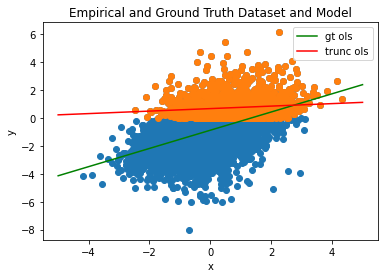

In [3]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
# m = Uniform(-5, 5)
phi = oracle.Left(Tensor([0.0]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = ch.ones(1)
noise_scale = ch.sqrt(noise_var/2)
laplace = Laplace(ch.zeros(1), noise_scale)
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + laplace.sample(ch.Size([X.size(0)]))
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [19]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.0143)
beta:  tensor(4.0143)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([0.6316])
trunc reg noise var:  tensor([2.0522])


Text(0, 0.5, 'y')

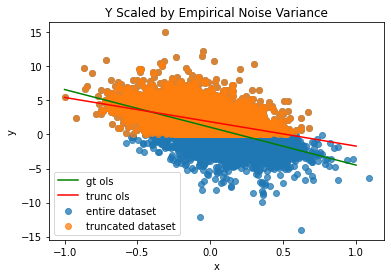

In [52]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)
emp_noise_scale = ch.sqrt(emp_noise_var/2) 

emp_stand_y_trunc = y_trunc / emp_noise_scale
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / emp_noise_scale

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([1.2631])
reg noise var:  tensor([2.0303])


Text(0, 0.5, 'y')

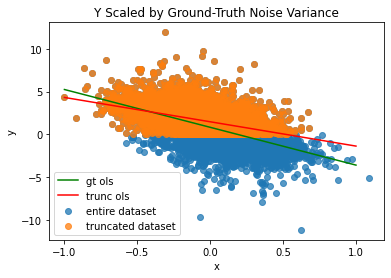

In [53]:
stand_noised, stand_y_trunc = noised / noise_scale, y_trunc / noise_scale

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [54]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm = (known_emp_res.weight * emp_noise_scale) / beta

known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_res.bias * emp_noise_scale)

0 steps | score: [0.08722872287034988]
100 steps | score: [-0.15371833741664886]
200 steps | score: [0.11577165126800537]
300 steps | score: [0.15002448856830597]
400 steps | score: [-0.040850937366485596]
500 steps | score: [0.04271867498755455]
600 steps | score: [0.01830844022333622]
700 steps | score: [0.04730379208922386]
800 steps | score: [-0.052826348692178726]
900 steps | score: [0.10823661088943481]
1000 steps | score: [0.08567563444375992]
1100 steps | score: [-0.0640784278512001]
1200 steps | score: [0.008505544625222683]


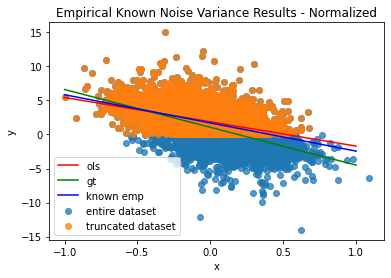

Text(0, 0.5, 'y')

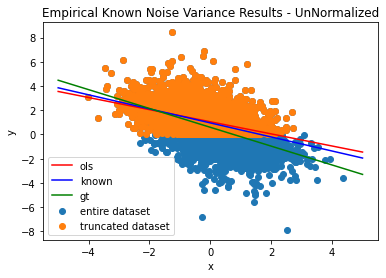

In [55]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_res(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [58]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=args.bias, unknown=False, val=100, bs=1, n=100, tol=1e-2, steps=2000)
known_res = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm = (known_res.weight * noise_scale) / beta

known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_res.bias * noise_scale

0 steps | score: [0.1404706835746765]
100 steps | score: [-0.20729883015155792]
200 steps | score: [-0.019203443080186844]
300 steps | score: [0.15922656655311584]
400 steps | score: [0.26590561866760254]
500 steps | score: [-0.19839715957641602]
600 steps | score: [-0.07279006391763687]
700 steps | score: [0.047994550317525864]
800 steps | score: [0.07560958713293076]
900 steps | score: [0.0676669031381607]
1000 steps | score: [-0.28352153301239014]
1100 steps | score: [0.052644044160842896]
1200 steps | score: [-0.017157278954982758]
1300 steps | score: [-0.22028736770153046]
1400 steps | score: [-0.1377340853214264]
1500 steps | score: [0.0061187297105789185]


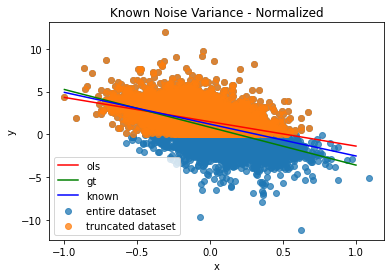

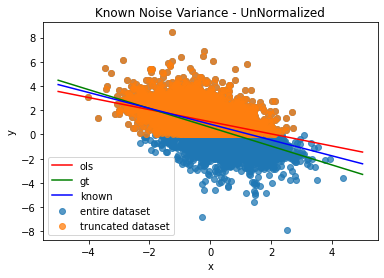

In [59]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_res(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [60]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=True, bs=1, n=100, tol=5e-2, val=100, steps=2000)
unknown_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
unknown_var = unknown_res.lambda_.inverse()
unknown_weight_unnorm, unknown_bias_unnorm = (((unknown_res.weight * unknown_var) * emp_noise_scale) / beta).detach().numpy(), ((unknown_res.bias * unknown_var) * emp_noise_scale).detach().numpy()

0 steps | score: [0.2905574440956116, -0.20666351914405823]
100 steps | score: [-0.27120140194892883, -3.2981948852539062]
200 steps | score: [-1.2057424783706665, 2.8927805423736572]
300 steps | score: [-0.8965381383895874, 2.547687530517578]
400 steps | score: [-1.3437919616699219, 3.0747432708740234]
500 steps | score: [-0.338600754737854, 1.6003186702728271]
600 steps | score: [-0.18581794202327728, 1.1041582822799683]
700 steps | score: [-2.0519609451293945, 3.499739170074463]
800 steps | score: [-0.5100373029708862, 1.8548325300216675]
900 steps | score: [-0.8865644335746765, 2.509981870651245]
1000 steps | score: [-0.5900213122367859, 2.0247135162353516]
1100 steps | score: [0.15984177589416504, 0.3845093250274658]
1200 steps | score: [0.22827421128749847, 0.23511837422847748]
1300 steps | score: [-0.3410768210887909, 1.496913194656372]
1400 steps | score: [-0.5526643395423889, 1.8662344217300415]
1500 steps | score: [0.03078850731253624, 0.7469772100448608]
1600 steps | score: 

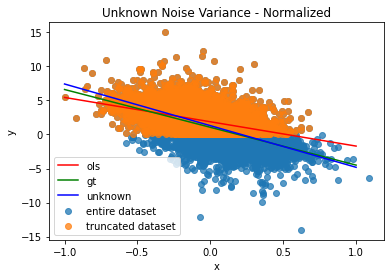

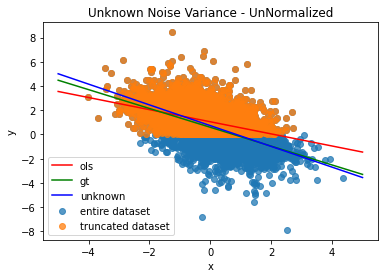

In [61]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_res(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [7]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 100)
args.__setattr__('samples', 2000)
args.__setattr__('n', 100)

EXP = '10Laplace3Trials'

In [8]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time    

In [9]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 5, 1

# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
noise_var = 5*ch.ones(1)
noise_scale = ch.sqrt(noise_var/2)
laplace = Laplace(ch.zeros(1), noise_scale)

C = [-2.5, -2, -1.75, -1.5, -1.25, -1.0, -.75, -.5, -.25, 0.0, .25, .5, .75, 1.0]

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

# create base classifier
with ch.no_grad():
    # generate data
    X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
    y = gt(X)

for i in range(args.trials):
    # create store and add table
    store = Store(args.out_dir + '/' + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'c': float,
        'num_samples': int,
        'noise_var': float, 
    })
    
    # add laplace noise to linear regression
    noised = y + laplace.sample(ch.Size([X.size(0)]))
        
    # iterate over truncation parameter C
    for c in C: 
        phi = oracle.Left(c)
        # add noise to ground-truth pedictions
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        
        val = int(.1*x_trunc.size(0))
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })

        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by the empirical noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by the empirical noise variance
        known_kwargs = { 
            'phi': oracle.Left(c/ch.sqrt(noise_var)), 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc)
        with ch.no_grad():
            w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var)
            known_params = ch.cat([w, w0]).flatten()
            
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(noised.flatten(), X@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params),
                'known_time': total_time, 
            })
        

        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_noise_scale = ch.sqrt(emp_noise_var/2) 
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
        
        # truncated regression with unknown variance
        unknown_kwargs = { 
            'phi': oracle.Left(c/ch.sqrt(emp_noise_var)), 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
    
        with ch.no_grad():
            w, w0 = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta), ((unknown_trunc_reg.intercept * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)))
            unknown_params = ch.cat([w, w0]).flatten()

            # unknown results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params),
                'unknown_var_l1': float(ch.abs(unknown_trunc_reg.variance * emp_noise_var - noise_var)),
                'unknown_time': total_time, 
            })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': float(noise_var), 
            'c': c,
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/10Laplace3Trials/40bfa70d-7bde-43a3-8da5-5f274c3fb5dd


/home/gridsan/stefanou/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:202: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(


Iteration: 0.0 | Score: [0.19730238616466522]
Iteration: 1.0 | Score: [0.013417521491646767]
Iteration: 2.0 | Score: [0.05552228167653084]
Iteration: 3.0 | Score: [0.12313379347324371]
Iteration: 4.0 | Score: [0.048318371176719666]
Iteration: 5.0 | Score: [0.07619437575340271]
Iteration: 6.0 | Score: [0.12184374034404755]
Iteration: 7.0 | Score: [0.09099868685007095]
Iteration: 8.0 | Score: [0.031680889427661896]
Iteration: 9.0 | Score: [0.05737914890050888]
Iteration: 10.0 | Score: [0.07247830182313919]
Iteration: 11.0 | Score: [0.12688203155994415]
Iteration: 12.0 | Score: [0.09124122560024261]
Iteration: 13.0 | Score: [0.05906148999929428]
Iteration: 14.0 | Score: [0.04723908007144928]
Iteration: 15.0 | Score: [0.11377337574958801]
Iteration: 16.0 | Score: [0.08860373497009277]
Iteration: 17.0 | Score: [0.04430176317691803]
Iteration: 18.0 | Score: [0.05720093846321106]
Iteration: 19.0 | Score: [0.09142492711544037]
Iteration: 20.0 | Score: [0.10212817043066025]
Iteration: 21.0 | Sc

Iteration: 1.0 | Score: [0.02966158650815487]
Iteration: 2.0 | Score: [-0.043213315308094025]
Iteration: 3.0 | Score: [0.03636738285422325]
Iteration: 4.0 | Score: [0.003392588347196579]
Iteration: 0.0 | Score: [0.1683618426322937, -0.07933833450078964]
Iteration: 1.0 | Score: [0.7658615708351135, -2.448899984359741]
Iteration: 2.0 | Score: [0.1355101466178894, -0.2603086531162262]
Iteration: 3.0 | Score: [0.08370891213417053, -0.16504442691802979]
Iteration: 4.0 | Score: [0.6812604069709778, -2.215684175491333]
Iteration: 5.0 | Score: [-0.29306551814079285, 0.9965350031852722]
Iteration: 6.0 | Score: [-0.18163998425006866, 0.6795210838317871]
Iteration: 7.0 | Score: [-0.11309290677309036, 0.46158134937286377]
Iteration: 8.0 | Score: [0.16221699118614197, -0.3798246383666992]
Iteration: 9.0 | Score: [0.023500336334109306, 0.06750627607107162]
Iteration: 10.0 | Score: [0.032988041639328, 0.011797219514846802]
Iteration: 11.0 | Score: [0.11526588350534439, -0.2550898790359497]
Iteration:

Iteration: 4.0 | Score: [-0.1817494034767151, 0.9360984563827515]
Iteration: 5.0 | Score: [0.20257358253002167, -0.2763904631137848]
Iteration: 6.0 | Score: [0.20079739391803741, -0.2668731212615967]
Iteration: 7.0 | Score: [0.11903693526983261, 0.019615717232227325]
Iteration: 8.0 | Score: [-0.12795865535736084, 0.7340877056121826]
Iteration: 9.0 | Score: [-0.01729492098093033, 0.4019438624382019]
Iteration: 10.0 | Score: [0.04329044744372368, 0.21114440262317657]
Iteration: 11.0 | Score: [0.2422587126493454, -0.42826563119888306]
Iteration: 12.0 | Score: [0.12294188141822815, -0.0013927668333053589]
Iteration: 13.0 | Score: [0.16829228401184082, -0.1998138427734375]
Iteration: 14.0 | Score: [0.16387011110782623, -0.17247796058654785]
Iteration: 15.0 | Score: [0.2979697287082672, -0.6381131410598755]
Iteration: 16.0 | Score: [0.10620980709791183, 0.01847374439239502]
Iteration: 17.0 | Score: [0.021307196468114853, 0.28286004066467285]
Iteration: 18.0 | Score: [0.12158418446779251, -0.

Iteration: 18.0 | Score: [0.010868490673601627, 0.16814279556274414]
Iteration: 19.0 | Score: [0.07351987808942795, -0.04165917634963989]
Iteration: 20.0 | Score: [0.05391662195324898, 0.01643046736717224]
Iteration: 21.0 | Score: [0.20435447990894318, -0.4934322237968445]
Iteration: 22.0 | Score: [0.06904833763837814, 0.019611746072769165]
Iteration: 23.0 | Score: [-0.04930791258811951, 0.3661300241947174]
Iteration: 24.0 | Score: [0.023737739771604538, 0.13151510059833527]
Iteration: 25.0 | Score: [0.058860234916210175, 0.005502164363861084]
Iteration: 0.0 | Score: [0.28577300906181335]
Iteration: 1.0 | Score: [0.1400422751903534]
Iteration: 2.0 | Score: [0.13947629928588867]
Iteration: 3.0 | Score: [0.11699120700359344]
Iteration: 4.0 | Score: [0.11526661366224289]
Iteration: 5.0 | Score: [0.17386850714683533]
Iteration: 6.0 | Score: [0.11790134012699127]
Iteration: 7.0 | Score: [0.15725477039813995]
Iteration: 8.0 | Score: [0.07221176475286484]
Iteration: 9.0 | Score: [0.1550465673

Iteration: 23.0 | Score: [0.12558577954769135]
Iteration: 24.0 | Score: [0.12902483344078064]
Iteration: 25.0 | Score: [0.12489727139472961]
Iteration: 0.0 | Score: [0.19720087945461273, -0.41353851556777954]
Iteration: 1.0 | Score: [0.0160647202283144, 0.010445449501276016]
Iteration: 2.0 | Score: [-0.008911477401852608, 0.06005511432886124]
Iteration: 3.0 | Score: [0.42182281613349915, -1.5250240564346313]
Iteration: 4.0 | Score: [0.2704792618751526, -0.9762381315231323]
Iteration: 5.0 | Score: [-0.19685184955596924, 0.6062084436416626]
Iteration: 6.0 | Score: [0.016536759212613106, -0.09893107414245605]
Iteration: 7.0 | Score: [-0.05981031060218811, 0.11889493465423584]
Iteration: 8.0 | Score: [0.555756151676178, -2.182438611984253]
Iteration: 9.0 | Score: [-0.10368403047323227, 0.30408188700675964]
Iteration: 10.0 | Score: [0.1069561168551445, -0.442378968000412]
Iteration: 11.0 | Score: [-0.02083086594939232, 0.025819186121225357]
Iteration: 12.0 | Score: [-0.0719011127948761, 0.1

Iteration: 9.0 | Score: [0.12019738554954529, -0.494695782661438]
Iteration: 10.0 | Score: [0.12030425667762756, -0.4513305425643921]
Iteration: 11.0 | Score: [0.04215877503156662, -0.20959722995758057]
Iteration: 12.0 | Score: [0.11227092146873474, -0.4781091809272766]
Iteration: 13.0 | Score: [-0.022627277299761772, -0.026838529855012894]
Iteration: 14.0 | Score: [0.0924200564622879, -0.4306444525718689]
Iteration: 15.0 | Score: [0.04601164907217026, -0.2737576365470886]
Iteration: 16.0 | Score: [0.08735014498233795, -0.3826777935028076]
Iteration: 17.0 | Score: [0.0673888698220253, -0.33579665422439575]
Iteration: 18.0 | Score: [0.1360529214143753, -0.587704062461853]
Iteration: 19.0 | Score: [-0.001943392911925912, -0.10324662923812866]
Iteration: 20.0 | Score: [0.08121398091316223, -0.3750692903995514]
Iteration: 21.0 | Score: [0.030950188636779785, -0.22078043222427368]
Iteration: 22.0 | Score: [0.10063398629426956, -0.42826029658317566]
Iteration: 23.0 | Score: [0.03204655647277

Iteration: 4.0 | Score: [0.1140836700797081]
Iteration: 5.0 | Score: [0.098915234208107]
Iteration: 6.0 | Score: [0.13736853003501892]
Iteration: 7.0 | Score: [0.1170237809419632]
Iteration: 8.0 | Score: [0.10895431041717529]
Iteration: 9.0 | Score: [0.09675890952348709]
Iteration: 10.0 | Score: [0.1102399230003357]
Iteration: 11.0 | Score: [0.09784307330846786]
Iteration: 12.0 | Score: [0.07705375552177429]
Iteration: 13.0 | Score: [0.11443863809108734]
Iteration: 14.0 | Score: [0.10146941244602203]
Iteration: 15.0 | Score: [0.10181679576635361]
Iteration: 16.0 | Score: [0.1148601844906807]
Iteration: 17.0 | Score: [0.11196958273649216]
Iteration: 18.0 | Score: [0.08229552954435349]
Iteration: 19.0 | Score: [0.12105043977499008]
Iteration: 20.0 | Score: [0.09723606705665588]
Iteration: 21.0 | Score: [0.08871389180421829]
Iteration: 22.0 | Score: [0.1178886666893959]
Iteration: 23.0 | Score: [0.10638692229986191]
Iteration: 24.0 | Score: [0.10274707525968552]
Iteration: 25.0 | Score: [

Iteration: 9.0 | Score: [-0.2006286233663559, 0.7232730388641357]
Iteration: 10.0 | Score: [0.03496836870908737, -0.06581676006317139]
Iteration: 11.0 | Score: [-0.18137739598751068, 0.6686700582504272]
Iteration: 12.0 | Score: [-0.12841962277889252, 0.5149866342544556]
Iteration: 13.0 | Score: [-0.0494428426027298, 0.22109825909137726]
Iteration: 14.0 | Score: [-0.01877558045089245, 0.14048415422439575]
Iteration: 15.0 | Score: [-0.1300916224718094, 0.5080496072769165]
Iteration: 16.0 | Score: [-0.13606470823287964, 0.5396153330802917]
Iteration: 17.0 | Score: [0.009808680973947048, 0.030050605535507202]
Iteration: 18.0 | Score: [-0.15128830075263977, 0.59421306848526]
Iteration: 19.0 | Score: [-0.05034876987338066, 0.2927052676677704]
Iteration: 20.0 | Score: [-0.12472967058420181, 0.49806320667266846]
Iteration: 21.0 | Score: [-0.2328261137008667, 0.8415912985801697]
Iteration: 22.0 | Score: [-0.16800783574581146, 0.6520172357559204]
Iteration: 23.0 | Score: [-0.19753910601139069, 0

Iteration: 5.0 | Score: [0.6045730710029602, -2.4043216705322266]
Iteration: 6.0 | Score: [0.504408597946167, -1.9246494770050049]
Iteration: 7.0 | Score: [0.4098343849182129, -1.5758252143859863]
Iteration: 8.0 | Score: [0.39209672808647156, -1.5077756643295288]
Iteration: 9.0 | Score: [0.2795916795730591, -1.0027711391448975]
Iteration: 10.0 | Score: [0.2694427967071533, -0.982079803943634]
Iteration: 11.0 | Score: [0.2046990543603897, -0.7550607323646545]
Iteration: 12.0 | Score: [0.12860506772994995, -0.38967904448509216]
Iteration: 13.0 | Score: [0.11508830636739731, -0.34682074189186096]
Iteration: 14.0 | Score: [0.12776902318000793, -0.4092234671115875]
Iteration: 15.0 | Score: [0.07965739071369171, -0.26887816190719604]
Iteration: 16.0 | Score: [0.08448989689350128, -0.21814720332622528]
Iteration: 17.0 | Score: [0.07591831684112549, -0.20646420121192932]
Iteration: 18.0 | Score: [0.07813303172588348, -0.23393100500106812]
Iteration: 19.0 | Score: [0.04898432642221451, -0.12491

Iteration: 24.0 | Score: [-0.08864298462867737, 0.42003482580184937]
Iteration: 25.0 | Score: [-0.10648324340581894, 0.5123786926269531]
Iteration: 0.0 | Score: [0.10218062251806259]
Iteration: 1.0 | Score: [-0.08735664933919907]
Iteration: 2.0 | Score: [-0.10926689952611923]
Iteration: 3.0 | Score: [-0.0034795235842466354]
Iteration: 0.0 | Score: [0.0936644971370697, 0.26348525285720825]
Iteration: 1.0 | Score: [-0.458109050989151, 2.018965482711792]
Iteration: 2.0 | Score: [-0.7157494425773621, 2.8008389472961426]
Iteration: 3.0 | Score: [-0.14265160262584686, 1.23732328414917]
Iteration: 4.0 | Score: [-0.20756946504116058, 1.4876155853271484]
Iteration: 5.0 | Score: [-0.3114835023880005, 1.647641897201538]
Iteration: 6.0 | Score: [-1.7539466619491577, 5.021909236907959]
Iteration: 7.0 | Score: [-0.5302332639694214, 2.3510403633117676]
Iteration: 8.0 | Score: [0.2951687276363373, -0.4299004375934601]
Iteration: 9.0 | Score: [-0.08442714810371399, 0.7461055517196655]
Iteration: 10.0 |

Iteration: 2.0 | Score: [-0.12403296679258347, 0.34691834449768066]
Iteration: 3.0 | Score: [-0.047196533530950546, 0.15046942234039307]
Iteration: 4.0 | Score: [0.1518472135066986, -0.48623913526535034]
Iteration: 5.0 | Score: [0.18191616237163544, -0.6514022350311279]
Iteration: 6.0 | Score: [-0.09604085236787796, 0.26068294048309326]
Iteration: 7.0 | Score: [-0.035319734364748, 0.09776133298873901]
Iteration: 8.0 | Score: [0.06481707096099854, -0.22360432147979736]
Iteration: 9.0 | Score: [0.05846278369426727, -0.2179320752620697]
Iteration: 10.0 | Score: [-0.1526000052690506, 0.3938747048377991]
Iteration: 11.0 | Score: [-0.004838235210627317, -0.05697202682495117]
Iteration: 12.0 | Score: [-0.06388680636882782, 0.14704066514968872]
Iteration: 13.0 | Score: [-0.10940317809581757, 0.24714863300323486]
Iteration: 14.0 | Score: [0.20121124386787415, -0.7337980270385742]
Iteration: 15.0 | Score: [0.08528373390436172, -0.3296263515949249]
Iteration: 16.0 | Score: [-0.12029733508825302, 

Iteration: 19.0 | Score: [0.10424024611711502, -0.45238491892814636]
Iteration: 20.0 | Score: [0.03266051411628723, -0.17936693131923676]
Iteration: 21.0 | Score: [-0.05773752182722092, 0.1115758866071701]
Iteration: 22.0 | Score: [-0.05783110857009888, 0.09006317704916]
Iteration: 23.0 | Score: [-0.0246376134455204, 0.018862079828977585]
Iteration: 24.0 | Score: [-0.02165026031434536, -0.04598693922162056]
Iteration: 25.0 | Score: [-0.07603763043880463, 0.18021321296691895]
Iteration: 0.0 | Score: [0.29257187247276306]
Iteration: 1.0 | Score: [0.16083543002605438]
Iteration: 2.0 | Score: [0.172055184841156]
Iteration: 3.0 | Score: [0.2191643863916397]
Iteration: 4.0 | Score: [0.1332380175590515]
Iteration: 5.0 | Score: [0.12134300917387009]
Iteration: 6.0 | Score: [0.1649492383003235]
Iteration: 7.0 | Score: [0.12013263255357742]
Iteration: 8.0 | Score: [0.15210694074630737]
Iteration: 9.0 | Score: [0.16656073927879333]
Iteration: 10.0 | Score: [0.166720449924469]
Iteration: 11.0 | Sc

Iteration: 5.0 | Score: [0.4091940224170685, -1.423794150352478]
Iteration: 6.0 | Score: [-0.07987980544567108, 0.1928916573524475]
Iteration: 7.0 | Score: [0.5240795612335205, -1.854569435119629]
Iteration: 8.0 | Score: [0.1957370489835739, -0.6969383358955383]
Iteration: 9.0 | Score: [0.22230450809001923, -0.7889172434806824]
Iteration: 10.0 | Score: [0.10940353572368622, -0.3861533999443054]
Iteration: 11.0 | Score: [0.22963501513004303, -0.8277810215950012]
Iteration: 12.0 | Score: [-0.012878206558525562, -0.01171986572444439]
Iteration: 13.0 | Score: [0.10511843115091324, -0.39324045181274414]
Iteration: 14.0 | Score: [0.17880800366401672, -0.6210268139839172]
Iteration: 15.0 | Score: [0.10026171058416367, -0.37128499150276184]
Iteration: 16.0 | Score: [0.038356147706508636, -0.17540043592453003]
Iteration: 17.0 | Score: [0.126661017537117, -0.4836607873439789]
Iteration: 18.0 | Score: [0.12703415751457214, -0.464977502822876]
Iteration: 19.0 | Score: [0.2749195694923401, -0.95235

Iteration: 3.0 | Score: [0.16527770459651947, -0.3878820836544037]
Iteration: 4.0 | Score: [0.26574116945266724, -0.7104727029800415]
Iteration: 5.0 | Score: [0.26091131567955017, -0.7223645448684692]
Iteration: 6.0 | Score: [0.013957763090729713, 0.15067541599273682]
Iteration: 7.0 | Score: [-0.07173694670200348, 0.492678701877594]
Iteration: 8.0 | Score: [-0.010441909544169903, 0.24132560193538666]
Iteration: 9.0 | Score: [-0.019609905779361725, 0.27362534403800964]
Iteration: 10.0 | Score: [-0.0018823336577042937, 0.2331286072731018]
Iteration: 11.0 | Score: [-0.08748840540647507, 0.4839746057987213]
Iteration: 12.0 | Score: [-0.1685865968465805, 0.7467219829559326]
Iteration: 13.0 | Score: [-0.11329713463783264, 0.5920768976211548]
Iteration: 14.0 | Score: [0.05462037771940231, -0.014762967824935913]
Iteration: 15.0 | Score: [0.1550159901380539, -0.34852612018585205]
Iteration: 16.0 | Score: [0.049663905054330826, 0.0018520057201385498]
Iteration: 17.0 | Score: [0.01646081544458866

Iteration: 17.0 | Score: [-0.05125923454761505]
Iteration: 18.0 | Score: [-0.03822524845600128]
Iteration: 19.0 | Score: [-0.03717972710728645]
Iteration: 20.0 | Score: [-0.06246304139494896]
Iteration: 21.0 | Score: [-0.05448693037033081]
Iteration: 22.0 | Score: [-0.04601318761706352]
Iteration: 23.0 | Score: [-0.04414623603224754]
Iteration: 24.0 | Score: [-0.041126929223537445]
Iteration: 25.0 | Score: [-0.02887662686407566]
Iteration: 0.0 | Score: [0.21190884709358215, -0.011274859309196472]
Iteration: 1.0 | Score: [-0.8819200396537781, 2.7374267578125]
Iteration: 2.0 | Score: [0.2700013220310211, -0.27886873483657837]
Iteration: 3.0 | Score: [-0.144415020942688, 0.9859007596969604]
Iteration: 4.0 | Score: [-0.06179337203502655, 0.7208890914916992]
Iteration: 5.0 | Score: [-0.14744746685028076, 0.8373974561691284]
Iteration: 6.0 | Score: [-0.01868627220392227, 0.45202207565307617]
Iteration: 7.0 | Score: [0.01726900227367878, 0.277025431394577]
Iteration: 8.0 | Score: [-0.11726740

Iteration: 13.0 | Score: [-0.08856116235256195]
Iteration: 14.0 | Score: [-0.07616984844207764]
Iteration: 15.0 | Score: [-0.07483896613121033]
Iteration: 16.0 | Score: [-0.07079662382602692]
Iteration: 17.0 | Score: [-0.06563480198383331]
Iteration: 18.0 | Score: [-0.08275328576564789]
Iteration: 19.0 | Score: [-0.06309732794761658]
Iteration: 20.0 | Score: [-0.10252581536769867]
Iteration: 21.0 | Score: [-0.084914430975914]
Iteration: 22.0 | Score: [-0.07094690203666687]
Iteration: 23.0 | Score: [-0.06433896720409393]
Iteration: 24.0 | Score: [-0.07954121381044388]
Iteration: 25.0 | Score: [-0.0521920882165432]
Iteration: 0.0 | Score: [-0.03236875683069229, 0.568934440612793]
Iteration: 1.0 | Score: [-0.25378909707069397, 1.0821892023086548]
Iteration: 2.0 | Score: [-0.3698759078979492, 1.3878188133239746]
Iteration: 3.0 | Score: [-0.2558467388153076, 0.9889382719993591]
Iteration: 4.0 | Score: [0.17332345247268677, -0.6382092833518982]
Iteration: 5.0 | Score: [-0.32046473026275635, 

Iteration: 13.0 | Score: [-0.19160325825214386, 0.5236266255378723]
Iteration: 14.0 | Score: [-0.024992873892188072, 0.013617362827062607]
Iteration: 15.0 | Score: [-0.12339053303003311, 0.3789577782154083]
Iteration: 16.0 | Score: [-0.09660577028989792, 0.23837754130363464]
Iteration: 17.0 | Score: [-0.1704290807247162, 0.48125889897346497]
Iteration: 18.0 | Score: [-0.10569999366998672, 0.24696725606918335]
Iteration: 19.0 | Score: [-0.08505278080701828, 0.20318853855133057]
Iteration: 20.0 | Score: [-0.10240230709314346, 0.2617667019367218]
Iteration: 21.0 | Score: [-0.053546011447906494, 0.13138112425804138]
Iteration: 22.0 | Score: [-0.08559702336788177, 0.17782101035118103]
Iteration: 23.0 | Score: [-0.15401591360569, 0.37776729464530945]
Iteration: 24.0 | Score: [-0.11588193476200104, 0.33652517199516296]
Iteration: 25.0 | Score: [-0.08801893889904022, 0.18216931819915771]
Iteration: 26.0 | Score: [-0.10791143029928207, 0.2849160432815552]
Iteration: 0.0 | Score: [0.068775519728

Iteration: 18.0 | Score: [-0.22554180026054382, 0.5278384685516357]
Iteration: 19.0 | Score: [-0.16280601918697357, 0.36579763889312744]
Iteration: 20.0 | Score: [-0.08599952608346939, 0.1106581836938858]
Iteration: 21.0 | Score: [-0.0791812613606453, 0.12066353857517242]
Iteration: 22.0 | Score: [-0.11637238413095474, 0.20846664905548096]
Iteration: 23.0 | Score: [-0.09173689782619476, 0.1419936716556549]
Iteration: 24.0 | Score: [-0.20267772674560547, 0.46914857625961304]
Iteration: 25.0 | Score: [-0.1643657237291336, 0.3435981273651123]
Iteration: 26.0 | Score: [-0.11654472351074219, 0.17135313153266907]
Iteration: 0.0 | Score: [0.1016877144575119]
Iteration: 1.0 | Score: [-0.08587092906236649]
Iteration: 2.0 | Score: [-0.09638690948486328]
Iteration: 3.0 | Score: [-0.034103378653526306]
Iteration: 4.0 | Score: [-0.029149897396564484]
Iteration: 5.0 | Score: [-0.028861716389656067]
Iteration: 6.0 | Score: [-0.07955757528543472]
Iteration: 7.0 | Score: [-0.029576227068901062]
Iterati

Iteration: 17.0 | Score: [0.015110091306269169, 0.09022484719753265]
Iteration: 18.0 | Score: [0.007529066875576973, 0.10859131067991257]
Iteration: 19.0 | Score: [0.1500491052865982, -0.36359795928001404]
Iteration: 20.0 | Score: [-0.14453402161598206, 0.6228532791137695]
Iteration: 21.0 | Score: [-0.047392189502716064, 0.2868337035179138]
Iteration: 22.0 | Score: [-0.041663479059934616, 0.25195929408073425]
Iteration: 23.0 | Score: [-0.031159454956650734, 0.2473941296339035]
Iteration: 24.0 | Score: [-0.01039582584053278, 0.1519337296485901]
Iteration: 25.0 | Score: [-0.009746621362864971, 0.1646682769060135]
Iteration: 0.0 | Score: [0.12067965418100357, 0.08491750806570053]
Iteration: 1.0 | Score: [0.16762658953666687, -0.4260737895965576]
Iteration: 2.0 | Score: [-0.13422180712223053, 0.5691685676574707]
Iteration: 3.0 | Score: [0.14571155607700348, -0.41749927401542664]
Iteration: 4.0 | Score: [0.30809712409973145, -1.0551977157592773]
Iteration: 5.0 | Score: [-0.00103748298715800

Iteration: 6.0 | Score: [0.0719529241323471]
Iteration: 7.0 | Score: [0.07659061253070831]
Iteration: 8.0 | Score: [0.07722000777721405]
Iteration: 9.0 | Score: [0.0910339206457138]
Iteration: 10.0 | Score: [0.06849538534879684]
Iteration: 11.0 | Score: [0.07792368531227112]
Iteration: 12.0 | Score: [0.07402904331684113]
Iteration: 13.0 | Score: [0.07371177524328232]
Iteration: 14.0 | Score: [0.07133731245994568]
Iteration: 15.0 | Score: [0.08491593599319458]
Iteration: 16.0 | Score: [0.06832344830036163]
Iteration: 17.0 | Score: [0.07678696513175964]
Iteration: 18.0 | Score: [0.08042670786380768]
Iteration: 19.0 | Score: [0.06529875099658966]
Iteration: 20.0 | Score: [0.044176358729600906]
Iteration: 21.0 | Score: [0.06361104547977448]
Iteration: 22.0 | Score: [0.059047721326351166]
Iteration: 23.0 | Score: [0.04228338599205017]
Iteration: 24.0 | Score: [0.051393523812294006]
Iteration: 25.0 | Score: [0.035485006868839264]
Iteration: 0.0 | Score: [0.33574748039245605, -0.5420216917991

Iteration: 13.0 | Score: [-0.024237455800175667, 0.21461087465286255]
Iteration: 14.0 | Score: [-0.06548482179641724, 0.33533793687820435]
Iteration: 15.0 | Score: [-0.07039137184619904, 0.3466627299785614]
Iteration: 16.0 | Score: [-0.07920439541339874, 0.34497886896133423]
Iteration: 17.0 | Score: [-0.19572758674621582, 0.7626738548278809]
Iteration: 18.0 | Score: [-0.1879962831735611, 0.7527638077735901]
Iteration: 19.0 | Score: [-0.2115214616060257, 0.8181854486465454]
Iteration: 20.0 | Score: [-0.16188831627368927, 0.652670681476593]
Iteration: 21.0 | Score: [-0.09208586812019348, 0.42321693897247314]
Iteration: 22.0 | Score: [-0.09881357103586197, 0.46106940507888794]
Iteration: 23.0 | Score: [-0.12169691175222397, 0.5247207880020142]
Iteration: 24.0 | Score: [-0.054188646376132965, 0.2705579996109009]
Iteration: 25.0 | Score: [-0.05380959436297417, 0.32430025935173035]
Iteration: 0.0 | Score: [0.16609853506088257, -0.10190461575984955]
Iteration: 1.0 | Score: [0.0367670059204101

Iteration: 19.0 | Score: [-0.07546963542699814, 0.061188410967588425]
Iteration: 20.0 | Score: [0.08782505989074707, -0.5221110582351685]
Iteration: 21.0 | Score: [0.1271737962961197, -0.6445410251617432]
Iteration: 22.0 | Score: [0.010728302411735058, -0.24248917400836945]
Iteration: 23.0 | Score: [0.11289110034704208, -0.5984562039375305]
Iteration: 24.0 | Score: [0.17263899743556976, -0.8475467562675476]
Iteration: 25.0 | Score: [0.08736767619848251, -0.5292161107063293]
Iteration: 0.0 | Score: [0.2831606864929199, -0.4881182312965393]
Iteration: 1.0 | Score: [0.9950701594352722, -3.8797483444213867]
Iteration: 2.0 | Score: [-0.24088163673877716, 1.0832282304763794]
Iteration: 3.0 | Score: [-0.09028461575508118, 0.5617090463638306]
Iteration: 4.0 | Score: [0.033725082874298096, 0.07132954895496368]
Iteration: 5.0 | Score: [0.1933787614107132, -0.5608599185943604]
Iteration: 6.0 | Score: [0.018864188343286514, 0.18796372413635254]
Iteration: 7.0 | Score: [0.06492703408002853, -0.0426

Iteration: 15.0 | Score: [-0.09402399510145187, 0.5842896699905396]
Iteration: 16.0 | Score: [-0.14257508516311646, 0.7644062638282776]
Iteration: 17.0 | Score: [-0.031053723767399788, 0.3756827414035797]
Iteration: 18.0 | Score: [-0.051658935844898224, 0.45173579454421997]
Iteration: 19.0 | Score: [0.11536828428506851, -0.21940171718597412]
Iteration: 20.0 | Score: [-0.13360856473445892, 0.7063616514205933]
Iteration: 21.0 | Score: [-0.14708943665027618, 0.7626097202301025]
Iteration: 22.0 | Score: [-0.11680837720632553, 0.6306130886077881]
Iteration: 23.0 | Score: [-0.06117839738726616, 0.46720945835113525]
Iteration: 24.0 | Score: [0.07049304991960526, -0.05370410904288292]
Iteration: 25.0 | Score: [0.041067175567150116, 0.07127688825130463]
Iteration: 0.0 | Score: [0.08466088771820068, 0.5551239252090454]
Iteration: 1.0 | Score: [0.4478587508201599, -1.2490980625152588]
Iteration: 2.0 | Score: [-0.3658076524734497, 1.8721492290496826]
Iteration: 3.0 | Score: [-0.24829640984535217, 

Iteration: 25.0 | Score: [-0.20349451899528503, 0.5316051244735718]
Iteration: 0.0 | Score: [0.1798112392425537]
Iteration: 1.0 | Score: [0.10281720757484436]
Iteration: 2.0 | Score: [0.051724858582019806]
Iteration: 3.0 | Score: [0.006635021418333054]
Iteration: 0.0 | Score: [0.09507998079061508, -0.04478822648525238]
Iteration: 1.0 | Score: [0.47088298201560974, -1.8770726919174194]
Iteration: 2.0 | Score: [0.03147813677787781, -0.2645881772041321]
Iteration: 3.0 | Score: [-0.179849773645401, 0.47704190015792847]
Iteration: 4.0 | Score: [-0.2361515760421753, 0.6034018397331238]
Iteration: 5.0 | Score: [0.26300328969955444, -1.1077964305877686]
Iteration: 6.0 | Score: [-0.26297903060913086, 0.6742138862609863]
Iteration: 7.0 | Score: [-0.07357151806354523, 0.06075698509812355]
Iteration: 8.0 | Score: [-0.11649604886770248, 0.1945895254611969]
Iteration: 9.0 | Score: [-0.032991182059049606, -0.07530424743890762]
Iteration: 10.0 | Score: [0.18327054381370544, -0.8445353507995605]
Iterat

Iteration: 25.0 | Score: [-0.1208748072385788]
Iteration: 0.0 | Score: [0.17712809145450592, 0.09312877804040909]
Iteration: 1.0 | Score: [-0.06692259758710861, 0.4674801230430603]
Iteration: 2.0 | Score: [0.06251291185617447, -0.009261563420295715]
Iteration: 3.0 | Score: [-0.22283625602722168, 0.8333735466003418]
Iteration: 4.0 | Score: [-0.0926898643374443, 0.535748302936554]
Iteration: 5.0 | Score: [-0.043301574885845184, 0.41145452857017517]
Iteration: 6.0 | Score: [0.04687238857150078, 0.1410059630870819]
Iteration: 7.0 | Score: [-0.10443991422653198, 0.5825164318084717]
Iteration: 8.0 | Score: [-0.10565900802612305, 0.5942419767379761]
Iteration: 9.0 | Score: [-0.10122457146644592, 0.49131983518600464]
Iteration: 10.0 | Score: [0.05220884457230568, 0.05644592270255089]
Iteration: 11.0 | Score: [0.05242506414651871, 0.08460510522127151]
Iteration: 12.0 | Score: [0.003091291291639209, 0.23581862449645996]
Iteration: 13.0 | Score: [0.1808750480413437, -0.3219119608402252]
Iteration

Iteration: 11.0 | Score: [0.05791141837835312, -0.3077147901058197]
Iteration: 12.0 | Score: [-0.05653773620724678, 0.10334721207618713]
Iteration: 13.0 | Score: [0.1423216313123703, -0.653138279914856]
Iteration: 14.0 | Score: [-0.1835191696882248, 0.5270066261291504]
Iteration: 15.0 | Score: [-0.10197364538908005, 0.2447575479745865]
Iteration: 16.0 | Score: [-0.07249154150485992, 0.15249387919902802]
Iteration: 17.0 | Score: [-0.11437378823757172, 0.25751009583473206]
Iteration: 18.0 | Score: [-0.12251356244087219, 0.3144341707229614]
Iteration: 19.0 | Score: [-0.11410784721374512, 0.2707688808441162]
Iteration: 20.0 | Score: [-0.22721366584300995, 0.6416326761245728]
Iteration: 21.0 | Score: [-0.08762615919113159, 0.2095051109790802]
Iteration: 22.0 | Score: [-0.043872226029634476, 0.05408420413732529]
Iteration: 23.0 | Score: [-0.08027869462966919, 0.16889776289463043]
Iteration: 24.0 | Score: [0.08537523448467255, -0.4613637924194336]
Iteration: 25.0 | Score: [0.03941519930958748

Iteration: 14.0 | Score: [0.007052307017147541, -0.05983937531709671]
Iteration: 15.0 | Score: [-0.029053909704089165, 0.05596674606204033]
Iteration: 16.0 | Score: [-0.021381637081503868, 0.040360916405916214]
Iteration: 17.0 | Score: [-0.021554483100771904, 0.04408842325210571]
Iteration: 18.0 | Score: [-0.055392391979694366, 0.15849122405052185]
Iteration: 19.0 | Score: [-0.008203883655369282, 0.011436881497502327]
Iteration: 20.0 | Score: [-0.028266360983252525, 0.0850447341799736]
Iteration: 21.0 | Score: [-0.04291970655322075, 0.13038450479507446]
Iteration: 22.0 | Score: [-0.03221389651298523, 0.11662116646766663]
Iteration: 23.0 | Score: [-0.015733111649751663, 0.007883764803409576]
Iteration: 24.0 | Score: [-0.03612152859568596, 0.10186515748500824]
Iteration: 25.0 | Score: [-0.051810719072818756, 0.13627050817012787]
Iteration: 0.0 | Score: [0.1660112738609314]
Iteration: 1.0 | Score: [-0.1177506223320961]
Iteration: 2.0 | Score: [-0.11410709470510483]
Iteration: 3.0 | Score:

Iteration: 3.0 | Score: [0.17428897321224213, -0.580924928188324]
Iteration: 4.0 | Score: [0.07974886894226074, -0.19513191282749176]
Iteration: 5.0 | Score: [0.07979264110326767, -0.2230803668498993]
Iteration: 6.0 | Score: [-0.1682792603969574, 0.6816592216491699]
Iteration: 7.0 | Score: [-0.07887115329504013, 0.31984061002731323]
Iteration: 8.0 | Score: [0.27906426787376404, -1.133392572402954]
Iteration: 9.0 | Score: [-0.009835698641836643, 0.038562074303627014]
Iteration: 10.0 | Score: [0.16252118349075317, -0.6168380379676819]
Iteration: 11.0 | Score: [-0.22719331085681915, 0.8762809038162231]
Iteration: 12.0 | Score: [-0.024768885225057602, 0.07976892590522766]
Iteration: 13.0 | Score: [0.1490825116634369, -0.5571364760398865]
Iteration: 14.0 | Score: [0.04992649704217911, -0.21464554965496063]
Iteration: 15.0 | Score: [0.05102900415658951, -0.20984376966953278]
Iteration: 16.0 | Score: [-0.061557844281196594, 0.2609553337097168]
Iteration: 17.0 | Score: [0.04121812433004379, -0

Iteration: 4.0 | Score: [0.17023751139640808, -0.4675132930278778]
Iteration: 5.0 | Score: [-0.10737498104572296, 0.478255033493042]
Iteration: 6.0 | Score: [-0.044606391340494156, 0.24398642778396606]
Iteration: 7.0 | Score: [0.18010278046131134, -0.5628489255905151]
Iteration: 8.0 | Score: [-0.058126289397478104, 0.24809890985488892]
Iteration: 9.0 | Score: [0.2573665380477905, -0.9060755968093872]
Iteration: 10.0 | Score: [0.266329824924469, -0.9319312572479248]
Iteration: 11.0 | Score: [0.9238019585609436, -3.792940616607666]
Iteration: 12.0 | Score: [0.5484659075737, -2.094914436340332]
Iteration: 13.0 | Score: [0.1950453817844391, -0.6948688626289368]
Iteration: 14.0 | Score: [0.11818450689315796, -0.3867424428462982]
Iteration: 15.0 | Score: [0.23055756092071533, -0.8071091771125793]
Iteration: 16.0 | Score: [0.2860889434814453, -1.0307964086532593]
Iteration: 17.0 | Score: [0.45465540885925293, -1.734552025794983]
Iteration: 18.0 | Score: [0.2687300741672516, -0.998405635356903

Iteration: 10.0 | Score: [0.15817414224147797, -0.3264562487602234]
Iteration: 11.0 | Score: [-0.0030453880317509174, 0.15091155469417572]
Iteration: 12.0 | Score: [0.17326457798480988, -0.3643667995929718]
Iteration: 13.0 | Score: [0.10250463336706161, -0.15357767045497894]
Iteration: 14.0 | Score: [0.14292269945144653, -0.2815456688404083]
Iteration: 15.0 | Score: [0.10636109113693237, -0.1889778971672058]
Iteration: 16.0 | Score: [0.008555697277188301, 0.11340415477752686]
Iteration: 17.0 | Score: [0.1882537305355072, -0.4371737241744995]
Iteration: 18.0 | Score: [0.047669198364019394, -0.011543121188879013]
Iteration: 19.0 | Score: [0.20023472607135773, -0.46341297030448914]
Iteration: 20.0 | Score: [0.05268950015306473, 0.01735607162117958]
Iteration: 21.0 | Score: [0.00024796626530587673, 0.14872391521930695]
Iteration: 22.0 | Score: [0.04897457733750343, 0.011271487921476364]
Iteration: 23.0 | Score: [0.037306759506464005, 0.04139566048979759]
Iteration: 24.0 | Score: [0.1305178

Iteration: 4.0 | Score: [0.0305454321205616]
Iteration: 5.0 | Score: [0.10770927369594574]
Iteration: 6.0 | Score: [-0.012790191918611526]
Iteration: 7.0 | Score: [0.046042606234550476]
Iteration: 8.0 | Score: [0.05812784284353256]
Iteration: 9.0 | Score: [0.03163229674100876]
Iteration: 10.0 | Score: [0.0431143194437027]
Iteration: 11.0 | Score: [0.050827860832214355]
Iteration: 12.0 | Score: [0.041764166206121445]
Iteration: 13.0 | Score: [0.034307386726140976]
Iteration: 14.0 | Score: [0.029802624136209488]
Iteration: 15.0 | Score: [0.015640150755643845]
Iteration: 16.0 | Score: [0.02081037312746048]
Iteration: 17.0 | Score: [0.03539198264479637]
Iteration: 18.0 | Score: [0.04595816507935524]
Iteration: 19.0 | Score: [0.05286652594804764]
Iteration: 20.0 | Score: [0.03914390504360199]
Iteration: 21.0 | Score: [0.047313474118709564]
Iteration: 22.0 | Score: [0.023346323519945145]
Iteration: 23.0 | Score: [0.03613414242863655]
Iteration: 24.0 | Score: [0.039143919944763184]
Iteration:

Iteration: 18.0 | Score: [-0.15856599807739258, 0.46678757667541504]
Iteration: 19.0 | Score: [-0.15248368680477142, 0.44052982330322266]
Iteration: 20.0 | Score: [-0.11725876480340958, 0.29963940382003784]
Iteration: 21.0 | Score: [-0.08201736956834793, 0.18966293334960938]
Iteration: 22.0 | Score: [-0.10770370811223984, 0.2241707444190979]
Iteration: 23.0 | Score: [-0.11965002119541168, 0.31125760078430176]
Iteration: 24.0 | Score: [-0.07271730154752731, 0.1614135503768921]
Iteration: 25.0 | Score: [-0.06863220036029816, 0.11298400163650513]
Iteration: 0.0 | Score: [0.1967335045337677]
Iteration: 1.0 | Score: [-0.001515934243798256]
Iteration: 0.0 | Score: [0.11621006578207016, 0.09904805570840836]
Iteration: 1.0 | Score: [-0.12758532166481018, 0.5094086527824402]
Iteration: 2.0 | Score: [0.12968456745147705, -0.379116952419281]
Iteration: 3.0 | Score: [-0.024695008993148804, 0.08669888973236084]
Iteration: 4.0 | Score: [0.25249889492988586, -0.871360719203949]
Iteration: 5.0 | Score

Iteration: 12.0 | Score: [-0.4434569478034973, 1.0855722427368164]
Iteration: 13.0 | Score: [-0.2783883810043335, 0.5417360067367554]
Iteration: 14.0 | Score: [-0.24875158071517944, 0.4888610541820526]
Iteration: 15.0 | Score: [-0.12944760918617249, 0.028178870677947998]
Iteration: 16.0 | Score: [-0.14951978623867035, 0.09587159752845764]
Iteration: 17.0 | Score: [-0.1763434261083603, 0.2217828333377838]
Iteration: 18.0 | Score: [-0.23397837579250336, 0.37760841846466064]
Iteration: 19.0 | Score: [-0.1731480062007904, 0.20854511857032776]
Iteration: 20.0 | Score: [-0.11227156221866608, 0.006924852728843689]
Iteration: 21.0 | Score: [-0.23430785536766052, 0.39730891585350037]
Iteration: 22.0 | Score: [-0.18495166301727295, 0.22196394205093384]
Iteration: 23.0 | Score: [-0.2141449749469757, 0.3348920941352844]
Iteration: 24.0 | Score: [-0.14310389757156372, 0.10772010684013367]
Iteration: 25.0 | Score: [-0.28271913528442383, 0.5323726534843445]
Iteration: 0.0 | Score: [0.1781458258628845

Iteration: 1.0 | Score: [-0.14845462143421173, 0.5576657056808472]
Iteration: 2.0 | Score: [0.17484204471111298, -0.8061336874961853]
Iteration: 3.0 | Score: [-0.0177221167832613, -0.11797698587179184]
Iteration: 4.0 | Score: [-0.28449946641921997, 0.9022196531295776]
Iteration: 5.0 | Score: [-0.2336890995502472, 0.7103679180145264]
Iteration: 6.0 | Score: [-0.26883962750434875, 0.8236604332923889]
Iteration: 7.0 | Score: [-0.13424119353294373, 0.3078788220882416]
Iteration: 8.0 | Score: [-0.15383823215961456, 0.34787416458129883]
Iteration: 9.0 | Score: [-0.21158599853515625, 0.5936314463615417]
Iteration: 10.0 | Score: [-0.13062874972820282, 0.262186735868454]
Iteration: 11.0 | Score: [0.02350512146949768, -0.3629920482635498]
Iteration: 12.0 | Score: [-0.32734858989715576, 0.999467134475708]
Iteration: 13.0 | Score: [-0.16168256103992462, 0.3684903383255005]
Iteration: 14.0 | Score: [-0.2536461055278778, 0.7258374691009521]
Iteration: 15.0 | Score: [-0.2799786627292633, 0.8261636495

Iteration: 2.0 | Score: [0.23804256319999695, -0.38655173778533936]
Iteration: 3.0 | Score: [0.8299316763877869, -2.7501211166381836]
Iteration: 4.0 | Score: [0.17907477915287018, -0.232120543718338]
Iteration: 5.0 | Score: [0.2288459837436676, -0.42999276518821716]
Iteration: 6.0 | Score: [0.2677810788154602, -0.5946940183639526]
Iteration: 7.0 | Score: [0.03672880306839943, 0.29544514417648315]
Iteration: 8.0 | Score: [0.11370371282100677, -0.020102214068174362]
Iteration: 9.0 | Score: [0.11056417971849442, -0.05423523858189583]
Iteration: 10.0 | Score: [-0.10507258027791977, 0.6773373484611511]
Iteration: 11.0 | Score: [0.046410009264945984, 0.18090373277664185]
Iteration: 12.0 | Score: [0.15551774203777313, -0.14360100030899048]
Iteration: 13.0 | Score: [0.05850246548652649, 0.1622580885887146]
Iteration: 14.0 | Score: [0.22078555822372437, -0.37585633993148804]
Iteration: 15.0 | Score: [0.23331305384635925, -0.3993721306324005]
Iteration: 16.0 | Score: [0.07697304338216782, 0.1018

Iteration: 9.0 | Score: [-0.18190555274486542, 0.382687509059906]
Iteration: 10.0 | Score: [-0.06275158375501633, -0.06782208383083344]
Iteration: 11.0 | Score: [-0.23976223170757294, 0.615034818649292]
Iteration: 12.0 | Score: [-0.17712253332138062, 0.38038650155067444]
Iteration: 13.0 | Score: [-0.07780846208333969, -0.033640604466199875]
Iteration: 14.0 | Score: [-0.09546882659196854, 0.0441921129822731]
Iteration: 15.0 | Score: [-0.06864091753959656, -0.03924207761883736]
Iteration: 16.0 | Score: [-0.2137913554906845, 0.5002406239509583]
Iteration: 17.0 | Score: [-0.21188732981681824, 0.5056196451187134]
Iteration: 18.0 | Score: [0.05980905145406723, -0.4274238049983978]
Iteration: 19.0 | Score: [-0.1622997671365738, 0.29511234164237976]
Iteration: 20.0 | Score: [-0.05910502001643181, -0.0749262124300003]
Iteration: 21.0 | Score: [0.08711003512144089, -0.6219304800033569]
Iteration: 22.0 | Score: [-0.08950140327215195, 0.09995496273040771]
Iteration: 23.0 | Score: [-0.1678134351968

Iteration: 3.0 | Score: [0.01724998652935028]
Iteration: 4.0 | Score: [-0.0033089816570281982]
Iteration: 0.0 | Score: [0.2046796679496765, -0.2997763454914093]
Iteration: 1.0 | Score: [-0.366590678691864, 1.1394253969192505]
Iteration: 2.0 | Score: [-0.15858042240142822, 0.48836398124694824]
Iteration: 3.0 | Score: [-0.15977704524993896, 0.5179129838943481]
Iteration: 4.0 | Score: [0.03502688929438591, -0.18360048532485962]
Iteration: 5.0 | Score: [-0.20398662984371185, 0.6332210898399353]
Iteration: 6.0 | Score: [-0.09476348012685776, 0.3072437644004822]
Iteration: 7.0 | Score: [0.07371782511472702, -0.273421049118042]
Iteration: 8.0 | Score: [0.16839414834976196, -0.6939143538475037]
Iteration: 9.0 | Score: [0.027311142534017563, -0.14036639034748077]
Iteration: 10.0 | Score: [-0.044348787516355515, 0.06592001020908356]
Iteration: 11.0 | Score: [0.12187981605529785, -0.5511823296546936]
Iteration: 12.0 | Score: [0.09941870719194412, -0.41953930258750916]
Iteration: 13.0 | Score: [0.

Iteration: 20.0 | Score: [0.0170772522687912, 0.20776860415935516]
Iteration: 21.0 | Score: [0.04579788073897362, 0.06267780065536499]
Iteration: 22.0 | Score: [0.06538879126310349, 0.02781950682401657]
Iteration: 23.0 | Score: [0.021577470004558563, 0.18253469467163086]
Iteration: 24.0 | Score: [0.029366780072450638, 0.16218063235282898]
Iteration: 25.0 | Score: [0.058962102979421616, 0.07938679307699203]
Iteration: 26.0 | Score: [0.03162166848778725, 0.13159316778182983]
Iteration: 0.0 | Score: [0.2373546063899994]
Iteration: 1.0 | Score: [0.03724709898233414]
Iteration: 2.0 | Score: [0.04088971018791199]
Iteration: 3.0 | Score: [0.09022397547960281]
Iteration: 4.0 | Score: [0.14446064829826355]
Iteration: 5.0 | Score: [0.14253799617290497]
Iteration: 6.0 | Score: [0.1113213300704956]
Iteration: 7.0 | Score: [0.12517490983009338]
Iteration: 8.0 | Score: [0.12292385846376419]
Iteration: 9.0 | Score: [0.15379150211811066]
Iteration: 10.0 | Score: [0.15857365727424622]
Iteration: 11.0 |

Iteration: 2.0 | Score: [-0.11634453386068344, 0.5689019560813904]
Iteration: 3.0 | Score: [-0.06406087428331375, 0.360381543636322]
Iteration: 4.0 | Score: [-0.3513123691082001, 1.2925834655761719]
Iteration: 5.0 | Score: [-0.09132616966962814, 0.3891381621360779]
Iteration: 6.0 | Score: [0.10479838401079178, -0.31819114089012146]
Iteration: 7.0 | Score: [-0.22390511631965637, 0.8509657979011536]
Iteration: 8.0 | Score: [-0.07156994938850403, 0.28776314854621887]
Iteration: 9.0 | Score: [-0.04250672087073326, 0.20316419005393982]
Iteration: 10.0 | Score: [0.024739468470215797, -0.06263405084609985]
Iteration: 11.0 | Score: [0.0039114863611757755, -0.023289816454052925]
Iteration: 12.0 | Score: [-0.08125925064086914, 0.32547953724861145]
Iteration: 13.0 | Score: [-0.09369556605815887, 0.3527294397354126]
Iteration: 14.0 | Score: [0.0994197428226471, -0.35778018832206726]
Iteration: 15.0 | Score: [-0.0071523431688547134, 0.06500668823719025]
Iteration: 16.0 | Score: [-0.0731231868267059

Iteration: 16.0 | Score: [0.07592850178480148, -0.30078449845314026]
Iteration: 17.0 | Score: [0.1336778849363327, -0.5358169674873352]
Iteration: 18.0 | Score: [0.004139730706810951, -0.07174742221832275]
Iteration: 19.0 | Score: [0.08848664164543152, -0.33750054240226746]
Iteration: 20.0 | Score: [0.10653910785913467, -0.4356220066547394]
Iteration: 21.0 | Score: [-0.014003881253302097, 0.013756796717643738]
Iteration: 22.0 | Score: [0.028658099472522736, -0.14078308641910553]
Iteration: 23.0 | Score: [0.08280870318412781, -0.32305973768234253]
Iteration: 24.0 | Score: [0.09459094703197479, -0.3676033020019531]
Iteration: 25.0 | Score: [0.11894895881414413, -0.46357107162475586]
Iteration: 0.0 | Score: [0.1694738268852234]
Iteration: 1.0 | Score: [0.01181231439113617]
Iteration: 2.0 | Score: [-0.00892568752169609]
Iteration: 0.0 | Score: [0.24853433668613434, -0.6531346440315247]
Iteration: 1.0 | Score: [3.2280282974243164, -18.799463272094727]
Iteration: 2.0 | Score: [0.062531672418

Iteration: 4.0 | Score: [-0.031567662954330444, 0.34105169773101807]
Iteration: 5.0 | Score: [0.09046681970357895, -0.16262277960777283]
Iteration: 6.0 | Score: [-0.15548016130924225, 0.7351266741752625]
Iteration: 7.0 | Score: [0.0827077329158783, -0.15354399383068085]
Iteration: 8.0 | Score: [-0.031825557351112366, 0.2168070375919342]
Iteration: 9.0 | Score: [0.36619067192077637, -1.350239634513855]
Iteration: 10.0 | Score: [-0.02288750931620598, 0.22095561027526855]
Iteration: 11.0 | Score: [0.5322758555412292, -2.0997467041015625]
Iteration: 12.0 | Score: [0.12388328462839127, -0.3781811594963074]
Iteration: 13.0 | Score: [0.08217887580394745, -0.21717730164527893]
Iteration: 14.0 | Score: [0.23970262706279755, -0.8369625806808472]
Iteration: 15.0 | Score: [0.053312283009290695, -0.14030048251152039]
Iteration: 16.0 | Score: [0.19810357689857483, -0.7183207273483276]
Iteration: 17.0 | Score: [0.13051773607730865, -0.40941494703292847]
Iteration: 18.0 | Score: [-0.02065419591963291,

Iteration: 24.0 | Score: [-0.06502969563007355, 0.30556565523147583]
Iteration: 25.0 | Score: [-0.08733527362346649, 0.353870689868927]
Iteration: 0.0 | Score: [0.21724379062652588]
Iteration: 1.0 | Score: [0.1321355104446411]
Iteration: 2.0 | Score: [0.10388728976249695]
Iteration: 3.0 | Score: [0.09253481030464172]
Iteration: 4.0 | Score: [0.15587642788887024]
Iteration: 5.0 | Score: [0.1618504524230957]
Iteration: 6.0 | Score: [0.07660377025604248]
Iteration: 7.0 | Score: [0.07974328100681305]
Iteration: 8.0 | Score: [0.005005856975913048]
Iteration: 0.0 | Score: [0.07277706265449524, -0.03542464226484299]
Iteration: 1.0 | Score: [-0.5260375738143921, 1.2852635383605957]
Iteration: 2.0 | Score: [0.07815014570951462, -0.5322805047035217]
Iteration: 3.0 | Score: [0.06547912210226059, -0.4733796715736389]
Iteration: 4.0 | Score: [-0.0941169410943985, 0.05324079468846321]
Iteration: 5.0 | Score: [0.012110087089240551, -0.2786158621311188]
Iteration: 6.0 | Score: [-0.0656108558177948, -0

Iteration: 15.0 | Score: [0.07383160293102264, -0.12630872428417206]
Iteration: 16.0 | Score: [-0.020130140706896782, 0.18174012005329132]
Iteration: 17.0 | Score: [-0.0848916620016098, 0.4119672477245331]
Iteration: 18.0 | Score: [0.27783751487731934, -0.8198089599609375]
Iteration: 19.0 | Score: [0.03142710402607918, 0.00022549182176589966]
Iteration: 20.0 | Score: [-0.024506112560629845, 0.21879607439041138]
Iteration: 21.0 | Score: [-0.0382799431681633, 0.2333628535270691]
Iteration: 22.0 | Score: [0.0010886191157624125, 0.08277662843465805]
Iteration: 23.0 | Score: [-0.03637511655688286, 0.221127450466156]
Iteration: 24.0 | Score: [-0.022002914920449257, 0.18551430106163025]
Iteration: 25.0 | Score: [0.067735955119133, -0.08263757824897766]
Iteration: 0.0 | Score: [0.04224885255098343]
Iteration: 1.0 | Score: [-0.08035768568515778]
Iteration: 2.0 | Score: [-0.09688218683004379]
Iteration: 3.0 | Score: [-0.17499932646751404]
Iteration: 4.0 | Score: [-0.16192114353179932]
Iteration:

Iteration: 1.0 | Score: [-0.22216671705245972, 0.8622202277183533]
Iteration: 2.0 | Score: [-0.13900360465049744, 0.5566772222518921]
Iteration: 3.0 | Score: [-0.13241416215896606, 0.5612702965736389]
Iteration: 4.0 | Score: [-0.011257094331085682, 0.12343507260084152]
Iteration: 5.0 | Score: [-0.07182114571332932, 0.33101558685302734]
Iteration: 6.0 | Score: [0.07241297513246536, -0.1864108145236969]
Iteration: 7.0 | Score: [0.40424901247024536, -1.4479331970214844]
Iteration: 8.0 | Score: [-0.07460709661245346, 0.31845617294311523]
Iteration: 9.0 | Score: [-0.17542894184589386, 0.6090937852859497]
Iteration: 10.0 | Score: [0.03818747028708458, -0.09325853735208511]
Iteration: 11.0 | Score: [-0.002687233267351985, 0.03966117650270462]
Iteration: 12.0 | Score: [-0.0034580188803374767, 0.08091364055871964]
Iteration: 13.0 | Score: [-0.08914420753717422, 0.34524965286254883]
Iteration: 14.0 | Score: [0.04661913961172104, -0.11075645685195923]
Iteration: 15.0 | Score: [-0.0254085101187229

Iteration: 1.0 | Score: [0.21784517168998718, -0.6631682515144348]
Iteration: 2.0 | Score: [-0.08787368983030319, 0.3102581202983856]
Iteration: 3.0 | Score: [0.11322024464607239, -0.3901137411594391]
Iteration: 4.0 | Score: [0.19283974170684814, -0.7214471101760864]
Iteration: 5.0 | Score: [-0.38172659277915955, 1.1984915733337402]
Iteration: 6.0 | Score: [-0.22749173641204834, 0.7279585003852844]
Iteration: 7.0 | Score: [0.11682423949241638, -0.45928147435188293]
Iteration: 8.0 | Score: [-0.09715521335601807, 0.27730000019073486]
Iteration: 9.0 | Score: [0.2574376165866852, -1.041989803314209]
Iteration: 10.0 | Score: [0.023958217352628708, -0.15592670440673828]
Iteration: 11.0 | Score: [-0.06188105046749115, 0.12976953387260437]
Iteration: 12.0 | Score: [-0.12316197156906128, 0.31602245569229126]
Iteration: 13.0 | Score: [-0.13246940076351166, 0.4071231186389923]
Iteration: 14.0 | Score: [-0.06612013280391693, 0.1775677502155304]
Iteration: 15.0 | Score: [-0.015448719263076782, -0.0

Iteration: 12.0 | Score: [0.19925442337989807, -0.550538182258606]
Iteration: 13.0 | Score: [0.30229315161705017, -0.9758263826370239]
Iteration: 14.0 | Score: [0.020731637254357338, 0.04160263016819954]
Iteration: 15.0 | Score: [-0.03688022121787071, 0.24577546119689941]
Iteration: 16.0 | Score: [0.09406057745218277, -0.17178195714950562]
Iteration: 17.0 | Score: [0.12533140182495117, -0.305992990732193]
Iteration: 18.0 | Score: [0.12140435725450516, -0.309164822101593]
Iteration: 19.0 | Score: [0.24977295100688934, -0.7653748393058777]
Iteration: 20.0 | Score: [0.1332075297832489, -0.32833725214004517]
Iteration: 21.0 | Score: [0.10944817215204239, -0.2575826942920685]
Iteration: 22.0 | Score: [0.12619362771511078, -0.29606613516807556]
Iteration: 23.0 | Score: [0.12827108800411224, -0.3248559534549713]
Iteration: 24.0 | Score: [0.1445339471101761, -0.3899586796760559]
Iteration: 25.0 | Score: [0.19673529267311096, -0.5929170846939087]
Logging in: /home/gridsan/stefanou/Regression/10

Iteration: 14.0 | Score: [-0.13498295843601227, 0.23970599472522736]
Iteration: 15.0 | Score: [-0.028393812477588654, -0.08810307830572128]
Iteration: 16.0 | Score: [0.04046548530459404, -0.3202139735221863]
Iteration: 17.0 | Score: [0.1589517742395401, -0.7779059410095215]
Iteration: 18.0 | Score: [-0.0023357439786195755, -0.16601815819740295]
Iteration: 19.0 | Score: [0.06779841333627701, -0.44152313470840454]
Iteration: 20.0 | Score: [0.05443749204277992, -0.3978068232536316]
Iteration: 21.0 | Score: [-0.17056488990783691, 0.35251036286354065]
Iteration: 22.0 | Score: [-0.10021719336509705, 0.14068500697612762]
Iteration: 23.0 | Score: [-0.01379206869751215, -0.14888258278369904]
Iteration: 24.0 | Score: [-0.03138492628931999, -0.09552647918462753]
Iteration: 25.0 | Score: [-0.028770456090569496, -0.06444224715232849]
Iteration: 0.0 | Score: [0.08618400245904922, -0.014153614640235901]
Iteration: 1.0 | Score: [-0.2146291732788086, 0.5897786617279053]
Iteration: 2.0 | Score: [-0.1249

Iteration: 18.0 | Score: [-0.18453873693943024, 0.7985539436340332]
Iteration: 19.0 | Score: [-0.13781507313251495, 0.6350439190864563]
Iteration: 20.0 | Score: [-0.0969499871134758, 0.5066694021224976]
Iteration: 21.0 | Score: [0.019880734384059906, 0.07295270264148712]
Iteration: 22.0 | Score: [-0.008032714948058128, 0.17276054620742798]
Iteration: 23.0 | Score: [0.026671750470995903, 0.03172153979539871]
Iteration: 24.0 | Score: [-0.04838336631655693, 0.37018391489982605]
Iteration: 25.0 | Score: [-0.20139752328395844, 0.8601978421211243]
Iteration: 0.0 | Score: [0.24914796650409698, -0.40401491522789]
Iteration: 1.0 | Score: [-0.18102991580963135, 0.4353281259536743]
Iteration: 2.0 | Score: [-0.2212519496679306, 0.5076925754547119]
Iteration: 3.0 | Score: [0.6408330202102661, -2.38004994392395]
Iteration: 4.0 | Score: [-0.054301340132951736, 0.08080969750881195]
Iteration: 5.0 | Score: [-0.11593311280012131, 0.2277439534664154]
Iteration: 6.0 | Score: [0.028188204392790794, -0.1670

Iteration: 17.0 | Score: [0.13008293509483337]
Iteration: 18.0 | Score: [0.10943496972322464]
Iteration: 19.0 | Score: [0.12132273614406586]
Iteration: 20.0 | Score: [0.11126591265201569]
Iteration: 21.0 | Score: [0.13091275095939636]
Iteration: 22.0 | Score: [0.12904216349124908]
Iteration: 23.0 | Score: [0.1183067262172699]
Iteration: 24.0 | Score: [0.11674331873655319]
Iteration: 25.0 | Score: [0.12123294919729233]
Iteration: 0.0 | Score: [0.16917914152145386, -0.054402630776166916]
Iteration: 1.0 | Score: [0.04229207709431648, 0.07422550022602081]
Iteration: 2.0 | Score: [0.41670385003089905, -1.5109224319458008]
Iteration: 3.0 | Score: [-0.0500047467648983, 0.3570990562438965]
Iteration: 4.0 | Score: [-0.000406794308219105, 0.1916513592004776]
Iteration: 5.0 | Score: [0.2757061719894409, -0.8898479342460632]
Iteration: 6.0 | Score: [0.08708024024963379, -0.18661563098430634]
Iteration: 7.0 | Score: [0.19679780304431915, -0.6201439499855042]
Iteration: 8.0 | Score: [0.0716327130794

Iteration: 3.0 | Score: [-0.3467046618461609, 1.1577284336090088]
Iteration: 4.0 | Score: [0.046207230538129807, -0.2152688354253769]
Iteration: 5.0 | Score: [-0.23725414276123047, 0.769134521484375]
Iteration: 6.0 | Score: [0.04737502336502075, -0.22623468935489655]
Iteration: 7.0 | Score: [-0.04780403524637222, 0.09060949087142944]
Iteration: 8.0 | Score: [-0.14277516305446625, 0.4383028447628021]
Iteration: 9.0 | Score: [-0.008096755482256413, -0.0243045836687088]
Iteration: 10.0 | Score: [-0.17231376469135284, 0.5503273606300354]
Iteration: 11.0 | Score: [-0.10536254942417145, 0.3451891541481018]
Iteration: 12.0 | Score: [-0.039458248764276505, 0.08475670218467712]
Iteration: 13.0 | Score: [0.009846406988799572, -0.11974915117025375]
Iteration: 14.0 | Score: [-0.005856444593518972, -0.040932461619377136]
Iteration: 15.0 | Score: [0.026777179911732674, -0.1393103003501892]
Iteration: 16.0 | Score: [0.037243206053972244, -0.2153497040271759]
Iteration: 17.0 | Score: [0.01621473394334

Iteration: 10.0 | Score: [-0.19191010296344757, 0.8280493021011353]
Iteration: 11.0 | Score: [0.03386029228568077, -0.04530295729637146]
Iteration: 12.0 | Score: [0.03959669545292854, -0.0557984933257103]
Iteration: 13.0 | Score: [0.0861978754401207, -0.260057657957077]
Iteration: 14.0 | Score: [0.029482325538992882, -0.06238612160086632]
Iteration: 15.0 | Score: [0.03019191138446331, -0.10060334950685501]
Iteration: 16.0 | Score: [-0.04576095566153526, 0.25601062178611755]
Iteration: 17.0 | Score: [0.06957516074180603, -0.1884237825870514]
Iteration: 18.0 | Score: [0.01575583405792713, 0.020136758685112]
Iteration: 19.0 | Score: [-0.0899621844291687, 0.4169258177280426]
Iteration: 20.0 | Score: [0.05332397297024727, -0.17586572468280792]
Iteration: 21.0 | Score: [-0.07238798588514328, 0.29165419936180115]
Iteration: 22.0 | Score: [-0.023722784593701363, 0.13441582024097443]
Iteration: 23.0 | Score: [-0.004520073998719454, 0.07024998217821121]
Iteration: 24.0 | Score: [0.03011448495090

Iteration: 6.0 | Score: [-0.004739522933959961]
Iteration: 0.0 | Score: [0.009213886223733425, 0.40324801206588745]
Iteration: 1.0 | Score: [-0.11810214817523956, 0.3245674669742584]
Iteration: 2.0 | Score: [-0.03594338521361351, 0.1161358579993248]
Iteration: 3.0 | Score: [-0.1729229986667633, 0.5471353530883789]
Iteration: 4.0 | Score: [-0.256874680519104, 0.7395645976066589]
Iteration: 5.0 | Score: [-0.16179285943508148, 0.48017773032188416]
Iteration: 6.0 | Score: [-0.008250103332102299, -0.02184820920228958]
Iteration: 7.0 | Score: [0.13309213519096375, -0.4649277329444885]
Iteration: 8.0 | Score: [-0.12286254018545151, 0.38830259442329407]
Iteration: 9.0 | Score: [-0.12895675003528595, 0.36335697770118713]
Iteration: 10.0 | Score: [-0.3842184841632843, 1.0713614225387573]
Iteration: 11.0 | Score: [-0.2378496378660202, 0.7007480263710022]
Iteration: 12.0 | Score: [-0.07922466844320297, 0.21358734369277954]
Iteration: 13.0 | Score: [-0.17107735574245453, 0.49644744396209717]
Iterat

Iteration: 19.0 | Score: [0.057978589087724686]
Iteration: 20.0 | Score: [0.04453955590724945]
Iteration: 21.0 | Score: [0.04670698940753937]
Iteration: 22.0 | Score: [0.04908601939678192]
Iteration: 23.0 | Score: [0.03412146493792534]
Iteration: 24.0 | Score: [0.05854785069823265]
Iteration: 25.0 | Score: [0.0417189821600914]
Iteration: 0.0 | Score: [0.20806506276130676, -0.08672603964805603]
Iteration: 1.0 | Score: [-0.04442933201789856, 0.28853780031204224]
Iteration: 2.0 | Score: [0.27900317311286926, -0.8510763645172119]
Iteration: 3.0 | Score: [0.007335243746638298, 0.11037179082632065]
Iteration: 4.0 | Score: [-0.024345645681023598, 0.23850248754024506]
Iteration: 5.0 | Score: [0.2153300791978836, -0.5579032301902771]
Iteration: 6.0 | Score: [0.045679520815610886, 0.07630634307861328]
Iteration: 7.0 | Score: [-0.15877686440944672, 0.6533150672912598]
Iteration: 8.0 | Score: [0.19429336488246918, -0.5098782777786255]
Iteration: 9.0 | Score: [0.08409932255744934, -0.18249432742595

Iteration: 14.0 | Score: [0.19233328104019165, -0.37721315026283264]
Iteration: 15.0 | Score: [0.06893579661846161, 0.09417528659105301]
Iteration: 16.0 | Score: [0.1625654548406601, -0.2693345844745636]
Iteration: 17.0 | Score: [0.05661329999566078, 0.11372379958629608]
Iteration: 18.0 | Score: [-0.05304105207324028, 0.5159706473350525]
Iteration: 19.0 | Score: [-0.020668605342507362, 0.3786514103412628]
Iteration: 20.0 | Score: [-0.0763918086886406, 0.5908538699150085]
Iteration: 21.0 | Score: [0.018271613866090775, 0.25555452704429626]
Iteration: 22.0 | Score: [0.025491002947092056, 0.23772147297859192]
Iteration: 23.0 | Score: [-0.06406131386756897, 0.5624014139175415]
Iteration: 24.0 | Score: [-0.050026994198560715, 0.4848187267780304]
Iteration: 25.0 | Score: [0.011720244772732258, 0.2867112457752228]
Iteration: 0.0 | Score: [0.1950444132089615]
Iteration: 1.0 | Score: [-0.013079371303319931]
Iteration: 2.0 | Score: [0.039332956075668335]
Iteration: 3.0 | Score: [0.04521601647138

Iteration: 21.0 | Score: [0.19710639119148254, -0.3700633645057678]
Iteration: 22.0 | Score: [0.19335441291332245, -0.3623853921890259]
Iteration: 23.0 | Score: [0.1856473833322525, -0.34897392988204956]
Iteration: 24.0 | Score: [0.1632317751646042, -0.2742476463317871]
Iteration: 25.0 | Score: [0.19473925232887268, -0.3315647840499878]
Iteration: 0.0 | Score: [0.06677160412073135, -0.01901325210928917]
Iteration: 1.0 | Score: [0.059161245822906494, -0.3379395604133606]
Iteration: 2.0 | Score: [0.001150468597188592, -0.1971702128648758]
Iteration: 3.0 | Score: [-0.04539050534367561, -0.07148981094360352]
Iteration: 4.0 | Score: [-0.06418178230524063, -0.0311884842813015]
Iteration: 5.0 | Score: [-0.10157138854265213, 0.13699035346508026]
Iteration: 6.0 | Score: [-0.05502081289887428, -0.042742326855659485]
Iteration: 7.0 | Score: [-0.03612091392278671, -0.12211127579212189]
Iteration: 8.0 | Score: [-0.013842782936990261, -0.19945193827152252]
Iteration: 9.0 | Score: [-0.031946219503879

Iteration: 18.0 | Score: [0.09678914397954941, -0.3517879247665405]
Iteration: 19.0 | Score: [0.011044306680560112, -0.04405343160033226]
Iteration: 20.0 | Score: [0.009813965298235416, -0.021326415240764618]
Iteration: 21.0 | Score: [-0.05025694519281387, 0.21869158744812012]
Iteration: 22.0 | Score: [-0.14327099919319153, 0.5220902562141418]
Iteration: 23.0 | Score: [-0.13221625983715057, 0.44739726185798645]
Iteration: 24.0 | Score: [-0.004588584881275892, 0.017107993364334106]
Iteration: 25.0 | Score: [-0.029460793361067772, 0.12783409655094147]
Iteration: 0.0 | Score: [0.05327574908733368, 0.21173903346061707]
Iteration: 1.0 | Score: [0.46776536107063293, -1.5668361186981201]
Iteration: 2.0 | Score: [-1.531572699546814, 3.7418172359466553]
Iteration: 3.0 | Score: [0.25006744265556335, -0.5069849491119385]
Iteration: 4.0 | Score: [0.2501702606678009, -0.6500545740127563]
Iteration: 5.0 | Score: [0.3227299749851227, -0.99962317943573]
Iteration: 6.0 | Score: [-0.2944875657558441, 1.

Iteration: 0.0 | Score: [0.3085080683231354]
Iteration: 1.0 | Score: [0.08648350834846497]
Iteration: 2.0 | Score: [0.09821152687072754]
Iteration: 3.0 | Score: [0.09350366145372391]
Iteration: 4.0 | Score: [0.10654839128255844]
Iteration: 5.0 | Score: [0.11716066300868988]
Iteration: 6.0 | Score: [0.16834399104118347]
Iteration: 7.0 | Score: [0.15745151042938232]
Iteration: 8.0 | Score: [0.0760612040758133]
Iteration: 9.0 | Score: [0.09378273785114288]
Iteration: 10.0 | Score: [0.12138663232326508]
Iteration: 11.0 | Score: [0.15296167135238647]
Iteration: 12.0 | Score: [0.10976668447256088]
Iteration: 13.0 | Score: [0.12422367185354233]
Iteration: 14.0 | Score: [0.09338200092315674]
Iteration: 15.0 | Score: [0.08905384689569473]
Iteration: 16.0 | Score: [0.10201789438724518]
Iteration: 17.0 | Score: [0.12727995216846466]
Iteration: 18.0 | Score: [0.09949133545160294]
Iteration: 19.0 | Score: [0.09902922064065933]
Iteration: 20.0 | Score: [0.09707678854465485]
Iteration: 21.0 | Score: 

Iteration: 19.0 | Score: [-0.2100886106491089, 0.6267534494400024]
Iteration: 20.0 | Score: [-0.1914847046136856, 0.4780854284763336]
Iteration: 21.0 | Score: [-0.2546720802783966, 0.7169014811515808]
Iteration: 22.0 | Score: [-0.17159032821655273, 0.4621770977973938]
Iteration: 23.0 | Score: [-0.22012078762054443, 0.6243886351585388]
Iteration: 24.0 | Score: [-0.1742299199104309, 0.4669121205806732]
Iteration: 25.0 | Score: [-0.1830214112997055, 0.46709394454956055]
Iteration: 26.0 | Score: [-0.2046179175376892, 0.573949933052063]
Iteration: 0.0 | Score: [0.1524396687746048, 0.12677136063575745]
Iteration: 1.0 | Score: [-0.25229498744010925, 0.9288580417633057]
Iteration: 2.0 | Score: [-0.3514118790626526, 1.1931098699569702]
Iteration: 3.0 | Score: [0.009600253775715828, 0.13571563363075256]
Iteration: 4.0 | Score: [0.1543307602405548, -0.3033987879753113]
Iteration: 5.0 | Score: [-0.18212813138961792, 0.739940881729126]
Iteration: 6.0 | Score: [-0.17198419570922852, 0.65604180097579

Iteration: 24.0 | Score: [0.02482484094798565, -0.31558871269226074]
Iteration: 25.0 | Score: [0.12499818950891495, -0.7669010162353516]
Iteration: 0.0 | Score: [0.021450206637382507]
Iteration: 1.0 | Score: [-0.1139572337269783]
Iteration: 2.0 | Score: [-0.1268407702445984]
Iteration: 3.0 | Score: [-0.15291500091552734]
Iteration: 4.0 | Score: [-0.15910112857818604]
Iteration: 5.0 | Score: [-0.1150638535618782]
Iteration: 6.0 | Score: [-0.10362362116575241]
Iteration: 7.0 | Score: [-0.0863134041428566]
Iteration: 8.0 | Score: [-0.1300092488527298]
Iteration: 9.0 | Score: [-0.12240545451641083]
Iteration: 10.0 | Score: [-0.11736378818750381]
Iteration: 11.0 | Score: [-0.1470625400543213]
Iteration: 12.0 | Score: [-0.1436694711446762]
Iteration: 13.0 | Score: [-0.10106950998306274]
Iteration: 14.0 | Score: [-0.1119721457362175]
Iteration: 15.0 | Score: [-0.11472250521183014]
Iteration: 16.0 | Score: [-0.12718939781188965]
Iteration: 17.0 | Score: [-0.10948029160499573]
Iteration: 18.0 |

Iteration: 6.0 | Score: [-0.11281213164329529, 0.24154312908649445]
Iteration: 7.0 | Score: [-0.18722915649414062, 0.4930783808231354]
Iteration: 8.0 | Score: [-0.24268516898155212, 0.6611102819442749]
Iteration: 9.0 | Score: [-0.19035960733890533, 0.5266013145446777]
Iteration: 10.0 | Score: [-0.10791706293821335, 0.18877503275871277]
Iteration: 11.0 | Score: [-0.0940038338303566, 0.19399890303611755]
Iteration: 12.0 | Score: [-0.23226112127304077, 0.6529160737991333]
Iteration: 13.0 | Score: [-0.26309874653816223, 0.7229796051979065]
Iteration: 14.0 | Score: [-0.22978198528289795, 0.6008325219154358]
Iteration: 15.0 | Score: [-0.10411675274372101, 0.22044171392917633]
Iteration: 16.0 | Score: [-0.23398356139659882, 0.6150738596916199]
Iteration: 17.0 | Score: [-0.07148760557174683, 0.0678909569978714]
Iteration: 18.0 | Score: [-0.22773689031600952, 0.5927315354347229]
Iteration: 19.0 | Score: [-0.05145059525966644, -0.011561963707208633]
Iteration: 20.0 | Score: [-0.10529706627130508

Iteration: 9.0 | Score: [-0.07599913328886032]
Iteration: 10.0 | Score: [-0.11349953711032867]
Iteration: 11.0 | Score: [-0.11194805800914764]
Iteration: 12.0 | Score: [-0.10077422857284546]
Iteration: 13.0 | Score: [-0.09839256852865219]
Iteration: 14.0 | Score: [-0.08988204598426819]
Iteration: 15.0 | Score: [-0.10406477004289627]
Iteration: 16.0 | Score: [-0.08795648068189621]
Iteration: 17.0 | Score: [-0.10800592601299286]
Iteration: 18.0 | Score: [-0.08805762231349945]
Iteration: 19.0 | Score: [-0.08576201647520065]
Iteration: 20.0 | Score: [-0.10690069198608398]
Iteration: 21.0 | Score: [-0.10526785254478455]
Iteration: 22.0 | Score: [-0.09426788985729218]
Iteration: 23.0 | Score: [-0.11342813819646835]
Iteration: 24.0 | Score: [-0.10656608641147614]
Iteration: 25.0 | Score: [-0.10745837539434433]
Iteration: 26.0 | Score: [-0.08759185671806335]
Iteration: 0.0 | Score: [0.10697472840547562, 0.10440325736999512]
Iteration: 1.0 | Score: [0.3211097717285156, -1.0012927055358887]
Iter

Iteration: 24.0 | Score: [-0.10439124703407288, 0.3261740207672119]
Iteration: 25.0 | Score: [-0.19978970289230347, 0.6810570955276489]
Iteration: 0.0 | Score: [0.22658947110176086, -0.2323901504278183]
Iteration: 1.0 | Score: [-0.1473570615053177, 0.7512689828872681]
Iteration: 2.0 | Score: [-0.12364352494478226, 0.6443591117858887]
Iteration: 3.0 | Score: [-0.18654665350914001, 0.7916138768196106]
Iteration: 4.0 | Score: [-0.32409191131591797, 1.2063482999801636]
Iteration: 5.0 | Score: [0.09871143102645874, -0.16889163851737976]
Iteration: 6.0 | Score: [0.03594234958291054, 0.023348726332187653]
Iteration: 7.0 | Score: [-0.01443229429423809, 0.17923204600811005]
Iteration: 8.0 | Score: [-0.01942870207130909, 0.22692769765853882]
Iteration: 9.0 | Score: [0.4021182358264923, -1.3652666807174683]
Iteration: 10.0 | Score: [0.023639479652047157, 0.05297662317752838]
Iteration: 11.0 | Score: [-0.0370715856552124, 0.2534826695919037]
Iteration: 12.0 | Score: [0.06236644089221954, -0.095500

Iteration: 23.0 | Score: [0.03337458521127701, -0.11922676116228104]
Iteration: 24.0 | Score: [0.018897851929068565, -0.043878618627786636]
Iteration: 25.0 | Score: [-0.01621340587735176, 0.0906996801495552]
Iteration: 0.0 | Score: [0.11406204849481583]
Iteration: 1.0 | Score: [0.018617214635014534]
Iteration: 2.0 | Score: [-0.08363550156354904]
Iteration: 3.0 | Score: [0.018073825165629387]
Iteration: 4.0 | Score: [-0.027692079544067383]
Iteration: 5.0 | Score: [-0.040086530148983]
Iteration: 6.0 | Score: [-0.05839243158698082]
Iteration: 7.0 | Score: [0.00746307335793972]
Iteration: 0.0 | Score: [0.05155516415834427, 0.19580408930778503]
Iteration: 1.0 | Score: [-0.23967023193836212, 1.0144649744033813]
Iteration: 2.0 | Score: [0.9727155566215515, -4.474327087402344]
Iteration: 3.0 | Score: [-0.3659934997558594, 1.3766584396362305]
Iteration: 4.0 | Score: [-0.3051614463329315, 1.104848861694336]
Iteration: 5.0 | Score: [-0.38211387395858765, 1.3778268098831177]
Iteration: 6.0 | Score

Iteration: 7.0 | Score: [0.0908360481262207]
Iteration: 8.0 | Score: [0.12913881242275238]
Iteration: 9.0 | Score: [0.11536555737257004]
Iteration: 10.0 | Score: [0.09112124890089035]
Iteration: 11.0 | Score: [0.06313125044107437]
Iteration: 12.0 | Score: [0.0927308052778244]
Iteration: 13.0 | Score: [0.1368979960680008]
Iteration: 14.0 | Score: [0.06388629227876663]
Iteration: 15.0 | Score: [0.08436131477355957]
Iteration: 16.0 | Score: [0.08315806835889816]
Iteration: 17.0 | Score: [0.10481765866279602]
Iteration: 18.0 | Score: [0.10321040451526642]
Iteration: 19.0 | Score: [0.08620524406433105]
Iteration: 20.0 | Score: [0.08126012980937958]
Iteration: 21.0 | Score: [0.09674128890037537]
Iteration: 22.0 | Score: [0.1083938330411911]
Iteration: 23.0 | Score: [0.08541615307331085]
Iteration: 24.0 | Score: [0.08257001638412476]
Iteration: 25.0 | Score: [0.1076919436454773]
Iteration: 0.0 | Score: [0.041884809732437134, 0.20213192701339722]
Iteration: 1.0 | Score: [-0.13487708568572998, 

Iteration: 3.0 | Score: [0.17660121619701385, -0.4770858883857727]
Iteration: 4.0 | Score: [0.28007328510284424, -0.8626264929771423]
Iteration: 5.0 | Score: [0.14021775126457214, -0.4193339943885803]
Iteration: 6.0 | Score: [0.25870659947395325, -0.8691049814224243]
Iteration: 7.0 | Score: [-0.1445879489183426, 0.40235820412635803]
Iteration: 8.0 | Score: [0.05967395380139351, -0.16347524523735046]
Iteration: 9.0 | Score: [0.04716813191771507, -0.1336655616760254]
Iteration: 10.0 | Score: [0.058411434292793274, -0.16124218702316284]
Iteration: 11.0 | Score: [0.0960683822631836, -0.3286958336830139]
Iteration: 12.0 | Score: [0.1022455096244812, -0.291703462600708]
Iteration: 13.0 | Score: [0.07573743909597397, -0.25769680738449097]
Iteration: 14.0 | Score: [0.04688737913966179, -0.15628179907798767]
Iteration: 15.0 | Score: [0.17788200080394745, -0.6411545872688293]
Iteration: 16.0 | Score: [0.06582694500684738, -0.22562767565250397]
Iteration: 17.0 | Score: [0.09908265620470047, -0.27

Iteration: 24.0 | Score: [-0.21997003257274628, 0.9232438206672668]
Iteration: 25.0 | Score: [-0.18958702683448792, 0.8355082869529724]
Iteration: 0.0 | Score: [0.08127374947071075, 0.33095720410346985]
Iteration: 1.0 | Score: [-0.007324650883674622, 0.3738865852355957]
Iteration: 2.0 | Score: [0.03621014952659607, 0.10205031931400299]
Iteration: 3.0 | Score: [-0.07823847234249115, 0.41453129053115845]
Iteration: 4.0 | Score: [1.280250072479248, -5.338207244873047]
Iteration: 5.0 | Score: [0.4492231607437134, -1.3897424936294556]
Iteration: 6.0 | Score: [-0.2842280864715576, 1.1028327941894531]
Iteration: 7.0 | Score: [-0.07513179630041122, 0.4880349338054657]
Iteration: 8.0 | Score: [-0.012416811659932137, 0.24813076853752136]
Iteration: 9.0 | Score: [-0.12143664062023163, 0.5947418212890625]
Iteration: 10.0 | Score: [0.008537707850337029, 0.16159778833389282]
Iteration: 11.0 | Score: [-0.08584937453269958, 0.4745570123195648]
Iteration: 12.0 | Score: [-0.016772443428635597, 0.2582440

Iteration: 25.0 | Score: [0.11687152087688446, -0.3080662488937378]
Iteration: 0.0 | Score: [0.11917229741811752]
Iteration: 1.0 | Score: [0.018008308485150337]
Iteration: 2.0 | Score: [0.052344292402267456]
Iteration: 3.0 | Score: [-0.03002895787358284]
Iteration: 4.0 | Score: [-0.07155651599168777]
Iteration: 5.0 | Score: [-0.06974132359027863]
Iteration: 6.0 | Score: [-0.0585036501288414]
Iteration: 7.0 | Score: [-0.07281777262687683]
Iteration: 8.0 | Score: [-0.007747631520032883]
Iteration: 0.0 | Score: [0.30427250266075134, -0.5472677946090698]
Iteration: 1.0 | Score: [0.292698472738266, -0.7964537739753723]
Iteration: 2.0 | Score: [0.056135453283786774, -0.07479993999004364]
Iteration: 3.0 | Score: [0.0635259822010994, -0.15125632286071777]
Iteration: 4.0 | Score: [-0.08442864567041397, 0.2998407185077667]
Iteration: 5.0 | Score: [0.43989673256874084, -1.4764008522033691]
Iteration: 6.0 | Score: [0.843473494052887, -3.1158504486083984]
Iteration: 7.0 | Score: [0.0973997339606285

Iteration: 4.0 | Score: [0.10090148448944092]
Iteration: 5.0 | Score: [0.05490726977586746]
Iteration: 6.0 | Score: [0.04631448909640312]
Iteration: 7.0 | Score: [0.0637153759598732]
Iteration: 8.0 | Score: [0.04342605173587799]
Iteration: 9.0 | Score: [0.043642304837703705]
Iteration: 10.0 | Score: [0.048328787088394165]
Iteration: 11.0 | Score: [0.04799215495586395]
Iteration: 12.0 | Score: [0.07191003113985062]
Iteration: 13.0 | Score: [0.07595714926719666]
Iteration: 14.0 | Score: [0.04489342123270035]
Iteration: 15.0 | Score: [0.055048227310180664]
Iteration: 16.0 | Score: [0.061562635004520416]
Iteration: 17.0 | Score: [0.07002632319927216]
Iteration: 18.0 | Score: [0.06517056375741959]
Iteration: 19.0 | Score: [0.0797763541340828]
Iteration: 20.0 | Score: [0.05770045146346092]
Iteration: 21.0 | Score: [0.06584691256284714]
Iteration: 22.0 | Score: [0.05432356894016266]
Iteration: 23.0 | Score: [0.06129559502005577]
Iteration: 24.0 | Score: [0.05954793468117714]
Iteration: 25.0 |

Iteration: 2.0 | Score: [-0.13629306852817535, 0.4317837059497833]
Iteration: 3.0 | Score: [-0.3215944766998291, 0.9528211355209351]
Iteration: 4.0 | Score: [0.08948956429958344, -0.2614993155002594]
Iteration: 5.0 | Score: [-0.00575007451698184, 0.043485306203365326]
Iteration: 6.0 | Score: [0.1752602607011795, -0.5541519522666931]
Iteration: 7.0 | Score: [0.12473361194133759, -0.4062557518482208]
Iteration: 8.0 | Score: [0.08849455416202545, -0.29562586545944214]
Iteration: 9.0 | Score: [0.11436604708433151, -0.385428786277771]
Iteration: 10.0 | Score: [0.2221226841211319, -0.7366729378700256]
Iteration: 11.0 | Score: [0.017943087965250015, -0.09939305484294891]
Iteration: 12.0 | Score: [0.025188090279698372, -0.10424613952636719]
Iteration: 13.0 | Score: [0.14731331169605255, -0.5376256108283997]
Iteration: 14.0 | Score: [0.14010706543922424, -0.5064482688903809]
Iteration: 15.0 | Score: [0.13688816130161285, -0.46364718675613403]
Iteration: 16.0 | Score: [0.28881707787513733, -1.00

Iteration: 18.0 | Score: [0.046554744243621826, -0.1062425971031189]
Iteration: 19.0 | Score: [-0.1407647728919983, 0.6680311560630798]
Iteration: 20.0 | Score: [0.024867389351129532, -0.0353660061955452]
Iteration: 21.0 | Score: [0.0032887463457882404, 0.0692557543516159]
Iteration: 22.0 | Score: [-0.09497623890638351, 0.4427405297756195]
Iteration: 23.0 | Score: [0.03937344625592232, -0.07556786388158798]
Iteration: 24.0 | Score: [0.09376693516969681, -0.3204336166381836]
Iteration: 25.0 | Score: [-0.12424159795045853, 0.5876278877258301]
Iteration: 0.0 | Score: [0.06185988709330559, 0.20979532599449158]
Iteration: 1.0 | Score: [-0.48449018597602844, 1.8495235443115234]
Iteration: 2.0 | Score: [-0.19722998142242432, 0.8066303730010986]
Iteration: 3.0 | Score: [0.23137518763542175, -0.9085872769355774]
Iteration: 4.0 | Score: [-0.5071839094161987, 1.8414709568023682]
Iteration: 5.0 | Score: [0.35839369893074036, -1.4321520328521729]
Iteration: 6.0 | Score: [-0.15711748600006104, 0.571

Iteration: 14.0 | Score: [0.0668535977602005]
Iteration: 15.0 | Score: [0.04308931902050972]
Iteration: 16.0 | Score: [0.08904621005058289]
Iteration: 17.0 | Score: [0.08428796380758286]
Iteration: 18.0 | Score: [0.13591858744621277]
Iteration: 19.0 | Score: [0.1077708974480629]
Iteration: 20.0 | Score: [0.07709238678216934]
Iteration: 21.0 | Score: [0.07732773572206497]
Iteration: 22.0 | Score: [0.09888521581888199]
Iteration: 23.0 | Score: [0.09138770401477814]
Iteration: 24.0 | Score: [0.09498567134141922]
Iteration: 25.0 | Score: [0.09816689789295197]
Iteration: 0.0 | Score: [0.11693444848060608, 0.08102444559335709]
Iteration: 1.0 | Score: [-0.21565204858779907, 0.8241719603538513]
Iteration: 2.0 | Score: [-0.07616022974252701, 0.34386974573135376]
Iteration: 3.0 | Score: [-0.12834054231643677, 0.378901869058609]
Iteration: 4.0 | Score: [0.02694503776729107, -0.1362990140914917]
Iteration: 5.0 | Score: [-0.0005425533163361251, 0.04267698898911476]
Iteration: 6.0 | Score: [-0.06849

Iteration: 23.0 | Score: [-0.10706126689910889, 0.31876254081726074]
Iteration: 24.0 | Score: [-0.15123793482780457, 0.4775465130805969]
Iteration: 25.0 | Score: [-0.16315877437591553, 0.5301077365875244]
Iteration: 0.0 | Score: [0.2613500952720642]
Iteration: 1.0 | Score: [0.12625595927238464]
Iteration: 2.0 | Score: [0.14089104533195496]
Iteration: 3.0 | Score: [0.17794322967529297]
Iteration: 4.0 | Score: [0.11762620508670807]
Iteration: 5.0 | Score: [0.051910825073719025]
Iteration: 6.0 | Score: [0.09083893895149231]
Iteration: 7.0 | Score: [0.11996641755104065]
Iteration: 8.0 | Score: [0.06589388847351074]
Iteration: 9.0 | Score: [0.1429872363805771]
Iteration: 10.0 | Score: [0.14020198583602905]
Iteration: 11.0 | Score: [0.12071152776479721]
Iteration: 12.0 | Score: [0.13743187487125397]
Iteration: 13.0 | Score: [0.1430341750383377]
Iteration: 14.0 | Score: [0.10751046240329742]
Iteration: 15.0 | Score: [0.09176751971244812]
Iteration: 16.0 | Score: [0.11728024482727051]
Iteratio

Iteration: 4.0 | Score: [-0.1812894642353058]
Iteration: 5.0 | Score: [-0.15412339568138123]
Iteration: 6.0 | Score: [-0.14845001697540283]
Iteration: 7.0 | Score: [-0.1225624531507492]
Iteration: 8.0 | Score: [-0.14480386674404144]
Iteration: 9.0 | Score: [-0.14849159121513367]
Iteration: 10.0 | Score: [-0.1341068595647812]
Iteration: 11.0 | Score: [-0.1309172511100769]
Iteration: 12.0 | Score: [-0.14857687056064606]
Iteration: 13.0 | Score: [-0.12842196226119995]
Iteration: 14.0 | Score: [-0.13547120988368988]
Iteration: 15.0 | Score: [-0.13792148232460022]
Iteration: 16.0 | Score: [-0.13165494799613953]
Iteration: 17.0 | Score: [-0.12806110084056854]
Iteration: 18.0 | Score: [-0.13124418258666992]
Iteration: 19.0 | Score: [-0.12330932915210724]
Iteration: 20.0 | Score: [-0.12326358258724213]
Iteration: 21.0 | Score: [-0.12570369243621826]
Iteration: 22.0 | Score: [-0.12754318118095398]
Iteration: 23.0 | Score: [-0.12117735296487808]
Iteration: 24.0 | Score: [-0.13891711831092834]
It

Iteration: 10.0 | Score: [-0.10830575227737427, 0.48075759410858154]
Iteration: 11.0 | Score: [-0.36738529801368713, 1.3010753393173218]
Iteration: 12.0 | Score: [-0.37545880675315857, 1.3117246627807617]
Iteration: 13.0 | Score: [-0.1287427544593811, 0.5242326259613037]
Iteration: 14.0 | Score: [-0.11265549063682556, 0.47331705689430237]
Iteration: 15.0 | Score: [-0.08782169967889786, 0.4033784866333008]
Iteration: 16.0 | Score: [-0.07939884066581726, 0.37422794103622437]
Iteration: 17.0 | Score: [-0.07945256680250168, 0.3481731414794922]
Iteration: 18.0 | Score: [0.012144327163696289, 0.052613839507102966]
Iteration: 19.0 | Score: [-0.06348831206560135, 0.30020248889923096]
Iteration: 20.0 | Score: [0.018620720133185387, 0.020451560616493225]
Iteration: 21.0 | Score: [0.04916193708777428, -0.10167862474918365]
Iteration: 22.0 | Score: [-0.07620779424905777, 0.346660852432251]
Iteration: 23.0 | Score: [-0.11723993718624115, 0.43381550908088684]
Iteration: 24.0 | Score: [-0.08975467830

Iteration: 18.0 | Score: [0.03786349296569824, -0.12494304776191711]
Iteration: 19.0 | Score: [-0.05304523929953575, 0.1366986632347107]
Iteration: 20.0 | Score: [-0.10999549925327301, 0.364353209733963]
Iteration: 21.0 | Score: [-0.12727124989032745, 0.36743173003196716]
Iteration: 22.0 | Score: [-0.022141218185424805, 0.05095906928181648]
Iteration: 23.0 | Score: [-0.031721606850624084, 0.10405010730028152]
Iteration: 24.0 | Score: [0.04329000040888786, -0.17880196869373322]
Iteration: 25.0 | Score: [-0.08601684868335724, 0.2501310110092163]
Iteration: 0.0 | Score: [0.3249194324016571]
Iteration: 1.0 | Score: [0.20491112768650055]
Iteration: 2.0 | Score: [0.17598137259483337]
Iteration: 3.0 | Score: [0.1390015035867691]
Iteration: 4.0 | Score: [0.13491763174533844]
Iteration: 5.0 | Score: [0.13260957598686218]
Iteration: 6.0 | Score: [0.13344545662403107]
Iteration: 7.0 | Score: [0.11367560923099518]
Iteration: 8.0 | Score: [0.1309106945991516]
Iteration: 9.0 | Score: [0.156592503190

Iteration: 22.0 | Score: [-0.15907248854637146]
Iteration: 23.0 | Score: [-0.1804615557193756]
Iteration: 24.0 | Score: [-0.1904464066028595]
Iteration: 25.0 | Score: [-0.19330933690071106]
Iteration: 0.0 | Score: [0.328425794839859, -0.18081922829151154]
Iteration: 1.0 | Score: [0.015644032508134842, 0.48651784658432007]
Iteration: 2.0 | Score: [0.24680058658123016, -0.21508415043354034]
Iteration: 3.0 | Score: [0.16832685470581055, -0.050048090517520905]
Iteration: 4.0 | Score: [0.5953618884086609, -1.6723867654800415]
Iteration: 5.0 | Score: [0.15774020552635193, -0.07675131410360336]
Iteration: 6.0 | Score: [0.2941279411315918, -0.4807092845439911]
Iteration: 7.0 | Score: [0.034301161766052246, 0.28156670928001404]
Iteration: 8.0 | Score: [0.16197742521762848, -0.05506712943315506]
Iteration: 9.0 | Score: [0.21956229209899902, -0.2754555940628052]
Iteration: 10.0 | Score: [0.2325667142868042, -0.26134154200553894]
Iteration: 11.0 | Score: [0.22845908999443054, -0.28332167863845825]

Iteration: 1.0 | Score: [-0.3546192944049835, 1.3016802072525024]
Iteration: 2.0 | Score: [0.7558566331863403, -3.0893802642822266]
Iteration: 3.0 | Score: [-0.31710800528526306, 1.1654510498046875]
Iteration: 4.0 | Score: [-0.09546813368797302, 0.47808974981307983]
Iteration: 5.0 | Score: [0.021588856354355812, -0.006448115222156048]
Iteration: 6.0 | Score: [-0.2131097912788391, 0.7655244469642639]
Iteration: 7.0 | Score: [0.1560249626636505, -0.4682852625846863]
Iteration: 8.0 | Score: [-0.18469089269638062, 0.7166893482208252]
Iteration: 9.0 | Score: [0.12937815487384796, -0.419254869222641]
Iteration: 10.0 | Score: [-0.30736252665519714, 1.109211802482605]
Iteration: 11.0 | Score: [0.05726417899131775, -0.09400153160095215]
Iteration: 12.0 | Score: [-0.007767668459564447, 0.08435109257698059]
Iteration: 13.0 | Score: [-0.06792568415403366, 0.35028091073036194]
Iteration: 14.0 | Score: [-0.08918271213769913, 0.39087146520614624]
Iteration: 15.0 | Score: [0.07768748700618744, -0.1979

Iteration: 23.0 | Score: [-0.07832377403974533, 0.24526101350784302]
Iteration: 24.0 | Score: [0.024524793028831482, -0.11691893637180328]
Iteration: 25.0 | Score: [0.04462727531790733, -0.16494868695735931]
Iteration: 0.0 | Score: [0.1948310136795044]
Iteration: 1.0 | Score: [-0.09031058847904205]
Iteration: 2.0 | Score: [0.05540429800748825]
Iteration: 3.0 | Score: [0.06951332837343216]
Iteration: 4.0 | Score: [0.0664692372083664]
Iteration: 5.0 | Score: [0.07997224479913712]
Iteration: 6.0 | Score: [0.08020424097776413]
Iteration: 7.0 | Score: [0.08411753922700882]
Iteration: 8.0 | Score: [0.0858832597732544]
Iteration: 9.0 | Score: [0.053819891065359116]
Iteration: 10.0 | Score: [0.044178351759910583]
Iteration: 11.0 | Score: [0.019833501428365707]
Iteration: 12.0 | Score: [0.023611078038811684]
Iteration: 13.0 | Score: [0.021230095997452736]
Iteration: 14.0 | Score: [0.016116460785269737]
Iteration: 15.0 | Score: [0.03500063344836235]
Iteration: 16.0 | Score: [0.07155587524175644]

Iteration: 12.0 | Score: [0.07218582183122635]
Iteration: 13.0 | Score: [0.09022428095340729]
Iteration: 14.0 | Score: [0.07310868054628372]
Iteration: 15.0 | Score: [0.09768594801425934]
Iteration: 16.0 | Score: [0.07402686774730682]
Iteration: 17.0 | Score: [0.11276185512542725]
Iteration: 18.0 | Score: [0.09165707230567932]
Iteration: 19.0 | Score: [0.07275031507015228]
Iteration: 20.0 | Score: [0.07484591752290726]
Iteration: 21.0 | Score: [0.08441665768623352]
Iteration: 22.0 | Score: [0.082246333360672]
Iteration: 23.0 | Score: [0.07199592888355255]
Iteration: 24.0 | Score: [0.08867193013429642]
Iteration: 25.0 | Score: [0.09415267407894135]
Iteration: 0.0 | Score: [0.02430710569024086, 0.4504088759422302]
Iteration: 1.0 | Score: [-0.21947909891605377, 0.9882872700691223]
Iteration: 2.0 | Score: [-0.2659800350666046, 1.128725528717041]
Iteration: 3.0 | Score: [-0.2702205777168274, 1.0697003602981567]
Iteration: 4.0 | Score: [-0.3140045404434204, 1.1900140047073364]
Iteration: 5.0

Iteration: 16.0 | Score: [-0.02064714953303337, 0.05422510206699371]
Iteration: 17.0 | Score: [0.10490196943283081, -0.42003723978996277]
Iteration: 18.0 | Score: [0.07351357489824295, -0.28072816133499146]
Iteration: 19.0 | Score: [-0.037920258939266205, 0.12173574417829514]
Iteration: 20.0 | Score: [-0.016484292224049568, 0.05215764790773392]
Iteration: 21.0 | Score: [-0.07870130985975266, 0.2328651249408722]
Iteration: 22.0 | Score: [-0.04521673917770386, 0.14587050676345825]
Iteration: 23.0 | Score: [-0.08062545955181122, 0.2721238136291504]
Iteration: 24.0 | Score: [0.01275971345603466, -0.0796627551317215]
Iteration: 25.0 | Score: [-0.10754771530628204, 0.3389267921447754]
Iteration: 0.0 | Score: [0.3075293004512787, -0.48282551765441895]
Iteration: 1.0 | Score: [-0.006980253849178553, 0.24574263393878937]
Iteration: 2.0 | Score: [0.2738848924636841, -0.6770222783088684]
Iteration: 3.0 | Score: [-0.0933491662144661, 0.4835791289806366]
Iteration: 4.0 | Score: [0.17055627703666687

Iteration: 15.0 | Score: [-0.021979615092277527, 0.25967949628829956]
Iteration: 16.0 | Score: [-0.13331656157970428, 0.6917437314987183]
Iteration: 17.0 | Score: [-0.2161693274974823, 0.9536490440368652]
Iteration: 18.0 | Score: [-0.2327585518360138, 1.0110094547271729]
Iteration: 19.0 | Score: [-0.11526329815387726, 0.6092787981033325]
Iteration: 20.0 | Score: [-0.13501134514808655, 0.6426076889038086]
Iteration: 21.0 | Score: [-0.25277870893478394, 1.0608397722244263]
Iteration: 22.0 | Score: [-0.18346500396728516, 0.8251556754112244]
Iteration: 23.0 | Score: [-0.2537921369075775, 1.0529499053955078]
Iteration: 24.0 | Score: [-0.20298700034618378, 0.9073219299316406]
Iteration: 25.0 | Score: [-0.2199772149324417, 0.9609700441360474]
Iteration: 0.0 | Score: [0.09694119542837143, -0.2576388716697693]
Iteration: 1.0 | Score: [-0.8409515619277954, 2.4657251834869385]
Iteration: 2.0 | Score: [-0.19516697525978088, 0.5490010380744934]
Iteration: 3.0 | Score: [-0.1222621276974678, 0.218258

Iteration: 4.0 | Score: [0.043836478143930435]
Iteration: 5.0 | Score: [0.0864211916923523]
Iteration: 6.0 | Score: [0.08239853382110596]
Iteration: 7.0 | Score: [0.0748121589422226]
Iteration: 8.0 | Score: [0.09409144520759583]
Iteration: 9.0 | Score: [0.12917619943618774]
Iteration: 10.0 | Score: [0.09930520504713058]
Iteration: 11.0 | Score: [0.08317281305789948]
Iteration: 12.0 | Score: [0.06805723905563354]
Iteration: 13.0 | Score: [0.09733545035123825]
Iteration: 14.0 | Score: [0.08635817468166351]
Iteration: 15.0 | Score: [0.10017604380846024]
Iteration: 16.0 | Score: [0.10836929827928543]
Iteration: 17.0 | Score: [0.12136944383382797]
Iteration: 18.0 | Score: [0.1090366542339325]
Iteration: 19.0 | Score: [0.10121702402830124]
Iteration: 20.0 | Score: [0.1006980836391449]
Iteration: 21.0 | Score: [0.07426867634057999]
Iteration: 22.0 | Score: [0.0966983437538147]
Iteration: 23.0 | Score: [0.08943242579698563]
Iteration: 24.0 | Score: [0.10339756309986115]
Iteration: 25.0 | Score

Iteration: 7.0 | Score: [-0.05347662791609764, 0.18668672442436218]
Iteration: 8.0 | Score: [-0.11083540320396423, 0.32868725061416626]
Iteration: 9.0 | Score: [0.07738108187913895, -0.21731680631637573]
Iteration: 10.0 | Score: [0.0686115249991417, -0.24739298224449158]
Iteration: 11.0 | Score: [-0.03738367557525635, 0.11449593305587769]
Iteration: 12.0 | Score: [-0.07003553211688995, 0.2089422047138214]
Iteration: 13.0 | Score: [-0.13796944916248322, 0.38697415590286255]
Iteration: 14.0 | Score: [0.11165571212768555, -0.39067092537879944]
Iteration: 15.0 | Score: [0.04890685901045799, -0.19604478776454926]
Iteration: 16.0 | Score: [-0.09935449063777924, 0.25954726338386536]
Iteration: 17.0 | Score: [0.06901953369379044, -0.22553560137748718]
Iteration: 18.0 | Score: [0.07125797122716904, -0.2538681924343109]
Iteration: 19.0 | Score: [-0.023867115378379822, 0.013430789113044739]
Iteration: 20.0 | Score: [-0.014093265868723392, -0.005867505446076393]
Iteration: 21.0 | Score: [-0.027460

Iteration: 1.0 | Score: [-0.28442975878715515, 0.841390073299408]
Iteration: 2.0 | Score: [0.06658119708299637, -0.2497570663690567]
Iteration: 3.0 | Score: [-0.10741844773292542, 0.2995288372039795]
Iteration: 4.0 | Score: [0.19156230986118317, -0.8560713529586792]
Iteration: 5.0 | Score: [-0.2686893939971924, 0.7483310103416443]
Iteration: 6.0 | Score: [-0.2503511309623718, 0.6719157695770264]
Iteration: 7.0 | Score: [-0.10454334318637848, 0.1790165901184082]
Iteration: 8.0 | Score: [-0.11856372654438019, 0.2535731792449951]
Iteration: 9.0 | Score: [-0.20513176918029785, 0.5640288591384888]
Iteration: 10.0 | Score: [-0.08637049794197083, 0.16383130848407745]
Iteration: 11.0 | Score: [-0.25325655937194824, 0.6656183004379272]
Iteration: 12.0 | Score: [-0.257429301738739, 0.7116972208023071]
Iteration: 13.0 | Score: [-0.23458231985569, 0.6090888381004333]
Iteration: 14.0 | Score: [-0.18082930147647858, 0.3987012207508087]
Iteration: 15.0 | Score: [-0.2529047131538391, 0.663329362869262

Iteration: 25.0 | Score: [0.0703335851430893, -0.5610538721084595]
Iteration: 0.0 | Score: [-0.06356734037399292, 0.6443979740142822]
Iteration: 1.0 | Score: [-0.23154574632644653, 0.8361530900001526]
Iteration: 2.0 | Score: [-0.33064717054367065, 1.087349534034729]
Iteration: 3.0 | Score: [-0.21713551878929138, 0.7700280547142029]
Iteration: 4.0 | Score: [-0.40441328287124634, 1.3466893434524536]
Iteration: 5.0 | Score: [-0.18112517893314362, 0.6273927688598633]
Iteration: 6.0 | Score: [-0.3294435739517212, 1.0356945991516113]
Iteration: 7.0 | Score: [-0.2625181972980499, 0.8712700605392456]
Iteration: 8.0 | Score: [-0.1820477843284607, 0.5828906893730164]
Iteration: 9.0 | Score: [-0.2415078729391098, 0.7826412916183472]
Iteration: 10.0 | Score: [-0.40990760922431946, 1.3119760751724243]
Iteration: 11.0 | Score: [0.11547842621803284, -0.4890643358230591]
Iteration: 12.0 | Score: [-0.2119235396385193, 0.7176148295402527]
Iteration: 13.0 | Score: [-0.22302283346652985, 0.735046863555908

Iteration: 5.0 | Score: [0.03447110205888748]
Iteration: 6.0 | Score: [0.010665572248399258]
Iteration: 7.0 | Score: [-0.035201143473386765]
Iteration: 8.0 | Score: [0.01554632093757391]
Iteration: 9.0 | Score: [0.004785940051078796]
Iteration: 0.0 | Score: [0.10629092156887054, -0.15690389275550842]
Iteration: 1.0 | Score: [-0.5915147066116333, 1.5848923921585083]
Iteration: 2.0 | Score: [0.3191048204898834, -1.2246332168579102]
Iteration: 3.0 | Score: [-0.0157324206084013, -0.018766328692436218]
Iteration: 4.0 | Score: [0.039307091385126114, -0.25063928961753845]
Iteration: 5.0 | Score: [0.03159962594509125, -0.23646053671836853]
Iteration: 6.0 | Score: [-0.06251174211502075, 0.05062505602836609]
Iteration: 7.0 | Score: [-0.23828643560409546, 0.5636974573135376]
Iteration: 8.0 | Score: [-0.17824533581733704, 0.36546409130096436]
Iteration: 9.0 | Score: [0.12778347730636597, -0.6162287592887878]
Iteration: 10.0 | Score: [-0.16022926568984985, 0.3187353312969208]
Iteration: 11.0 | Scor

Iteration: 8.0 | Score: [0.10141988843679428, -0.25030839443206787]
Iteration: 9.0 | Score: [0.07126998156309128, -0.17635872960090637]
Iteration: 10.0 | Score: [0.09017100930213928, -0.2504548132419586]
Iteration: 11.0 | Score: [0.08502793312072754, -0.22650320827960968]
Iteration: 12.0 | Score: [0.06522076576948166, -0.16435614228248596]
Iteration: 13.0 | Score: [0.08824295550584793, -0.21523571014404297]
Iteration: 14.0 | Score: [0.0770048052072525, -0.22630780935287476]
Iteration: 15.0 | Score: [0.1276814043521881, -0.3903968632221222]
Iteration: 16.0 | Score: [0.10503002256155014, -0.3111511468887329]
Iteration: 17.0 | Score: [0.13154929876327515, -0.4017323851585388]
Iteration: 18.0 | Score: [0.15311415493488312, -0.4880163073539734]
Iteration: 19.0 | Score: [0.12187371402978897, -0.39643749594688416]
Iteration: 20.0 | Score: [0.14269433915615082, -0.4547109305858612]
Iteration: 21.0 | Score: [0.14966124296188354, -0.5038810968399048]
Iteration: 22.0 | Score: [0.16147221624851227

Iteration: 2.0 | Score: [1.8178555965423584, -7.958974838256836]
Iteration: 3.0 | Score: [0.09157613664865494, 0.012839693576097488]
Iteration: 4.0 | Score: [-0.11737065017223358, 0.6827120184898376]
Iteration: 5.0 | Score: [0.29262056946754456, -0.8042232990264893]
Iteration: 6.0 | Score: [-0.09712792932987213, 0.6129599809646606]
Iteration: 7.0 | Score: [0.1259925663471222, -0.17180877923965454]
Iteration: 8.0 | Score: [0.13249550759792328, -0.19699807465076447]
Iteration: 9.0 | Score: [0.058296702802181244, 0.03160010278224945]
Iteration: 10.0 | Score: [0.07036693394184113, 0.026793085038661957]
Iteration: 11.0 | Score: [0.21859441697597504, -0.5242162942886353]
Iteration: 12.0 | Score: [-0.036885470151901245, 0.40160030126571655]
Iteration: 13.0 | Score: [-0.04887259379029274, 0.4388822913169861]
Iteration: 14.0 | Score: [0.07586082816123962, 0.008865312673151493]
Iteration: 15.0 | Score: [0.06122332811355591, 0.04032374173402786]
Iteration: 16.0 | Score: [0.05509151145815849, 0.07

Iteration: 11.0 | Score: [0.29403677582740784, -1.1766315698623657]
Iteration: 12.0 | Score: [-0.3759579062461853, 1.2071809768676758]
Iteration: 13.0 | Score: [-0.08442704379558563, 0.251440167427063]
Iteration: 14.0 | Score: [-0.11823944747447968, 0.35803747177124023]
Iteration: 15.0 | Score: [-0.08132530003786087, 0.23316968977451324]
Iteration: 16.0 | Score: [-0.06446868926286697, 0.15801414847373962]
Iteration: 17.0 | Score: [0.07716688513755798, -0.334848016500473]
Iteration: 18.0 | Score: [-0.05806434899568558, 0.14504194259643555]
Iteration: 19.0 | Score: [-0.16313226521015167, 0.5096976161003113]
Iteration: 20.0 | Score: [-0.03705364838242531, 0.0783749371767044]
Iteration: 21.0 | Score: [-0.09068360924720764, 0.2563667297363281]
Iteration: 22.0 | Score: [-0.09354515373706818, 0.2719103991985321]
Iteration: 23.0 | Score: [-0.12787088751792908, 0.3772217333316803]
Iteration: 24.0 | Score: [-0.09245172142982483, 0.24853333830833435]
Iteration: 25.0 | Score: [-0.03854605183005333

Iteration: 17.0 | Score: [-0.2605557441711426, 0.5696540474891663]
Iteration: 18.0 | Score: [-0.071381114423275, 0.013805091381072998]
Iteration: 19.0 | Score: [-0.10388617217540741, 0.13684308528900146]
Iteration: 20.0 | Score: [-0.036971837282180786, -0.11842196434736252]
Iteration: 21.0 | Score: [-0.18324247002601624, 0.38311856985092163]
Iteration: 22.0 | Score: [-0.16716499626636505, 0.35320451855659485]
Iteration: 23.0 | Score: [-0.176582932472229, 0.36626482009887695]
Iteration: 24.0 | Score: [-0.10332027077674866, 0.11847630143165588]
Iteration: 25.0 | Score: [-0.15119574964046478, 0.25755858421325684]
Iteration: 26.0 | Score: [-0.22672946751117706, 0.5266384482383728]
Iteration: 0.0 | Score: [0.06521822512149811, 0.18522413074970245]
Iteration: 1.0 | Score: [0.0979834496974945, -0.2970438301563263]
Iteration: 2.0 | Score: [-0.09538034349679947, 0.33975309133529663]
Iteration: 3.0 | Score: [-0.1362670660018921, 0.4518187940120697]
Iteration: 4.0 | Score: [0.04908892884850502, -

Iteration: 3.0 | Score: [-0.04302956163883209, 0.028589434921741486]
Iteration: 4.0 | Score: [0.14804065227508545, -0.5168808698654175]
Iteration: 5.0 | Score: [-0.02125476486980915, 0.054424501955509186]
Iteration: 6.0 | Score: [-0.11048196256160736, 0.21388719975948334]
Iteration: 7.0 | Score: [0.10804671794176102, -0.4930330216884613]
Iteration: 8.0 | Score: [0.05181296914815903, -0.3461187481880188]
Iteration: 9.0 | Score: [0.03854905813932419, -0.229549378156662]
Iteration: 10.0 | Score: [0.2614263594150543, -1.0192301273345947]
Iteration: 11.0 | Score: [0.35554343461990356, -1.3781696557998657]
Iteration: 12.0 | Score: [0.020745329558849335, -0.20161542296409607]
Iteration: 13.0 | Score: [0.08902866393327713, -0.47050946950912476]
Iteration: 14.0 | Score: [0.09372471272945404, -0.5278584957122803]
Iteration: 15.0 | Score: [0.06325197219848633, -0.39373746514320374]
Iteration: 16.0 | Score: [0.0283961221575737, -0.24839892983436584]
Iteration: 17.0 | Score: [0.005547830369323492, 

Iteration: 15.0 | Score: [0.05510900542140007, -0.09725811332464218]
Iteration: 16.0 | Score: [0.0010437206365168095, 0.07361511886119843]
Iteration: 17.0 | Score: [-0.013593527488410473, 0.08697713911533356]
Iteration: 18.0 | Score: [-0.09652763605117798, 0.38410329818725586]
Iteration: 19.0 | Score: [-0.042070526629686356, 0.17931883037090302]
Iteration: 20.0 | Score: [-0.007830966264009476, 0.09413580596446991]
Iteration: 21.0 | Score: [-0.020207278430461884, 0.11959283798933029]
Iteration: 22.0 | Score: [0.02278113178908825, 0.03127966821193695]
Iteration: 23.0 | Score: [0.001289032632485032, 0.05646422505378723]
Iteration: 24.0 | Score: [-0.06456585228443146, 0.23838889598846436]
Iteration: 25.0 | Score: [0.03457650542259216, -0.0675969198346138]
Iteration: 26.0 | Score: [-0.013619210571050644, 0.09183664619922638]
Iteration: 0.0 | Score: [0.06705351173877716]
Iteration: 1.0 | Score: [-0.028578734025359154]
Iteration: 2.0 | Score: [-0.05625185742974281]
Iteration: 3.0 | Score: [-0

Iteration: 21.0 | Score: [-0.1615113615989685, 0.6533041596412659]
Iteration: 22.0 | Score: [-0.16429312527179718, 0.643534779548645]
Iteration: 23.0 | Score: [-0.1258362978696823, 0.5477055311203003]
Iteration: 24.0 | Score: [-0.060333237051963806, 0.29051825404167175]
Iteration: 25.0 | Score: [-0.035409994423389435, 0.22477468848228455]
Iteration: 0.0 | Score: [0.026286792010068893, 0.18476691842079163]
Iteration: 1.0 | Score: [-0.3076228201389313, 1.036508560180664]
Iteration: 2.0 | Score: [0.5726194977760315, -2.3695900440216064]
Iteration: 3.0 | Score: [-0.11185295134782791, 0.2895580530166626]
Iteration: 4.0 | Score: [-0.18326058983802795, 0.5732027888298035]
Iteration: 5.0 | Score: [0.021666962653398514, -0.15726834535598755]
Iteration: 6.0 | Score: [-0.15033163130283356, 0.39859887957572937]
Iteration: 7.0 | Score: [-0.19249171018600464, 0.5259777903556824]
Iteration: 8.0 | Score: [-0.14550794661045074, 0.3393491208553314]
Iteration: 9.0 | Score: [-0.05804288759827614, 0.055735

Iteration: 20.0 | Score: [0.1586364358663559, -0.5497040748596191]
Iteration: 21.0 | Score: [0.010330394841730595, 0.00785418227314949]
Iteration: 22.0 | Score: [0.10442501306533813, -0.3267512619495392]
Iteration: 23.0 | Score: [0.17033754289150238, -0.5716912150382996]
Iteration: 24.0 | Score: [0.07133346050977707, -0.22911827266216278]
Iteration: 25.0 | Score: [0.03446277230978012, -0.07026159763336182]
Iteration: 0.0 | Score: [-0.007234975695610046]
Iteration: 1.0 | Score: [-0.14724507927894592]
Iteration: 2.0 | Score: [-0.13283675909042358]
Iteration: 3.0 | Score: [-0.15866371989250183]
Iteration: 4.0 | Score: [-0.19630472362041473]
Iteration: 5.0 | Score: [-0.21104362607002258]
Iteration: 6.0 | Score: [-0.1983656883239746]
Iteration: 7.0 | Score: [-0.1588020622730255]
Iteration: 8.0 | Score: [-0.12982845306396484]
Iteration: 9.0 | Score: [-0.13050125539302826]
Iteration: 10.0 | Score: [-0.14439621567726135]
Iteration: 11.0 | Score: [-0.1710503250360489]
Iteration: 12.0 | Score: [

Iteration: 24.0 | Score: [-0.07296797633171082, -0.04006817936897278]
Iteration: 25.0 | Score: [-0.0944545567035675, 0.03289412707090378]
Iteration: 0.0 | Score: [0.1735505759716034]
Iteration: 1.0 | Score: [0.07332757860422134]
Iteration: 2.0 | Score: [-0.0006687771528959274]
Iteration: 0.0 | Score: [0.13940371572971344, -0.04829951375722885]
Iteration: 1.0 | Score: [0.32801175117492676, -0.9671902656555176]
Iteration: 2.0 | Score: [0.6454307436943054, -2.44221830368042]
Iteration: 3.0 | Score: [0.5122153759002686, -1.885168433189392]
Iteration: 4.0 | Score: [-0.25477293133735657, 1.02167546749115]
Iteration: 5.0 | Score: [0.19135452806949615, -0.6612615585327148]
Iteration: 6.0 | Score: [-0.014359323307871819, 0.1873103231191635]
Iteration: 7.0 | Score: [-0.1960732787847519, 0.7921942472457886]
Iteration: 8.0 | Score: [-0.010839353315532207, 0.10450679063796997]
Iteration: 9.0 | Score: [0.08187547326087952, -0.2473125010728836]
Iteration: 10.0 | Score: [0.14543195068836212, -0.466680

Iteration: 4.0 | Score: [-0.21923883259296417, 1.0746275186538696]
Iteration: 5.0 | Score: [-0.008967950008809566, 0.2676478624343872]
Iteration: 6.0 | Score: [-0.1544121950864792, 0.7926442623138428]
Iteration: 7.0 | Score: [0.20979097485542297, -0.6252041459083557]
Iteration: 8.0 | Score: [-0.05688963457942009, 0.39918625354766846]
Iteration: 9.0 | Score: [-0.09616900235414505, 0.5736739635467529]
Iteration: 10.0 | Score: [-0.22451959550380707, 1.050004005432129]
Iteration: 11.0 | Score: [-0.10678128153085709, 0.6029971837997437]
Iteration: 12.0 | Score: [0.3698498606681824, -1.3013354539871216]
Iteration: 13.0 | Score: [0.014720894396305084, 0.1542060673236847]
Iteration: 14.0 | Score: [0.0300214271992445, 0.05737088620662689]
Iteration: 15.0 | Score: [0.16752289235591888, -0.4829963743686676]
Iteration: 16.0 | Score: [-0.04051607474684715, 0.3293675184249878]
Iteration: 17.0 | Score: [0.11386721581220627, -0.27693793177604675]
Iteration: 18.0 | Score: [0.01128277089446783, 0.123767

Iteration: 11.0 | Score: [-0.014599473215639591, 0.30071714520454407]
Iteration: 12.0 | Score: [-0.08104737102985382, 0.5129347443580627]
Iteration: 13.0 | Score: [-0.09906697273254395, 0.4833757281303406]
Iteration: 14.0 | Score: [-0.2210930585861206, 0.790678858757019]
Iteration: 15.0 | Score: [-0.11733196675777435, 0.567971408367157]
Iteration: 16.0 | Score: [-0.13234107196331024, 0.6170642971992493]
Iteration: 17.0 | Score: [-0.09467874467372894, 0.5295213460922241]
Iteration: 18.0 | Score: [-0.08949953317642212, 0.5138625502586365]
Iteration: 19.0 | Score: [-0.01110751647502184, 0.3156982958316803]
Iteration: 20.0 | Score: [-0.0758272111415863, 0.4629376530647278]
Iteration: 21.0 | Score: [-0.1258370280265808, 0.6151820421218872]
Iteration: 22.0 | Score: [-0.0730934888124466, 0.42348596453666687]
Iteration: 23.0 | Score: [-0.1306929737329483, 0.6201643347740173]
Iteration: 24.0 | Score: [-0.08349922299385071, 0.48528853058815]
Iteration: 25.0 | Score: [-0.14918267726898193, 0.6538

Iteration: 6.0 | Score: [-0.07321551442146301, 0.13955554366111755]
Iteration: 7.0 | Score: [-0.008181138895452023, -0.10153378546237946]
Iteration: 8.0 | Score: [-0.024776438251137733, -0.07019604742527008]
Iteration: 9.0 | Score: [-0.029351430013775826, -0.004710651934146881]
Iteration: 10.0 | Score: [-0.06877532601356506, 0.12091659009456635]
Iteration: 11.0 | Score: [-0.23103700578212738, 0.6125220060348511]
Iteration: 12.0 | Score: [-0.049789879471063614, 0.05614631995558739]
Iteration: 13.0 | Score: [-0.05876860395073891, 0.04971909150481224]
Iteration: 14.0 | Score: [0.03479500487446785, -0.25704583525657654]
Iteration: 15.0 | Score: [0.046414073556661606, -0.29324576258659363]
Iteration: 16.0 | Score: [-0.08227384835481644, 0.14640778303146362]
Iteration: 17.0 | Score: [-0.18804804980754852, 0.4807710647583008]
Iteration: 18.0 | Score: [-0.036379046738147736, -0.006782744079828262]
Iteration: 19.0 | Score: [-0.06585381925106049, 0.06019292771816254]
Iteration: 20.0 | Score: [0.

Iteration: 14.0 | Score: [0.02464459091424942, -0.3974153697490692]
Iteration: 15.0 | Score: [0.054630547761917114, -0.5155740976333618]
Iteration: 16.0 | Score: [-0.0400955006480217, -0.17911610007286072]
Iteration: 17.0 | Score: [0.06830389052629471, -0.5275641679763794]
Iteration: 18.0 | Score: [0.07208115607500076, -0.538873553276062]
Iteration: 19.0 | Score: [-0.02477099560201168, -0.12879562377929688]
Iteration: 20.0 | Score: [0.07589339464902878, -0.5788402557373047]
Iteration: 21.0 | Score: [0.07669612020254135, -0.47012874484062195]
Iteration: 22.0 | Score: [0.006249771453440189, -0.2847813367843628]
Iteration: 23.0 | Score: [-0.03684620186686516, -0.16053031384944916]
Iteration: 24.0 | Score: [0.05853043869137764, -0.48911893367767334]
Iteration: 25.0 | Score: [0.039459891617298126, -0.39352983236312866]
Iteration: 0.0 | Score: [0.08231984078884125, -0.07082326710224152]
Iteration: 1.0 | Score: [0.04844270646572113, -0.329311728477478]
Iteration: 2.0 | Score: [-0.394084066152

Iteration: 14.0 | Score: [0.09834719449281693, -0.16773301362991333]
Iteration: 15.0 | Score: [0.026112820953130722, 0.09014489501714706]
Iteration: 16.0 | Score: [-0.031524408608675, 0.25518280267715454]
Iteration: 17.0 | Score: [-0.04334813728928566, 0.30247271060943604]
Iteration: 18.0 | Score: [0.03673817962408066, 0.007508493028581142]
Iteration: 19.0 | Score: [-0.03315051272511482, 0.2790384292602539]
Iteration: 20.0 | Score: [0.06104866415262222, -0.029074259102344513]
Iteration: 21.0 | Score: [-0.010533800348639488, 0.18353579938411713]
Iteration: 22.0 | Score: [0.04765743017196655, 0.006223100237548351]
Iteration: 23.0 | Score: [0.12005208432674408, -0.20216530561447144]
Iteration: 24.0 | Score: [0.12713095545768738, -0.26441264152526855]
Iteration: 25.0 | Score: [0.1176052913069725, -0.2579859495162964]
Iteration: 0.0 | Score: [0.27409932017326355]
Iteration: 1.0 | Score: [0.15668985247612]
Iteration: 2.0 | Score: [0.1717134267091751]
Iteration: 3.0 | Score: [0.16638763248920

Iteration: 7.0 | Score: [0.12607938051223755, -0.2472076565027237]
Iteration: 8.0 | Score: [-0.16400595009326935, 0.7721246480941772]
Iteration: 9.0 | Score: [-0.0615876242518425, 0.42787349224090576]
Iteration: 10.0 | Score: [0.12459102272987366, -0.2273586094379425]
Iteration: 11.0 | Score: [0.06804251670837402, -0.0282454676926136]
Iteration: 12.0 | Score: [-0.023598868399858475, 0.3089301288127899]
Iteration: 13.0 | Score: [-0.09979372471570969, 0.5390557646751404]
Iteration: 14.0 | Score: [-0.15357783436775208, 0.7078783512115479]
Iteration: 15.0 | Score: [-0.14866657555103302, 0.7221819162368774]
Iteration: 16.0 | Score: [-0.14416417479515076, 0.7109268307685852]
Iteration: 17.0 | Score: [-0.10862171649932861, 0.6000791788101196]
Iteration: 18.0 | Score: [-0.1449141502380371, 0.701140820980072]
Iteration: 19.0 | Score: [-0.15787744522094727, 0.7275416851043701]
Iteration: 20.0 | Score: [-0.07028917223215103, 0.4232088327407837]
Iteration: 21.0 | Score: [-0.04328242316842079, 0.34

Iteration: 22.0 | Score: [-0.08895669132471085, 0.15233547985553741]
Iteration: 23.0 | Score: [-0.1696450412273407, 0.47951048612594604]
Iteration: 24.0 | Score: [-0.13209545612335205, 0.2862183451652527]
Iteration: 25.0 | Score: [0.013839791528880596, -0.2143334597349167]
Iteration: 0.0 | Score: [0.23770996928215027, -0.24600356817245483]
Iteration: 1.0 | Score: [0.028335560113191605, 0.226222962141037]
Iteration: 2.0 | Score: [0.371343731880188, -0.9820274114608765]
Iteration: 3.0 | Score: [0.545526921749115, -1.6998612880706787]
Iteration: 4.0 | Score: [0.1873525232076645, -0.3957764506340027]
Iteration: 5.0 | Score: [-0.032757584005594254, 0.3070947527885437]
Iteration: 6.0 | Score: [-0.09232144057750702, 0.48284947872161865]
Iteration: 7.0 | Score: [0.03319137543439865, 0.032762229442596436]
Iteration: 8.0 | Score: [0.10198454558849335, -0.24093103408813477]
Iteration: 9.0 | Score: [-0.0853060856461525, 0.4357665777206421]
Iteration: 10.0 | Score: [-0.10559798032045364, 0.49146273

Iteration: 20.0 | Score: [0.08800290524959564]
Iteration: 21.0 | Score: [0.0715487152338028]
Iteration: 22.0 | Score: [0.09310851246118546]
Iteration: 23.0 | Score: [0.08121165633201599]
Iteration: 24.0 | Score: [0.06561491638422012]
Iteration: 25.0 | Score: [0.0683339461684227]
Iteration: 0.0 | Score: [0.05532216653227806, 0.25547361373901367]
Iteration: 1.0 | Score: [-0.005686336196959019, 0.011048943735659122]
Iteration: 2.0 | Score: [-0.1386432945728302, 0.44258543848991394]
Iteration: 3.0 | Score: [-0.08889081329107285, 0.41206076741218567]
Iteration: 4.0 | Score: [0.039546068757772446, -0.07354423403739929]
Iteration: 5.0 | Score: [-0.10591506212949753, 0.33344268798828125]
Iteration: 6.0 | Score: [-0.10186447203159332, 0.3467113971710205]
Iteration: 7.0 | Score: [-0.09004877507686615, 0.3082052767276764]
Iteration: 8.0 | Score: [0.012530324049293995, 0.036365654319524765]
Iteration: 9.0 | Score: [0.14654937386512756, -0.5067774057388306]
Iteration: 10.0 | Score: [0.1449493467807

Iteration: 12.0 | Score: [0.09805428236722946, -0.383994460105896]
Iteration: 13.0 | Score: [-0.2005116045475006, 0.4838864207267761]
Iteration: 14.0 | Score: [0.09974953532218933, -0.37526366114616394]
Iteration: 15.0 | Score: [-0.06021396070718765, 0.13123969733715057]
Iteration: 16.0 | Score: [0.0726858600974083, -0.3027575612068176]
Iteration: 17.0 | Score: [0.08654890209436417, -0.35952961444854736]
Iteration: 18.0 | Score: [0.009498297236859798, -0.13891413807868958]
Iteration: 19.0 | Score: [0.03810185566544533, -0.2268013209104538]
Iteration: 20.0 | Score: [0.0009201434440910816, -0.0718034952878952]
Iteration: 21.0 | Score: [-0.11885524541139603, 0.2761068642139435]
Iteration: 22.0 | Score: [-0.0821550190448761, 0.1482255458831787]
Iteration: 23.0 | Score: [0.08416961878538132, -0.345967173576355]
Iteration: 24.0 | Score: [0.020575473085045815, -0.16556254029273987]
Iteration: 25.0 | Score: [0.06470023095607758, -0.29907405376434326]
Iteration: 0.0 | Score: [0.3498743772506714

Iteration: 1.0 | Score: [0.6619956493377686, -2.7126054763793945]
Iteration: 2.0 | Score: [-0.1600022166967392, 0.4694483280181885]
Iteration: 3.0 | Score: [-0.35924986004829407, 1.099743366241455]
Iteration: 4.0 | Score: [-0.354441374540329, 1.0794202089309692]
Iteration: 5.0 | Score: [0.2692107558250427, -1.16051185131073]
Iteration: 6.0 | Score: [0.8745650053024292, -3.916952610015869]
Iteration: 7.0 | Score: [-0.10611487179994583, 0.21703451871871948]
Iteration: 8.0 | Score: [-0.010986560955643654, -0.10032573342323303]
Iteration: 9.0 | Score: [0.008380116894841194, -0.17272526025772095]
Iteration: 10.0 | Score: [-0.09334095567464828, 0.18980300426483154]
Iteration: 11.0 | Score: [-0.04344237223267555, -0.030768927186727524]
Iteration: 12.0 | Score: [-0.08490218222141266, 0.08048711717128754]
Iteration: 13.0 | Score: [-0.08999395370483398, 0.1510678380727768]
Iteration: 14.0 | Score: [0.11425477266311646, -0.6429611444473267]
Iteration: 15.0 | Score: [0.18629926443099976, -0.955356

Iteration: 1.0 | Score: [-0.15851038694381714, 0.45983684062957764]
Iteration: 2.0 | Score: [0.16284148395061493, -0.46616417169570923]
Iteration: 3.0 | Score: [0.005211730021983385, 0.002059163525700569]
Iteration: 0.0 | Score: [0.10815645754337311]
Iteration: 1.0 | Score: [-0.18695157766342163]
Iteration: 2.0 | Score: [-0.11149659752845764]
Iteration: 3.0 | Score: [-0.13235312700271606]
Iteration: 4.0 | Score: [-0.09104157984256744]
Iteration: 5.0 | Score: [-0.06312702596187592]
Iteration: 6.0 | Score: [-0.022981010377407074]
Iteration: 7.0 | Score: [-0.06950792670249939]
Iteration: 8.0 | Score: [-0.09224236756563187]
Iteration: 9.0 | Score: [-0.08682212233543396]
Iteration: 10.0 | Score: [-0.08842545002698898]
Iteration: 11.0 | Score: [-0.11113882809877396]
Iteration: 12.0 | Score: [-0.10062585026025772]
Iteration: 13.0 | Score: [-0.08417251706123352]
Iteration: 14.0 | Score: [-0.06862401962280273]
Iteration: 15.0 | Score: [-0.06890798360109329]
Iteration: 16.0 | Score: [-0.06188790

Iteration: 5.0 | Score: [-0.10201814770698547, 0.6678624153137207]
Iteration: 6.0 | Score: [-0.3191607594490051, 1.195791244506836]
Iteration: 7.0 | Score: [-0.21018098294734955, 0.7908818125724792]
Iteration: 8.0 | Score: [-0.2276162952184677, 0.7971668243408203]
Iteration: 9.0 | Score: [-0.15344206988811493, 0.524702787399292]
Iteration: 10.0 | Score: [0.06087665632367134, -0.26690438389778137]
Iteration: 11.0 | Score: [-0.09422724694013596, 0.2909582853317261]
Iteration: 12.0 | Score: [0.14756150543689728, -0.5866430401802063]
Iteration: 13.0 | Score: [-0.0025413832627236843, -0.06620441377162933]
Iteration: 14.0 | Score: [0.20403452217578888, -0.865158200263977]
Iteration: 15.0 | Score: [0.16278116405010223, -0.6822755336761475]
Iteration: 16.0 | Score: [-0.11027225852012634, 0.3144403100013733]
Iteration: 17.0 | Score: [-0.041713159531354904, 0.09485183656215668]
Iteration: 18.0 | Score: [-0.09856879711151123, 0.26431798934936523]
Iteration: 19.0 | Score: [0.21204429864883423, -0.

Iteration: 25.0 | Score: [-0.0019384929910302162, 0.07875792682170868]
Iteration: 0.0 | Score: [0.34542882442474365]
Iteration: 1.0 | Score: [0.2785772979259491]
Iteration: 2.0 | Score: [0.14914864301681519]
Iteration: 3.0 | Score: [0.16822278499603271]
Iteration: 4.0 | Score: [0.21886800229549408]
Iteration: 5.0 | Score: [0.1657162308692932]
Iteration: 6.0 | Score: [0.22731009125709534]
Iteration: 7.0 | Score: [0.14462560415267944]
Iteration: 8.0 | Score: [0.1770177185535431]
Iteration: 9.0 | Score: [0.15217383205890656]
Iteration: 10.0 | Score: [0.171991229057312]
Iteration: 11.0 | Score: [0.14934363961219788]
Iteration: 12.0 | Score: [0.17219257354736328]
Iteration: 13.0 | Score: [0.14990580081939697]
Iteration: 14.0 | Score: [0.17319609224796295]
Iteration: 15.0 | Score: [0.20777763426303864]
Iteration: 16.0 | Score: [0.1729324609041214]
Iteration: 17.0 | Score: [0.18380509316921234]
Iteration: 18.0 | Score: [0.1979442983865738]
Iteration: 19.0 | Score: [0.1672128140926361]
Iterati

Iteration: 22.0 | Score: [-0.04800308123230934, 0.037746310234069824]
Iteration: 23.0 | Score: [-0.0048796688206493855, -0.14189547300338745]
Iteration: 24.0 | Score: [-0.011076904833316803, -0.08709357678890228]
Iteration: 25.0 | Score: [-0.09348758310079575, 0.15391471982002258]
Iteration: 26.0 | Score: [-0.07528876513242722, 0.09668031334877014]
Iteration: 0.0 | Score: [0.05309675633907318]
Iteration: 1.0 | Score: [-0.09106194227933884]
Iteration: 2.0 | Score: [-0.03937073051929474]
Iteration: 3.0 | Score: [-0.06642910093069077]
Iteration: 4.0 | Score: [-0.07516925036907196]
Iteration: 5.0 | Score: [-0.1261768341064453]
Iteration: 6.0 | Score: [-0.11960424482822418]
Iteration: 7.0 | Score: [-0.04431641101837158]
Iteration: 8.0 | Score: [-0.08185707777738571]
Iteration: 9.0 | Score: [-0.06511661410331726]
Iteration: 10.0 | Score: [-0.1224064901471138]
Iteration: 11.0 | Score: [-0.09983738511800766]
Iteration: 12.0 | Score: [-0.05097760260105133]
Iteration: 13.0 | Score: [-0.043214626

Iteration: 4.0 | Score: [0.10406322032213211, -0.3995042145252228]
Iteration: 5.0 | Score: [0.4215090870857239, -1.45553719997406]
Iteration: 6.0 | Score: [0.034585706889629364, -0.12046407163143158]
Iteration: 7.0 | Score: [0.3360663652420044, -1.2131824493408203]
Iteration: 8.0 | Score: [-0.12478511780500412, 0.33703839778900146]
Iteration: 9.0 | Score: [0.010627837851643562, -0.08061414957046509]
Iteration: 10.0 | Score: [0.17348729074001312, -0.6576449275016785]
Iteration: 11.0 | Score: [-0.014682422392070293, -0.042219098657369614]
Iteration: 12.0 | Score: [0.1601153165102005, -0.5901077389717102]
Iteration: 13.0 | Score: [-0.08009140193462372, 0.19111666083335876]
Iteration: 14.0 | Score: [-0.06974469125270844, 0.1432751715183258]
Iteration: 15.0 | Score: [0.09939569979906082, -0.39509257674217224]
Iteration: 16.0 | Score: [0.02081659808754921, -0.1270107477903366]
Iteration: 17.0 | Score: [0.11047175526618958, -0.4274418354034424]
Iteration: 18.0 | Score: [0.08647839725017548, -

Iteration: 25.0 | Score: [0.1393091082572937]
Iteration: 0.0 | Score: [0.05450039729475975, 0.09210297465324402]
Iteration: 1.0 | Score: [0.04823922738432884, -0.0893319696187973]
Iteration: 2.0 | Score: [-0.40282586216926575, 1.1977533102035522]
Iteration: 3.0 | Score: [-0.029579177498817444, 0.09580196440219879]
Iteration: 4.0 | Score: [-0.1450032740831375, 0.4067947268486023]
Iteration: 5.0 | Score: [-0.20654460787773132, 0.5760952234268188]
Iteration: 6.0 | Score: [-0.03186558559536934, 0.04800484701991081]
Iteration: 7.0 | Score: [0.1937893033027649, -0.7780164480209351]
Iteration: 8.0 | Score: [-0.2207878828048706, 0.6190744042396545]
Iteration: 9.0 | Score: [-0.20250993967056274, 0.5205203294754028]
Iteration: 10.0 | Score: [-0.10614152997732162, 0.19425295293331146]
Iteration: 11.0 | Score: [0.07749825716018677, -0.4231983721256256]
Iteration: 12.0 | Score: [0.09511406719684601, -0.4547494649887085]
Iteration: 13.0 | Score: [-0.07869026809930801, 0.1594497561454773]
Iteration: 

Iteration: 16.0 | Score: [-0.108647421002388]
Iteration: 17.0 | Score: [-0.09285381436347961]
Iteration: 18.0 | Score: [-0.08347435295581818]
Iteration: 19.0 | Score: [-0.09121787548065186]
Iteration: 20.0 | Score: [-0.09179921448230743]
Iteration: 21.0 | Score: [-0.10737884789705276]
Iteration: 22.0 | Score: [-0.10622207820415497]
Iteration: 23.0 | Score: [-0.09369952976703644]
Iteration: 24.0 | Score: [-0.08598767220973969]
Iteration: 25.0 | Score: [-0.10965222120285034]
Iteration: 0.0 | Score: [0.16038434207439423, -0.1807057112455368]
Iteration: 1.0 | Score: [0.17668668925762177, -0.5523859262466431]
Iteration: 2.0 | Score: [-0.040173325687646866, 0.100995734333992]
Iteration: 3.0 | Score: [-0.14287829399108887, 0.44415774941444397]
Iteration: 4.0 | Score: [-0.05909610912203789, 0.17901071906089783]
Iteration: 5.0 | Score: [0.02449702098965645, -0.15221381187438965]
Iteration: 6.0 | Score: [-0.16045764088630676, 0.45603305101394653]
Iteration: 7.0 | Score: [-0.08731777220964432, 0.

Iteration: 25.0 | Score: [-0.06453093886375427, -0.0017495304346084595]
Iteration: 0.0 | Score: [0.29313480854034424]
Iteration: 1.0 | Score: [0.1754576414823532]
Iteration: 2.0 | Score: [0.16006457805633545]
Iteration: 3.0 | Score: [0.17527830600738525]
Iteration: 4.0 | Score: [0.144402414560318]
Iteration: 5.0 | Score: [0.08711057156324387]
Iteration: 6.0 | Score: [0.20139572024345398]
Iteration: 7.0 | Score: [0.17210403084754944]
Iteration: 8.0 | Score: [0.1228773221373558]
Iteration: 9.0 | Score: [0.14673107862472534]
Iteration: 10.0 | Score: [0.12888126075267792]
Iteration: 11.0 | Score: [0.13413718342781067]
Iteration: 12.0 | Score: [0.11843470484018326]
Iteration: 13.0 | Score: [0.15781447291374207]
Iteration: 14.0 | Score: [0.14972728490829468]
Iteration: 15.0 | Score: [0.12464626133441925]
Iteration: 16.0 | Score: [0.14148731529712677]
Iteration: 17.0 | Score: [0.13291525840759277]
Iteration: 18.0 | Score: [0.11361055821180344]
Iteration: 19.0 | Score: [0.12519866228103638]
It

Iteration: 6.0 | Score: [0.23812651634216309, -0.8354992866516113]
Iteration: 7.0 | Score: [0.21699653565883636, -0.7963727712631226]
Iteration: 8.0 | Score: [-0.18691293895244598, 0.7634437084197998]
Iteration: 9.0 | Score: [-0.1509631723165512, 0.6342988610267639]
Iteration: 10.0 | Score: [-0.033524658530950546, 0.2087268829345703]
Iteration: 11.0 | Score: [-0.27067333459854126, 1.0656707286834717]
Iteration: 12.0 | Score: [-0.10602515935897827, 0.46466201543807983]
Iteration: 13.0 | Score: [-0.1071087047457695, 0.4691600799560547]
Iteration: 14.0 | Score: [0.07624977082014084, -0.25635409355163574]
Iteration: 15.0 | Score: [-0.06511503458023071, 0.3104448914527893]
Iteration: 16.0 | Score: [0.08239936828613281, -0.24658966064453125]
Iteration: 17.0 | Score: [-0.1374773383140564, 0.6038855314254761]
Iteration: 18.0 | Score: [-0.13273775577545166, 0.5551823973655701]
Iteration: 19.0 | Score: [-0.2000790685415268, 0.8076468110084534]
Iteration: 20.0 | Score: [-0.0642169937491417, 0.282

Iteration: 17.0 | Score: [0.14490769803524017, -0.420176237821579]
Iteration: 18.0 | Score: [0.12593404948711395, -0.3856356143951416]
Iteration: 19.0 | Score: [0.2434057891368866, -0.7887175679206848]
Iteration: 20.0 | Score: [0.1522376835346222, -0.4365151524543762]
Iteration: 21.0 | Score: [0.028054211288690567, 0.003771163523197174]
Iteration: 22.0 | Score: [0.0445728674530983, -0.06945057213306427]
Iteration: 23.0 | Score: [0.08941736072301865, -0.2156432718038559]
Iteration: 24.0 | Score: [0.09031055122613907, -0.2468053549528122]
Iteration: 25.0 | Score: [0.07024850696325302, -0.16854378581047058]
Iteration: 0.0 | Score: [0.135846346616745]
Iteration: 1.0 | Score: [0.03780947998166084]
Iteration: 2.0 | Score: [-0.03370179235935211]
Iteration: 3.0 | Score: [-0.11245284229516983]
Iteration: 4.0 | Score: [-0.03592772036790848]
Iteration: 5.0 | Score: [0.05268204212188721]
Iteration: 6.0 | Score: [0.08623667061328888]
Iteration: 7.0 | Score: [0.006529670208692551]
Iteration: 0.0 | S

Iteration: 5.0 | Score: [-0.07667279988527298]
Iteration: 6.0 | Score: [-0.08244536072015762]
Iteration: 7.0 | Score: [-0.08450739085674286]
Iteration: 8.0 | Score: [-0.047902464866638184]
Iteration: 9.0 | Score: [-0.05681658163666725]
Iteration: 10.0 | Score: [-0.06085581332445145]
Iteration: 11.0 | Score: [-0.04550502449274063]
Iteration: 12.0 | Score: [-0.0407751239836216]
Iteration: 13.0 | Score: [-0.06576936691999435]
Iteration: 14.0 | Score: [-0.05984347686171532]
Iteration: 15.0 | Score: [-0.0771469697356224]
Iteration: 16.0 | Score: [-0.062403738498687744]
Iteration: 17.0 | Score: [-0.08860091865062714]
Iteration: 18.0 | Score: [-0.08743053674697876]
Iteration: 19.0 | Score: [-0.08485256135463715]
Iteration: 20.0 | Score: [-0.07308788597583771]
Iteration: 21.0 | Score: [-0.060755304992198944]
Iteration: 22.0 | Score: [-0.0789266973733902]
Iteration: 23.0 | Score: [-0.08530592918395996]
Iteration: 24.0 | Score: [-0.06445072591304779]
Iteration: 25.0 | Score: [-0.0652466639876365

Iteration: 11.0 | Score: [-0.10259512811899185, 0.3978610336780548]
Iteration: 12.0 | Score: [0.03332268074154854, -0.06987608224153519]
Iteration: 13.0 | Score: [-0.07453906536102295, 0.31350111961364746]
Iteration: 14.0 | Score: [0.05519942566752434, -0.14281140267848969]
Iteration: 15.0 | Score: [0.10659561306238174, -0.3074015974998474]
Iteration: 16.0 | Score: [0.03387751430273056, -0.06657236069440842]
Iteration: 17.0 | Score: [0.10145020484924316, -0.30107343196868896]
Iteration: 18.0 | Score: [-0.0730174109339714, 0.28803473711013794]
Iteration: 19.0 | Score: [-0.08272704482078552, 0.2988603115081787]
Iteration: 20.0 | Score: [-0.10056578367948532, 0.3556370437145233]
Iteration: 21.0 | Score: [-0.02698146551847458, 0.1613493114709854]
Iteration: 22.0 | Score: [-0.0075482870452106, 0.02477913349866867]
Iteration: 23.0 | Score: [-0.01881946437060833, 0.06819652765989304]
Iteration: 24.0 | Score: [-0.07902375608682632, 0.307561993598938]
Iteration: 25.0 | Score: [-0.04271751642227

Iteration: 16.0 | Score: [0.13173827528953552, -0.4548507332801819]
Iteration: 17.0 | Score: [0.09938085824251175, -0.3594430983066559]
Iteration: 18.0 | Score: [0.12622423470020294, -0.4534118175506592]
Iteration: 19.0 | Score: [0.11697039008140564, -0.42010918259620667]
Iteration: 20.0 | Score: [0.12849189341068268, -0.42630037665367126]
Iteration: 21.0 | Score: [0.14128051698207855, -0.5044944882392883]
Iteration: 22.0 | Score: [0.11778799444437027, -0.4141885042190552]
Iteration: 23.0 | Score: [0.1450319141149521, -0.4951798617839813]
Iteration: 24.0 | Score: [0.10316626727581024, -0.38654762506484985]
Iteration: 25.0 | Score: [0.13263683021068573, -0.49670326709747314]
Iteration: 0.0 | Score: [0.023024948313832283, 0.3422662615776062]
Iteration: 1.0 | Score: [-0.2983797788619995, 1.1155552864074707]
Iteration: 2.0 | Score: [-0.33165478706359863, 1.1237847805023193]
Iteration: 3.0 | Score: [-0.31001606583595276, 1.0533794164657593]
Iteration: 4.0 | Score: [-0.30507874488830566, 1.0

Iteration: 9.0 | Score: [-0.13254673779010773, 0.5422579050064087]
Iteration: 10.0 | Score: [-0.12516909837722778, 0.47185829281806946]
Iteration: 11.0 | Score: [0.049344565719366074, -0.1316230744123459]
Iteration: 12.0 | Score: [0.2768431603908539, -1.056240439414978]
Iteration: 13.0 | Score: [-0.09679089486598969, 0.39507362246513367]
Iteration: 14.0 | Score: [-0.10458870977163315, 0.3854083716869354]
Iteration: 15.0 | Score: [-0.21679235994815826, 0.8104841709136963]
Iteration: 16.0 | Score: [-0.16368846595287323, 0.6288546919822693]
Iteration: 17.0 | Score: [-0.0526050366461277, 0.2096083015203476]
Iteration: 18.0 | Score: [-0.10281005501747131, 0.405488520860672]
Iteration: 19.0 | Score: [-0.18934205174446106, 0.7069194912910461]
Iteration: 20.0 | Score: [-0.22203437983989716, 0.8107960224151611]
Iteration: 21.0 | Score: [-0.1411823183298111, 0.5300713181495667]
Iteration: 22.0 | Score: [-0.15214334428310394, 0.6283820867538452]
Iteration: 23.0 | Score: [-0.11481679975986481, 0.4

Iteration: 18.0 | Score: [-0.14275741577148438, 0.567997932434082]
Iteration: 19.0 | Score: [-0.15386950969696045, 0.5917309522628784]
Iteration: 20.0 | Score: [-0.1848796308040619, 0.7019955515861511]
Iteration: 21.0 | Score: [0.05295438691973686, -0.1722387820482254]
Iteration: 22.0 | Score: [-0.01441439613699913, 0.09687304496765137]
Iteration: 23.0 | Score: [-0.10615742206573486, 0.4290012717247009]
Iteration: 24.0 | Score: [-0.09735427051782608, 0.3968845009803772]
Iteration: 25.0 | Score: [-0.061201006174087524, 0.25843149423599243]
Iteration: 0.0 | Score: [0.15690813958644867, -0.35007646679878235]
Iteration: 1.0 | Score: [-0.3958052396774292, 1.2502963542938232]
Iteration: 2.0 | Score: [0.6019935011863708, -2.4974381923675537]
Iteration: 3.0 | Score: [-0.2910219430923462, 0.8349291086196899]
Iteration: 4.0 | Score: [0.24188709259033203, -1.0404853820800781]
Iteration: 5.0 | Score: [-0.3565298616886139, 1.0393333435058594]
Iteration: 6.0 | Score: [0.09122764319181442, -0.4912707

Iteration: 2.0 | Score: [0.11292847990989685, -0.5492606163024902]
Iteration: 3.0 | Score: [-0.02294779196381569, -0.06527506560087204]
Iteration: 4.0 | Score: [-0.1227135881781578, 0.10444328188896179]
Iteration: 5.0 | Score: [-0.1223747730255127, 0.21352264285087585]
Iteration: 6.0 | Score: [0.07241831719875336, -0.42576491832733154]
Iteration: 7.0 | Score: [-0.09852281957864761, 0.11589818447828293]
Iteration: 8.0 | Score: [0.2891559302806854, -1.3543305397033691]
Iteration: 9.0 | Score: [-0.0011202107416465878, -0.2759598195552826]
Iteration: 10.0 | Score: [-0.07674504816532135, 0.06746062636375427]
Iteration: 11.0 | Score: [-0.2585030496120453, 0.5479485988616943]
Iteration: 12.0 | Score: [-0.07307230681180954, -0.02892046794295311]
Iteration: 13.0 | Score: [-0.06932950019836426, -0.011411730200052261]
Iteration: 14.0 | Score: [0.07011072337627411, -0.46407628059387207]
Iteration: 15.0 | Score: [-0.033295415341854095, -0.1169295608997345]
Iteration: 16.0 | Score: [-0.1001683101058

Iteration: 21.0 | Score: [0.13739538192749023]
Iteration: 22.0 | Score: [0.14842501282691956]
Iteration: 23.0 | Score: [0.133234903216362]
Iteration: 24.0 | Score: [0.15981152653694153]
Iteration: 25.0 | Score: [0.15655645728111267]
Iteration: 0.0 | Score: [0.0469168946146965, 0.04546424746513367]
Iteration: 1.0 | Score: [-0.2590237855911255, 0.6693341732025146]
Iteration: 2.0 | Score: [-0.16061414778232574, 0.2926028370857239]
Iteration: 3.0 | Score: [-0.2968606948852539, 0.6794931292533875]
Iteration: 4.0 | Score: [-0.1148441880941391, 0.1505407989025116]
Iteration: 5.0 | Score: [0.1843387335538864, -0.8208111524581909]
Iteration: 6.0 | Score: [0.2829713821411133, -1.2442338466644287]
Iteration: 7.0 | Score: [0.005851282272487879, -0.23070171475410461]
Iteration: 8.0 | Score: [0.12669286131858826, -0.684039831161499]
Iteration: 9.0 | Score: [0.013126848265528679, -0.2570299804210663]
Iteration: 10.0 | Score: [0.08216837048530579, -0.46903496980667114]
Iteration: 11.0 | Score: [-0.165

Iteration: 7.0 | Score: [0.03561919182538986, 0.11769784986972809]
Iteration: 8.0 | Score: [0.5090941190719604, -1.5940558910369873]
Iteration: 9.0 | Score: [0.02974536269903183, 0.06300278007984161]
Iteration: 10.0 | Score: [0.24311277270317078, -0.6311444044113159]
Iteration: 11.0 | Score: [0.1437102109193802, -0.2603142261505127]
Iteration: 12.0 | Score: [0.19183988869190216, -0.47986048460006714]
Iteration: 13.0 | Score: [-0.007828262634575367, 0.16479218006134033]
Iteration: 14.0 | Score: [-0.009355083107948303, 0.1649055778980255]
Iteration: 15.0 | Score: [0.11336202174425125, -0.2143113613128662]
Iteration: 16.0 | Score: [0.27518466114997864, -0.7749749422073364]
Iteration: 17.0 | Score: [0.025666439905762672, 0.030656125396490097]
Iteration: 18.0 | Score: [0.19584347307682037, -0.4630089998245239]
Iteration: 19.0 | Score: [0.27565690875053406, -0.7673506140708923]
Iteration: 20.0 | Score: [0.0473196841776371, 0.011688463389873505]
Iteration: 21.0 | Score: [-0.000180250761331990

Iteration: 3.0 | Score: [0.11360286176204681]
Iteration: 4.0 | Score: [0.09007145464420319]
Iteration: 5.0 | Score: [0.06038821116089821]
Iteration: 6.0 | Score: [0.04046565294265747]
Iteration: 7.0 | Score: [0.015974130481481552]
Iteration: 8.0 | Score: [-0.0011085420846939087]
Iteration: 0.0 | Score: [0.20627769827842712, -0.1955183446407318]
Iteration: 1.0 | Score: [0.07801055163145065, -0.09063660353422165]
Iteration: 2.0 | Score: [-0.5009647011756897, 1.471648931503296]
Iteration: 3.0 | Score: [-0.016254298388957977, 0.16845932602882385]
Iteration: 4.0 | Score: [0.14280475676059723, -0.34541556239128113]
Iteration: 5.0 | Score: [0.14526009559631348, -0.365256130695343]
Iteration: 6.0 | Score: [-0.2518787086009979, 0.805615246295929]
Iteration: 7.0 | Score: [0.16940225660800934, -0.4597395658493042]
Iteration: 8.0 | Score: [0.029452651739120483, -0.01691780984401703]
Iteration: 9.0 | Score: [-0.026937296614050865, 0.17262350022792816]
Iteration: 10.0 | Score: [0.24069663882255554, 

Iteration: 21.0 | Score: [-0.1979430764913559, 0.4089290201663971]
Iteration: 22.0 | Score: [-0.17479228973388672, 0.33027419447898865]
Iteration: 23.0 | Score: [-0.2165381759405136, 0.4759628474712372]
Iteration: 24.0 | Score: [-0.2000965029001236, 0.40143653750419617]
Iteration: 25.0 | Score: [-0.2268315702676773, 0.5407220125198364]
Iteration: 0.0 | Score: [0.2033679485321045]
Iteration: 1.0 | Score: [0.07641474902629852]
Iteration: 2.0 | Score: [0.06022898107767105]
Iteration: 3.0 | Score: [0.009922623634338379]
Iteration: 0.0 | Score: [0.2225910872220993, -0.14548158645629883]
Iteration: 1.0 | Score: [0.13985230028629303, -0.15842032432556152]
Iteration: 2.0 | Score: [-0.5489705801010132, 1.9016363620758057]
Iteration: 3.0 | Score: [0.13304205238819122, -0.2724446952342987]
Iteration: 4.0 | Score: [-0.18105994164943695, 0.7866189479827881]
Iteration: 5.0 | Score: [-0.08361111581325531, 0.5042014718055725]
Iteration: 6.0 | Score: [0.09622939676046371, -0.13155408203601837]
Iteratio

Iteration: 18.0 | Score: [-0.06404302269220352, 0.19858355820178986]
Iteration: 19.0 | Score: [-0.16725976765155792, 0.5971078276634216]
Iteration: 20.0 | Score: [-0.12252714484930038, 0.42759329080581665]
Iteration: 21.0 | Score: [-0.15249639749526978, 0.5302271842956543]
Iteration: 22.0 | Score: [-0.13561050593852997, 0.46216684579849243]
Iteration: 23.0 | Score: [-0.10604990273714066, 0.3713720738887787]
Iteration: 24.0 | Score: [-0.17185387015342712, 0.5961529612541199]
Iteration: 25.0 | Score: [-0.1775304228067398, 0.6197463870048523]
Iteration: 0.0 | Score: [0.06832574307918549, 0.48729726672172546]
Iteration: 1.0 | Score: [-0.04999340698122978, 0.5873247981071472]
Iteration: 2.0 | Score: [0.22128388285636902, -0.6099592447280884]
Iteration: 3.0 | Score: [-0.05741249769926071, 0.48661860823631287]
Iteration: 4.0 | Score: [-0.12074911594390869, 0.6860656142234802]
Iteration: 5.0 | Score: [0.1343778371810913, -0.2872470021247864]
Iteration: 6.0 | Score: [-0.1785145252943039, 0.8640

Iteration: 15.0 | Score: [0.01000214647501707, 0.18005529046058655]
Iteration: 16.0 | Score: [-0.043300751596689224, 0.3719594478607178]
Iteration: 17.0 | Score: [-0.0921216681599617, 0.5189036726951599]
Iteration: 18.0 | Score: [-0.19528529047966003, 0.848509669303894]
Iteration: 19.0 | Score: [0.008353275246918201, 0.17393165826797485]
Iteration: 20.0 | Score: [0.11761090159416199, -0.2295656055212021]
Iteration: 21.0 | Score: [-0.09219334274530411, 0.4915153384208679]
Iteration: 22.0 | Score: [-0.07835759222507477, 0.4425656199455261]
Iteration: 23.0 | Score: [-0.016195770353078842, 0.24190270900726318]
Iteration: 24.0 | Score: [-0.04277999326586723, 0.342939168214798]
Iteration: 25.0 | Score: [-0.11628100275993347, 0.5813721418380737]
Iteration: 0.0 | Score: [0.14219622313976288, 0.4081540107727051]
Iteration: 1.0 | Score: [0.01071611326187849, 0.6170907020568848]
Iteration: 2.0 | Score: [0.24729594588279724, -0.4565446972846985]
Iteration: 3.0 | Score: [0.4673185646533966, -1.2936

Iteration: 2.0 | Score: [0.039138782769441605]
Iteration: 3.0 | Score: [-0.017561228945851326]
Iteration: 4.0 | Score: [-0.013760175555944443]
Iteration: 5.0 | Score: [-0.07288719713687897]
Iteration: 6.0 | Score: [-0.020409010350704193]
Iteration: 7.0 | Score: [-0.004147419705986977]
Iteration: 0.0 | Score: [0.14759449660778046, 0.2946159839630127]
Iteration: 1.0 | Score: [-0.015190805308520794, 0.5271410942077637]
Iteration: 2.0 | Score: [-0.10713864862918854, 0.7471338510513306]
Iteration: 3.0 | Score: [0.5179728865623474, -1.530937910079956]
Iteration: 4.0 | Score: [0.09148181974887848, -0.056701935827732086]
Iteration: 5.0 | Score: [-0.007558552548289299, 0.3898240327835083]
Iteration: 6.0 | Score: [0.11224544048309326, 0.09999094903469086]
Iteration: 7.0 | Score: [0.3985399007797241, -0.9944359064102173]
Iteration: 8.0 | Score: [-0.08520406484603882, 0.5696328282356262]
Iteration: 9.0 | Score: [0.15409287810325623, -0.15816228091716766]
Iteration: 10.0 | Score: [-0.11057043075561

Iteration: 5.0 | Score: [-0.05981345847249031]
Iteration: 6.0 | Score: [0.06328552961349487]
Iteration: 7.0 | Score: [0.03868742287158966]
Iteration: 8.0 | Score: [-0.020610317587852478]
Iteration: 9.0 | Score: [-0.04537273943424225]
Iteration: 10.0 | Score: [0.004055038094520569]
Iteration: 0.0 | Score: [-0.05665189027786255, 0.3699362874031067]
Iteration: 1.0 | Score: [0.11197567731142044, -0.7608271837234497]
Iteration: 2.0 | Score: [-0.21296896040439606, 0.4664730131626129]
Iteration: 3.0 | Score: [-0.031076926738023758, -0.11541618406772614]
Iteration: 4.0 | Score: [0.05377139896154404, -0.49337637424468994]
Iteration: 5.0 | Score: [-0.10866048187017441, 0.06805873662233353]
Iteration: 6.0 | Score: [-0.270216166973114, 0.558854877948761]
Iteration: 7.0 | Score: [-0.1997763067483902, 0.35191610455513]
Iteration: 8.0 | Score: [0.07894386351108551, -0.6407363414764404]
Iteration: 9.0 | Score: [-0.17184464633464813, 0.30031436681747437]
Iteration: 10.0 | Score: [-0.059067003428936005,

Iteration: 1.0 | Score: [-0.08427529036998749]
Iteration: 2.0 | Score: [-0.04348870366811752]
Iteration: 3.0 | Score: [0.007906362414360046]
Iteration: 0.0 | Score: [0.08700346201658249, 0.11308115720748901]
Iteration: 1.0 | Score: [0.27724123001098633, -1.0201348066329956]
Iteration: 2.0 | Score: [0.030652455985546112, -0.11519574373960495]
Iteration: 3.0 | Score: [0.24466659128665924, -0.9761987328529358]
Iteration: 4.0 | Score: [-0.06845245510339737, 0.22300507128238678]
Iteration: 5.0 | Score: [-0.19190983474254608, 0.6734464168548584]
Iteration: 6.0 | Score: [-0.07200828939676285, 0.2416893094778061]
Iteration: 7.0 | Score: [-0.18725578486919403, 0.6073153614997864]
Iteration: 8.0 | Score: [-0.06815798580646515, 0.21630893647670746]
Iteration: 9.0 | Score: [-0.14998576045036316, 0.4958856701850891]
Iteration: 10.0 | Score: [0.031997427344322205, -0.1742762327194214]
Iteration: 11.0 | Score: [-0.05543782562017441, 0.15278682112693787]
Iteration: 12.0 | Score: [0.17730922996997833, 

Iteration: 20.0 | Score: [-0.16600744426250458, 0.3820604085922241]
Iteration: 21.0 | Score: [-0.17953428626060486, 0.4274645447731018]
Iteration: 22.0 | Score: [-0.14916683733463287, 0.3446354866027832]
Iteration: 23.0 | Score: [-0.15840792655944824, 0.37469616532325745]
Iteration: 24.0 | Score: [-0.1466303914785385, 0.32385748624801636]
Iteration: 25.0 | Score: [-0.14372102916240692, 0.29160913825035095]
Iteration: 0.0 | Score: [0.08506044000387192, 0.02357141673564911]
Iteration: 1.0 | Score: [-0.024737749248743057, 0.045827221125364304]
Iteration: 2.0 | Score: [-0.23782767355442047, 0.7558762431144714]
Iteration: 3.0 | Score: [-0.28061896562576294, 0.9064810872077942]
Iteration: 4.0 | Score: [-0.125733882188797, 0.3280567526817322]
Iteration: 5.0 | Score: [0.1878347396850586, -0.9162904024124146]
Iteration: 6.0 | Score: [0.10643908381462097, -0.5609937906265259]
Iteration: 7.0 | Score: [0.20175202190876007, -1.0050164461135864]
Iteration: 8.0 | Score: [-0.16415929794311523, 0.47152

Iteration: 15.0 | Score: [-0.009048115462064743, -0.04846051335334778]
Iteration: 16.0 | Score: [0.04634381830692291, -0.258583128452301]
Iteration: 17.0 | Score: [0.21728327870368958, -0.8767212629318237]
Iteration: 18.0 | Score: [0.042985785752534866, -0.23167547583580017]
Iteration: 19.0 | Score: [0.0746924951672554, -0.3837687373161316]
Iteration: 20.0 | Score: [0.056784436106681824, -0.3195013403892517]
Iteration: 21.0 | Score: [0.05416978523135185, -0.2887822389602661]
Iteration: 22.0 | Score: [-0.06910936534404755, 0.15366683900356293]
Iteration: 23.0 | Score: [0.10547187179327011, -0.48169249296188354]
Iteration: 24.0 | Score: [0.18873851001262665, -0.7558445334434509]
Iteration: 25.0 | Score: [0.15437458455562592, -0.6458971500396729]
Iteration: 0.0 | Score: [0.16484321653842926]
Iteration: 1.0 | Score: [-0.02226615697145462]
Iteration: 2.0 | Score: [-0.02594071254134178]
Iteration: 3.0 | Score: [-0.08155764639377594]
Iteration: 4.0 | Score: [-0.030623186379671097]
Iteration: 

Iteration: 6.0 | Score: [-0.06787501275539398, 0.4689161479473114]
Iteration: 7.0 | Score: [0.16284656524658203, -0.46702703833580017]
Iteration: 8.0 | Score: [0.0984390527009964, -0.2112889289855957]
Iteration: 9.0 | Score: [0.2986900806427002, -1.0316386222839355]
Iteration: 10.0 | Score: [0.16804257035255432, -0.4970647990703583]
Iteration: 11.0 | Score: [-0.059564922004938126, 0.43627920746803284]
Iteration: 12.0 | Score: [-0.24848178029060364, 1.0976958274841309]
Iteration: 13.0 | Score: [-0.017043057829141617, 0.25900304317474365]
Iteration: 14.0 | Score: [0.11582175642251968, -0.267143189907074]
Iteration: 15.0 | Score: [-0.03309197351336479, 0.31039851903915405]
Iteration: 16.0 | Score: [0.03220825269818306, 0.051962316036224365]
Iteration: 17.0 | Score: [0.22804570198059082, -0.7212969064712524]
Iteration: 18.0 | Score: [-0.06718337535858154, 0.4395083785057068]
Iteration: 19.0 | Score: [0.02266683802008629, 0.08465016633272171]
Iteration: 20.0 | Score: [0.10442197322845459, -

Iteration: 24.0 | Score: [-0.1941627860069275, 0.7940421104431152]
Iteration: 25.0 | Score: [-0.0662756934762001, 0.3576068878173828]
Iteration: 0.0 | Score: [0.23428718745708466, -0.09824348986148834]
Iteration: 1.0 | Score: [-0.0494995154440403, 0.4814917743206024]
Iteration: 2.0 | Score: [0.37804970145225525, -0.9462565183639526]
Iteration: 3.0 | Score: [0.5339465141296387, -1.5909911394119263]
Iteration: 4.0 | Score: [0.19152024388313293, -0.3895794153213501]
Iteration: 5.0 | Score: [0.1173374280333519, -0.17158034443855286]
Iteration: 6.0 | Score: [0.39409616589546204, -1.1055548191070557]
Iteration: 7.0 | Score: [0.007529340218752623, 0.24719654023647308]
Iteration: 8.0 | Score: [0.16907134652137756, -0.2957507073879242]
Iteration: 9.0 | Score: [0.15919038653373718, -0.2684439420700073]
Iteration: 10.0 | Score: [0.2504580616950989, -0.6291983723640442]
Iteration: 11.0 | Score: [0.07659886032342911, -0.0437929593026638]
Iteration: 12.0 | Score: [0.08022567629814148, -0.00432191044

Iteration: 6.0 | Score: [0.08638767153024673, -0.0344790481030941]
Iteration: 7.0 | Score: [0.04842867702245712, 0.03424561023712158]
Iteration: 8.0 | Score: [-0.05347808822989464, 0.3211130201816559]
Iteration: 9.0 | Score: [-0.0012637596810236573, 0.13050585985183716]
Iteration: 10.0 | Score: [0.08830726891756058, -0.10313476622104645]
Iteration: 11.0 | Score: [0.20970429480075836, -0.46140575408935547]
Iteration: 12.0 | Score: [0.053943078964948654, 0.009125873446464539]
Iteration: 13.0 | Score: [0.03212212398648262, 0.06852699816226959]
Iteration: 14.0 | Score: [0.19801393151283264, -0.4580453038215637]
Iteration: 15.0 | Score: [0.19183166325092316, -0.4360025227069855]
Iteration: 16.0 | Score: [-0.06172552332282066, 0.34852728247642517]
Iteration: 17.0 | Score: [0.05843570455908775, -0.0038674622774124146]
Iteration: 18.0 | Score: [0.0009453900856897235, 0.14518775045871735]
Iteration: 19.0 | Score: [0.1682872474193573, -0.34546539187431335]
Iteration: 20.0 | Score: [0.14153388142

Iteration: 8.0 | Score: [-0.0022258004173636436, 0.11495602875947952]
Iteration: 9.0 | Score: [0.12927097082138062, -0.3614163100719452]
Iteration: 10.0 | Score: [0.15950138866901398, -0.4628845453262329]
Iteration: 11.0 | Score: [0.23926976323127747, -0.7586022615432739]
Iteration: 12.0 | Score: [0.015246170572936535, 0.1020279973745346]
Iteration: 13.0 | Score: [0.004570461809635162, 0.1177997961640358]
Iteration: 14.0 | Score: [0.05994296818971634, -0.04790005832910538]
Iteration: 15.0 | Score: [-0.1475220024585724, 0.6133814454078674]
Iteration: 16.0 | Score: [0.03779066726565361, 0.00881117582321167]
Iteration: 17.0 | Score: [0.08709200471639633, -0.1800054907798767]
Iteration: 18.0 | Score: [0.13291411101818085, -0.35520267486572266]
Iteration: 19.0 | Score: [-0.0028406945057213306, 0.10170039534568787]
Iteration: 20.0 | Score: [-0.11274214833974838, 0.4737384617328644]
Iteration: 21.0 | Score: [0.014080595225095749, 0.09857267886400223]
Iteration: 22.0 | Score: [0.08600008487701

Iteration: 2.0 | Score: [0.034250520169734955, -0.12017489969730377]
Iteration: 3.0 | Score: [-0.20960189402103424, 0.6522723436355591]
Iteration: 4.0 | Score: [0.3437877893447876, -1.3525521755218506]
Iteration: 5.0 | Score: [0.2444351613521576, -0.8646665215492249]
Iteration: 6.0 | Score: [0.3415333032608032, -1.328723669052124]
Iteration: 7.0 | Score: [0.050578903406858444, -0.2213994413614273]
Iteration: 8.0 | Score: [0.09151077270507812, -0.34179237484931946]
Iteration: 9.0 | Score: [0.12020039558410645, -0.4786597788333893]
Iteration: 10.0 | Score: [0.3197084367275238, -1.280413269996643]
Iteration: 11.0 | Score: [0.5056231021881104, -1.965929627418518]
Iteration: 12.0 | Score: [0.16591089963912964, -0.6909590363502502]
Iteration: 13.0 | Score: [-0.09132396429777145, 0.26866424083709717]
Iteration: 14.0 | Score: [-0.06956814229488373, 0.1928950697183609]
Iteration: 15.0 | Score: [-0.06987986713647842, 0.16570225358009338]
Iteration: 16.0 | Score: [-0.01881706900894642, 0.04168634

Iteration: 1.0 | Score: [0.014772552996873856]
Iteration: 2.0 | Score: [-0.023732850328087807]
Iteration: 3.0 | Score: [-0.02257034182548523]
Iteration: 4.0 | Score: [0.018108583986759186]
Iteration: 5.0 | Score: [0.03512018173933029]
Iteration: 6.0 | Score: [0.016878407448530197]
Iteration: 7.0 | Score: [0.04978416487574577]
Iteration: 8.0 | Score: [0.06994380056858063]
Iteration: 9.0 | Score: [0.11363574862480164]
Iteration: 10.0 | Score: [0.04792441800236702]
Iteration: 11.0 | Score: [0.04469901695847511]
Iteration: 12.0 | Score: [0.04230090230703354]
Iteration: 13.0 | Score: [0.024830937385559082]
Iteration: 14.0 | Score: [0.036802858114242554]
Iteration: 15.0 | Score: [0.03398262709379196]
Iteration: 16.0 | Score: [0.02146860398352146]
Iteration: 17.0 | Score: [0.037900667637586594]
Iteration: 18.0 | Score: [0.041189420968294144]
Iteration: 19.0 | Score: [0.055077385157346725]
Iteration: 20.0 | Score: [0.06299707293510437]
Iteration: 21.0 | Score: [0.026647165417671204]
Iteration:

Iteration: 22.0 | Score: [-0.15242262184619904, 0.4396859109401703]
Iteration: 23.0 | Score: [-0.04921235889196396, 0.04536539316177368]
Iteration: 24.0 | Score: [-0.14048124849796295, 0.41439417004585266]
Iteration: 25.0 | Score: [-0.08290824294090271, 0.2047387659549713]
Iteration: 0.0 | Score: [0.28091081976890564]
Iteration: 1.0 | Score: [0.11739975214004517]
Iteration: 2.0 | Score: [0.06266474723815918]
Iteration: 3.0 | Score: [0.09223681688308716]
Iteration: 4.0 | Score: [0.17708338797092438]
Iteration: 5.0 | Score: [0.08975125104188919]
Iteration: 6.0 | Score: [0.14261820912361145]
Iteration: 7.0 | Score: [0.15292896330356598]
Iteration: 8.0 | Score: [0.11834095418453217]
Iteration: 9.0 | Score: [0.15052276849746704]
Iteration: 10.0 | Score: [0.15635079145431519]
Iteration: 11.0 | Score: [0.11756247282028198]
Iteration: 12.0 | Score: [0.16490262746810913]
Iteration: 13.0 | Score: [0.17559096217155457]
Iteration: 14.0 | Score: [0.1203378289937973]
Iteration: 15.0 | Score: [0.1254

Iteration: 19.0 | Score: [0.05689389631152153, 0.03023688495159149]
Iteration: 20.0 | Score: [0.12164140492677689, -0.2371925562620163]
Iteration: 21.0 | Score: [-0.020013269037008286, 0.27830010652542114]
Iteration: 22.0 | Score: [0.014960873872041702, 0.1414153128862381]
Iteration: 23.0 | Score: [-0.04764162003993988, 0.36743220686912537]
Iteration: 24.0 | Score: [0.0061033619567751884, 0.17500627040863037]
Iteration: 25.0 | Score: [0.030710866674780846, 0.11875252425670624]
Iteration: 0.0 | Score: [0.05985502898693085]
Iteration: 1.0 | Score: [-0.05352993309497833]
Iteration: 2.0 | Score: [-0.13148248195648193]
Iteration: 3.0 | Score: [-0.07957758009433746]
Iteration: 4.0 | Score: [-0.0754837915301323]
Iteration: 5.0 | Score: [0.0190126895904541]
Iteration: 6.0 | Score: [-0.016900839284062386]
Iteration: 7.0 | Score: [-0.09147107601165771]
Iteration: 8.0 | Score: [-0.05741976574063301]
Iteration: 9.0 | Score: [-0.05074896290898323]
Iteration: 10.0 | Score: [-0.020957505330443382]
It

Iteration: 1.0 | Score: [-0.11299111694097519]
Iteration: 2.0 | Score: [-0.13373328745365143]
Iteration: 3.0 | Score: [-0.045791368931531906]
Iteration: 4.0 | Score: [-0.13363678753376007]
Iteration: 5.0 | Score: [-0.1764003336429596]
Iteration: 6.0 | Score: [-0.1678910255432129]
Iteration: 7.0 | Score: [-0.12942595779895782]
Iteration: 8.0 | Score: [-0.14369899034500122]
Iteration: 9.0 | Score: [-0.12499681860208511]
Iteration: 10.0 | Score: [-0.1489575356245041]
Iteration: 11.0 | Score: [-0.1303258240222931]
Iteration: 12.0 | Score: [-0.10154957324266434]
Iteration: 13.0 | Score: [-0.09232687205076218]
Iteration: 14.0 | Score: [-0.12414374947547913]
Iteration: 15.0 | Score: [-0.14359509944915771]
Iteration: 16.0 | Score: [-0.13343578577041626]
Iteration: 17.0 | Score: [-0.1261713057756424]
Iteration: 18.0 | Score: [-0.14509759843349457]
Iteration: 19.0 | Score: [-0.12407632172107697]
Iteration: 20.0 | Score: [-0.1259239912033081]
Iteration: 21.0 | Score: [-0.1262437254190445]
Iterati

Iteration: 10.0 | Score: [-0.1973869502544403, 0.4710902273654938]
Iteration: 11.0 | Score: [-0.3486160933971405, 0.9150049686431885]
Iteration: 12.0 | Score: [-0.41108211874961853, 1.0744709968566895]
Iteration: 13.0 | Score: [-0.4525507688522339, 1.2289071083068848]
Iteration: 14.0 | Score: [-0.2954384982585907, 0.765310525894165]
Iteration: 15.0 | Score: [-0.20721909403800964, 0.49577322602272034]
Iteration: 16.0 | Score: [0.04135756194591522, -0.35511314868927]
Iteration: 17.0 | Score: [-0.037681128829717636, -0.0819704681634903]
Iteration: 18.0 | Score: [-0.0500573106110096, -0.05552060902118683]
Iteration: 19.0 | Score: [-0.06115264073014259, -0.03365063667297363]
Iteration: 20.0 | Score: [-0.14839835464954376, 0.29230672121047974]
Iteration: 21.0 | Score: [-0.18935894966125488, 0.4034862816333771]
Iteration: 22.0 | Score: [-0.19096213579177856, 0.42316734790802]
Iteration: 23.0 | Score: [-0.1942008137702942, 0.42164599895477295]
Iteration: 24.0 | Score: [-0.17501148581504822, 0.

Iteration: 11.0 | Score: [-0.3621407151222229, 1.2506022453308105]
Iteration: 12.0 | Score: [-0.4514952600002289, 1.506406545639038]
Iteration: 13.0 | Score: [-0.36159488558769226, 1.2344313859939575]
Iteration: 14.0 | Score: [-0.2915492653846741, 1.0268676280975342]
Iteration: 15.0 | Score: [-0.2082768827676773, 0.7858002185821533]
Iteration: 16.0 | Score: [-0.15335418283939362, 0.5755094289779663]
Iteration: 17.0 | Score: [-0.20159824192523956, 0.7420531511306763]
Iteration: 18.0 | Score: [-0.16905438899993896, 0.6658228635787964]
Iteration: 19.0 | Score: [-0.1864086538553238, 0.6972128748893738]
Iteration: 20.0 | Score: [-0.1820306032896042, 0.6805304884910583]
Iteration: 21.0 | Score: [-0.12372632324695587, 0.5077296495437622]
Iteration: 22.0 | Score: [-0.17919723689556122, 0.6945657730102539]
Iteration: 23.0 | Score: [-0.20292016863822937, 0.7286268472671509]
Iteration: 24.0 | Score: [-0.21180406212806702, 0.785648763179779]
Iteration: 25.0 | Score: [-0.21134285628795624, 0.801587

Iteration: 3.0 | Score: [-0.3250380754470825, 1.441473126411438]
Iteration: 4.0 | Score: [0.2621253430843353, -0.833003580570221]
Iteration: 5.0 | Score: [-0.3107922673225403, 1.3560374975204468]
Iteration: 6.0 | Score: [-0.15520088374614716, 0.84566730260849]
Iteration: 7.0 | Score: [-0.16779151558876038, 0.8277057409286499]
Iteration: 8.0 | Score: [-0.3303743600845337, 1.4304859638214111]
Iteration: 9.0 | Score: [-0.3415575325489044, 1.4631757736206055]
Iteration: 10.0 | Score: [-0.0730009451508522, 0.5384979844093323]
Iteration: 11.0 | Score: [-0.02092682756483555, 0.28988713026046753]
Iteration: 12.0 | Score: [-0.37396135926246643, 1.5562007427215576]
Iteration: 13.0 | Score: [-0.16043439507484436, 0.7953669428825378]
Iteration: 14.0 | Score: [0.0780063048005104, -0.08861924707889557]
Iteration: 15.0 | Score: [-0.19077841937541962, 0.9140874147415161]
Iteration: 16.0 | Score: [-0.1768854260444641, 0.8772468566894531]
Iteration: 17.0 | Score: [-0.14299702644348145, 0.742629170417785

Iteration: 1.0 | Score: [0.2611674666404724]
Iteration: 2.0 | Score: [0.06573209166526794]
Iteration: 3.0 | Score: [0.19012899696826935]
Iteration: 4.0 | Score: [0.10703320056200027]
Iteration: 5.0 | Score: [0.17162731289863586]
Iteration: 6.0 | Score: [0.13763615489006042]
Iteration: 7.0 | Score: [0.15828973054885864]
Iteration: 8.0 | Score: [0.18788312375545502]
Iteration: 9.0 | Score: [0.10026003420352936]
Iteration: 10.0 | Score: [0.16487744450569153]
Iteration: 11.0 | Score: [0.12644028663635254]
Iteration: 12.0 | Score: [0.1653965264558792]
Iteration: 13.0 | Score: [0.15122945606708527]
Iteration: 14.0 | Score: [0.15570327639579773]
Iteration: 15.0 | Score: [0.13488833606243134]
Iteration: 16.0 | Score: [0.13284045457839966]
Iteration: 17.0 | Score: [0.15008991956710815]
Iteration: 18.0 | Score: [0.10171142220497131]
Iteration: 19.0 | Score: [0.16395677626132965]
Iteration: 20.0 | Score: [0.1288149654865265]
Iteration: 21.0 | Score: [0.14273561537265778]
Iteration: 22.0 | Score: 

Iteration: 9.0 | Score: [-0.011800906620919704, -0.11792851984500885]
Iteration: 10.0 | Score: [0.04271794855594635, -0.34551310539245605]
Iteration: 11.0 | Score: [-0.05339440703392029, -0.017367225140333176]
Iteration: 12.0 | Score: [0.034300029277801514, -0.25205114483833313]
Iteration: 13.0 | Score: [0.1714361310005188, -0.7705544829368591]
Iteration: 14.0 | Score: [-0.05124673247337341, 0.013470400124788284]
Iteration: 15.0 | Score: [-0.1849798560142517, 0.4635864794254303]
Iteration: 16.0 | Score: [-0.08593269437551498, 0.1303683966398239]
Iteration: 17.0 | Score: [-0.03866849094629288, -0.054497092962265015]
Iteration: 18.0 | Score: [-0.07956941425800323, 0.13075201213359833]
Iteration: 19.0 | Score: [-0.04087752103805542, -0.017546869814395905]
Iteration: 20.0 | Score: [-0.06993403285741806, 0.07607774436473846]
Iteration: 21.0 | Score: [-0.011821534484624863, -0.14464598894119263]
Iteration: 22.0 | Score: [0.1599060297012329, -0.7809566855430603]
Iteration: 23.0 | Score: [0.00

Iteration: 1.0 | Score: [0.14299240708351135, -0.3302256464958191]
Iteration: 2.0 | Score: [-0.00889137014746666, 0.1982128620147705]
Iteration: 3.0 | Score: [0.07714305818080902, -0.10832163691520691]
Iteration: 4.0 | Score: [-0.0485365055501461, 0.27995291352272034]
Iteration: 5.0 | Score: [0.04498611390590668, -0.03534510359168053]
Iteration: 6.0 | Score: [0.055743955075740814, -0.059486083686351776]
Iteration: 7.0 | Score: [0.20798274874687195, -0.6135482788085938]
Iteration: 8.0 | Score: [0.03248267620801926, 0.009170252829790115]
Iteration: 9.0 | Score: [0.015399422496557236, 0.053686998784542084]
Iteration: 10.0 | Score: [0.1284453570842743, -0.3418002426624298]
Iteration: 11.0 | Score: [0.024681666865944862, 0.03587990254163742]
Iteration: 12.0 | Score: [-0.08547668904066086, 0.3675650656223297]
Iteration: 13.0 | Score: [0.059759799391031265, -0.11599589139223099]
Iteration: 14.0 | Score: [0.027314288541674614, 0.026335664093494415]
Iteration: 15.0 | Score: [0.00851180311292409

Iteration: 5.0 | Score: [0.024643398821353912, 0.014038801193237305]
Iteration: 6.0 | Score: [-0.09368284046649933, 0.42270493507385254]
Iteration: 7.0 | Score: [0.03357132896780968, -0.0012491196393966675]
Iteration: 8.0 | Score: [-0.11271510273218155, 0.49059581756591797]
Iteration: 9.0 | Score: [-0.015875428915023804, 0.1691896617412567]
Iteration: 10.0 | Score: [0.07052760571241379, -0.13431492447853088]
Iteration: 11.0 | Score: [-0.09943650662899017, 0.4464891850948334]
Iteration: 12.0 | Score: [-0.16680388152599335, 0.7296081185340881]
Iteration: 13.0 | Score: [-0.1567455530166626, 0.6794467568397522]
Iteration: 14.0 | Score: [-0.060855913907289505, 0.378450483083725]
Iteration: 15.0 | Score: [0.048132769763469696, -0.05770574510097504]
Iteration: 16.0 | Score: [-0.010411420837044716, 0.1659562587738037]
Iteration: 17.0 | Score: [0.010283836163580418, 0.09204734861850739]
Iteration: 18.0 | Score: [0.15677084028720856, -0.43863654136657715]
Iteration: 19.0 | Score: [-0.02207377180

Iteration: 1.0 | Score: [0.19401395320892334, -0.7148786783218384]
Iteration: 2.0 | Score: [-0.25114870071411133, 0.6601291298866272]
Iteration: 3.0 | Score: [-0.020772526040673256, -0.10143730044364929]
Iteration: 4.0 | Score: [0.754888653755188, -3.265751838684082]
Iteration: 5.0 | Score: [0.21396145224571228, -0.9439818263053894]
Iteration: 6.0 | Score: [0.17003324627876282, -0.7696389555931091]
Iteration: 7.0 | Score: [0.6306094527244568, -2.728003978729248]
Iteration: 8.0 | Score: [0.21458564698696136, -0.9656421542167664]
Iteration: 9.0 | Score: [0.1958097666501999, -0.9002416133880615]
Iteration: 10.0 | Score: [0.1119791716337204, -0.6024425625801086]
Iteration: 11.0 | Score: [0.22063976526260376, -0.9797201156616211]
Iteration: 12.0 | Score: [0.13959379494190216, -0.6900258660316467]
Iteration: 13.0 | Score: [0.16772441565990448, -0.7867813110351562]
Iteration: 14.0 | Score: [0.14954757690429688, -0.7202593088150024]
Iteration: 15.0 | Score: [0.10215581208467484, -0.56601166725

Iteration: 12.0 | Score: [0.07596082240343094]
Iteration: 13.0 | Score: [0.08677840232849121]
Iteration: 14.0 | Score: [0.09975873678922653]
Iteration: 15.0 | Score: [0.1096612885594368]
Iteration: 16.0 | Score: [0.1090998575091362]
Iteration: 17.0 | Score: [0.11168961226940155]
Iteration: 18.0 | Score: [0.1088251918554306]
Iteration: 19.0 | Score: [0.09373877197504044]
Iteration: 20.0 | Score: [0.10175977647304535]
Iteration: 21.0 | Score: [0.0759974792599678]
Iteration: 22.0 | Score: [0.08419661223888397]
Iteration: 23.0 | Score: [0.09082455933094025]
Iteration: 24.0 | Score: [0.09493514895439148]
Iteration: 25.0 | Score: [0.0885697603225708]
Iteration: 0.0 | Score: [0.1461961418390274, -0.06643021106719971]
Iteration: 1.0 | Score: [-0.19982703030109406, 0.9555119276046753]
Iteration: 2.0 | Score: [0.031311824917793274, 0.07647979259490967]
Iteration: 3.0 | Score: [0.10120873898267746, -0.22602516412734985]
Iteration: 4.0 | Score: [-0.06149953603744507, 0.3191205859184265]
Iteration:

Iteration: 20.0 | Score: [-0.05816793814301491, 0.4473758041858673]
Iteration: 21.0 | Score: [-0.12834452092647552, 0.651828408241272]
Iteration: 22.0 | Score: [-0.1403304785490036, 0.6819218993186951]
Iteration: 23.0 | Score: [-0.10018099844455719, 0.5228005647659302]
Iteration: 24.0 | Score: [-0.037991415709257126, 0.28074032068252563]
Iteration: 25.0 | Score: [0.2824918329715729, -0.9752062559127808]
Iteration: 0.0 | Score: [0.14340423047542572, -0.39562544226646423]
Iteration: 1.0 | Score: [0.22099998593330383, -0.9247769117355347]
Iteration: 2.0 | Score: [-1.6275676488876343, 4.128702163696289]
Iteration: 3.0 | Score: [-0.5365099906921387, 1.725005030632019]
Iteration: 4.0 | Score: [-0.31254690885543823, 1.017622709274292]
Iteration: 5.0 | Score: [-0.2745346426963806, 0.8392703533172607]
Iteration: 6.0 | Score: [-0.25701460242271423, 0.7426499724388123]
Iteration: 7.0 | Score: [0.2029159963130951, -1.0567353963851929]
Iteration: 8.0 | Score: [-0.20015887916088104, 0.47400945425033

Iteration: 1.0 | Score: [0.07310210168361664, -0.09817429631948471]
Iteration: 2.0 | Score: [-0.4877225160598755, 1.4134501218795776]
Iteration: 3.0 | Score: [0.41224727034568787, -1.5422468185424805]
Iteration: 4.0 | Score: [0.14895449578762054, -0.45183756947517395]
Iteration: 5.0 | Score: [0.1689736694097519, -0.4615360498428345]
Iteration: 6.0 | Score: [0.2195679396390915, -0.7770447731018066]
Iteration: 7.0 | Score: [-0.13644367456436157, 0.3918149769306183]
Iteration: 8.0 | Score: [-0.1243760958313942, 0.3803434371948242]
Iteration: 9.0 | Score: [0.1145889088511467, -0.3819674849510193]
Iteration: 10.0 | Score: [0.24095864593982697, -0.7519766688346863]
Iteration: 11.0 | Score: [-0.009350971318781376, 0.06776968389749527]
Iteration: 12.0 | Score: [-0.03012683056294918, 0.07966132462024689]
Iteration: 13.0 | Score: [0.14900992810726166, -0.5159995555877686]
Iteration: 14.0 | Score: [-0.04872794821858406, 0.13580574095249176]
Iteration: 15.0 | Score: [0.08016899228096008, -0.263537

Iteration: 13.0 | Score: [-0.2073574662208557]
Iteration: 14.0 | Score: [-0.21233630180358887]
Iteration: 15.0 | Score: [-0.1803012192249298]
Iteration: 16.0 | Score: [-0.20790450274944305]
Iteration: 17.0 | Score: [-0.17577242851257324]
Iteration: 18.0 | Score: [-0.20191583037376404]
Iteration: 19.0 | Score: [-0.19087457656860352]
Iteration: 20.0 | Score: [-0.1919824481010437]
Iteration: 21.0 | Score: [-0.21147958934307098]
Iteration: 22.0 | Score: [-0.21066388487815857]
Iteration: 23.0 | Score: [-0.20035266876220703]
Iteration: 24.0 | Score: [-0.18913127481937408]
Iteration: 25.0 | Score: [-0.20803621411323547]
Iteration: 0.0 | Score: [-0.0400296188890934, 0.4077310562133789]
Iteration: 1.0 | Score: [0.0857105478644371, -0.41042613983154297]
Iteration: 2.0 | Score: [-0.10608578473329544, 0.17204172909259796]
Iteration: 3.0 | Score: [-0.2367558628320694, 0.5572953820228577]
Iteration: 4.0 | Score: [-0.2916712164878845, 0.7930797934532166]
Iteration: 5.0 | Score: [0.12646864354610443, 

Iteration: 20.0 | Score: [0.020674152299761772, -0.1556166559457779]
Iteration: 21.0 | Score: [0.07043292373418808, -0.37429681420326233]
Iteration: 22.0 | Score: [0.039565831422805786, -0.25049886107444763]
Iteration: 23.0 | Score: [0.08554481714963913, -0.40310919284820557]
Iteration: 24.0 | Score: [0.1669597178697586, -0.7182515263557434]
Iteration: 25.0 | Score: [0.15900322794914246, -0.6528136134147644]
Iteration: 0.0 | Score: [0.08223794400691986]
Iteration: 1.0 | Score: [-0.01318876352161169]
Iteration: 2.0 | Score: [-0.05032654479146004]
Iteration: 3.0 | Score: [-0.10618455708026886]
Iteration: 4.0 | Score: [-0.06819956004619598]
Iteration: 5.0 | Score: [-0.052104461938142776]
Iteration: 6.0 | Score: [-0.04483655095100403]
Iteration: 7.0 | Score: [-0.07847017049789429]
Iteration: 8.0 | Score: [-0.07852894067764282]
Iteration: 9.0 | Score: [-0.026050928980112076]
Iteration: 10.0 | Score: [-0.06423802673816681]
Iteration: 11.0 | Score: [-0.028782928362488747]
Iteration: 12.0 | Sc

Iteration: 0.0 | Score: [0.17308907210826874]
Iteration: 1.0 | Score: [0.04583246633410454]
Iteration: 2.0 | Score: [0.030764907598495483]
Iteration: 3.0 | Score: [0.06549765169620514]
Iteration: 4.0 | Score: [0.052579499781131744]
Iteration: 5.0 | Score: [0.029535669833421707]
Iteration: 6.0 | Score: [0.044009979814291]
Iteration: 7.0 | Score: [0.06955263018608093]
Iteration: 8.0 | Score: [0.0868239477276802]
Iteration: 9.0 | Score: [0.045612890273332596]
Iteration: 10.0 | Score: [0.05264541134238243]
Iteration: 11.0 | Score: [0.05311175063252449]
Iteration: 12.0 | Score: [0.0779082328081131]
Iteration: 13.0 | Score: [0.051865845918655396]
Iteration: 14.0 | Score: [0.07012563198804855]
Iteration: 15.0 | Score: [0.05839332938194275]
Iteration: 16.0 | Score: [0.035098329186439514]
Iteration: 17.0 | Score: [0.06388244032859802]
Iteration: 18.0 | Score: [0.048168785870075226]
Iteration: 19.0 | Score: [0.04644554853439331]
Iteration: 20.0 | Score: [0.032280273735523224]
Iteration: 21.0 | S

Iteration: 16.0 | Score: [0.17816263437271118, -0.40041646361351013]
Iteration: 17.0 | Score: [0.019337428733706474, 0.13779905438423157]
Iteration: 18.0 | Score: [0.11296319961547852, -0.15989595651626587]
Iteration: 19.0 | Score: [-0.1751168668270111, 0.7152930498123169]
Iteration: 20.0 | Score: [0.0028124507516622543, 0.20995907485485077]
Iteration: 21.0 | Score: [0.006343951914459467, 0.1348041296005249]
Iteration: 22.0 | Score: [-0.029260950163006783, 0.2453494668006897]
Iteration: 23.0 | Score: [0.024687429890036583, 0.1181078553199768]
Iteration: 24.0 | Score: [-0.028992563486099243, 0.26072338223457336]
Iteration: 25.0 | Score: [-0.09935995191335678, 0.4597318470478058]
Iteration: 0.0 | Score: [0.18332374095916748]
Iteration: 1.0 | Score: [-0.09020614624023438]
Iteration: 2.0 | Score: [-0.020023401826620102]
Iteration: 3.0 | Score: [0.043479133397340775]
Iteration: 4.0 | Score: [0.009476099163293839]
Iteration: 0.0 | Score: [0.08248566091060638, 0.005907714366912842]
Iteration:

Iteration: 20.0 | Score: [0.009187241084873676, 0.08436010777950287]
Iteration: 21.0 | Score: [-0.004111334681510925, 0.13620930910110474]
Iteration: 22.0 | Score: [0.0006457570125348866, 0.155531108379364]
Iteration: 23.0 | Score: [-0.021220320835709572, 0.20744764804840088]
Iteration: 24.0 | Score: [-0.09476016461849213, 0.4345399737358093]
Iteration: 25.0 | Score: [-0.02190086804330349, 0.1927473098039627]
Iteration: 0.0 | Score: [0.1422528773546219]
Iteration: 1.0 | Score: [0.05555068328976631]
Iteration: 2.0 | Score: [-0.013519033789634705]
Iteration: 3.0 | Score: [-0.011532863602042198]
Iteration: 4.0 | Score: [0.030743218958377838]
Iteration: 5.0 | Score: [-0.04206376522779465]
Iteration: 6.0 | Score: [0.02286277525126934]
Iteration: 7.0 | Score: [-0.006525004282593727]
Iteration: 0.0 | Score: [0.14319747686386108, -0.06606317311525345]
Iteration: 1.0 | Score: [-0.17642545700073242, 0.4830511212348938]
Iteration: 2.0 | Score: [-0.23053640127182007, 0.5714778304100037]
Iteration:

Iteration: 22.0 | Score: [0.012201388366520405, 0.04035237431526184]
Iteration: 23.0 | Score: [0.04872492700815201, -0.11152544617652893]
Iteration: 24.0 | Score: [-0.002586654620245099, 0.09487003087997437]
Iteration: 25.0 | Score: [0.031248072162270546, -0.05434539169073105]
Iteration: 0.0 | Score: [0.24853509664535522]
Iteration: 1.0 | Score: [0.11140593141317368]
Iteration: 2.0 | Score: [0.13434642553329468]
Iteration: 3.0 | Score: [0.19821780920028687]
Iteration: 4.0 | Score: [0.1872791051864624]
Iteration: 5.0 | Score: [0.11736162006855011]
Iteration: 6.0 | Score: [0.06392879784107208]
Iteration: 7.0 | Score: [0.0889786034822464]
Iteration: 8.0 | Score: [0.13006339967250824]
Iteration: 9.0 | Score: [0.16717354953289032]
Iteration: 10.0 | Score: [0.1069309264421463]
Iteration: 11.0 | Score: [0.12560972571372986]
Iteration: 12.0 | Score: [0.1408996284008026]
Iteration: 13.0 | Score: [0.14592245221138]
Iteration: 14.0 | Score: [0.08742876350879669]
Iteration: 15.0 | Score: [0.079154

Iteration: 14.0 | Score: [0.11131767928600311, 0.006292484700679779]
Iteration: 15.0 | Score: [0.1508738398551941, -0.16473765671253204]
Iteration: 16.0 | Score: [0.19794730842113495, -0.3374033570289612]
Iteration: 17.0 | Score: [0.11432350426912308, -0.04685300961136818]
Iteration: 18.0 | Score: [0.1699175238609314, -0.21819496154785156]
Iteration: 19.0 | Score: [0.12703938782215118, -0.0852966383099556]
Iteration: 20.0 | Score: [0.2620513439178467, -0.5486369132995605]
Iteration: 21.0 | Score: [0.21203386783599854, -0.35254162549972534]
Iteration: 22.0 | Score: [0.21451435983181, -0.37629806995391846]
Iteration: 23.0 | Score: [0.09982681274414062, 0.0034945048391819]
Iteration: 24.0 | Score: [0.10175363719463348, 0.01887252926826477]
Iteration: 25.0 | Score: [0.1727464348077774, -0.23888249695301056]
Iteration: 0.0 | Score: [0.12398133426904678]
Iteration: 1.0 | Score: [0.0008209832012653351]
Iteration: 0.0 | Score: [0.10581744462251663, 0.2803550958633423]
Iteration: 1.0 | Score: [

Iteration: 20.0 | Score: [-0.13367807865142822, 0.5398033261299133]
Iteration: 21.0 | Score: [-0.08610901981592178, 0.38256537914276123]
Iteration: 22.0 | Score: [-0.004753626883029938, 0.14371642470359802]
Iteration: 23.0 | Score: [-0.018255148082971573, 0.17973633110523224]
Iteration: 24.0 | Score: [-0.032680049538612366, 0.23225177824497223]
Iteration: 25.0 | Score: [-0.017266465350985527, 0.15948531031608582]
Iteration: 0.0 | Score: [0.3280326724052429]
Iteration: 1.0 | Score: [0.26606985926628113]
Iteration: 2.0 | Score: [0.19153736531734467]
Iteration: 3.0 | Score: [0.2576257586479187]
Iteration: 4.0 | Score: [0.1860145628452301]
Iteration: 5.0 | Score: [0.22656099498271942]
Iteration: 6.0 | Score: [0.20330296456813812]
Iteration: 7.0 | Score: [0.18186107277870178]
Iteration: 8.0 | Score: [0.1675194948911667]
Iteration: 9.0 | Score: [0.16980911791324615]
Iteration: 10.0 | Score: [0.1633133441209793]
Iteration: 11.0 | Score: [0.16993887722492218]
Iteration: 12.0 | Score: [0.165883

Iteration: 4.0 | Score: [0.06208229064941406]
Iteration: 5.0 | Score: [0.07085342705249786]
Iteration: 6.0 | Score: [-0.018073219805955887]
Iteration: 7.0 | Score: [-0.0026892712339758873]
Iteration: 0.0 | Score: [0.07764682173728943, 0.1521792858839035]
Iteration: 1.0 | Score: [0.2942864000797272, -1.0721107721328735]
Iteration: 2.0 | Score: [0.14054027199745178, -0.4580303728580475]
Iteration: 3.0 | Score: [-0.21454930305480957, 0.822758138179779]
Iteration: 4.0 | Score: [-0.3333956003189087, 1.264007329940796]
Iteration: 5.0 | Score: [-0.14368870854377747, 0.5199441313743591]
Iteration: 6.0 | Score: [-0.2913946211338043, 1.0664167404174805]
Iteration: 7.0 | Score: [-0.23717090487480164, 0.8646875619888306]
Iteration: 8.0 | Score: [0.20047886669635773, -0.8500833511352539]
Iteration: 9.0 | Score: [-0.00828542560338974, 0.019428953528404236]
Iteration: 10.0 | Score: [-0.1506144255399704, 0.5174872279167175]
Iteration: 11.0 | Score: [-0.2999057173728943, 1.1000398397445679]
Iteration: 

Iteration: 23.0 | Score: [-0.4220023453235626, 1.3718947172164917]
Iteration: 24.0 | Score: [-0.4411168396472931, 1.451154351234436]
Iteration: 25.0 | Score: [-0.43225204944610596, 1.3940019607543945]
Logging in: /home/gridsan/stefanou/Regression/10Laplace3Trials/7d99d164-1e6f-4599-9a8d-4338fbc161fd
Iteration: 0.0 | Score: [0.2789740562438965]
Iteration: 1.0 | Score: [0.17123571038246155]
Iteration: 2.0 | Score: [0.07536521553993225]
Iteration: 3.0 | Score: [0.15054576098918915]
Iteration: 4.0 | Score: [0.14482271671295166]
Iteration: 5.0 | Score: [0.19091147184371948]
Iteration: 6.0 | Score: [0.09858950972557068]
Iteration: 7.0 | Score: [0.14829985797405243]
Iteration: 8.0 | Score: [0.1588149219751358]
Iteration: 9.0 | Score: [0.18050822615623474]
Iteration: 10.0 | Score: [0.11022911220788956]
Iteration: 11.0 | Score: [0.16135156154632568]
Iteration: 12.0 | Score: [0.1313839852809906]
Iteration: 13.0 | Score: [0.16019228100776672]
Iteration: 14.0 | Score: [0.10715115070343018]
Iterati

Iteration: 2.0 | Score: [-0.09518524259328842, 0.1223503053188324]
Iteration: 3.0 | Score: [-0.19816434383392334, 0.5628664493560791]
Iteration: 4.0 | Score: [0.01899469643831253, -0.15117137134075165]
Iteration: 5.0 | Score: [-0.22968198359012604, 0.6041184067726135]
Iteration: 6.0 | Score: [-0.09036862105131149, 0.11232387274503708]
Iteration: 7.0 | Score: [-0.25134479999542236, 0.6023085713386536]
Iteration: 8.0 | Score: [0.056331608444452286, -0.36282292008399963]
Iteration: 9.0 | Score: [-0.22847910225391388, 0.623329758644104]
Iteration: 10.0 | Score: [0.03305595740675926, -0.2924201190471649]
Iteration: 11.0 | Score: [-0.06853234022855759, 0.07267807424068451]
Iteration: 12.0 | Score: [-0.1343229115009308, 0.2510518431663513]
Iteration: 13.0 | Score: [-0.06483373045921326, 0.04769586771726608]
Iteration: 14.0 | Score: [-0.12756264209747314, 0.26148083806037903]
Iteration: 15.0 | Score: [-0.07769620418548584, 0.07420919090509415]
Iteration: 16.0 | Score: [-0.200309619307518, 0.48

Iteration: 2.0 | Score: [0.13807092607021332, -0.5206603407859802]
Iteration: 3.0 | Score: [-0.1367487907409668, 0.2581341862678528]
Iteration: 4.0 | Score: [-0.22364355623722076, 0.49445393681526184]
Iteration: 5.0 | Score: [0.029212644323706627, -0.22281292080879211]
Iteration: 6.0 | Score: [-0.2461588829755783, 0.5390775203704834]
Iteration: 7.0 | Score: [0.2376178801059723, -0.9240620732307434]
Iteration: 8.0 | Score: [0.0034666485153138638, -0.18533456325531006]
Iteration: 9.0 | Score: [-0.02968328818678856, -0.1172446757555008]
Iteration: 10.0 | Score: [-0.18423333764076233, 0.38832980394363403]
Iteration: 11.0 | Score: [-0.007924589328467846, -0.09212850034236908]
Iteration: 12.0 | Score: [-0.1797262281179428, 0.3745357394218445]
Iteration: 13.0 | Score: [0.19317714869976044, -0.820176899433136]
Iteration: 14.0 | Score: [-0.020463908091187477, -0.08423517644405365]
Iteration: 15.0 | Score: [-0.018796760588884354, -0.1162610873579979]
Iteration: 16.0 | Score: [-0.13747638463974, 

Iteration: 21.0 | Score: [0.13503798842430115, -0.3405000865459442]
Iteration: 22.0 | Score: [0.12054566293954849, -0.3130817413330078]
Iteration: 23.0 | Score: [0.10632850229740143, -0.2441161870956421]
Iteration: 24.0 | Score: [0.18044202029705048, -0.5396836996078491]
Iteration: 25.0 | Score: [0.13630343973636627, -0.3576410114765167]
Iteration: 0.0 | Score: [0.2496567815542221]
Iteration: 1.0 | Score: [0.198722243309021]
Iteration: 2.0 | Score: [0.12172707170248032]
Iteration: 3.0 | Score: [0.09383945167064667]
Iteration: 4.0 | Score: [0.07794743776321411]
Iteration: 5.0 | Score: [0.059272706508636475]
Iteration: 6.0 | Score: [0.08841100335121155]
Iteration: 7.0 | Score: [0.10209189355373383]
Iteration: 8.0 | Score: [0.08645148575305939]
Iteration: 9.0 | Score: [0.11262143403291702]
Iteration: 10.0 | Score: [0.08347165584564209]
Iteration: 11.0 | Score: [0.06876946985721588]
Iteration: 12.0 | Score: [0.08897297084331512]
Iteration: 13.0 | Score: [0.07807624340057373]
Iteration: 14.

Iteration: 7.0 | Score: [0.012097422033548355]
Iteration: 8.0 | Score: [-0.008678258396685123]
Iteration: 0.0 | Score: [0.16536973416805267, 0.008516907691955566]
Iteration: 1.0 | Score: [2.5325827598571777, -11.999004364013672]
Iteration: 2.0 | Score: [-0.12601536512374878, 0.6435440182685852]
Iteration: 3.0 | Score: [-0.12661343812942505, 0.6097888946533203]
Iteration: 4.0 | Score: [0.23896174132823944, -0.6192768216133118]
Iteration: 5.0 | Score: [-0.021878862753510475, 0.25010019540786743]
Iteration: 6.0 | Score: [0.1370062679052353, -0.32724854350090027]
Iteration: 7.0 | Score: [-0.06998881697654724, 0.37850865721702576]
Iteration: 8.0 | Score: [-0.025253862142562866, 0.24543970823287964]
Iteration: 9.0 | Score: [-0.17760322988033295, 0.7259082198143005]
Iteration: 10.0 | Score: [-0.07233279198408127, 0.42977601289749146]
Iteration: 11.0 | Score: [-0.04176870360970497, 0.3135293126106262]
Iteration: 12.0 | Score: [-0.22881004214286804, 0.8798243999481201]
Iteration: 13.0 | Score: 

Iteration: 24.0 | Score: [0.03200806304812431, -0.27035436034202576]
Iteration: 25.0 | Score: [0.03656335920095444, -0.29066646099090576]
Iteration: 0.0 | Score: [0.16016967594623566]
Iteration: 1.0 | Score: [-0.015223678201436996]
Iteration: 2.0 | Score: [-0.003929059952497482]
Iteration: 0.0 | Score: [0.12265565246343613, -0.02670673280954361]
Iteration: 1.0 | Score: [-0.3431870937347412, 1.2326252460479736]
Iteration: 2.0 | Score: [-0.05296051874756813, 0.24579811096191406]
Iteration: 3.0 | Score: [0.004348368383944035, 0.034556858241558075]
Iteration: 4.0 | Score: [0.45332100987434387, -1.8408894538879395]
Iteration: 5.0 | Score: [-0.2160516083240509, 0.6475681662559509]
Iteration: 6.0 | Score: [-0.31698718667030334, 0.9881649017333984]
Iteration: 7.0 | Score: [-0.1368371993303299, 0.38023459911346436]
Iteration: 8.0 | Score: [-0.0880611464381218, 0.2076958864927292]
Iteration: 9.0 | Score: [0.0012990687973797321, -0.15098057687282562]
Iteration: 10.0 | Score: [-0.19322329759597778

Iteration: 21.0 | Score: [-0.32144665718078613, 1.05447518825531]
Iteration: 22.0 | Score: [-0.2616102397441864, 0.8058985471725464]
Iteration: 23.0 | Score: [-0.1631147712469101, 0.41793274879455566]
Iteration: 24.0 | Score: [-0.362021803855896, 1.1619791984558105]
Iteration: 25.0 | Score: [-0.3070257008075714, 0.9355802536010742]
Iteration: 0.0 | Score: [0.08467680215835571, -0.03642129525542259]
Iteration: 1.0 | Score: [0.6318941116333008, -2.217383623123169]
Iteration: 2.0 | Score: [-0.45639076828956604, 1.4986016750335693]
Iteration: 3.0 | Score: [0.5918770432472229, -1.8135135173797607]
Iteration: 4.0 | Score: [-0.003015096066519618, 0.09066206961870193]
Iteration: 5.0 | Score: [0.01818903535604477, -0.11246129125356674]
Iteration: 6.0 | Score: [-0.23089930415153503, 0.6486774682998657]
Iteration: 7.0 | Score: [-0.03254994377493858, -0.022153858095407486]
Iteration: 8.0 | Score: [0.02332416921854019, -0.22793859243392944]
Iteration: 9.0 | Score: [-0.15244993567466736, 0.342982351

Iteration: 25.0 | Score: [0.12306789308786392]
Iteration: 26.0 | Score: [0.09017224609851837]
Iteration: 0.0 | Score: [0.10951928794384003, 0.1443183273077011]
Iteration: 1.0 | Score: [-0.07915613800287247, 0.41717472672462463]
Iteration: 2.0 | Score: [-0.10684297978878021, 0.42675355076789856]
Iteration: 3.0 | Score: [0.06570260971784592, -0.14771229028701782]
Iteration: 4.0 | Score: [-0.012531831860542297, 0.11734731495380402]
Iteration: 5.0 | Score: [-0.06370489299297333, 0.20956258475780487]
Iteration: 6.0 | Score: [-0.003772667609155178, 0.09856614470481873]
Iteration: 7.0 | Score: [-0.04149036854505539, 0.20517781376838684]
Iteration: 8.0 | Score: [-0.08914349228143692, 0.3150884509086609]
Iteration: 9.0 | Score: [0.17272762954235077, -0.45702698826789856]
Iteration: 10.0 | Score: [-0.19891609251499176, 0.5934679508209229]
Iteration: 11.0 | Score: [0.12940767407417297, -0.2938064634799957]
Iteration: 12.0 | Score: [0.09494318813085556, -0.22079333662986755]
Iteration: 13.0 | Scor

Iteration: 4.0 | Score: [0.01683701202273369, -0.150071918964386]
Iteration: 5.0 | Score: [-0.04700803384184837, 0.07590366899967194]
Iteration: 6.0 | Score: [-0.20169563591480255, 0.5565022826194763]
Iteration: 7.0 | Score: [-0.2969501316547394, 0.890083372592926]
Iteration: 8.0 | Score: [-0.2525252103805542, 0.7454127669334412]
Iteration: 9.0 | Score: [-0.24108314514160156, 0.695658266544342]
Iteration: 10.0 | Score: [-0.14977574348449707, 0.4003499746322632]
Iteration: 11.0 | Score: [-0.2602807283401489, 0.7203461527824402]
Iteration: 12.0 | Score: [-0.1942434161901474, 0.5060431957244873]
Iteration: 13.0 | Score: [-0.18275344371795654, 0.4613550305366516]
Iteration: 14.0 | Score: [-0.07991931587457657, 0.1802060604095459]
Iteration: 15.0 | Score: [-0.17176607251167297, 0.47901666164398193]
Iteration: 16.0 | Score: [-0.11290189623832703, 0.2607732117176056]
Iteration: 17.0 | Score: [0.027553504332900047, -0.24357135593891144]
Iteration: 18.0 | Score: [-0.04034917429089546, -0.008346

Iteration: 12.0 | Score: [0.05876685306429863, -0.26497602462768555]
Iteration: 13.0 | Score: [0.058932796120643616, -0.25410428643226624]
Iteration: 14.0 | Score: [-0.022293565794825554, -0.021397996693849564]
Iteration: 15.0 | Score: [0.1509006768465042, -0.5617424249649048]
Iteration: 16.0 | Score: [0.08925081789493561, -0.3753431439399719]
Iteration: 17.0 | Score: [0.008192888461053371, -0.08886955678462982]
Iteration: 18.0 | Score: [0.13590560853481293, -0.504352867603302]
Iteration: 19.0 | Score: [0.028061622753739357, -0.15335801243782043]
Iteration: 20.0 | Score: [0.0016585084376856685, -0.08855035901069641]
Iteration: 21.0 | Score: [0.04834213852882385, -0.18939749896526337]
Iteration: 22.0 | Score: [0.04518556594848633, -0.2131388634443283]
Iteration: 23.0 | Score: [0.04423196613788605, -0.23830866813659668]
Iteration: 24.0 | Score: [0.08468129485845566, -0.3403759002685547]
Iteration: 25.0 | Score: [0.025959094986319542, -0.1625083088874817]
Iteration: 0.0 | Score: [0.161699

Iteration: 10.0 | Score: [0.22058483958244324, -0.6043097972869873]
Iteration: 11.0 | Score: [0.273848295211792, -0.7776653170585632]
Iteration: 12.0 | Score: [0.15823806822299957, -0.3955920338630676]
Iteration: 13.0 | Score: [0.12840300798416138, -0.2888169288635254]
Iteration: 14.0 | Score: [0.2015863060951233, -0.5241057872772217]
Iteration: 15.0 | Score: [0.09034871309995651, -0.21588760614395142]
Iteration: 16.0 | Score: [0.13478915393352509, -0.31581851840019226]
Iteration: 17.0 | Score: [0.05498357489705086, -0.11024823784828186]
Iteration: 18.0 | Score: [0.060905106365680695, -0.0971343070268631]
Iteration: 19.0 | Score: [0.07151022553443909, -0.13847388327121735]
Iteration: 20.0 | Score: [0.10044464468955994, -0.21176491677761078]
Iteration: 21.0 | Score: [0.07675846666097641, -0.1500030755996704]
Iteration: 22.0 | Score: [0.11437694728374481, -0.2735426723957062]
Iteration: 23.0 | Score: [0.14848795533180237, -0.39678439497947693]
Iteration: 24.0 | Score: [0.1415869891643524

Iteration: 14.0 | Score: [-0.10089193284511566]
Iteration: 15.0 | Score: [-0.10970355570316315]
Iteration: 16.0 | Score: [-0.0863134115934372]
Iteration: 17.0 | Score: [-0.09410443902015686]
Iteration: 18.0 | Score: [-0.11234784871339798]
Iteration: 19.0 | Score: [-0.07821890711784363]
Iteration: 20.0 | Score: [-0.08557851612567902]
Iteration: 21.0 | Score: [-0.09554943442344666]
Iteration: 22.0 | Score: [-0.08875788748264313]
Iteration: 23.0 | Score: [-0.07900358736515045]
Iteration: 24.0 | Score: [-0.0630694180727005]
Iteration: 25.0 | Score: [-0.07923143357038498]
Iteration: 0.0 | Score: [-0.018450092524290085, 0.40686509013175964]
Iteration: 1.0 | Score: [-0.37317296862602234, 1.324994683265686]
Iteration: 2.0 | Score: [-0.3110872209072113, 1.0807864665985107]
Iteration: 3.0 | Score: [-0.38905394077301025, 1.2844425439834595]
Iteration: 4.0 | Score: [-0.1692880243062973, 0.5523503422737122]
Iteration: 5.0 | Score: [-0.02378861792385578, 0.050732746720314026]
Iteration: 6.0 | Score:

Iteration: 19.0 | Score: [-0.12677669525146484]
Iteration: 20.0 | Score: [-0.11230194568634033]
Iteration: 21.0 | Score: [-0.07866697013378143]
Iteration: 22.0 | Score: [-0.10200171172618866]
Iteration: 23.0 | Score: [-0.1025608703494072]
Iteration: 24.0 | Score: [-0.0840378999710083]
Iteration: 25.0 | Score: [-0.09488452970981598]
Iteration: 0.0 | Score: [0.13624228537082672, -0.10289421677589417]
Iteration: 1.0 | Score: [-0.2645379304885864, 1.0131726264953613]
Iteration: 2.0 | Score: [0.29143404960632324, -1.0467736721038818]
Iteration: 3.0 | Score: [-0.536582350730896, 1.7612457275390625]
Iteration: 4.0 | Score: [0.1095593199133873, -0.3990101218223572]
Iteration: 5.0 | Score: [-0.09208843857049942, 0.350745290517807]
Iteration: 6.0 | Score: [0.06194300204515457, -0.2508150339126587]
Iteration: 7.0 | Score: [0.42724984884262085, -1.6882972717285156]
Iteration: 8.0 | Score: [0.1404682695865631, -0.5617917776107788]
Iteration: 9.0 | Score: [0.25850483775138855, -0.9909204244613647]
I

Iteration: 9.0 | Score: [-0.007322095334529877]
Iteration: 0.0 | Score: [-0.10361179709434509, 0.8238803744316101]
Iteration: 1.0 | Score: [-0.2823082506656647, 1.1177510023117065]
Iteration: 2.0 | Score: [-0.12337393313646317, 0.5520923137664795]
Iteration: 3.0 | Score: [-0.2687629759311676, 0.9131587147712708]
Iteration: 4.0 | Score: [-0.26424574851989746, 0.9683102369308472]
Iteration: 5.0 | Score: [-0.2278781533241272, 0.7685949206352234]
Iteration: 6.0 | Score: [-0.2656286358833313, 0.9869296550750732]
Iteration: 7.0 | Score: [-0.10364487767219543, 0.4097287952899933]
Iteration: 8.0 | Score: [-0.30558302998542786, 1.0173197984695435]
Iteration: 9.0 | Score: [-0.4166637063026428, 1.3681086301803589]
Iteration: 10.0 | Score: [-0.3089366853237152, 1.026028037071228]
Iteration: 11.0 | Score: [-0.11024955660104752, 0.43503281474113464]
Iteration: 12.0 | Score: [-0.23945514857769012, 0.8456675410270691]
Iteration: 13.0 | Score: [-0.12361276149749756, 0.5013939738273621]
Iteration: 14.0 

Iteration: 23.0 | Score: [-0.07208579778671265, 0.4740335941314697]
Iteration: 24.0 | Score: [-0.08535146713256836, 0.5295959711074829]
Iteration: 25.0 | Score: [-0.0811481773853302, 0.5210041999816895]
Iteration: 0.0 | Score: [0.1728345900774002, -0.18311052024364471]
Iteration: 1.0 | Score: [0.13841278851032257, -0.4750288128852844]
Iteration: 2.0 | Score: [-0.18405526876449585, 0.5780919194221497]
Iteration: 3.0 | Score: [-0.09805047512054443, 0.28945380449295044]
Iteration: 4.0 | Score: [0.32851481437683105, -1.1492066383361816]
Iteration: 5.0 | Score: [0.04936214163899422, -0.21197518706321716]
Iteration: 6.0 | Score: [0.4641902446746826, -1.749518632888794]
Iteration: 7.0 | Score: [0.03321218118071556, -0.18647173047065735]
Iteration: 8.0 | Score: [-0.06442669779062271, 0.15268026292324066]
Iteration: 9.0 | Score: [0.20036733150482178, -0.7170343995094299]
Iteration: 10.0 | Score: [0.27199190855026245, -0.9662150740623474]
Iteration: 11.0 | Score: [0.0785132497549057, -0.32491907

Iteration: 21.0 | Score: [-0.1031104102730751, 0.004413451999425888]
Iteration: 22.0 | Score: [-0.04857112839818001, -0.1961999535560608]
Iteration: 23.0 | Score: [-0.08659183979034424, -0.028666995465755463]
Iteration: 24.0 | Score: [-0.06503497809171677, -0.13889503479003906]
Iteration: 25.0 | Score: [-0.09176161885261536, -0.04153268784284592]
Iteration: 0.0 | Score: [0.18347136676311493]
Iteration: 1.0 | Score: [0.09437717497348785]
Iteration: 2.0 | Score: [0.005758458748459816]
Iteration: 0.0 | Score: [-0.006917587015777826, 0.3028032183647156]
Iteration: 1.0 | Score: [0.14944349229335785, -0.556969404220581]
Iteration: 2.0 | Score: [-0.26742860674858093, 0.7392833232879639]
Iteration: 3.0 | Score: [0.025022581219673157, -0.16867010295391083]
Iteration: 4.0 | Score: [-0.20875847339630127, 0.5695028305053711]
Iteration: 5.0 | Score: [-0.24290801584720612, 0.6922153830528259]
Iteration: 6.0 | Score: [-0.2569226324558258, 0.7385876178741455]
Iteration: 7.0 | Score: [-0.13606332242488

Iteration: 19.0 | Score: [0.21425552666187286, -0.7996365427970886]
Iteration: 20.0 | Score: [0.277086466550827, -1.0531718730926514]
Iteration: 21.0 | Score: [0.09447473287582397, -0.3698722720146179]
Iteration: 22.0 | Score: [0.06446428596973419, -0.27605193853378296]
Iteration: 23.0 | Score: [0.09765223413705826, -0.3910628855228424]
Iteration: 24.0 | Score: [0.0823034718632698, -0.33393386006355286]
Iteration: 25.0 | Score: [0.01771499402821064, -0.1672462671995163]
Iteration: 0.0 | Score: [0.31040868163108826, -0.582839846611023]
Iteration: 1.0 | Score: [0.5389587879180908, -1.6967113018035889]
Iteration: 2.0 | Score: [-0.07387307286262512, 0.20379209518432617]
Iteration: 3.0 | Score: [0.11253836750984192, -0.3321165144443512]
Iteration: 4.0 | Score: [0.46600091457366943, -1.5449109077453613]
Iteration: 5.0 | Score: [0.1364702731370926, -0.4552973508834839]
Iteration: 6.0 | Score: [-0.04945428669452667, 0.05267021059989929]
Iteration: 7.0 | Score: [0.23046140372753143, -0.73604345

Iteration: 18.0 | Score: [-0.1673296093940735, 0.44821059703826904]
Iteration: 19.0 | Score: [-0.16364267468452454, 0.40562281012535095]
Iteration: 20.0 | Score: [-0.16263648867607117, 0.3848656415939331]
Iteration: 21.0 | Score: [-0.1374742090702057, 0.3414839506149292]
Iteration: 22.0 | Score: [-0.15110893547534943, 0.3360045552253723]
Iteration: 23.0 | Score: [-0.11910337954759598, 0.26934152841567993]
Iteration: 24.0 | Score: [-0.1454879492521286, 0.3325101137161255]
Iteration: 25.0 | Score: [-0.14072473347187042, 0.2958173155784607]
Iteration: 0.0 | Score: [0.20040473341941833]
Iteration: 1.0 | Score: [0.0884208008646965]
Iteration: 2.0 | Score: [0.08252949267625809]
Iteration: 3.0 | Score: [0.12456278502941132]
Iteration: 4.0 | Score: [0.046561114490032196]
Iteration: 5.0 | Score: [0.053048908710479736]
Iteration: 6.0 | Score: [0.051997777074575424]
Iteration: 7.0 | Score: [0.007308801636099815]
Iteration: 0.0 | Score: [0.14490360021591187, -0.19695809483528137]
Iteration: 1.0 | 

Iteration: 2.0 | Score: [-0.15723064541816711, 0.7031741142272949]
Iteration: 3.0 | Score: [-0.09370892494916916, 0.4385426938533783]
Iteration: 4.0 | Score: [0.1310953050851822, -0.4156860411167145]
Iteration: 5.0 | Score: [0.27721887826919556, -0.9955818057060242]
Iteration: 6.0 | Score: [0.06390265375375748, -0.2205773890018463]
Iteration: 7.0 | Score: [0.2269754707813263, -0.8434747457504272]
Iteration: 8.0 | Score: [-0.022616297006607056, 0.10240170359611511]
Iteration: 9.0 | Score: [-0.09307299554347992, 0.3364887237548828]
Iteration: 10.0 | Score: [0.10597867518663406, -0.3754200041294098]
Iteration: 11.0 | Score: [-0.05011874809861183, 0.17168986797332764]
Iteration: 12.0 | Score: [-0.00961996614933014, 0.07132147997617722]
Iteration: 13.0 | Score: [0.03376388177275658, -0.12371465563774109]
Iteration: 14.0 | Score: [0.22710314393043518, -0.8995711803436279]
Iteration: 15.0 | Score: [0.03293710947036743, -0.11369341611862183]
Iteration: 16.0 | Score: [0.04312772676348686, -0.16

Iteration: 15.0 | Score: [-0.08093796670436859]
Iteration: 16.0 | Score: [-0.07513938844203949]
Iteration: 17.0 | Score: [-0.09297819435596466]
Iteration: 18.0 | Score: [-0.1250629425048828]
Iteration: 19.0 | Score: [-0.09351050853729248]
Iteration: 20.0 | Score: [-0.08768641948699951]
Iteration: 21.0 | Score: [-0.10484326630830765]
Iteration: 22.0 | Score: [-0.09952262043952942]
Iteration: 23.0 | Score: [-0.08601094782352448]
Iteration: 24.0 | Score: [-0.09378845989704132]
Iteration: 25.0 | Score: [-0.07116097956895828]
Iteration: 0.0 | Score: [0.09875475615262985, 0.22701837122440338]
Iteration: 1.0 | Score: [-0.20041827857494354, 0.7310346364974976]
Iteration: 2.0 | Score: [-0.24651454389095306, 0.8092666864395142]
Iteration: 3.0 | Score: [-0.021959884092211723, 0.20166605710983276]
Iteration: 4.0 | Score: [0.08201513439416885, -0.197395458817482]
Iteration: 5.0 | Score: [-0.07362470030784607, 0.3747090697288513]
Iteration: 6.0 | Score: [0.13545799255371094, -0.4984985291957855]
Ite

Iteration: 0.0 | Score: [0.11865471303462982]
Iteration: 1.0 | Score: [0.005249527283012867]
Iteration: 0.0 | Score: [0.0381760410964489, 0.3456695079803467]
Iteration: 1.0 | Score: [0.0682494044303894, 0.04128039628267288]
Iteration: 2.0 | Score: [0.6549680233001709, -1.4795489311218262]
Iteration: 3.0 | Score: [-0.15021497011184692, 0.5762187242507935]
Iteration: 4.0 | Score: [-0.2868848443031311, 0.961432158946991]
Iteration: 5.0 | Score: [0.023922542110085487, -0.14487214386463165]
Iteration: 6.0 | Score: [-0.26442646980285645, 0.8706564903259277]
Iteration: 7.0 | Score: [0.1577812284231186, -0.7182024121284485]
Iteration: 8.0 | Score: [-0.1724296361207962, 0.5049425959587097]
Iteration: 9.0 | Score: [-0.009616147726774216, 0.0405217707157135]
Iteration: 10.0 | Score: [-0.31948232650756836, 0.982520580291748]
Iteration: 11.0 | Score: [-0.10595361143350601, 0.29817599058151245]
Iteration: 12.0 | Score: [-0.1861725151538849, 0.5776942372322083]
Iteration: 13.0 | Score: [-0.1167980805

Iteration: 18.0 | Score: [0.29322487115859985, -0.7598438858985901]
Iteration: 19.0 | Score: [0.16637425124645233, -0.3049069046974182]
Iteration: 20.0 | Score: [0.180008664727211, -0.31088587641716003]
Iteration: 21.0 | Score: [0.134149968624115, -0.18774199485778809]
Iteration: 22.0 | Score: [0.1365092247724533, -0.17578056454658508]
Iteration: 23.0 | Score: [0.15016990900039673, -0.2433507740497589]
Iteration: 24.0 | Score: [0.1858624964952469, -0.38800516724586487]
Iteration: 25.0 | Score: [0.13664405047893524, -0.19181355834007263]
Iteration: 0.0 | Score: [0.059965744614601135]
Iteration: 1.0 | Score: [-0.048496589064598083]
Iteration: 2.0 | Score: [-0.0017102044075727463]
Iteration: 0.0 | Score: [0.1030508428812027, 0.035717375576496124]
Iteration: 1.0 | Score: [-0.053095005452632904, 0.19319377839565277]
Iteration: 2.0 | Score: [-0.40109485387802124, 1.299466609954834]
Iteration: 3.0 | Score: [-0.35301151871681213, 1.1412804126739502]
Iteration: 4.0 | Score: [-0.1701650172472, 0

Iteration: 15.0 | Score: [0.29254671931266785, -0.9334118962287903]
Iteration: 16.0 | Score: [0.3048020601272583, -0.9428437948226929]
Iteration: 17.0 | Score: [0.19327755272388458, -0.5641711950302124]
Iteration: 18.0 | Score: [0.167655348777771, -0.44343820214271545]
Iteration: 19.0 | Score: [0.16365665197372437, -0.4503704309463501]
Iteration: 20.0 | Score: [0.15017111599445343, -0.41385120153427124]
Iteration: 21.0 | Score: [0.14035794138908386, -0.3977993428707123]
Iteration: 22.0 | Score: [0.2219562977552414, -0.6647770404815674]
Iteration: 23.0 | Score: [0.1790871024131775, -0.5419260859489441]
Iteration: 24.0 | Score: [0.1691383570432663, -0.5256093740463257]
Iteration: 25.0 | Score: [0.12787599861621857, -0.3550439178943634]
Iteration: 0.0 | Score: [0.10995770990848541]
Iteration: 1.0 | Score: [-0.1110888198018074]
Iteration: 2.0 | Score: [-0.10342634469270706]
Iteration: 3.0 | Score: [-0.145542711019516]
Iteration: 4.0 | Score: [-0.11909537017345428]
Iteration: 5.0 | Score: [

Iteration: 8.0 | Score: [-0.24812501668930054, 0.7281085848808289]
Iteration: 9.0 | Score: [-0.12485872209072113, 0.2747573256492615]
Iteration: 10.0 | Score: [-0.08784346282482147, 0.15415313839912415]
Iteration: 11.0 | Score: [-0.2341136783361435, 0.6526966691017151]
Iteration: 12.0 | Score: [-0.3718707263469696, 1.1337337493896484]
Iteration: 13.0 | Score: [-0.18303178250789642, 0.47323864698410034]
Iteration: 14.0 | Score: [-0.17167365550994873, 0.42602214217185974]
Iteration: 15.0 | Score: [-0.09851530194282532, 0.1817622035741806]
Iteration: 16.0 | Score: [-0.19646106660366058, 0.5463272333145142]
Iteration: 17.0 | Score: [-0.2526286542415619, 0.7162650227546692]
Iteration: 18.0 | Score: [-0.18048307299613953, 0.49467921257019043]
Iteration: 19.0 | Score: [-0.09063954651355743, 0.17332406342029572]
Iteration: 20.0 | Score: [-0.25435611605644226, 0.7565928101539612]
Iteration: 21.0 | Score: [-0.11234444379806519, 0.27358853816986084]
Iteration: 22.0 | Score: [-0.32249999046325684,

Iteration: 2.0 | Score: [-0.3352968394756317, 1.0834335088729858]
Iteration: 3.0 | Score: [-0.09584667533636093, 0.22908231616020203]
Iteration: 4.0 | Score: [0.1447724550962448, -0.823103129863739]
Iteration: 5.0 | Score: [-0.10674336552619934, 0.13889017701148987]
Iteration: 6.0 | Score: [-0.17061227560043335, 0.4866816997528076]
Iteration: 7.0 | Score: [-0.2050020694732666, 0.5893756151199341]
Iteration: 8.0 | Score: [-0.05090871825814247, -0.02809218317270279]
Iteration: 9.0 | Score: [0.01603112928569317, -0.2689310312271118]
Iteration: 10.0 | Score: [-0.1798439621925354, 0.47105327248573303]
Iteration: 11.0 | Score: [-0.07784201949834824, 0.12972354888916016]
Iteration: 12.0 | Score: [-0.11078763753175735, 0.18547919392585754]
Iteration: 13.0 | Score: [-0.1920204609632492, 0.4981887936592102]
Iteration: 14.0 | Score: [-0.06924866884946823, 0.09300478547811508]
Iteration: 15.0 | Score: [-0.18421858549118042, 0.49114543199539185]
Iteration: 16.0 | Score: [-0.009972888976335526, -0.1

Iteration: 5.0 | Score: [0.15669278800487518, -0.3865007162094116]
Iteration: 6.0 | Score: [-0.0568128265440464, 0.31623420119285583]
Iteration: 7.0 | Score: [0.21968157589435577, -0.520014762878418]
Iteration: 8.0 | Score: [0.23734557628631592, -0.6300697326660156]
Iteration: 9.0 | Score: [0.006790013052523136, 0.10380467772483826]
Iteration: 10.0 | Score: [0.03376752510666847, -0.00412701815366745]
Iteration: 11.0 | Score: [0.04757721722126007, -0.042423591017723083]
Iteration: 12.0 | Score: [0.17607422173023224, -0.4608682096004486]
Iteration: 13.0 | Score: [0.04473043605685234, -0.0470273494720459]
Iteration: 14.0 | Score: [-0.04862714558839798, 0.28451669216156006]
Iteration: 15.0 | Score: [0.11218394339084625, -0.22534209489822388]
Iteration: 16.0 | Score: [0.05988452956080437, -0.07114211469888687]
Iteration: 17.0 | Score: [0.06362780183553696, -0.046508580446243286]
Iteration: 18.0 | Score: [0.11067494750022888, -0.22796660661697388]
Iteration: 19.0 | Score: [0.0185085553675889

Iteration: 8.0 | Score: [-0.24246616661548615, 1.05659818649292]
Iteration: 9.0 | Score: [0.059259314090013504, 0.05725804716348648]
Iteration: 10.0 | Score: [0.06315134465694427, 0.03828795999288559]
Iteration: 11.0 | Score: [0.3380082845687866, -1.042494297027588]
Iteration: 12.0 | Score: [0.06043204665184021, 0.05435749888420105]
Iteration: 13.0 | Score: [-0.14339715242385864, 0.7370321750640869]
Iteration: 14.0 | Score: [-0.07478388398885727, 0.48668843507766724]
Iteration: 15.0 | Score: [0.10433829575777054, -0.1234695240855217]
Iteration: 16.0 | Score: [0.048907384276390076, 0.046062618494033813]
Iteration: 17.0 | Score: [0.09471389651298523, -0.10175663977861404]
Iteration: 18.0 | Score: [0.0921606570482254, -0.08778021484613419]
Iteration: 19.0 | Score: [-0.09129532426595688, 0.5360013842582703]
Iteration: 20.0 | Score: [0.015854505822062492, 0.17919935286045074]
Iteration: 21.0 | Score: [0.03385892137885094, 0.12605686485767365]
Iteration: 22.0 | Score: [0.011967979371547699, 

Iteration: 24.0 | Score: [-0.02233070321381092, 0.04692789539694786]
Iteration: 25.0 | Score: [0.009619568474590778, -0.0915873646736145]
Iteration: 0.0 | Score: [0.2613399028778076]
Iteration: 1.0 | Score: [0.10420892387628555]
Iteration: 2.0 | Score: [0.10176574438810349]
Iteration: 3.0 | Score: [0.08036021143198013]
Iteration: 4.0 | Score: [0.09799425303936005]
Iteration: 5.0 | Score: [0.08276905119419098]
Iteration: 6.0 | Score: [0.09616846591234207]
Iteration: 7.0 | Score: [0.1112043708562851]
Iteration: 8.0 | Score: [0.11921246349811554]
Iteration: 9.0 | Score: [0.1280249059200287]
Iteration: 10.0 | Score: [0.11251819133758545]
Iteration: 11.0 | Score: [0.1220240518450737]
Iteration: 12.0 | Score: [0.11652060598134995]
Iteration: 13.0 | Score: [0.11390114575624466]
Iteration: 14.0 | Score: [0.09334912896156311]
Iteration: 15.0 | Score: [0.10616037249565125]
Iteration: 16.0 | Score: [0.1209748387336731]
Iteration: 17.0 | Score: [0.11967448145151138]
Iteration: 18.0 | Score: [0.097

Iteration: 22.0 | Score: [-0.10995551198720932, 0.15747232735157013]
Iteration: 23.0 | Score: [-0.07529928535223007, 0.03300761431455612]
Iteration: 24.0 | Score: [-0.15199214220046997, 0.2585756778717041]
Iteration: 25.0 | Score: [-0.07990473508834839, 0.029593996703624725]
Iteration: 0.0 | Score: [0.04417058825492859]
Iteration: 1.0 | Score: [-0.13858026266098022]
Iteration: 2.0 | Score: [-0.114498071372509]
Iteration: 3.0 | Score: [-0.0711180716753006]
Iteration: 4.0 | Score: [-0.10577341169118881]
Iteration: 5.0 | Score: [-0.04778352007269859]
Iteration: 6.0 | Score: [-0.03745373338460922]
Iteration: 7.0 | Score: [-0.06823170185089111]
Iteration: 8.0 | Score: [-0.10280770808458328]
Iteration: 9.0 | Score: [-0.09672621637582779]
Iteration: 10.0 | Score: [-0.12404219806194305]
Iteration: 11.0 | Score: [-0.13214410841464996]
Iteration: 12.0 | Score: [-0.10845240205526352]
Iteration: 13.0 | Score: [-0.12700483202934265]
Iteration: 14.0 | Score: [-0.09027352929115295]
Iteration: 15.0 | 

Iteration: 16.0 | Score: [0.0699748620390892, -0.2620261013507843]
Iteration: 17.0 | Score: [-0.14845192432403564, 0.6166166067123413]
Iteration: 18.0 | Score: [0.029062027111649513, -0.12542840838432312]
Iteration: 19.0 | Score: [-0.08814379572868347, 0.39488470554351807]
Iteration: 20.0 | Score: [0.157650887966156, -0.6352691054344177]
Iteration: 21.0 | Score: [0.08526839315891266, -0.3223130404949188]
Iteration: 22.0 | Score: [-0.07701200246810913, 0.35032302141189575]
Iteration: 23.0 | Score: [0.05771994963288307, -0.20664575695991516]
Iteration: 24.0 | Score: [-0.08216185867786407, 0.32667970657348633]
Iteration: 25.0 | Score: [0.005476401653140783, -0.0019034594297409058]
Iteration: 0.0 | Score: [0.23021525144577026]
Iteration: 1.0 | Score: [-0.0015265531837940216]
Iteration: 0.0 | Score: [0.0739612951874733, 0.11620225012302399]
Iteration: 1.0 | Score: [-0.27106884121894836, 1.107130765914917]
Iteration: 2.0 | Score: [-0.06248577684164047, 0.23817971348762512]
Iteration: 3.0 | S

Iteration: 13.0 | Score: [-0.17445108294487]
Iteration: 14.0 | Score: [-0.1663336306810379]
Iteration: 15.0 | Score: [-0.1565561592578888]
Iteration: 16.0 | Score: [-0.13225659728050232]
Iteration: 17.0 | Score: [-0.15893667936325073]
Iteration: 18.0 | Score: [-0.14978840947151184]
Iteration: 19.0 | Score: [-0.1765754073858261]
Iteration: 20.0 | Score: [-0.17763450741767883]
Iteration: 21.0 | Score: [-0.1607382893562317]
Iteration: 22.0 | Score: [-0.17625078558921814]
Iteration: 23.0 | Score: [-0.15292683243751526]
Iteration: 24.0 | Score: [-0.15352967381477356]
Iteration: 25.0 | Score: [-0.15645720064640045]
Iteration: 26.0 | Score: [-0.16372889280319214]
Iteration: 0.0 | Score: [0.18432305753231049, -0.01404406689107418]
Iteration: 1.0 | Score: [0.08684072643518448, -0.08525961637496948]
Iteration: 2.0 | Score: [-0.017206905409693718, 0.17518936097621918]
Iteration: 3.0 | Score: [-0.24923987686634064, 0.898798942565918]
Iteration: 4.0 | Score: [0.3711215853691101, -1.1716351509094238

Iteration: 3.0 | Score: [-0.31972235441207886, 1.1113545894622803]
Iteration: 4.0 | Score: [-0.14136366546154022, 0.5512136220932007]
Iteration: 5.0 | Score: [-0.013702677562832832, 0.19426408410072327]
Iteration: 6.0 | Score: [-0.17545554041862488, 0.668301522731781]
Iteration: 7.0 | Score: [-0.036540962755680084, 0.2078128457069397]
Iteration: 8.0 | Score: [-0.01523387897759676, 0.1257934719324112]
Iteration: 9.0 | Score: [-0.08025655150413513, 0.36466890573501587]
Iteration: 10.0 | Score: [-0.23942898213863373, 0.8527596592903137]
Iteration: 11.0 | Score: [-0.19595882296562195, 0.7059504985809326]
Iteration: 12.0 | Score: [0.0708489641547203, -0.18590813875198364]
Iteration: 13.0 | Score: [-0.20806890726089478, 0.7354564666748047]
Iteration: 14.0 | Score: [0.20555472373962402, -0.6595021486282349]
Iteration: 15.0 | Score: [-0.054231394082307816, 0.27749258279800415]
Iteration: 16.0 | Score: [0.1596755087375641, -0.4964994788169861]
Iteration: 17.0 | Score: [-0.2062724381685257, 0.75

Iteration: 8.0 | Score: [0.228876531124115, -0.48128584027290344]
Iteration: 9.0 | Score: [0.18587292730808258, -0.3263789117336273]
Iteration: 10.0 | Score: [0.5552789568901062, -1.4905318021774292]
Iteration: 11.0 | Score: [0.19727887213230133, -0.35609522461891174]
Iteration: 12.0 | Score: [0.14726194739341736, -0.21869729459285736]
Iteration: 13.0 | Score: [0.2697324752807617, -0.5921264886856079]
Iteration: 14.0 | Score: [0.10039754956960678, -0.11070235073566437]
Iteration: 15.0 | Score: [0.11980890482664108, -0.1553589105606079]
Iteration: 16.0 | Score: [0.1777045875787735, -0.3176373541355133]
Iteration: 17.0 | Score: [0.3463256359100342, -0.858146607875824]
Iteration: 18.0 | Score: [0.26168668270111084, -0.6041749119758606]
Iteration: 19.0 | Score: [0.23973548412322998, -0.5099582076072693]
Iteration: 20.0 | Score: [0.2810640037059784, -0.6408054828643799]
Iteration: 21.0 | Score: [0.36851686239242554, -0.8872135281562805]
Iteration: 22.0 | Score: [0.17249251902103424, -0.3117

Iteration: 5.0 | Score: [-0.04246610403060913]
Iteration: 6.0 | Score: [-0.06987638771533966]
Iteration: 7.0 | Score: [-0.052854690700769424]
Iteration: 8.0 | Score: [-0.03779876232147217]
Iteration: 9.0 | Score: [-0.06267330795526505]
Iteration: 10.0 | Score: [-0.04891594499349594]
Iteration: 11.0 | Score: [-0.05997520312666893]
Iteration: 12.0 | Score: [-0.05868598073720932]
Iteration: 13.0 | Score: [-0.06539794057607651]
Iteration: 14.0 | Score: [-0.04472539573907852]
Iteration: 15.0 | Score: [-0.06006522476673126]
Iteration: 16.0 | Score: [-0.06401128321886063]
Iteration: 17.0 | Score: [-0.05728083476424217]
Iteration: 18.0 | Score: [-0.041763126850128174]
Iteration: 19.0 | Score: [-0.047084223479032516]
Iteration: 20.0 | Score: [-0.05846681445837021]
Iteration: 21.0 | Score: [-0.033721841871738434]
Iteration: 22.0 | Score: [-0.042059168219566345]
Iteration: 23.0 | Score: [-0.047474153339862823]
Iteration: 24.0 | Score: [-0.047669120132923126]
Iteration: 25.0 | Score: [-0.032717213

Iteration: 4.0 | Score: [0.08095017075538635]
Iteration: 5.0 | Score: [0.039954282343387604]
Iteration: 6.0 | Score: [0.031131567433476448]
Iteration: 7.0 | Score: [-0.0013407915830612183]
Iteration: 0.0 | Score: [0.1250569075345993, -0.06896556168794632]
Iteration: 1.0 | Score: [-0.3484780192375183, 1.2607777118682861]
Iteration: 2.0 | Score: [-0.05462095886468887, 0.26405012607574463]
Iteration: 3.0 | Score: [-0.10255210846662521, 0.3710845708847046]
Iteration: 4.0 | Score: [-0.052030324935913086, 0.20203763246536255]
Iteration: 5.0 | Score: [-0.23844751715660095, 0.8038932681083679]
Iteration: 6.0 | Score: [-0.19428986310958862, 0.6522830724716187]
Iteration: 7.0 | Score: [0.09229829162359238, -0.3628232777118683]
Iteration: 8.0 | Score: [-0.11386852711439133, 0.33673766255378723]
Iteration: 9.0 | Score: [-0.17289748787879944, 0.5429778099060059]
Iteration: 10.0 | Score: [-0.11983294785022736, 0.3714306056499481]
Iteration: 11.0 | Score: [-0.058003269135951996, 0.1759551763534546]
I

Iteration: 4.0 | Score: [0.1889668107032776, -0.5653762221336365]
Iteration: 5.0 | Score: [-0.2930006980895996, 1.1187264919281006]
Iteration: 6.0 | Score: [0.30517345666885376, -1.0312623977661133]
Iteration: 7.0 | Score: [-0.2016160488128662, 0.7812591195106506]
Iteration: 8.0 | Score: [0.17014478147029877, -0.5568899512290955]
Iteration: 9.0 | Score: [-0.05510824918746948, 0.28724032640457153]
Iteration: 10.0 | Score: [0.1015142947435379, -0.35157153010368347]
Iteration: 11.0 | Score: [-0.09141677618026733, 0.36397606134414673]
Iteration: 12.0 | Score: [-0.07363864779472351, 0.3055564761161804]
Iteration: 13.0 | Score: [-0.19926899671554565, 0.7601076364517212]
Iteration: 14.0 | Score: [-0.02809196151793003, 0.1818409562110901]
Iteration: 15.0 | Score: [-0.06402356177568436, 0.24134448170661926]
Iteration: 16.0 | Score: [-0.07602998614311218, 0.3343672752380371]
Iteration: 17.0 | Score: [-0.16040591895580292, 0.6462065577507019]
Iteration: 18.0 | Score: [-0.08056054264307022, 0.3438

Iteration: 3.0 | Score: [-0.2174779623746872, 0.3750719428062439]
Iteration: 4.0 | Score: [-0.09567630290985107, 0.046815600246191025]
Iteration: 5.0 | Score: [-0.13237997889518738, 0.14157047867774963]
Iteration: 6.0 | Score: [0.0383276492357254, -0.2683866620063782]
Iteration: 7.0 | Score: [-0.19258582592010498, 0.28745630383491516]
Iteration: 8.0 | Score: [-0.06292088329792023, -0.04730173200368881]
Iteration: 9.0 | Score: [-0.06106125935912132, -0.020743053406476974]
Iteration: 10.0 | Score: [-0.046029359102249146, -0.037833914160728455]
Iteration: 11.0 | Score: [-0.1483219563961029, 0.2099427580833435]
Iteration: 12.0 | Score: [0.06608223170042038, -0.44387558102607727]
Iteration: 13.0 | Score: [-0.16857866942882538, 0.24669823050498962]
Iteration: 14.0 | Score: [-0.021461613476276398, -0.18330365419387817]
Iteration: 15.0 | Score: [0.005404515657573938, -0.24377545714378357]
Iteration: 16.0 | Score: [-0.06578634679317474, -0.021336816251277924]
Iteration: 17.0 | Score: [-0.114086

Iteration: 11.0 | Score: [0.24024473130702972, -0.8440984487533569]
Iteration: 12.0 | Score: [0.08156738430261612, -0.2797418534755707]
Iteration: 13.0 | Score: [0.060983650386333466, -0.21769462525844574]
Iteration: 14.0 | Score: [0.024518834426999092, -0.14385084807872772]
Iteration: 15.0 | Score: [-0.016398292034864426, -0.012394953519105911]
Iteration: 16.0 | Score: [0.04598194733262062, -0.2090243399143219]
Iteration: 17.0 | Score: [0.1438414305448532, -0.5333553552627563]
Iteration: 18.0 | Score: [0.12938284873962402, -0.45729926228523254]
Iteration: 19.0 | Score: [0.26320114731788635, -0.9484751224517822]
Iteration: 20.0 | Score: [0.09443972259759903, -0.3412627875804901]
Iteration: 21.0 | Score: [0.04539887234568596, -0.18136778473854065]
Iteration: 22.0 | Score: [0.10869891941547394, -0.43496787548065186]
Iteration: 23.0 | Score: [0.0534522719681263, -0.18680056929588318]
Iteration: 24.0 | Score: [0.11104316264390945, -0.41181477904319763]
Iteration: 25.0 | Score: [0.180367097

Iteration: 6.0 | Score: [-0.004794581793248653, 0.015254363417625427]
Iteration: 7.0 | Score: [-0.15192222595214844, 0.5265575647354126]
Iteration: 8.0 | Score: [0.04845200479030609, -0.13569514453411102]
Iteration: 9.0 | Score: [-0.19997936487197876, 0.6495744585990906]
Iteration: 10.0 | Score: [0.10089857876300812, -0.32025814056396484]
Iteration: 11.0 | Score: [-0.05270993709564209, 0.18054819107055664]
Iteration: 12.0 | Score: [0.1066964715719223, -0.39288097620010376]
Iteration: 13.0 | Score: [-0.06381001323461533, 0.21092042326927185]
Iteration: 14.0 | Score: [-0.1072675883769989, 0.348342627286911]
Iteration: 15.0 | Score: [-0.04424691200256348, 0.1264255940914154]
Iteration: 16.0 | Score: [0.1888929158449173, -0.6740965843200684]
Iteration: 17.0 | Score: [-0.06733487546443939, 0.22335323691368103]
Iteration: 18.0 | Score: [0.04208265244960785, -0.1548461765050888]
Iteration: 19.0 | Score: [0.018467528745532036, -0.0820983350276947]
Iteration: 20.0 | Score: [0.1343747079372406, 

Iteration: 9.0 | Score: [0.015518596395850182, 0.026230309158563614]
Iteration: 10.0 | Score: [-0.06343994289636612, 0.24092526733875275]
Iteration: 11.0 | Score: [0.28035739064216614, -0.9392976760864258]
Iteration: 12.0 | Score: [0.3765144646167755, -1.2726490497589111]
Iteration: 13.0 | Score: [0.4138350188732147, -1.456904649734497]
Iteration: 14.0 | Score: [0.36795949935913086, -1.2609319686889648]
Iteration: 15.0 | Score: [0.22173099219799042, -0.7129697799682617]
Iteration: 16.0 | Score: [0.20181554555892944, -0.6874189376831055]
Iteration: 17.0 | Score: [0.35467860102653503, -1.225643515586853]
Iteration: 18.0 | Score: [0.2695867717266083, -0.8979687094688416]
Iteration: 19.0 | Score: [0.2948745787143707, -0.9918503761291504]
Iteration: 20.0 | Score: [0.34478268027305603, -1.2047886848449707]
Iteration: 21.0 | Score: [0.36665254831314087, -1.2634626626968384]
Iteration: 22.0 | Score: [0.3257957994937897, -1.1551936864852905]
Iteration: 23.0 | Score: [0.35263556241989136, -1.223

Iteration: 11.0 | Score: [0.06605087965726852, 0.48734205961227417]
Iteration: 12.0 | Score: [0.3960610330104828, -0.747298538684845]
Iteration: 13.0 | Score: [0.1668977439403534, -0.15135101974010468]
Iteration: 14.0 | Score: [0.08525141328573227, -0.041444242000579834]
Iteration: 15.0 | Score: [-0.011586077511310577, 0.20891022682189941]
Iteration: 16.0 | Score: [-0.019348209723830223, 0.1791244000196457]
Iteration: 17.0 | Score: [-0.07769067585468292, 0.3312985301017761]
Iteration: 18.0 | Score: [-0.053976550698280334, 0.2156115621328354]
Iteration: 19.0 | Score: [0.036224186420440674, -0.04780679941177368]
Iteration: 20.0 | Score: [-0.08506004512310028, 0.3257337808609009]
Iteration: 21.0 | Score: [-0.04686979204416275, 0.13129928708076477]
Iteration: 22.0 | Score: [-0.18489569425582886, 0.6098775863647461]
Iteration: 23.0 | Score: [-0.16757848858833313, 0.5254981517791748]
Iteration: 24.0 | Score: [-0.14906689524650574, 0.5085410475730896]
Iteration: 25.0 | Score: [-0.105274595320

Iteration: 6.0 | Score: [-0.06738840043544769, 0.19825933873653412]
Iteration: 7.0 | Score: [-0.04526234790682793, 0.0825718492269516]
Iteration: 8.0 | Score: [-0.23308905959129333, 0.7911377549171448]
Iteration: 9.0 | Score: [-0.04924039915204048, 0.06471790373325348]
Iteration: 10.0 | Score: [-0.2279806137084961, 0.8160721063613892]
Iteration: 11.0 | Score: [-0.19243596494197845, 0.6411554217338562]
Iteration: 12.0 | Score: [-0.085630863904953, 0.22841708362102509]
Iteration: 13.0 | Score: [-0.06708195805549622, 0.1852538287639618]
Iteration: 14.0 | Score: [-0.1427152454853058, 0.47469401359558105]
Iteration: 15.0 | Score: [-0.031236406415700912, -0.0036724209785461426]
Iteration: 16.0 | Score: [-0.07886248081922531, 0.20456096529960632]
Iteration: 17.0 | Score: [-0.12410691380500793, 0.38230353593826294]
Iteration: 18.0 | Score: [-0.15095077455043793, 0.5246694087982178]
Iteration: 19.0 | Score: [-0.17837326228618622, 0.5955507159233093]
Iteration: 20.0 | Score: [-0.1487463414669037

Iteration: 13.0 | Score: [-0.41102924942970276, 1.3763270378112793]
Iteration: 14.0 | Score: [-0.335460901260376, 1.1707277297973633]
Iteration: 15.0 | Score: [-0.3095460534095764, 1.1244118213653564]
Iteration: 16.0 | Score: [-0.3585745394229889, 1.2844157218933105]
Iteration: 17.0 | Score: [-0.3957279920578003, 1.346832275390625]
Iteration: 18.0 | Score: [-0.394748717546463, 1.351631999015808]
Iteration: 19.0 | Score: [-0.4336079955101013, 1.4506237506866455]
Iteration: 20.0 | Score: [-0.27393728494644165, 0.9649030566215515]
Iteration: 21.0 | Score: [-0.4059191942214966, 1.4143909215927124]
Iteration: 22.0 | Score: [-0.34146034717559814, 1.1830272674560547]
Iteration: 23.0 | Score: [-0.4449198246002197, 1.4850962162017822]
Iteration: 24.0 | Score: [-0.39955654740333557, 1.3616435527801514]
Iteration: 25.0 | Score: [-0.3597501516342163, 1.2265384197235107]
Iteration: 0.0 | Score: [0.29880601167678833, -0.17755654454231262]
Iteration: 1.0 | Score: [0.18324469029903412, -0.271254241466

Iteration: 8.0 | Score: [-0.07303516566753387, 0.13494527339935303]
Iteration: 9.0 | Score: [0.0296262726187706, -0.16160795092582703]
Iteration: 10.0 | Score: [0.008607001043856144, -0.11591287702322006]
Iteration: 11.0 | Score: [0.07870237529277802, -0.3742133378982544]
Iteration: 12.0 | Score: [0.08983129262924194, -0.4103931188583374]
Iteration: 13.0 | Score: [0.11367993801832199, -0.47777777910232544]
Iteration: 14.0 | Score: [0.03333231434226036, -0.23732995986938477]
Iteration: 15.0 | Score: [0.0432979092001915, -0.21255488693714142]
Iteration: 16.0 | Score: [0.0595373697578907, -0.2775116562843323]
Iteration: 17.0 | Score: [0.21485885977745056, -0.821397066116333]
Iteration: 18.0 | Score: [0.0668264701962471, -0.32897502183914185]
Iteration: 19.0 | Score: [0.1752592921257019, -0.7129249572753906]
Iteration: 20.0 | Score: [0.035980261862277985, -0.21066415309906006]
Iteration: 21.0 | Score: [0.1637706309556961, -0.6843632459640503]
Iteration: 22.0 | Score: [0.06268295645713806, 

Iteration: 11.0 | Score: [0.10357484966516495, -0.11283085495233536]
Iteration: 12.0 | Score: [0.28500640392303467, -0.8506316542625427]
Iteration: 13.0 | Score: [-0.07272182404994965, 0.5135661959648132]
Iteration: 14.0 | Score: [0.15310543775558472, -0.31303671002388]
Iteration: 15.0 | Score: [0.04997647926211357, 0.058982133865356445]
Iteration: 16.0 | Score: [0.08105672150850296, -0.02164234220981598]
Iteration: 17.0 | Score: [0.13808999955654144, -0.30177533626556396]
Iteration: 18.0 | Score: [0.1387074738740921, -0.26823046803474426]
Iteration: 19.0 | Score: [0.008404726162552834, 0.16378095746040344]
Iteration: 20.0 | Score: [0.042020708322525024, 0.04352205991744995]
Iteration: 21.0 | Score: [0.05982675030827522, 0.010115407407283783]
Iteration: 22.0 | Score: [0.08941677212715149, -0.09116656333208084]
Iteration: 23.0 | Score: [0.11890111863613129, -0.2585628628730774]
Iteration: 24.0 | Score: [0.010648508556187153, 0.2093810737133026]
Iteration: 25.0 | Score: [0.12440669536590

Iteration: 15.0 | Score: [-0.21904639899730682, 0.5167018175125122]
Iteration: 16.0 | Score: [-0.23933638632297516, 0.5926375389099121]
Iteration: 17.0 | Score: [-0.2214832901954651, 0.5442951917648315]
Iteration: 18.0 | Score: [-0.22154182195663452, 0.574506402015686]
Iteration: 19.0 | Score: [-0.2487974464893341, 0.6136474609375]
Iteration: 20.0 | Score: [-0.23896124958992004, 0.5788835883140564]
Iteration: 21.0 | Score: [-0.2487349510192871, 0.6191808581352234]
Iteration: 22.0 | Score: [-0.22058095037937164, 0.5446007251739502]
Iteration: 23.0 | Score: [-0.24098576605319977, 0.5740666389465332]
Iteration: 24.0 | Score: [-0.24121475219726562, 0.6109350919723511]
Iteration: 25.0 | Score: [-0.22616975009441376, 0.5449349284172058]
Iteration: 0.0 | Score: [0.01533143687993288, 0.3791172504425049]
Iteration: 1.0 | Score: [0.9045896530151367, -3.734886646270752]
Iteration: 2.0 | Score: [0.6706126928329468, -2.704759359359741]
Iteration: 3.0 | Score: [0.6329540014266968, -2.622244119644165

Iteration: 19.0 | Score: [0.1325179636478424, -0.4042438268661499]
Iteration: 20.0 | Score: [0.005748367868363857, 0.017294343560934067]
Iteration: 21.0 | Score: [-0.0923309326171875, 0.3729434609413147]
Iteration: 22.0 | Score: [0.1218019649386406, -0.42411860823631287]
Iteration: 23.0 | Score: [0.008686913177371025, 0.05087194964289665]
Iteration: 24.0 | Score: [0.02860768511891365, -0.06604470312595367]
Iteration: 25.0 | Score: [-0.06889975070953369, 0.301425039768219]
Iteration: 0.0 | Score: [0.14854823052883148]
Iteration: 1.0 | Score: [0.0036361757665872574]
Iteration: 0.0 | Score: [0.2655462920665741, -0.5088241100311279]
Iteration: 1.0 | Score: [0.5865731835365295, -2.000525712966919]
Iteration: 2.0 | Score: [0.1659960150718689, -0.4443606436252594]
Iteration: 3.0 | Score: [0.2345868945121765, -0.7442270517349243]
Iteration: 4.0 | Score: [0.20389550924301147, -0.6888857483863831]
Iteration: 5.0 | Score: [0.1066351979970932, -0.30550915002822876]
Iteration: 6.0 | Score: [0.00408

Iteration: 13.0 | Score: [0.21838247776031494, -0.6350894570350647]
Iteration: 14.0 | Score: [0.034447766840457916, -0.029270313680171967]
Iteration: 15.0 | Score: [-0.035428669303655624, 0.16428035497665405]
Iteration: 16.0 | Score: [0.09151464700698853, -0.19186881184577942]
Iteration: 17.0 | Score: [0.14894279837608337, -0.3889022469520569]
Iteration: 18.0 | Score: [0.02185501903295517, -0.028641745448112488]
Iteration: 19.0 | Score: [0.06651423126459122, -0.15652409195899963]
Iteration: 20.0 | Score: [0.001725594513118267, 0.07283806800842285]
Iteration: 21.0 | Score: [0.1110074445605278, -0.27509021759033203]
Iteration: 22.0 | Score: [0.11396000534296036, -0.28593629598617554]
Iteration: 23.0 | Score: [0.10960892587900162, -0.2744171619415283]
Iteration: 24.0 | Score: [0.07452557981014252, -0.17647337913513184]
Iteration: 25.0 | Score: [0.046892955899238586, -0.089681476354599]
Iteration: 26.0 | Score: [0.1186356246471405, -0.3334054946899414]
Iteration: 0.0 | Score: [0.1478539407

Iteration: 9.0 | Score: [-0.0063684722408652306, -0.21755944192409515]
Iteration: 10.0 | Score: [-0.15170149505138397, 0.17628182470798492]
Iteration: 11.0 | Score: [0.07462795823812485, -0.43952780961990356]
Iteration: 12.0 | Score: [-0.045999057590961456, -0.11462201178073883]
Iteration: 13.0 | Score: [-0.08999009430408478, 0.018392978236079216]
Iteration: 14.0 | Score: [-0.19816374778747559, 0.3238615393638611]
Iteration: 15.0 | Score: [0.09704232215881348, -0.5521640777587891]
Iteration: 16.0 | Score: [-0.13653528690338135, 0.152131587266922]
Iteration: 17.0 | Score: [0.06544268131256104, -0.4658815264701843]
Iteration: 18.0 | Score: [-0.0628695860505104, -0.056129321455955505]
Iteration: 19.0 | Score: [-0.03639557585120201, -0.13884316384792328]
Iteration: 20.0 | Score: [-0.0635971650481224, -0.038920141756534576]
Iteration: 21.0 | Score: [-0.0955609381198883, 0.035283446311950684]
Iteration: 22.0 | Score: [-0.07014729082584381, -0.06030111014842987]
Iteration: 23.0 | Score: [-0.0

Iteration: 21.0 | Score: [-0.003310748841613531, 0.15902554988861084]
Iteration: 22.0 | Score: [-0.11296520382165909, 0.5147023797035217]
Iteration: 23.0 | Score: [-0.031218096613883972, 0.2653113305568695]
Iteration: 24.0 | Score: [-0.022945666685700417, 0.23818401992321014]
Iteration: 25.0 | Score: [-0.03873004764318466, 0.2735808789730072]
Iteration: 0.0 | Score: [0.1458088606595993, -0.14220821857452393]
Iteration: 1.0 | Score: [0.05096152797341347, -0.11966115981340408]
Iteration: 2.0 | Score: [-0.029184428974986076, 0.11456603556871414]
Iteration: 3.0 | Score: [0.10133897513151169, -0.3869093954563141]
Iteration: 4.0 | Score: [0.13257800042629242, -0.4755459725856781]
Iteration: 5.0 | Score: [-0.0515335276722908, 0.09137099236249924]
Iteration: 6.0 | Score: [0.08289376646280289, -0.32198548316955566]
Iteration: 7.0 | Score: [-0.06593580543994904, 0.14171266555786133]
Iteration: 8.0 | Score: [0.03331763669848442, -0.17208173871040344]
Iteration: 9.0 | Score: [-0.007060232572257519

Iteration: 5.0 | Score: [-0.002717937808483839, -0.2559364438056946]
Iteration: 6.0 | Score: [-0.11954062432050705, 0.09569258242845535]
Iteration: 7.0 | Score: [0.1464906930923462, -0.8025894165039062]
Iteration: 8.0 | Score: [0.18359151482582092, -0.9739598035812378]
Iteration: 9.0 | Score: [-0.048596080392599106, -0.15429234504699707]
Iteration: 10.0 | Score: [-0.04819029942154884, -0.14805878698825836]
Iteration: 11.0 | Score: [0.12129049003124237, -0.7733224034309387]
Iteration: 12.0 | Score: [-0.0659719705581665, -0.08395197987556458]
Iteration: 13.0 | Score: [0.04311547800898552, -0.4800738990306854]
Iteration: 14.0 | Score: [0.08025820553302765, -0.6054883003234863]
Iteration: 15.0 | Score: [-0.018228810280561447, -0.2564314007759094]
Iteration: 16.0 | Score: [-0.008170400746166706, -0.29406940937042236]
Iteration: 17.0 | Score: [0.07224032282829285, -0.5807133913040161]
Iteration: 18.0 | Score: [-0.07026524096727371, -0.04887684807181358]
Iteration: 19.0 | Score: [-0.038706596

Iteration: 12.0 | Score: [-0.14139649271965027, 0.5752962827682495]
Iteration: 13.0 | Score: [-0.174681156873703, 0.7291709184646606]
Iteration: 14.0 | Score: [-0.11714883893728256, 0.4991913437843323]
Iteration: 15.0 | Score: [-0.11796259880065918, 0.4734768569469452]
Iteration: 16.0 | Score: [-0.055644720792770386, 0.3030296862125397]
Iteration: 17.0 | Score: [0.015158534049987793, 0.01966511830687523]
Iteration: 18.0 | Score: [-0.2039671540260315, 0.8035579919815063]
Iteration: 19.0 | Score: [-0.16574080288410187, 0.6569517254829407]
Iteration: 20.0 | Score: [-0.11607854813337326, 0.47251397371292114]
Iteration: 21.0 | Score: [-0.09505187720060349, 0.43374091386795044]
Iteration: 22.0 | Score: [-0.09998220205307007, 0.42557522654533386]
Iteration: 23.0 | Score: [-0.04764295741915703, 0.25736570358276367]
Iteration: 24.0 | Score: [-0.00928541086614132, 0.079435333609581]
Iteration: 25.0 | Score: [-0.05065758153796196, 0.2472895234823227]
Iteration: 0.0 | Score: [0.22913655638694763]


Iteration: 2.0 | Score: [0.14071987569332123, -0.3173676133155823]
Iteration: 3.0 | Score: [-0.11074379831552505, 0.44548314809799194]
Iteration: 4.0 | Score: [0.23788215219974518, -0.7620313763618469]
Iteration: 5.0 | Score: [0.5485334992408752, -1.9157747030258179]
Iteration: 6.0 | Score: [0.346846342086792, -1.1337382793426514]
Iteration: 7.0 | Score: [0.1377963423728943, -0.3830529451370239]
Iteration: 8.0 | Score: [0.006555372849106789, 0.05406491458415985]
Iteration: 9.0 | Score: [0.3877958655357361, -1.3164130449295044]
Iteration: 10.0 | Score: [0.182338684797287, -0.5607655048370361]
Iteration: 11.0 | Score: [0.21667899191379547, -0.7088276147842407]
Iteration: 12.0 | Score: [0.1240609809756279, -0.37695494294166565]
Iteration: 13.0 | Score: [0.20524638891220093, -0.6338300704956055]
Iteration: 14.0 | Score: [0.06718651950359344, -0.1670083850622177]
Iteration: 15.0 | Score: [0.2198663204908371, -0.693267822265625]
Iteration: 16.0 | Score: [0.09232087433338165, -0.2517815232276

Iteration: 2.0 | Score: [-0.2555876672267914, 1.0938160419464111]
Iteration: 3.0 | Score: [-0.1537603884935379, 0.7439589500427246]
Iteration: 4.0 | Score: [0.5002841949462891, -1.7052603960037231]
Iteration: 5.0 | Score: [-0.1899915635585785, 0.88250732421875]
Iteration: 6.0 | Score: [-0.008683289401233196, 0.22246801853179932]
Iteration: 7.0 | Score: [-0.05830356478691101, 0.40694230794906616]
Iteration: 8.0 | Score: [0.012165031395852566, 0.16350924968719482]
Iteration: 9.0 | Score: [-0.33899587392807007, 1.3078738451004028]
Iteration: 10.0 | Score: [-0.03620036318898201, 0.31025034189224243]
Iteration: 11.0 | Score: [0.06495027989149094, -0.005741052329540253]
Iteration: 12.0 | Score: [-0.08151675760746002, 0.47563546895980835]
Iteration: 13.0 | Score: [0.09572852402925491, -0.14110352098941803]
Iteration: 14.0 | Score: [-0.042666640132665634, 0.34975552558898926]
Iteration: 15.0 | Score: [-0.04997289925813675, 0.3528825640678406]
Iteration: 16.0 | Score: [-0.12219797074794769, 0.6

Iteration: 12.0 | Score: [-0.04555247351527214, 0.19589710235595703]
Iteration: 13.0 | Score: [0.20080029964447021, -0.6884448528289795]
Iteration: 14.0 | Score: [0.05792967602610588, -0.11250700801610947]
Iteration: 15.0 | Score: [0.06137522682547569, -0.14500361680984497]
Iteration: 16.0 | Score: [-0.010155896656215191, 0.14688806235790253]
Iteration: 17.0 | Score: [-0.07498834282159805, 0.3062209188938141]
Iteration: 18.0 | Score: [0.19371570646762848, -0.6250501871109009]
Iteration: 19.0 | Score: [-0.04851016402244568, 0.21993468701839447]
Iteration: 20.0 | Score: [0.03743641451001167, -0.020697500556707382]
Iteration: 21.0 | Score: [-0.02072201482951641, 0.10849985480308533]
Iteration: 22.0 | Score: [0.023369887843728065, -0.009216364473104477]
Iteration: 23.0 | Score: [0.14989353716373444, -0.4359182119369507]
Iteration: 24.0 | Score: [-0.016868963837623596, 0.11904798448085785]
Iteration: 25.0 | Score: [0.05465639382600784, -0.09579776227474213]
Iteration: 26.0 | Score: [0.01450

Iteration: 17.0 | Score: [0.05067097395658493]
Iteration: 18.0 | Score: [0.04452306777238846]
Iteration: 19.0 | Score: [0.039429210126399994]
Iteration: 20.0 | Score: [0.04348744451999664]
Iteration: 21.0 | Score: [0.044423896819353104]
Iteration: 22.0 | Score: [0.036340247839689255]
Iteration: 23.0 | Score: [0.04220755770802498]
Iteration: 24.0 | Score: [0.053195059299468994]
Iteration: 25.0 | Score: [0.055042579770088196]
Iteration: 0.0 | Score: [0.11310579627752304, 0.026031654328107834]
Iteration: 1.0 | Score: [-0.1207212582230568, 0.47318464517593384]
Iteration: 2.0 | Score: [-0.11199759691953659, 0.3779965043067932]
Iteration: 3.0 | Score: [-0.030769169330596924, 0.07553335279226303]
Iteration: 4.0 | Score: [-0.020373128354549408, -0.014001749455928802]
Iteration: 5.0 | Score: [-0.09882928431034088, 0.2839619517326355]
Iteration: 6.0 | Score: [0.028558211401104927, -0.1444907933473587]
Iteration: 7.0 | Score: [-0.11614830791950226, 0.3562676012516022]
Iteration: 8.0 | Score: [-0.

Iteration: 1.0 | Score: [0.028919117525219917]
Iteration: 2.0 | Score: [0.06237281486392021]
Iteration: 3.0 | Score: [0.04073695093393326]
Iteration: 4.0 | Score: [0.06816382706165314]
Iteration: 5.0 | Score: [0.0947156623005867]
Iteration: 6.0 | Score: [0.08478924632072449]
Iteration: 7.0 | Score: [0.0869329422712326]
Iteration: 8.0 | Score: [0.09243465214967728]
Iteration: 9.0 | Score: [0.11081591993570328]
Iteration: 10.0 | Score: [0.09809201955795288]
Iteration: 11.0 | Score: [0.09497930854558945]
Iteration: 12.0 | Score: [0.09361617267131805]
Iteration: 13.0 | Score: [0.09388735145330429]
Iteration: 14.0 | Score: [0.07505373656749725]
Iteration: 15.0 | Score: [0.0525362454354763]
Iteration: 16.0 | Score: [0.08456207066774368]
Iteration: 17.0 | Score: [0.06923562288284302]
Iteration: 18.0 | Score: [0.07558171451091766]
Iteration: 19.0 | Score: [0.07974135130643845]
Iteration: 20.0 | Score: [0.08248841762542725]
Iteration: 21.0 | Score: [0.08542612195014954]
Iteration: 22.0 | Score:

Iteration: 2.0 | Score: [-0.49823978543281555, 2.041900634765625]
Iteration: 3.0 | Score: [1.5045244693756104, -7.436049938201904]
Iteration: 4.0 | Score: [-0.13095730543136597, 0.728262722492218]
Iteration: 5.0 | Score: [-0.23868516087532043, 1.1131057739257812]
Iteration: 6.0 | Score: [0.05754379555583, -0.08868061751127243]
Iteration: 7.0 | Score: [-0.3570624887943268, 1.447834849357605]
Iteration: 8.0 | Score: [0.6717540621757507, -2.9523251056671143]
Iteration: 9.0 | Score: [-0.1826372891664505, 0.7995724081993103]
Iteration: 10.0 | Score: [-0.11484439671039581, 0.5420637130737305]
Iteration: 11.0 | Score: [-0.1484457552433014, 0.6437780857086182]
Iteration: 12.0 | Score: [-0.17550376057624817, 0.7614896297454834]
Iteration: 13.0 | Score: [-0.04549796134233475, 0.25762176513671875]
Iteration: 14.0 | Score: [-0.24455107748508453, 1.037258267402649]
Iteration: 15.0 | Score: [-0.09914030134677887, 0.47525420784950256]
Iteration: 16.0 | Score: [-0.12840288877487183, 0.6038452982902527

Iteration: 10.0 | Score: [-0.2629110515117645, 0.8194991946220398]
Iteration: 11.0 | Score: [-0.1856226772069931, 0.5651860237121582]
Iteration: 12.0 | Score: [-0.12420359998941422, 0.33109381794929504]
Iteration: 13.0 | Score: [-0.010775210335850716, -0.15418051183223724]
Iteration: 14.0 | Score: [-0.05054207518696785, 0.037671469151973724]
Iteration: 15.0 | Score: [-0.23376041650772095, 0.6848597526550293]
Iteration: 16.0 | Score: [-0.10480298846960068, 0.21567165851593018]
Iteration: 17.0 | Score: [-0.19276662170886993, 0.5621238946914673]
Iteration: 18.0 | Score: [0.122816301882267, -0.6817721724510193]
Iteration: 19.0 | Score: [-0.056013137102127075, 0.04259901121258736]
Iteration: 20.0 | Score: [0.01416764035820961, -0.22735857963562012]
Iteration: 21.0 | Score: [0.08475136756896973, -0.5339455604553223]
Iteration: 22.0 | Score: [-0.1523851901292801, 0.39041590690612793]
Iteration: 23.0 | Score: [0.03793936222791672, -0.32767361402511597]
Iteration: 24.0 | Score: [-0.035755455493

Iteration: 12.0 | Score: [-0.013519429601728916, 0.15649226307868958]
Iteration: 13.0 | Score: [0.05880814790725708, -0.0797460600733757]
Iteration: 14.0 | Score: [0.01015928853303194, 0.0277671217918396]
Iteration: 15.0 | Score: [0.004503845702856779, 0.07806740701198578]
Iteration: 16.0 | Score: [0.08741066604852676, -0.2097495198249817]
Iteration: 17.0 | Score: [-0.1032763123512268, 0.46051013469696045]
Iteration: 18.0 | Score: [0.05682433769106865, -0.10611370950937271]
Iteration: 19.0 | Score: [0.06957083940505981, -0.1234562024474144]
Iteration: 20.0 | Score: [-0.12453809380531311, 0.5108691453933716]
Iteration: 21.0 | Score: [-0.05666813999414444, 0.29005342721939087]
Iteration: 22.0 | Score: [-0.021148348227143288, 0.17734183371067047]
Iteration: 23.0 | Score: [-0.050500016659498215, 0.2537475824356079]
Iteration: 24.0 | Score: [-0.038764145225286484, 0.2145712524652481]
Iteration: 25.0 | Score: [0.021398449316620827, 0.029970690608024597]
Iteration: 26.0 | Score: [-0.087100252

Iteration: 12.0 | Score: [0.1490560621023178, -0.5787473917007446]
Iteration: 13.0 | Score: [-0.07142530381679535, 0.29303404688835144]
Iteration: 14.0 | Score: [0.02077322266995907, -0.07245787978172302]
Iteration: 15.0 | Score: [0.09886901825666428, -0.3693019151687622]
Iteration: 16.0 | Score: [-0.020357860252261162, 0.07234415411949158]
Iteration: 17.0 | Score: [0.014228765852749348, -0.06122853606939316]
Iteration: 18.0 | Score: [-0.031894829124212265, 0.07406929135322571]
Iteration: 19.0 | Score: [-0.011803632602095604, 0.01702040433883667]
Iteration: 20.0 | Score: [0.0804847925901413, -0.30152860283851624]
Iteration: 21.0 | Score: [-0.12094379216432571, 0.4702374339103699]
Iteration: 22.0 | Score: [-0.05936063826084137, 0.2698683440685272]
Iteration: 23.0 | Score: [-0.02414308302104473, 0.11892245709896088]
Iteration: 24.0 | Score: [0.029405413195490837, -0.09073040634393692]
Iteration: 25.0 | Score: [0.05178622156381607, -0.17356547713279724]
Iteration: 0.0 | Score: [0.12452015

Iteration: 1.0 | Score: [-0.1450548619031906, 0.6446560621261597]
Iteration: 2.0 | Score: [-0.25193145871162415, 0.9572529792785645]
Iteration: 3.0 | Score: [0.06660651415586472, -0.182332843542099]
Iteration: 4.0 | Score: [-0.08374498784542084, 0.34725049138069153]
Iteration: 5.0 | Score: [-0.051136936992406845, 0.21755719184875488]
Iteration: 6.0 | Score: [0.2564573884010315, -0.917289137840271]
Iteration: 7.0 | Score: [0.30193030834198, -1.0630050897598267]
Iteration: 8.0 | Score: [-0.007340600248426199, 0.0834309458732605]
Iteration: 9.0 | Score: [-0.005627221427857876, 0.06263373047113419]
Iteration: 10.0 | Score: [0.1877724826335907, -0.6591929197311401]
Iteration: 11.0 | Score: [0.44343301653862, -1.6871488094329834]
Iteration: 12.0 | Score: [0.2812720239162445, -1.0813530683517456]
Iteration: 13.0 | Score: [0.2648256719112396, -0.966099739074707]
Iteration: 14.0 | Score: [0.2477205991744995, -0.9172083139419556]
Iteration: 15.0 | Score: [0.1881435364484787, -0.7188441157341003]

Iteration: 18.0 | Score: [-0.04878455400466919, 0.09325328469276428]
Iteration: 19.0 | Score: [-0.06803115457296371, 0.2193189412355423]
Iteration: 20.0 | Score: [-0.09994430840015411, 0.2686366140842438]
Iteration: 21.0 | Score: [-0.1204933151602745, 0.34616491198539734]
Iteration: 22.0 | Score: [-0.05722936615347862, 0.11655740439891815]
Iteration: 23.0 | Score: [-0.04288368672132492, 0.10463395714759827]
Iteration: 24.0 | Score: [-0.048049937933683395, 0.09829330444335938]
Iteration: 25.0 | Score: [-0.09886811673641205, 0.29924529790878296]
Iteration: 0.0 | Score: [0.13922461867332458]
Iteration: 1.0 | Score: [-0.06840615719556808]
Iteration: 2.0 | Score: [-0.04344218596816063]
Iteration: 3.0 | Score: [-0.08074356615543365]
Iteration: 4.0 | Score: [-0.0045707933604717255]
Iteration: 0.0 | Score: [0.05753287672996521, 0.26572784781455994]
Iteration: 1.0 | Score: [-0.3932434022426605, 1.664316177368164]
Iteration: 2.0 | Score: [-0.581234872341156, 2.2186145782470703]
Iteration: 3.0 | 

Iteration: 10.0 | Score: [-0.25111132860183716, 0.7371733784675598]
Iteration: 11.0 | Score: [-0.2059539407491684, 0.6686854958534241]
Iteration: 12.0 | Score: [-0.22802896797657013, 0.8018499612808228]
Iteration: 13.0 | Score: [-0.23559579253196716, 0.8543576598167419]
Iteration: 14.0 | Score: [-0.054483577609062195, 0.2142830193042755]
Iteration: 15.0 | Score: [-0.06673629581928253, 0.19019374251365662]
Iteration: 16.0 | Score: [-0.15088561177253723, 0.48673155903816223]
Iteration: 17.0 | Score: [-0.22527813911437988, 0.7681947350502014]
Iteration: 18.0 | Score: [-0.14612580835819244, 0.5069394111633301]
Iteration: 19.0 | Score: [-0.15942463278770447, 0.5221757292747498]
Iteration: 20.0 | Score: [-0.12098481506109238, 0.4220648407936096]
Iteration: 21.0 | Score: [-0.25550124049186707, 0.8265566825866699]
Iteration: 22.0 | Score: [-0.18578080832958221, 0.6429257392883301]
Iteration: 23.0 | Score: [-0.13810352981090546, 0.4423888623714447]
Iteration: 24.0 | Score: [-0.17723102867603302

Iteration: 23.0 | Score: [0.12913881242275238, -0.30753976106643677]
Iteration: 24.0 | Score: [0.11144055426120758, -0.2450277954339981]
Iteration: 25.0 | Score: [0.02064414508640766, 0.015338495373725891]
Iteration: 0.0 | Score: [0.05913183465600014]
Iteration: 1.0 | Score: [-0.1062222421169281]
Iteration: 2.0 | Score: [0.02130778506398201]
Iteration: 3.0 | Score: [-0.0690639466047287]
Iteration: 4.0 | Score: [-0.07740810513496399]
Iteration: 5.0 | Score: [-0.05188538506627083]
Iteration: 6.0 | Score: [-0.0660896748304367]
Iteration: 7.0 | Score: [-0.07492402195930481]
Iteration: 8.0 | Score: [-0.021929964423179626]
Iteration: 9.0 | Score: [-0.04154635965824127]
Iteration: 10.0 | Score: [-0.07792066782712936]
Iteration: 11.0 | Score: [-0.034668561071157455]
Iteration: 12.0 | Score: [-0.07750683277845383]
Iteration: 13.0 | Score: [-0.07424701750278473]
Iteration: 14.0 | Score: [-0.03480606526136398]
Iteration: 15.0 | Score: [-0.0481811985373497]
Iteration: 16.0 | Score: [-0.07622258365

Iteration: 16.0 | Score: [-0.19508519768714905, 0.8798599243164062]
Iteration: 17.0 | Score: [-0.06279579550027847, 0.36342066526412964]
Iteration: 18.0 | Score: [-0.13932441174983978, 0.7182881236076355]
Iteration: 19.0 | Score: [-0.09281565248966217, 0.484711617231369]
Iteration: 20.0 | Score: [-0.03508475795388222, 0.2910354733467102]
Iteration: 21.0 | Score: [-0.1481797844171524, 0.7137379050254822]
Iteration: 22.0 | Score: [-0.09221452474594116, 0.4911132752895355]
Iteration: 23.0 | Score: [-0.09994275867938995, 0.5054042339324951]
Iteration: 24.0 | Score: [-0.08820289373397827, 0.507666289806366]
Iteration: 25.0 | Score: [-0.13114765286445618, 0.6498315930366516]
Iteration: 0.0 | Score: [0.28450050950050354, -0.40871110558509827]
Iteration: 1.0 | Score: [0.1160145178437233, -0.0917222872376442]
Iteration: 2.0 | Score: [0.6217909455299377, -1.9771190881729126]
Iteration: 3.0 | Score: [0.4579150080680847, -1.5672380924224854]
Iteration: 4.0 | Score: [0.1864391714334488, -0.50111937

Iteration: 22.0 | Score: [-0.03793764114379883]
Iteration: 23.0 | Score: [-0.061249762773513794]
Iteration: 24.0 | Score: [-0.05767083913087845]
Iteration: 25.0 | Score: [-0.05044684186577797]
Iteration: 0.0 | Score: [0.25214245915412903, -0.5080061554908752]
Iteration: 1.0 | Score: [0.3639881908893585, -1.405815839767456]
Iteration: 2.0 | Score: [0.04389796778559685, -0.314807653427124]
Iteration: 3.0 | Score: [0.0711173266172409, -0.3540611267089844]
Iteration: 4.0 | Score: [0.053752023726701736, -0.3328823745250702]
Iteration: 5.0 | Score: [-0.08546507358551025, 0.13027897477149963]
Iteration: 6.0 | Score: [-0.18991953134536743, 0.41190528869628906]
Iteration: 7.0 | Score: [-0.028172936290502548, -0.06784816086292267]
Iteration: 8.0 | Score: [0.050665680319070816, -0.305228054523468]
Iteration: 9.0 | Score: [0.6363688111305237, -2.4570322036743164]
Iteration: 10.0 | Score: [-0.024716410785913467, -0.11677606403827667]
Iteration: 11.0 | Score: [0.16596436500549316, -0.709298372268676

Iteration: 22.0 | Score: [-0.058547813445329666, 0.4100033640861511]
Iteration: 23.0 | Score: [-0.03262712061405182, 0.3100493252277374]
Iteration: 24.0 | Score: [0.04440236836671829, 0.04954347014427185]
Iteration: 25.0 | Score: [-0.03108770214021206, 0.3119324743747711]
Iteration: 0.0 | Score: [0.08384813368320465]
Iteration: 1.0 | Score: [-0.04327329993247986]
Iteration: 2.0 | Score: [-0.03969625383615494]
Iteration: 3.0 | Score: [-0.055820707231760025]
Iteration: 4.0 | Score: [-0.07477866113185883]
Iteration: 5.0 | Score: [-0.0699286013841629]
Iteration: 6.0 | Score: [-0.035613324493169785]
Iteration: 7.0 | Score: [-0.0244646854698658]
Iteration: 8.0 | Score: [-0.02079811319708824]
Iteration: 9.0 | Score: [-0.02573707327246666]
Iteration: 10.0 | Score: [-0.02390713430941105]
Iteration: 11.0 | Score: [-0.055142588913440704]
Iteration: 12.0 | Score: [-0.040633849799633026]
Iteration: 13.0 | Score: [-0.04723399132490158]
Iteration: 14.0 | Score: [-0.08391077816486359]
Iteration: 15.0 

Iteration: 3.0 | Score: [-0.41285446286201477, 1.5318708419799805]
Iteration: 4.0 | Score: [-0.6305903792381287, 1.9614312648773193]
Iteration: 5.0 | Score: [-0.7977541089057922, 2.2432332038879395]
Iteration: 6.0 | Score: [-0.8204641342163086, 2.2496697902679443]
Iteration: 7.0 | Score: [-0.8303467035293579, 2.2585701942443848]
Iteration: 8.0 | Score: [1.5860720872879028, -6.383967876434326]
Iteration: 9.0 | Score: [0.36891868710517883, -1.0490537881851196]
Iteration: 10.0 | Score: [0.2686622738838196, -0.6664082407951355]
Iteration: 11.0 | Score: [0.11058882623910904, -0.16257768869400024]
Iteration: 12.0 | Score: [0.47902289032936096, -1.4489336013793945]
Iteration: 13.0 | Score: [0.331030935049057, -0.9328849911689758]
Iteration: 14.0 | Score: [0.18456198275089264, -0.44612735509872437]
Iteration: 15.0 | Score: [0.18459348380565643, -0.4136793911457062]
Iteration: 16.0 | Score: [0.12402208149433136, -0.2161819040775299]
Iteration: 17.0 | Score: [0.1565353125333786, -0.3556275665760

Iteration: 9.0 | Score: [0.1921449899673462]
Iteration: 10.0 | Score: [0.19614119827747345]
Iteration: 11.0 | Score: [0.17969994246959686]
Iteration: 12.0 | Score: [0.1968308687210083]
Iteration: 13.0 | Score: [0.1820707619190216]
Iteration: 14.0 | Score: [0.18768754601478577]
Iteration: 15.0 | Score: [0.18965551257133484]
Iteration: 16.0 | Score: [0.17609912157058716]
Iteration: 17.0 | Score: [0.1955321729183197]
Iteration: 18.0 | Score: [0.17145559191703796]
Iteration: 19.0 | Score: [0.17965559661388397]
Iteration: 20.0 | Score: [0.20086592435836792]
Iteration: 21.0 | Score: [0.21027998626232147]
Iteration: 22.0 | Score: [0.20612069964408875]
Iteration: 23.0 | Score: [0.18833084404468536]
Iteration: 24.0 | Score: [0.1815250664949417]
Iteration: 25.0 | Score: [0.19449910521507263]
Iteration: 0.0 | Score: [0.22854001820087433, -0.048549652099609375]
Iteration: 1.0 | Score: [-0.15912824869155884, 1.0614583492279053]
Iteration: 2.0 | Score: [-0.37302395701408386, 1.6325736045837402]
Iter

Iteration: 2.0 | Score: [-0.23906244337558746, 0.583489716053009]
Iteration: 3.0 | Score: [-0.09190268814563751, 0.2551816999912262]
Iteration: 4.0 | Score: [-0.0642748475074768, 0.038869068026542664]
Iteration: 5.0 | Score: [-0.0550110824406147, 0.10361887514591217]
Iteration: 6.0 | Score: [0.0903128981590271, -0.5142245888710022]
Iteration: 7.0 | Score: [-0.33903875946998596, 0.9291526675224304]
Iteration: 8.0 | Score: [-0.17179933190345764, 0.43483346700668335]
Iteration: 9.0 | Score: [-0.004799257032573223, -0.07333851605653763]
Iteration: 10.0 | Score: [-0.06595113128423691, 0.09982027113437653]
Iteration: 11.0 | Score: [-0.07386334240436554, 0.052244968712329865]
Iteration: 12.0 | Score: [-0.1549374908208847, 0.40019458532333374]
Iteration: 13.0 | Score: [-0.15087172389030457, 0.3373149633407593]
Iteration: 14.0 | Score: [-0.16316033899784088, 0.44174307584762573]
Iteration: 15.0 | Score: [-0.007535651326179504, -0.1673189252614975]
Iteration: 16.0 | Score: [-0.09047713130712509,

Iteration: 4.0 | Score: [-0.37516018748283386, 1.3540452718734741]
Iteration: 5.0 | Score: [-0.31501832604408264, 1.197155237197876]
Iteration: 6.0 | Score: [-0.06826752424240112, 0.22606445848941803]
Iteration: 7.0 | Score: [-0.2616007328033447, 0.9238606691360474]
Iteration: 8.0 | Score: [-0.23053480684757233, 0.812670886516571]
Iteration: 9.0 | Score: [-0.39330410957336426, 1.363715648651123]
Iteration: 10.0 | Score: [-0.11866522580385208, 0.48555833101272583]
Iteration: 11.0 | Score: [-0.30853739380836487, 1.0761339664459229]
Iteration: 12.0 | Score: [-0.23000209033489227, 0.8610212206840515]
Iteration: 13.0 | Score: [-0.23922227323055267, 0.8695827722549438]
Iteration: 14.0 | Score: [-0.28825899958610535, 1.010536789894104]
Iteration: 15.0 | Score: [-0.3618784546852112, 1.2167725563049316]
Iteration: 16.0 | Score: [-0.16562075912952423, 0.6110395789146423]
Iteration: 17.0 | Score: [-0.28808531165122986, 1.0524519681930542]
Iteration: 18.0 | Score: [-0.2872421443462372, 1.013874769

Iteration: 20.0 | Score: [-0.07318663597106934, 0.24417713284492493]
Iteration: 21.0 | Score: [-0.16682270169258118, 0.5721200108528137]
Iteration: 22.0 | Score: [-0.1669710874557495, 0.5336786508560181]
Iteration: 23.0 | Score: [-0.21676373481750488, 0.7492146492004395]
Iteration: 24.0 | Score: [-0.22197182476520538, 0.7365180253982544]
Iteration: 25.0 | Score: [-0.06208522245287895, 0.13072948157787323]
Iteration: 0.0 | Score: [0.05884303152561188, 0.12287138402462006]
Iteration: 1.0 | Score: [0.08752050250768661, -0.38618502020835876]
Iteration: 2.0 | Score: [0.08084197342395782, -0.48788583278656006]
Iteration: 3.0 | Score: [-0.2650606334209442, 0.7393884062767029]
Iteration: 4.0 | Score: [-0.03860286995768547, -0.0023766085505485535]
Iteration: 5.0 | Score: [-0.008094879798591137, -0.10730654001235962]
Iteration: 6.0 | Score: [0.10259918123483658, -0.5784043669700623]
Iteration: 7.0 | Score: [-0.017781421542167664, -0.12731388211250305]
Iteration: 8.0 | Score: [-0.3104498386383056

Iteration: 13.0 | Score: [-0.07924018055200577]
Iteration: 14.0 | Score: [-0.10334480553865433]
Iteration: 15.0 | Score: [-0.09199318289756775]
Iteration: 16.0 | Score: [-0.07986510545015335]
Iteration: 17.0 | Score: [-0.10029934346675873]
Iteration: 18.0 | Score: [-0.10080549120903015]
Iteration: 19.0 | Score: [-0.1198224127292633]
Iteration: 20.0 | Score: [-0.09547495096921921]
Iteration: 21.0 | Score: [-0.10509069263935089]
Iteration: 22.0 | Score: [-0.08322208374738693]
Iteration: 23.0 | Score: [-0.0934060737490654]
Iteration: 24.0 | Score: [-0.08524502068758011]
Iteration: 25.0 | Score: [-0.08855155855417252]
Iteration: 0.0 | Score: [0.10515085607767105, 0.030442416667938232]
Iteration: 1.0 | Score: [0.6096440553665161, -2.362039089202881]
Iteration: 2.0 | Score: [-0.21207267045974731, 0.7390066385269165]
Iteration: 3.0 | Score: [-0.3759079873561859, 1.2779712677001953]
Iteration: 4.0 | Score: [-0.3878043591976166, 1.2117258310317993]
Iteration: 5.0 | Score: [-0.001204518252052366

Iteration: 14.0 | Score: [0.1100909635424614, -0.39131414890289307]
Iteration: 15.0 | Score: [0.23885896801948547, -0.8718245029449463]
Iteration: 16.0 | Score: [0.23761215806007385, -0.8370449542999268]
Iteration: 17.0 | Score: [0.3711105287075043, -1.4064817428588867]
Iteration: 18.0 | Score: [0.18591584265232086, -0.6862611770629883]
Iteration: 19.0 | Score: [0.1810152232646942, -0.6509979367256165]
Iteration: 20.0 | Score: [0.14327451586723328, -0.5401989817619324]
Iteration: 21.0 | Score: [0.12248659133911133, -0.4311761260032654]
Iteration: 22.0 | Score: [0.1764257848262787, -0.6289727687835693]
Iteration: 23.0 | Score: [0.09090512245893478, -0.3133031725883484]
Iteration: 24.0 | Score: [0.07471536099910736, -0.24189822375774384]
Iteration: 25.0 | Score: [0.06890875846147537, -0.25735560059547424]
Iteration: 0.0 | Score: [0.05617126449942589]
Iteration: 1.0 | Score: [-0.08186972141265869]
Iteration: 2.0 | Score: [-0.06828977912664413]
Iteration: 3.0 | Score: [-0.08651646971702576

Iteration: 10.0 | Score: [0.39652666449546814, -1.4154314994812012]
Iteration: 11.0 | Score: [0.048545919358730316, -0.12426047772169113]
Iteration: 12.0 | Score: [0.7847437262535095, -3.096327543258667]
Iteration: 13.0 | Score: [0.2410597801208496, -0.8378008604049683]
Iteration: 14.0 | Score: [0.08805820345878601, -0.2626783847808838]
Iteration: 15.0 | Score: [0.04143981635570526, -0.0991446003317833]
Iteration: 16.0 | Score: [0.023909028619527817, -0.03347424417734146]
Iteration: 17.0 | Score: [0.07680906355381012, -0.20596681535243988]
Iteration: 18.0 | Score: [-0.03882868215441704, 0.15971140563488007]
Iteration: 19.0 | Score: [0.16344326734542847, -0.5446994304656982]
Iteration: 20.0 | Score: [0.1253334879875183, -0.4214170575141907]
Iteration: 21.0 | Score: [0.02018272876739502, -0.027092278003692627]
Iteration: 22.0 | Score: [-0.0068748341873288155, 0.079461008310318]
Iteration: 23.0 | Score: [-0.06964369118213654, 0.26119089126586914]
Iteration: 24.0 | Score: [0.03273136913776

Iteration: 6.0 | Score: [0.1955886036157608, -0.43124154210090637]
Iteration: 7.0 | Score: [0.6533183455467224, -2.235499382019043]
Iteration: 8.0 | Score: [-0.1887379139661789, 0.8016647100448608]
Iteration: 9.0 | Score: [0.43919965624809265, -1.3419716358184814]
Iteration: 10.0 | Score: [0.017412476241588593, 0.1194976419210434]
Iteration: 11.0 | Score: [-0.126731276512146, 0.5986358523368835]
Iteration: 12.0 | Score: [0.10889679938554764, -0.17483946681022644]
Iteration: 13.0 | Score: [0.03507507964968681, 0.04354003071784973]
Iteration: 14.0 | Score: [-0.0902695283293724, 0.45232170820236206]
Iteration: 15.0 | Score: [0.00838184542953968, 0.12174101918935776]
Iteration: 16.0 | Score: [0.02657771296799183, 0.07592032104730606]
Iteration: 17.0 | Score: [0.07129780203104019, -0.10187707096338272]
Iteration: 18.0 | Score: [-0.053050264716148376, 0.33212268352508545]
Iteration: 19.0 | Score: [0.05448402836918831, -0.026427894830703735]
Iteration: 20.0 | Score: [0.010685471817851067, 0.1

Iteration: 20.0 | Score: [0.016221104189753532, -0.030571099370718002]
Iteration: 21.0 | Score: [-0.1234409436583519, 0.4275045394897461]
Iteration: 22.0 | Score: [-0.09440505504608154, 0.38772669434547424]
Iteration: 23.0 | Score: [-0.16930311918258667, 0.5827615261077881]
Iteration: 24.0 | Score: [-0.12296278029680252, 0.43188270926475525]
Iteration: 25.0 | Score: [-0.04673685133457184, 0.2501746416091919]
Iteration: 0.0 | Score: [0.14535817503929138]
Iteration: 1.0 | Score: [0.027468916028738022]
Iteration: 2.0 | Score: [-0.03406546264886856]
Iteration: 3.0 | Score: [-0.013839805498719215]
Iteration: 4.0 | Score: [0.04335079714655876]
Iteration: 5.0 | Score: [0.055031195282936096]
Iteration: 6.0 | Score: [0.04510913044214249]
Iteration: 7.0 | Score: [0.030558843165636063]
Iteration: 8.0 | Score: [0.025417301803827286]
Iteration: 9.0 | Score: [0.0031132809817790985]
Iteration: 0.0 | Score: [0.09485147148370743, 0.4040183126926422]
Iteration: 1.0 | Score: [-0.18238043785095215, 0.8503

Iteration: 14.0 | Score: [-0.17163071036338806]
Iteration: 15.0 | Score: [-0.2143920361995697]
Iteration: 16.0 | Score: [-0.2200891077518463]
Iteration: 17.0 | Score: [-0.22754859924316406]
Iteration: 18.0 | Score: [-0.19937726855278015]
Iteration: 19.0 | Score: [-0.194166898727417]
Iteration: 20.0 | Score: [-0.22766557335853577]
Iteration: 21.0 | Score: [-0.22662273049354553]
Iteration: 22.0 | Score: [-0.2158450484275818]
Iteration: 23.0 | Score: [-0.19702638685703278]
Iteration: 24.0 | Score: [-0.21637767553329468]
Iteration: 25.0 | Score: [-0.2139815092086792]
Iteration: 0.0 | Score: [0.26062777638435364, -0.35644441843032837]
Iteration: 1.0 | Score: [-0.2944854199886322, 0.8739997744560242]
Iteration: 2.0 | Score: [-0.1544305831193924, 0.42494016885757446]
Iteration: 3.0 | Score: [-0.0016985981492325664, -0.03915015980601311]
Iteration: 4.0 | Score: [-0.07336186617612839, 0.23559334874153137]
Iteration: 5.0 | Score: [0.11922017484903336, -0.31149494647979736]
Iteration: 6.0 | Score

Iteration: 13.0 | Score: [-0.20233699679374695, 0.5489368438720703]
Iteration: 14.0 | Score: [-0.10479437559843063, 0.21736575663089752]
Iteration: 15.0 | Score: [-0.04792124778032303, 0.07385636866092682]
Iteration: 16.0 | Score: [-0.03167309984564781, 0.00043032318353652954]
Iteration: 17.0 | Score: [0.05238571763038635, -0.30225005745887756]
Iteration: 18.0 | Score: [-0.11679166555404663, 0.26724860072135925]
Iteration: 19.0 | Score: [-0.025923313573002815, -0.03257087618112564]
Iteration: 20.0 | Score: [0.02871459722518921, -0.2158951461315155]
Iteration: 21.0 | Score: [-0.0828804150223732, 0.12581847608089447]
Iteration: 22.0 | Score: [-0.09035184979438782, 0.2096180021762848]
Iteration: 23.0 | Score: [-0.12252150475978851, 0.27659350633621216]
Iteration: 24.0 | Score: [-0.053594376891851425, 0.07845042645931244]
Iteration: 25.0 | Score: [-0.15691229701042175, 0.3844325840473175]
Iteration: 0.0 | Score: [0.12019041925668716]
Iteration: 1.0 | Score: [-0.018132716417312622]
Iteratio

Iteration: 10.0 | Score: [0.07513977587223053, -0.29388365149497986]
Iteration: 11.0 | Score: [0.003382493043318391, -0.010284051299095154]
Iteration: 12.0 | Score: [-0.09668850898742676, 0.3161000609397888]
Iteration: 13.0 | Score: [-0.1181458905339241, 0.3821982145309448]
Iteration: 14.0 | Score: [0.09292364120483398, -0.3241012990474701]
Iteration: 15.0 | Score: [-0.056450050324201584, 0.19578327238559723]
Iteration: 16.0 | Score: [-0.02018209546804428, 0.035272397100925446]
Iteration: 17.0 | Score: [0.06971020251512527, -0.29842978715896606]
Iteration: 18.0 | Score: [0.15707510709762573, -0.6010363101959229]
Iteration: 19.0 | Score: [0.09393160045146942, -0.4038071930408478]
Iteration: 20.0 | Score: [0.020106909796595573, -0.07080449908971786]
Iteration: 21.0 | Score: [0.06789792329072952, -0.2505379021167755]
Iteration: 22.0 | Score: [0.09837576001882553, -0.36512207984924316]
Iteration: 23.0 | Score: [0.11025574058294296, -0.43245965242385864]
Iteration: 24.0 | Score: [0.10822477

Iteration: 10.0 | Score: [-0.1692885011434555, 0.731542706489563]
Iteration: 11.0 | Score: [0.18949516117572784, -0.4635354280471802]
Iteration: 12.0 | Score: [-0.10401192307472229, 0.5261381268501282]
Iteration: 13.0 | Score: [-0.1502537727355957, 0.6899739503860474]
Iteration: 14.0 | Score: [0.08266773074865341, -0.11118175834417343]
Iteration: 15.0 | Score: [-0.19985845685005188, 0.7861588001251221]
Iteration: 16.0 | Score: [-0.305518239736557, 1.1459866762161255]
Iteration: 17.0 | Score: [0.01644933968782425, 0.11150681972503662]
Iteration: 18.0 | Score: [-0.05276172235608101, 0.31300604343414307]
Iteration: 19.0 | Score: [-0.05059558153152466, 0.3208147883415222]
Iteration: 20.0 | Score: [-0.13940951228141785, 0.6152705550193787]
Iteration: 21.0 | Score: [-0.022384000942111015, 0.22184814512729645]
Iteration: 22.0 | Score: [-0.1374550312757492, 0.6140477061271667]
Iteration: 23.0 | Score: [-0.11037550866603851, 0.5102580189704895]
Iteration: 24.0 | Score: [-0.14007245004177094, 0.

Iteration: 9.0 | Score: [0.13535623252391815, -0.47643527388572693]
Iteration: 10.0 | Score: [-0.2150857150554657, 0.8446955680847168]
Iteration: 11.0 | Score: [-0.10120522975921631, 0.41265636682510376]
Iteration: 12.0 | Score: [-0.14795544743537903, 0.5823270082473755]
Iteration: 13.0 | Score: [-0.029994575306773186, 0.1449252963066101]
Iteration: 14.0 | Score: [-0.07702381163835526, 0.3190584182739258]
Iteration: 15.0 | Score: [-0.03922040015459061, 0.19452303647994995]
Iteration: 16.0 | Score: [-0.006426031235605478, 0.0710994228720665]
Iteration: 17.0 | Score: [-0.09015730768442154, 0.38989824056625366]
Iteration: 18.0 | Score: [-0.13837411999702454, 0.5783262252807617]
Iteration: 19.0 | Score: [-0.07865327596664429, 0.36763015389442444]
Iteration: 20.0 | Score: [-0.048241108655929565, 0.18855103850364685]
Iteration: 21.0 | Score: [-0.15192554891109467, 0.6230219602584839]
Iteration: 22.0 | Score: [0.008847713470458984, -0.009028993546962738]
Iteration: 0.0 | Score: [0.20737853646

Iteration: 2.0 | Score: [-0.3830642104148865, 0.787796676158905]
Iteration: 3.0 | Score: [-0.2103653997182846, 0.34727537631988525]
Iteration: 4.0 | Score: [-0.22497065365314484, 0.32696518301963806]
Iteration: 5.0 | Score: [-0.2714439928531647, 0.4130925238132477]
Iteration: 6.0 | Score: [-0.10275796800851822, -0.04503125324845314]
Iteration: 7.0 | Score: [-0.11595021933317184, 0.055146723985672]
Iteration: 8.0 | Score: [-0.10420041531324387, -0.013075709342956543]
Iteration: 9.0 | Score: [0.11813157796859741, -0.7251827716827393]
Iteration: 10.0 | Score: [-0.1487138271331787, 0.10924910008907318]
Iteration: 11.0 | Score: [-0.15551988780498505, 0.12058786302804947]
Iteration: 12.0 | Score: [-0.022114289924502373, -0.2450324147939682]
Iteration: 13.0 | Score: [-0.26141929626464844, 0.4159609377384186]
Iteration: 14.0 | Score: [-0.09547838568687439, -0.040345121175050735]
Iteration: 15.0 | Score: [-0.11314500868320465, 0.01570403203368187]
Iteration: 16.0 | Score: [-0.2090587019920349, 

Iteration: 7.0 | Score: [-0.14164423942565918, 0.4799543619155884]
Iteration: 8.0 | Score: [-0.04748085141181946, 0.20402675867080688]
Iteration: 9.0 | Score: [0.04285648837685585, -0.13107867538928986]
Iteration: 10.0 | Score: [-0.1015792191028595, 0.36090126633644104]
Iteration: 11.0 | Score: [-0.085967518389225, 0.3410319685935974]
Iteration: 12.0 | Score: [-0.07296879589557648, 0.2866966426372528]
Iteration: 13.0 | Score: [0.06364813446998596, -0.14173412322998047]
Iteration: 14.0 | Score: [-0.1075926423072815, 0.40700119733810425]
Iteration: 15.0 | Score: [-0.1620386391878128, 0.5412726998329163]
Iteration: 16.0 | Score: [0.03072909638285637, -0.03638222813606262]
Iteration: 17.0 | Score: [0.014095950871706009, 0.004597976803779602]
Iteration: 18.0 | Score: [-0.11476607620716095, 0.40061530470848083]
Iteration: 19.0 | Score: [-0.238817498087883, 0.7727152109146118]
Iteration: 20.0 | Score: [0.018467100337147713, 0.009278759360313416]
Iteration: 21.0 | Score: [-0.057112328708171844

Iteration: 9.0 | Score: [-0.17760486900806427, 0.4023216962814331]
Iteration: 10.0 | Score: [-0.1384897083044052, 0.2797624170780182]
Iteration: 11.0 | Score: [-0.2900828719139099, 0.7626417875289917]
Iteration: 12.0 | Score: [-0.060487985610961914, 0.0052635520696640015]
Iteration: 13.0 | Score: [0.026349324733018875, -0.2599184513092041]
Iteration: 14.0 | Score: [-0.17696413397789001, 0.41472524404525757]
Iteration: 15.0 | Score: [-0.014729393646121025, -0.1365383267402649]
Iteration: 16.0 | Score: [-0.11721590906381607, 0.22466260194778442]
Iteration: 17.0 | Score: [-0.030038869008421898, -0.08099913597106934]
Iteration: 18.0 | Score: [-0.008633695542812347, -0.19487392902374268]
Iteration: 19.0 | Score: [-0.01619652844965458, -0.14842531085014343]
Iteration: 20.0 | Score: [0.04120929539203644, -0.36928412318229675]
Iteration: 21.0 | Score: [0.06489240378141403, -0.42414334416389465]
Iteration: 22.0 | Score: [-0.06128854677081108, -0.014817606657743454]
Iteration: 23.0 | Score: [-0.

Iteration: 13.0 | Score: [-0.11085502058267593]
Iteration: 14.0 | Score: [-0.13255439698696136]
Iteration: 15.0 | Score: [-0.10996655374765396]
Iteration: 16.0 | Score: [-0.11579123139381409]
Iteration: 17.0 | Score: [-0.12519393861293793]
Iteration: 18.0 | Score: [-0.12325108051300049]
Iteration: 19.0 | Score: [-0.125803604722023]
Iteration: 20.0 | Score: [-0.1421666443347931]
Iteration: 21.0 | Score: [-0.14632092416286469]
Iteration: 22.0 | Score: [-0.12596635520458221]
Iteration: 23.0 | Score: [-0.12760323286056519]
Iteration: 24.0 | Score: [-0.1467081606388092]
Iteration: 25.0 | Score: [-0.1390494555234909]
Iteration: 0.0 | Score: [0.21911942958831787, -0.34940698742866516]
Iteration: 1.0 | Score: [0.18550144135951996, -0.4891209602355957]
Iteration: 2.0 | Score: [0.18455004692077637, -0.5923638343811035]
Iteration: 3.0 | Score: [-0.0978957787156105, 0.3497146964073181]
Iteration: 4.0 | Score: [-0.06039592623710632, 0.21689999103546143]
Iteration: 5.0 | Score: [0.050207413733005524

Iteration: 5.0 | Score: [-0.09666989743709564, 0.47158557176589966]
Iteration: 6.0 | Score: [-0.13118119537830353, 0.574721097946167]
Iteration: 7.0 | Score: [-0.013039570301771164, 0.217346653342247]
Iteration: 8.0 | Score: [-0.3049924969673157, 1.0746119022369385]
Iteration: 9.0 | Score: [-0.12200430780649185, 0.5462753772735596]
Iteration: 10.0 | Score: [-0.19300717115402222, 0.751834511756897]
Iteration: 11.0 | Score: [0.0451936237514019, 1.0401010513305664e-05]
Iteration: 12.0 | Score: [-0.1273176074028015, 0.5351283550262451]
Iteration: 13.0 | Score: [-0.17061534523963928, 0.6850209832191467]
Iteration: 14.0 | Score: [-0.19577233493328094, 0.7611259818077087]
Iteration: 15.0 | Score: [0.0042240615002810955, 0.09432849287986755]
Iteration: 16.0 | Score: [-0.16291016340255737, 0.6394592523574829]
Iteration: 17.0 | Score: [-0.28736045956611633, 1.0260719060897827]
Iteration: 18.0 | Score: [-0.14984136819839478, 0.6064417362213135]
Iteration: 19.0 | Score: [-0.12901513278484344, 0.53

Iteration: 15.0 | Score: [0.05250191316008568, -0.5111709833145142]
Iteration: 16.0 | Score: [-0.19976043701171875, 0.36988911032676697]
Iteration: 17.0 | Score: [-0.22242900729179382, 0.48762989044189453]
Iteration: 18.0 | Score: [-0.18490006029605865, 0.37134143710136414]
Iteration: 19.0 | Score: [-0.27062124013900757, 0.6258562803268433]
Iteration: 20.0 | Score: [-0.11413563787937164, 0.09507836401462555]
Iteration: 21.0 | Score: [-0.09089638292789459, 0.0237298421561718]
Iteration: 22.0 | Score: [-0.09834625571966171, 0.05053148418664932]
Iteration: 23.0 | Score: [-0.10652630031108856, 0.04984928295016289]
Iteration: 24.0 | Score: [-0.17789031565189362, 0.30624186992645264]
Iteration: 25.0 | Score: [-0.1740405410528183, 0.30941009521484375]
Iteration: 0.0 | Score: [0.0868060290813446]
Iteration: 1.0 | Score: [-0.11591005325317383]
Iteration: 2.0 | Score: [-0.14293673634529114]
Iteration: 3.0 | Score: [-0.1266055554151535]
Iteration: 4.0 | Score: [-0.08149649202823639]
Iteration: 5.

Iteration: 9.0 | Score: [-0.3436499238014221, 1.0051841735839844]
Iteration: 10.0 | Score: [-0.17900323867797852, 0.431850403547287]
Iteration: 11.0 | Score: [0.019064247608184814, -0.21822932362556458]
Iteration: 12.0 | Score: [-0.15070350468158722, 0.36090031266212463]
Iteration: 13.0 | Score: [-0.03465122729539871, -0.02057306468486786]
Iteration: 14.0 | Score: [0.033921197056770325, -0.3668396770954132]
Iteration: 15.0 | Score: [-0.17354647815227509, 0.46999526023864746]
Iteration: 16.0 | Score: [0.05143643915653229, -0.38600024580955505]
Iteration: 17.0 | Score: [-0.1733779013156891, 0.43160995841026306]
Iteration: 18.0 | Score: [-0.157112255692482, 0.37656348943710327]
Iteration: 19.0 | Score: [-0.03568235784769058, -0.028647316619753838]
Iteration: 20.0 | Score: [-0.038574863225221634, -0.031089607626199722]
Iteration: 21.0 | Score: [-0.10482274740934372, 0.24659143388271332]
Iteration: 22.0 | Score: [-0.20025911927223206, 0.5355941653251648]
Iteration: 23.0 | Score: [-0.0850025

Iteration: 6.0 | Score: [-0.2796975076198578, 0.8593560457229614]
Iteration: 7.0 | Score: [0.20252232253551483, -0.8124069571495056]
Iteration: 8.0 | Score: [0.06871387362480164, -0.37815362215042114]
Iteration: 9.0 | Score: [-0.16392302513122559, 0.39295998215675354]
Iteration: 10.0 | Score: [0.09895887970924377, -0.5183005928993225]
Iteration: 11.0 | Score: [0.11434522271156311, -0.5807686448097229]
Iteration: 12.0 | Score: [-0.048313915729522705, 0.098988376557827]
Iteration: 13.0 | Score: [-0.13013213872909546, 0.36826807260513306]
Iteration: 14.0 | Score: [0.0008442917605862021, -0.1299527883529663]
Iteration: 15.0 | Score: [0.04376435652375221, -0.3148886263370514]
Iteration: 16.0 | Score: [0.05172967538237572, -0.30796295404434204]
Iteration: 17.0 | Score: [-0.00606098398566246, -0.06353452056646347]
Iteration: 18.0 | Score: [-0.08563923835754395, 0.21558555960655212]
Iteration: 19.0 | Score: [-0.06545227766036987, 0.0713028758764267]
Iteration: 20.0 | Score: [-0.039116308093070

Iteration: 23.0 | Score: [-0.19511112570762634, 0.5081587433815002]
Iteration: 24.0 | Score: [-0.0016917326720431447, -0.1713431477546692]
Iteration: 25.0 | Score: [-0.07867998629808426, 0.038794588297605515]
Iteration: 0.0 | Score: [0.28874412178993225]
Iteration: 1.0 | Score: [0.18900060653686523]
Iteration: 2.0 | Score: [0.1537989377975464]
Iteration: 3.0 | Score: [0.17140133678913116]
Iteration: 4.0 | Score: [0.12415352463722229]
Iteration: 5.0 | Score: [0.11291493475437164]
Iteration: 6.0 | Score: [0.09032508730888367]
Iteration: 7.0 | Score: [0.1567554622888565]
Iteration: 8.0 | Score: [0.11106367409229279]
Iteration: 9.0 | Score: [0.14376218616962433]
Iteration: 10.0 | Score: [0.16863404214382172]
Iteration: 11.0 | Score: [0.1619517058134079]
Iteration: 12.0 | Score: [0.1321599781513214]
Iteration: 13.0 | Score: [0.15104326605796814]
Iteration: 14.0 | Score: [0.11876015365123749]
Iteration: 15.0 | Score: [0.11656554788351059]
Iteration: 16.0 | Score: [0.13511882722377777]
Iterat

Iteration: 24.0 | Score: [0.04087105393409729]
Iteration: 25.0 | Score: [0.05540139228105545]
Iteration: 26.0 | Score: [0.0515989288687706]
Iteration: 0.0 | Score: [0.13231028616428375, -0.18475936353206635]
Iteration: 1.0 | Score: [-0.5158205628395081, 1.5105469226837158]
Iteration: 2.0 | Score: [-0.2936353385448456, 0.7993727326393127]
Iteration: 3.0 | Score: [0.4240034520626068, -1.8817663192749023]
Iteration: 4.0 | Score: [-0.2719511389732361, 0.7336474657058716]
Iteration: 5.0 | Score: [-0.09488756954669952, 0.16157913208007812]
Iteration: 6.0 | Score: [0.01344804186373949, -0.24518929421901703]
Iteration: 7.0 | Score: [0.28359341621398926, -1.3324252367019653]
Iteration: 8.0 | Score: [-0.050788965076208115, -0.034866493195295334]
Iteration: 9.0 | Score: [0.07721789181232452, -0.489492803812027]
Iteration: 10.0 | Score: [-0.04119163751602173, -0.016603045165538788]
Iteration: 11.0 | Score: [-0.11735120415687561, 0.2538008987903595]
Iteration: 12.0 | Score: [-0.10355006903409958, 0

Iteration: 4.0 | Score: [-0.5965067744255066, 2.1031603813171387]
Iteration: 5.0 | Score: [-0.3524286448955536, 1.3781390190124512]
Iteration: 6.0 | Score: [-0.07102658599615097, 0.4185103178024292]
Iteration: 7.0 | Score: [-0.185420960187912, 0.8204375505447388]
Iteration: 8.0 | Score: [0.04675792157649994, 0.018272846937179565]
Iteration: 9.0 | Score: [0.16804279386997223, -0.49627557396888733]
Iteration: 10.0 | Score: [-0.035592418164014816, 0.21042855083942413]
Iteration: 11.0 | Score: [0.2058599442243576, -0.6449224352836609]
Iteration: 12.0 | Score: [0.10299304872751236, -0.24966445565223694]
Iteration: 13.0 | Score: [-0.08770177513360977, 0.4240556061267853]
Iteration: 14.0 | Score: [-0.14020290970802307, 0.6683286428451538]
Iteration: 15.0 | Score: [-0.04121771827340126, 0.2657221257686615]
Iteration: 16.0 | Score: [-0.12359125912189484, 0.5413224101066589]
Iteration: 17.0 | Score: [0.14233994483947754, -0.4411155581474304]
Iteration: 18.0 | Score: [0.09192802757024765, -0.2779

Iteration: 2.0 | Score: [-0.07515457272529602, 0.4541219472885132]
Iteration: 3.0 | Score: [0.07196462154388428, -0.0016226209700107574]
Iteration: 4.0 | Score: [0.14140565693378448, -0.2809503376483917]
Iteration: 5.0 | Score: [0.168045312166214, -0.41993817687034607]
Iteration: 6.0 | Score: [1.4909720420837402, -6.417604923248291]
Iteration: 7.0 | Score: [-0.12201371043920517, 0.5282295942306519]
Iteration: 8.0 | Score: [0.6240997314453125, -2.2014050483703613]
Iteration: 9.0 | Score: [0.21138158440589905, -0.5845072865486145]
Iteration: 10.0 | Score: [0.10933578759431839, -0.2568822205066681]
Iteration: 11.0 | Score: [0.3144546449184418, -0.9991923570632935]
Iteration: 12.0 | Score: [0.09488344937562943, -0.2042061686515808]
Iteration: 13.0 | Score: [0.25724178552627563, -0.7970777750015259]
Iteration: 14.0 | Score: [0.036267928779125214, -0.010990452021360397]
Iteration: 15.0 | Score: [0.15975181758403778, -0.45598578453063965]
Iteration: 16.0 | Score: [0.1792634278535843, -0.48902

Iteration: 1.0 | Score: [-0.07659775018692017]
Iteration: 2.0 | Score: [-0.05741196125745773]
Iteration: 3.0 | Score: [-0.003857867792248726]
Iteration: 0.0 | Score: [-0.029558593407273293, 0.5055028200149536]
Iteration: 1.0 | Score: [-0.3798115849494934, 1.5739107131958008]
Iteration: 2.0 | Score: [-0.2603006660938263, 1.0362058877944946]
Iteration: 3.0 | Score: [-0.008122586645185947, 0.011451713740825653]
Iteration: 4.0 | Score: [-0.5204809308052063, 1.8932310342788696]
Iteration: 5.0 | Score: [0.02899276465177536, -0.23543761670589447]
Iteration: 6.0 | Score: [-0.04276779666543007, 0.1009003221988678]
Iteration: 7.0 | Score: [-0.5062332153320312, 1.8180303573608398]
Iteration: 8.0 | Score: [0.2870393991470337, -1.3145484924316406]
Iteration: 9.0 | Score: [0.08867725729942322, -0.4643608331680298]
Iteration: 10.0 | Score: [-0.13751761615276337, 0.4371997117996216]
Iteration: 11.0 | Score: [-0.31153765320777893, 1.0534276962280273]
Iteration: 12.0 | Score: [-0.20297852158546448, 0.70

Iteration: 24.0 | Score: [-0.14241382479667664, 0.39977195858955383]
Iteration: 25.0 | Score: [-0.07733674347400665, 0.16189350187778473]
Iteration: 26.0 | Score: [-0.05916071683168411, 0.0908520370721817]
Iteration: 0.0 | Score: [0.11954498291015625]
Iteration: 1.0 | Score: [-0.06962261348962784]
Iteration: 2.0 | Score: [-0.03631511330604553]
Iteration: 3.0 | Score: [-0.03096798062324524]
Iteration: 4.0 | Score: [0.03228091448545456]
Iteration: 5.0 | Score: [-0.054780907928943634]
Iteration: 6.0 | Score: [0.011297235265374184]
Iteration: 7.0 | Score: [-0.06860329955816269]
Iteration: 8.0 | Score: [-0.018629178404808044]
Iteration: 9.0 | Score: [-0.03131413832306862]
Iteration: 10.0 | Score: [0.0023202672600746155]
Iteration: 0.0 | Score: [0.2520345151424408, -0.23941341042518616]
Iteration: 1.0 | Score: [-0.054132379591464996, 0.34721624851226807]
Iteration: 2.0 | Score: [-0.0300655048340559, 0.2883915305137634]
Iteration: 3.0 | Score: [0.18546181917190552, -0.3323267698287964]
Iterat

Iteration: 16.0 | Score: [0.13695932924747467]
Iteration: 17.0 | Score: [0.14838463068008423]
Iteration: 18.0 | Score: [0.12550628185272217]
Iteration: 19.0 | Score: [0.14266632497310638]
Iteration: 20.0 | Score: [0.14001570641994476]
Iteration: 21.0 | Score: [0.12006032466888428]
Iteration: 22.0 | Score: [0.13500387966632843]
Iteration: 23.0 | Score: [0.14324700832366943]
Iteration: 24.0 | Score: [0.12848326563835144]
Iteration: 25.0 | Score: [0.14223402738571167]
Iteration: 0.0 | Score: [0.1794934719800949, -0.05476388335227966]
Iteration: 1.0 | Score: [0.21675843000411987, -0.5153944492340088]
Iteration: 2.0 | Score: [0.3568759858608246, -1.0494834184646606]
Iteration: 3.0 | Score: [0.041935503482818604, 0.00803164392709732]
Iteration: 4.0 | Score: [0.02764701656997204, 0.03109588474035263]
Iteration: 5.0 | Score: [-0.047802235931158066, 0.23008131980895996]
Iteration: 6.0 | Score: [-0.06197967380285263, 0.2831036448478699]
Iteration: 7.0 | Score: [0.26590439677238464, -0.8273839354

Iteration: 21.0 | Score: [0.07727377116680145]
Iteration: 22.0 | Score: [0.06979396939277649]
Iteration: 23.0 | Score: [0.08368071913719177]
Iteration: 24.0 | Score: [0.1026701033115387]
Iteration: 25.0 | Score: [0.08364320546388626]
Iteration: 0.0 | Score: [0.14558112621307373, -0.15179751813411713]
Iteration: 1.0 | Score: [-0.1132686585187912, 0.438524067401886]
Iteration: 2.0 | Score: [-0.0878296047449112, 0.29703235626220703]
Iteration: 3.0 | Score: [0.08432460576295853, -0.37588897347450256]
Iteration: 4.0 | Score: [-0.057120051234960556, 0.15430520474910736]
Iteration: 5.0 | Score: [-0.10960324108600616, 0.31774601340293884]
Iteration: 6.0 | Score: [0.3284139037132263, -1.3262418508529663]
Iteration: 7.0 | Score: [-0.15541797876358032, 0.4878999590873718]
Iteration: 8.0 | Score: [0.06405048072338104, -0.2819935381412506]
Iteration: 9.0 | Score: [-0.0374346524477005, 0.08766020834445953]
Iteration: 10.0 | Score: [5.724467700929381e-05, -0.05629124119877815]
Iteration: 11.0 | Score

Iteration: 1.0 | Score: [-0.5495546460151672, 1.8862414360046387]
Iteration: 2.0 | Score: [-0.43467798829078674, 1.5334402322769165]
Iteration: 3.0 | Score: [-0.40184643864631653, 1.4050915241241455]
Iteration: 4.0 | Score: [-0.1436641663312912, 0.5433242917060852]
Iteration: 5.0 | Score: [-0.180916890501976, 0.6266639232635498]
Iteration: 6.0 | Score: [-0.10197647660970688, 0.3811802864074707]
Iteration: 7.0 | Score: [-0.23930735886096954, 0.8570126295089722]
Iteration: 8.0 | Score: [-0.27741530537605286, 0.9208306074142456]
Iteration: 9.0 | Score: [-0.10513263940811157, 0.3535168468952179]
Iteration: 10.0 | Score: [-0.2323179394006729, 0.7805756330490112]
Iteration: 11.0 | Score: [-0.1979781687259674, 0.6759377121925354]
Iteration: 12.0 | Score: [-0.2154647409915924, 0.7186713814735413]
Iteration: 13.0 | Score: [-0.3932030200958252, 1.317341923713684]
Iteration: 14.0 | Score: [-0.09456042945384979, 0.3218432068824768]
Iteration: 15.0 | Score: [-0.2682071626186371, 0.9094110727310181]

Iteration: 2.0 | Score: [-0.14369811117649078]
Iteration: 3.0 | Score: [-0.1258019506931305]
Iteration: 4.0 | Score: [-0.05640949308872223]
Iteration: 5.0 | Score: [-0.12266865372657776]
Iteration: 6.0 | Score: [-0.13695351779460907]
Iteration: 7.0 | Score: [-0.13514848053455353]
Iteration: 8.0 | Score: [-0.1464967280626297]
Iteration: 9.0 | Score: [-0.14129747450351715]
Iteration: 10.0 | Score: [-0.05203358829021454]
Iteration: 11.0 | Score: [-0.13443925976753235]
Iteration: 12.0 | Score: [-0.12446984648704529]
Iteration: 13.0 | Score: [-0.14324164390563965]
Iteration: 14.0 | Score: [-0.1388828009366989]
Iteration: 15.0 | Score: [-0.12872956693172455]
Iteration: 16.0 | Score: [-0.14569397270679474]
Iteration: 17.0 | Score: [-0.12303303927183151]
Iteration: 18.0 | Score: [-0.13800935447216034]
Iteration: 19.0 | Score: [-0.13149777054786682]
Iteration: 20.0 | Score: [-0.1556355357170105]
Iteration: 21.0 | Score: [-0.12989673018455505]
Iteration: 22.0 | Score: [-0.12355809658765793]
Iter

Iteration: 14.0 | Score: [0.05307302996516228, -0.25330859422683716]
Iteration: 15.0 | Score: [0.1630817949771881, -0.606977105140686]
Iteration: 16.0 | Score: [-0.005582554265856743, -0.05897821485996246]
Iteration: 17.0 | Score: [0.09667468816041946, -0.39961642026901245]
Iteration: 18.0 | Score: [0.052188046276569366, -0.2449035495519638]
Iteration: 19.0 | Score: [-0.021678408607840538, -0.012495441362261772]
Iteration: 20.0 | Score: [0.1017741709947586, -0.4103691577911377]
Iteration: 21.0 | Score: [0.0447685532271862, -0.25107815861701965]
Iteration: 22.0 | Score: [0.054895322769880295, -0.2361607402563095]
Iteration: 23.0 | Score: [0.07949154078960419, -0.3081333339214325]
Iteration: 24.0 | Score: [0.040720049291849136, -0.18479204177856445]
Iteration: 25.0 | Score: [0.053762875497341156, -0.28155404329299927]
Iteration: 0.0 | Score: [0.2596162259578705]
Iteration: 1.0 | Score: [0.14939634501934052]
Iteration: 2.0 | Score: [0.11600588262081146]
Iteration: 3.0 | Score: [0.01335012

Iteration: 16.0 | Score: [0.043640680611133575, -0.09979497641324997]
Iteration: 17.0 | Score: [0.05233824625611305, -0.11156861484050751]
Iteration: 18.0 | Score: [0.055051084607839584, -0.12119114398956299]
Iteration: 19.0 | Score: [0.01963389851152897, -0.012057442218065262]
Iteration: 20.0 | Score: [-0.012525415048003197, 0.12696698307991028]
Iteration: 21.0 | Score: [-0.10241568088531494, 0.40622586011886597]
Iteration: 22.0 | Score: [0.010201763361692429, 0.03799544274806976]
Iteration: 23.0 | Score: [0.10317880660295486, -0.26778444647789]
Iteration: 24.0 | Score: [0.02977137453854084, -0.008968904614448547]
Iteration: 25.0 | Score: [0.012616678141057491, 0.025945641100406647]
Iteration: 0.0 | Score: [0.05880522355437279]
Iteration: 1.0 | Score: [-0.010794451460242271]
Iteration: 2.0 | Score: [-0.07669158279895782]
Iteration: 3.0 | Score: [-0.052373651415109634]
Iteration: 4.0 | Score: [-0.04913236200809479]
Iteration: 5.0 | Score: [-0.1065172329545021]
Iteration: 6.0 | Score: [

Iteration: 8.0 | Score: [0.23973366618156433, -0.7700946927070618]
Iteration: 9.0 | Score: [0.26887115836143494, -0.9262672066688538]
Iteration: 10.0 | Score: [-0.03393848240375519, 0.19085043668746948]
Iteration: 11.0 | Score: [0.06227106228470802, -0.14243532717227936]
Iteration: 12.0 | Score: [-0.0496150366961956, 0.2224755734205246]
Iteration: 13.0 | Score: [-0.08815382421016693, 0.3627735376358032]
Iteration: 14.0 | Score: [0.08286304026842117, -0.19592855870723724]
Iteration: 15.0 | Score: [-0.06774535775184631, 0.30237266421318054]
Iteration: 16.0 | Score: [-0.08611182123422623, 0.3511800169944763]
Iteration: 17.0 | Score: [-0.04777270555496216, 0.21395349502563477]
Iteration: 18.0 | Score: [0.0011575832031667233, 0.06855081766843796]
Iteration: 19.0 | Score: [-0.06664571911096573, 0.3144277334213257]
Iteration: 20.0 | Score: [-0.03867160901427269, 0.19275236129760742]
Iteration: 21.0 | Score: [0.1328638195991516, -0.390254944562912]
Iteration: 22.0 | Score: [0.02791087888181209

Iteration: 25.0 | Score: [-0.07345126569271088, 0.2965751886367798]
Iteration: 0.0 | Score: [0.2635016441345215]
Iteration: 1.0 | Score: [0.11542487889528275]
Iteration: 2.0 | Score: [0.12271895259618759]
Iteration: 3.0 | Score: [0.13150553405284882]
Iteration: 4.0 | Score: [0.07739247381687164]
Iteration: 5.0 | Score: [0.09060867130756378]
Iteration: 6.0 | Score: [0.12882786989212036]
Iteration: 7.0 | Score: [0.14674407243728638]
Iteration: 8.0 | Score: [0.06600102037191391]
Iteration: 9.0 | Score: [0.061494022607803345]
Iteration: 10.0 | Score: [0.06746998429298401]
Iteration: 11.0 | Score: [0.0672336220741272]
Iteration: 12.0 | Score: [0.0794115662574768]
Iteration: 13.0 | Score: [0.09192285686731339]
Iteration: 14.0 | Score: [0.08376207202672958]
Iteration: 15.0 | Score: [0.11271488666534424]
Iteration: 16.0 | Score: [0.07323899865150452]
Iteration: 17.0 | Score: [0.10218246281147003]
Iteration: 18.0 | Score: [0.07985122501850128]
Iteration: 19.0 | Score: [0.07267552614212036]
Iter

Iteration: 24.0 | Score: [-0.12964579463005066, 0.34378331899642944]
Iteration: 25.0 | Score: [-0.2296273112297058, 0.7008726000785828]
Iteration: 0.0 | Score: [0.31977736949920654]
Iteration: 1.0 | Score: [0.04168742895126343]
Iteration: 2.0 | Score: [0.054410919547080994]
Iteration: 3.0 | Score: [0.17300207912921906]
Iteration: 4.0 | Score: [0.19547954201698303]
Iteration: 5.0 | Score: [0.11523505300283432]
Iteration: 6.0 | Score: [0.18990564346313477]
Iteration: 7.0 | Score: [0.1849665641784668]
Iteration: 8.0 | Score: [0.13142666220664978]
Iteration: 9.0 | Score: [0.13421624898910522]
Iteration: 10.0 | Score: [0.1445065438747406]
Iteration: 11.0 | Score: [0.1866004914045334]
Iteration: 12.0 | Score: [0.13893595337867737]
Iteration: 13.0 | Score: [0.14702768623828888]
Iteration: 14.0 | Score: [0.15950961410999298]
Iteration: 15.0 | Score: [0.16668398678302765]
Iteration: 16.0 | Score: [0.1260138750076294]
Iteration: 17.0 | Score: [0.11903682351112366]
Iteration: 18.0 | Score: [0.150

Iteration: 21.0 | Score: [0.08616151660680771, -0.31803929805755615]
Iteration: 22.0 | Score: [0.1264570951461792, -0.4799169600009918]
Iteration: 23.0 | Score: [-0.057862211018800735, 0.19944614171981812]
Iteration: 24.0 | Score: [0.19029681384563446, -0.7084606289863586]
Iteration: 25.0 | Score: [0.17808464169502258, -0.6702278256416321]
Logging in: /home/gridsan/stefanou/Regression/10Laplace3Trials/ab75b13c-298f-4a1f-9222-1a655f88ae6f
Iteration: 0.0 | Score: [0.05713598057627678]
Iteration: 1.0 | Score: [-0.07796648144721985]
Iteration: 2.0 | Score: [0.0036706961691379547]
Iteration: 0.0 | Score: [0.01892021670937538, 0.23390235006809235]
Iteration: 1.0 | Score: [-0.08092709630727768, 0.20352835953235626]
Iteration: 2.0 | Score: [-0.17046239972114563, 0.4147298038005829]
Iteration: 3.0 | Score: [0.1478685587644577, -0.5267841219902039]
Iteration: 4.0 | Score: [-0.2580758333206177, 0.7166827917098999]
Iteration: 5.0 | Score: [-0.127652108669281, 0.27330684661865234]
Iteration: 6.0 | 

Iteration: 15.0 | Score: [0.010669377632439137, -0.19586098194122314]
Iteration: 16.0 | Score: [-0.03043915331363678, -0.03269093111157417]
Iteration: 17.0 | Score: [0.18610763549804688, -0.7036898732185364]
Iteration: 18.0 | Score: [0.06511805206537247, -0.32801687717437744]
Iteration: 19.0 | Score: [0.10038667172193527, -0.4607032537460327]
Iteration: 20.0 | Score: [-0.001530510256998241, -0.10867705941200256]
Iteration: 21.0 | Score: [0.054916445165872574, -0.2740527093410492]
Iteration: 22.0 | Score: [0.21924427151679993, -0.8366590738296509]
Iteration: 23.0 | Score: [0.06684177368879318, -0.3608261048793793]
Iteration: 24.0 | Score: [0.10046270489692688, -0.4584326148033142]
Iteration: 25.0 | Score: [-0.009914044290781021, -0.1394573450088501]
Iteration: 26.0 | Score: [0.05458446592092514, -0.3269219696521759]
Iteration: 0.0 | Score: [0.16254866123199463]
Iteration: 1.0 | Score: [0.07884000241756439]
Iteration: 2.0 | Score: [-0.011836433783173561]
Iteration: 3.0 | Score: [0.045226

Iteration: 8.0 | Score: [0.16120602190494537, -0.5514136552810669]
Iteration: 9.0 | Score: [0.03215160220861435, -0.17567256093025208]
Iteration: 10.0 | Score: [0.06541834026575089, -0.2494489550590515]
Iteration: 11.0 | Score: [0.1361033022403717, -0.45041245222091675]
Iteration: 12.0 | Score: [0.09297315031290054, -0.3281201720237732]
Iteration: 13.0 | Score: [0.22246123850345612, -0.7195192575454712]
Iteration: 14.0 | Score: [0.12818190455436707, -0.42807504534721375]
Iteration: 15.0 | Score: [0.07141977548599243, -0.28690725564956665]
Iteration: 16.0 | Score: [0.17996543645858765, -0.6304202675819397]
Iteration: 17.0 | Score: [0.1013372614979744, -0.37727126479148865]
Iteration: 18.0 | Score: [0.11761821061372757, -0.42439085245132446]
Iteration: 19.0 | Score: [0.08144344389438629, -0.33112984895706177]
Iteration: 20.0 | Score: [0.1176764965057373, -0.38477247953414917]
Iteration: 21.0 | Score: [0.07031192630529404, -0.25851041078567505]
Iteration: 22.0 | Score: [0.0752760767936706

Iteration: 5.0 | Score: [0.7948551774024963, -3.111938238143921]
Iteration: 6.0 | Score: [0.05290313810110092, -0.1312670111656189]
Iteration: 7.0 | Score: [-0.048216190189123154, 0.256192147731781]
Iteration: 8.0 | Score: [-0.2737101912498474, 0.9994403719902039]
Iteration: 9.0 | Score: [-0.0321594662964344, 0.18847355246543884]
Iteration: 10.0 | Score: [0.2865903675556183, -1.0079150199890137]
Iteration: 11.0 | Score: [-0.11818166822195053, 0.47971469163894653]
Iteration: 12.0 | Score: [-0.25018900632858276, 0.9032302498817444]
Iteration: 13.0 | Score: [-0.11467648297548294, 0.468708872795105]
Iteration: 14.0 | Score: [-0.20116464793682098, 0.7362815141677856]
Iteration: 15.0 | Score: [-0.12756086885929108, 0.45428141951560974]
Iteration: 16.0 | Score: [0.06344030052423477, -0.15679070353507996]
Iteration: 17.0 | Score: [-0.08135318756103516, 0.33923983573913574]
Iteration: 18.0 | Score: [-0.12749330699443817, 0.5200834274291992]
Iteration: 19.0 | Score: [-0.12384295463562012, 0.5125

Iteration: 25.0 | Score: [-0.00770744401961565, -0.16897015273571014]
Iteration: 0.0 | Score: [0.15574026107788086]
Iteration: 1.0 | Score: [0.054636627435684204]
Iteration: 2.0 | Score: [0.04260028526186943]
Iteration: 3.0 | Score: [0.04264533519744873]
Iteration: 4.0 | Score: [0.04382861405611038]
Iteration: 5.0 | Score: [0.043028704822063446]
Iteration: 6.0 | Score: [-0.02732185646891594]
Iteration: 7.0 | Score: [-0.039737701416015625]
Iteration: 8.0 | Score: [-0.002575051039457321]
Iteration: 0.0 | Score: [0.22321443259716034, -0.2186790406703949]
Iteration: 1.0 | Score: [0.5119156837463379, -1.5496255159378052]
Iteration: 2.0 | Score: [0.13856962323188782, -0.23759567737579346]
Iteration: 3.0 | Score: [-0.03233547881245613, 0.3061666786670685]
Iteration: 4.0 | Score: [0.6051211953163147, -2.120842456817627]
Iteration: 5.0 | Score: [-0.0002718122268561274, 0.1758175939321518]
Iteration: 6.0 | Score: [-0.0302100982517004, 0.2790132761001587]
Iteration: 7.0 | Score: [-0.0400809720158

Iteration: 25.0 | Score: [0.08253443986177444, -0.1511322557926178]
Iteration: 0.0 | Score: [0.08940408378839493]
Iteration: 1.0 | Score: [-0.10677063465118408]
Iteration: 2.0 | Score: [-0.06064361333847046]
Iteration: 3.0 | Score: [-0.06617410480976105]
Iteration: 4.0 | Score: [-0.009470660239458084]
Iteration: 0.0 | Score: [0.1522093415260315, -0.09479443728923798]
Iteration: 1.0 | Score: [-0.2208094596862793, 0.8811553716659546]
Iteration: 2.0 | Score: [0.03689374029636383, 0.04824608564376831]
Iteration: 3.0 | Score: [0.37556689977645874, -1.2242060899734497]
Iteration: 4.0 | Score: [-0.07437264174222946, 0.36943382024765015]
Iteration: 5.0 | Score: [-0.04729166626930237, 0.21246878802776337]
Iteration: 6.0 | Score: [0.04492536187171936, -0.08557213842868805]
Iteration: 7.0 | Score: [-0.1389504075050354, 0.531941831111908]
Iteration: 8.0 | Score: [0.0024153527338057756, 0.04698558151721954]
Iteration: 9.0 | Score: [-0.046947598457336426, 0.2529575526714325]
Iteration: 10.0 | Score:

Iteration: 4.0 | Score: [0.029022224247455597, -0.2993040680885315]
Iteration: 5.0 | Score: [0.041202280670404434, -0.3304043412208557]
Iteration: 6.0 | Score: [0.09286171197891235, -0.5220065712928772]
Iteration: 7.0 | Score: [-0.15790294110774994, 0.1670416295528412]
Iteration: 8.0 | Score: [0.03094414807856083, -0.35535797476768494]
Iteration: 9.0 | Score: [-0.018376311287283897, -0.17563627660274506]
Iteration: 10.0 | Score: [-0.04295975714921951, -0.12710246443748474]
Iteration: 11.0 | Score: [-0.011172296479344368, -0.22744819521903992]
Iteration: 12.0 | Score: [0.05533783137798309, -0.43437668681144714]
Iteration: 13.0 | Score: [-0.013485713861882687, -0.18128548562526703]
Iteration: 14.0 | Score: [0.05391498655080795, -0.4220268130302429]
Iteration: 15.0 | Score: [-0.08839015662670135, -0.0013149678707122803]
Iteration: 16.0 | Score: [-0.008365722373127937, -0.26178494095802307]
Iteration: 17.0 | Score: [-0.04609796404838562, -0.12470968067646027]
Iteration: 18.0 | Score: [0.01

Iteration: 3.0 | Score: [-0.12838944792747498, 0.541910707950592]
Iteration: 4.0 | Score: [-0.09813225269317627, 0.47764337062835693]
Iteration: 5.0 | Score: [-0.22117096185684204, 0.7783194780349731]
Iteration: 6.0 | Score: [-0.25149649381637573, 0.8808730244636536]
Iteration: 7.0 | Score: [0.14654512703418732, -0.33637580275535583]
Iteration: 8.0 | Score: [-0.04405214637517929, 0.29784923791885376]
Iteration: 9.0 | Score: [0.07599946111440659, -0.12931567430496216]
Iteration: 10.0 | Score: [-0.08691251277923584, 0.4112570285797119]
Iteration: 11.0 | Score: [-0.060261908918619156, 0.3276522755622864]
Iteration: 12.0 | Score: [-0.08768176287412643, 0.4059363007545471]
Iteration: 13.0 | Score: [-0.15432099997997284, 0.5972819924354553]
Iteration: 14.0 | Score: [-0.1404353529214859, 0.5422079563140869]
Iteration: 15.0 | Score: [-0.1508045345544815, 0.6058914661407471]
Iteration: 16.0 | Score: [-0.1268072873353958, 0.4914700388908386]
Iteration: 17.0 | Score: [-0.09452635049819946, 0.4377

Iteration: 25.0 | Score: [-0.00042092721560038626, -0.10041061043739319]
Iteration: 0.0 | Score: [0.1153859794139862]
Iteration: 1.0 | Score: [0.05769023299217224]
Iteration: 2.0 | Score: [-0.03896543011069298]
Iteration: 3.0 | Score: [-0.010083917528390884]
Iteration: 4.0 | Score: [-0.005382725037634373]
Iteration: 0.0 | Score: [0.16055700182914734, -0.06314564496278763]
Iteration: 1.0 | Score: [-0.20164407789707184, 0.7463792562484741]
Iteration: 2.0 | Score: [0.45637068152427673, -1.607102870941162]
Iteration: 3.0 | Score: [0.3791261315345764, -1.324163556098938]
Iteration: 4.0 | Score: [0.26549747586250305, -0.90390944480896]
Iteration: 5.0 | Score: [-0.23792444169521332, 0.8161027431488037]
Iteration: 6.0 | Score: [0.10957943648099899, -0.3574449121952057]
Iteration: 7.0 | Score: [-0.06547024846076965, 0.29275357723236084]
Iteration: 8.0 | Score: [0.009731736034154892, 0.038620978593826294]
Iteration: 9.0 | Score: [-0.24121294915676117, 0.8471029996871948]
Iteration: 10.0 | Score:

Iteration: 4.0 | Score: [-0.06255113333463669, 0.11454109847545624]
Iteration: 5.0 | Score: [-0.02266097441315651, -0.028257044032216072]
Iteration: 6.0 | Score: [0.35137423872947693, -1.4028205871582031]
Iteration: 7.0 | Score: [-0.09713149815797806, 0.260149210691452]
Iteration: 8.0 | Score: [-0.1168941929936409, 0.2949043810367584]
Iteration: 9.0 | Score: [-0.18548955023288727, 0.5024508237838745]
Iteration: 10.0 | Score: [-0.23948544263839722, 0.6712032556533813]
Iteration: 11.0 | Score: [-0.08063051104545593, 0.13803699612617493]
Iteration: 12.0 | Score: [-0.15416459739208221, 0.38813233375549316]
Iteration: 13.0 | Score: [-0.22464311122894287, 0.5871024131774902]
Iteration: 14.0 | Score: [-0.2690557837486267, 0.7299861907958984]
Iteration: 15.0 | Score: [-0.28142493963241577, 0.7921469211578369]
Iteration: 16.0 | Score: [-0.3351772427558899, 0.903742790222168]
Iteration: 17.0 | Score: [-0.3411092162132263, 0.9269766807556152]
Iteration: 18.0 | Score: [-0.21523775160312653, 0.5583

Iteration: 16.0 | Score: [0.04018310457468033, -0.3061619699001312]
Iteration: 17.0 | Score: [0.14132602512836456, -0.6712629795074463]
Iteration: 18.0 | Score: [0.07133744657039642, -0.43760988116264343]
Iteration: 19.0 | Score: [0.032163940370082855, -0.29895445704460144]
Iteration: 20.0 | Score: [0.058918144553899765, -0.3581709563732147]
Iteration: 21.0 | Score: [0.1470632702112198, -0.6910436749458313]
Iteration: 22.0 | Score: [0.14282937347888947, -0.6823199391365051]
Iteration: 23.0 | Score: [0.10399749130010605, -0.5664977431297302]
Iteration: 24.0 | Score: [0.0910290852189064, -0.4856898784637451]
Iteration: 25.0 | Score: [0.05162364989519119, -0.36947399377822876]
Iteration: 0.0 | Score: [0.02788541465997696, 0.40840715169906616]
Iteration: 1.0 | Score: [-0.33947548270225525, 1.4089643955230713]
Iteration: 2.0 | Score: [-0.32315704226493835, 1.272518277168274]
Iteration: 3.0 | Score: [0.3415749967098236, -1.253051519393921]
Iteration: 4.0 | Score: [0.328919917345047, -1.19529

Iteration: 10.0 | Score: [0.018261518329381943]
Iteration: 11.0 | Score: [-0.00898560881614685]
Iteration: 0.0 | Score: [0.1258707195520401, -0.12540289759635925]
Iteration: 1.0 | Score: [-0.13543668389320374, 0.550510048866272]
Iteration: 2.0 | Score: [-0.25731825828552246, 0.9115505218505859]
Iteration: 3.0 | Score: [-0.2240568846464157, 0.7432761788368225]
Iteration: 4.0 | Score: [-0.01292784046381712, -0.03832591325044632]
Iteration: 5.0 | Score: [-0.299725741147995, 0.9549276828765869]
Iteration: 6.0 | Score: [-0.011798890307545662, -0.010045364499092102]
Iteration: 7.0 | Score: [-0.2950393259525299, 0.9179386496543884]
Iteration: 8.0 | Score: [-0.02382887713611126, 0.009094730019569397]
Iteration: 9.0 | Score: [0.17713505029678345, -0.7470948696136475]
Iteration: 10.0 | Score: [0.0039383238181471825, -0.09925151616334915]
Iteration: 11.0 | Score: [0.16896307468414307, -0.7446888089179993]
Iteration: 12.0 | Score: [0.08934998512268066, -0.4383856952190399]
Iteration: 13.0 | Score:

Iteration: 1.0 | Score: [0.04656536877155304]
Iteration: 2.0 | Score: [0.0145800169557333]
Iteration: 3.0 | Score: [0.12091375887393951]
Iteration: 4.0 | Score: [0.07897943258285522]
Iteration: 5.0 | Score: [0.012377527542412281]
Iteration: 6.0 | Score: [0.09065195918083191]
Iteration: 7.0 | Score: [0.0571850910782814]
Iteration: 8.0 | Score: [0.03598373755812645]
Iteration: 9.0 | Score: [0.10596726834774017]
Iteration: 10.0 | Score: [0.07991135120391846]
Iteration: 11.0 | Score: [0.05891980975866318]
Iteration: 12.0 | Score: [0.08396229147911072]
Iteration: 13.0 | Score: [0.07626646757125854]
Iteration: 14.0 | Score: [0.060849420726299286]
Iteration: 15.0 | Score: [0.08278138190507889]
Iteration: 16.0 | Score: [0.07192949950695038]
Iteration: 17.0 | Score: [0.0641164630651474]
Iteration: 18.0 | Score: [0.0781630426645279]
Iteration: 19.0 | Score: [0.0689331442117691]
Iteration: 20.0 | Score: [0.07114589214324951]
Iteration: 21.0 | Score: [0.07891346514225006]
Iteration: 22.0 | Score: 

Iteration: 1.0 | Score: [0.41836556792259216, -1.3888907432556152]
Iteration: 2.0 | Score: [-0.1757713109254837, 0.7025097608566284]
Iteration: 3.0 | Score: [0.12673160433769226, -0.3435845673084259]
Iteration: 4.0 | Score: [0.03070514090359211, -0.00133557990193367]
Iteration: 5.0 | Score: [-0.033390555530786514, 0.22330017387866974]
Iteration: 6.0 | Score: [-0.14351330697536469, 0.5952717661857605]
Iteration: 7.0 | Score: [0.17847971618175507, -0.557257354259491]
Iteration: 8.0 | Score: [0.002330267336219549, 0.09446527063846588]
Iteration: 9.0 | Score: [-0.21638932824134827, 0.8270049691200256]
Iteration: 10.0 | Score: [0.005319728050380945, 0.08577638119459152]
Iteration: 11.0 | Score: [-0.15514984726905823, 0.6105328798294067]
Iteration: 12.0 | Score: [0.1527770459651947, -0.48603901267051697]
Iteration: 13.0 | Score: [-0.18390940129756927, 0.7185795903205872]
Iteration: 14.0 | Score: [0.11949588358402252, -0.33366745710372925]
Iteration: 15.0 | Score: [0.06470312178134918, -0.162

Iteration: 14.0 | Score: [0.06836293637752533, -0.29959070682525635]
Iteration: 15.0 | Score: [0.17228423058986664, -0.6621421575546265]
Iteration: 16.0 | Score: [0.3183222711086273, -1.1640501022338867]
Iteration: 17.0 | Score: [0.15764035284519196, -0.594562292098999]
Iteration: 18.0 | Score: [0.10770813375711441, -0.4597291052341461]
Iteration: 19.0 | Score: [0.09228319674730301, -0.41351592540740967]
Iteration: 20.0 | Score: [0.08105192333459854, -0.3682060241699219]
Iteration: 21.0 | Score: [0.017870638519525528, -0.16470631957054138]
Iteration: 22.0 | Score: [0.07845758646726608, -0.3932100534439087]
Iteration: 23.0 | Score: [0.11816251277923584, -0.4636354446411133]
Iteration: 24.0 | Score: [0.12603311240673065, -0.569733738899231]
Iteration: 25.0 | Score: [0.2683675289154053, -1.0373120307922363]
Iteration: 26.0 | Score: [0.3079616129398346, -1.1320338249206543]
Iteration: 0.0 | Score: [0.035507991909980774, 0.20865613222122192]
Iteration: 1.0 | Score: [-0.20688846707344055, 0.

Iteration: 12.0 | Score: [-0.31851428747177124, 0.7722706198692322]
Iteration: 13.0 | Score: [-0.32138586044311523, 0.7635221481323242]
Iteration: 14.0 | Score: [-0.2702837288379669, 0.5993788242340088]
Iteration: 15.0 | Score: [-0.28796830773353577, 0.6687281131744385]
Iteration: 16.0 | Score: [-0.2357371747493744, 0.48414093255996704]
Iteration: 17.0 | Score: [-0.24821613729000092, 0.4985336661338806]
Iteration: 18.0 | Score: [-0.20487269759178162, 0.34896519780158997]
Iteration: 19.0 | Score: [-0.2231980860233307, 0.41048672795295715]
Iteration: 20.0 | Score: [-0.21365022659301758, 0.38974902033805847]
Iteration: 21.0 | Score: [-0.19335050880908966, 0.311871737241745]
Iteration: 22.0 | Score: [-0.18927901983261108, 0.27975472807884216]
Iteration: 23.0 | Score: [-0.15997381508350372, 0.20225898921489716]
Iteration: 24.0 | Score: [-0.17556509375572205, 0.29758110642433167]
Iteration: 25.0 | Score: [-0.18381592631340027, 0.277582049369812]
Iteration: 0.0 | Score: [0.17757588624954224]


Iteration: 15.0 | Score: [-0.1311880499124527]
Iteration: 16.0 | Score: [-0.15446273982524872]
Iteration: 17.0 | Score: [-0.1591006964445114]
Iteration: 18.0 | Score: [-0.16174955666065216]
Iteration: 19.0 | Score: [-0.14923828840255737]
Iteration: 20.0 | Score: [-0.1591644585132599]
Iteration: 21.0 | Score: [-0.1678488850593567]
Iteration: 22.0 | Score: [-0.18279185891151428]
Iteration: 23.0 | Score: [-0.14273320138454437]
Iteration: 24.0 | Score: [-0.13996808230876923]
Iteration: 25.0 | Score: [-0.16776879131793976]
Iteration: 0.0 | Score: [0.3128006160259247, -0.8104623556137085]
Iteration: 1.0 | Score: [0.40666815638542175, -1.3909302949905396]
Iteration: 2.0 | Score: [-0.14248806238174438, 0.39227965474128723]
Iteration: 3.0 | Score: [0.09338493645191193, -0.4080536961555481]
Iteration: 4.0 | Score: [0.22708970308303833, -0.8761675357818604]
Iteration: 5.0 | Score: [0.5524316430091858, -2.1332762241363525]
Iteration: 6.0 | Score: [0.07631292939186096, -0.3750193417072296]
Iteratio

Iteration: 2.0 | Score: [0.19581276178359985, -0.6936673521995544]
Iteration: 3.0 | Score: [-0.33723852038383484, 1.0527499914169312]
Iteration: 4.0 | Score: [0.03696028143167496, -0.19802525639533997]
Iteration: 5.0 | Score: [0.34208735823631287, -1.3464609384536743]
Iteration: 6.0 | Score: [-0.2398613691329956, 0.7290859818458557]
Iteration: 7.0 | Score: [0.33570677042007446, -1.3516802787780762]
Iteration: 8.0 | Score: [-0.0700729489326477, 0.14752458035945892]
Iteration: 9.0 | Score: [0.2752748429775238, -1.0719342231750488]
Iteration: 10.0 | Score: [0.08021080493927002, -0.39248329401016235]
Iteration: 11.0 | Score: [0.06340580433607101, -0.3115389347076416]
Iteration: 12.0 | Score: [-0.13793958723545074, 0.35405391454696655]
Iteration: 13.0 | Score: [0.19194526970386505, -0.7877033352851868]
Iteration: 14.0 | Score: [0.25441688299179077, -0.9867193102836609]
Iteration: 15.0 | Score: [-0.11418648809194565, 0.2997075915336609]
Iteration: 16.0 | Score: [0.0026942810509353876, -0.128

Iteration: 26.0 | Score: [-0.058240748941898346, 0.21725812554359436]
Iteration: 0.0 | Score: [0.22071608901023865]
Iteration: 1.0 | Score: [0.04447908699512482]
Iteration: 2.0 | Score: [0.079373300075531]
Iteration: 3.0 | Score: [0.04230897128582001]
Iteration: 4.0 | Score: [0.08401726186275482]
Iteration: 5.0 | Score: [0.16450819373130798]
Iteration: 6.0 | Score: [0.08177202939987183]
Iteration: 7.0 | Score: [0.12174054980278015]
Iteration: 8.0 | Score: [0.0760013684630394]
Iteration: 9.0 | Score: [0.10566127300262451]
Iteration: 10.0 | Score: [0.14902274310588837]
Iteration: 11.0 | Score: [0.07603193074464798]
Iteration: 12.0 | Score: [0.10894980281591415]
Iteration: 13.0 | Score: [0.10633742809295654]
Iteration: 14.0 | Score: [0.122551329433918]
Iteration: 15.0 | Score: [0.12672246992588043]
Iteration: 16.0 | Score: [0.10690197348594666]
Iteration: 17.0 | Score: [0.11235106736421585]
Iteration: 18.0 | Score: [0.10186740756034851]
Iteration: 19.0 | Score: [0.10300058126449585]
Itera

Iteration: 13.0 | Score: [0.09376382827758789, -0.28149062395095825]
Iteration: 14.0 | Score: [0.05942302197217941, -0.2041080743074417]
Iteration: 15.0 | Score: [0.0424092598259449, -0.14149236679077148]
Iteration: 16.0 | Score: [0.12230853736400604, -0.3925206661224365]
Iteration: 17.0 | Score: [-0.09286867827177048, 0.2536829113960266]
Iteration: 18.0 | Score: [0.2456761747598648, -0.8066579103469849]
Iteration: 19.0 | Score: [0.012860074639320374, -0.06792938709259033]
Iteration: 20.0 | Score: [0.0620262436568737, -0.19281205534934998]
Iteration: 21.0 | Score: [0.02272883616387844, -0.09872985631227493]
Iteration: 22.0 | Score: [0.12931206822395325, -0.4221882224082947]
Iteration: 23.0 | Score: [0.037413764744997025, -0.1365809589624405]
Iteration: 24.0 | Score: [0.15426324307918549, -0.47718295454978943]
Iteration: 25.0 | Score: [0.07346449792385101, -0.2133292555809021]
Iteration: 0.0 | Score: [0.22555211186408997]
Iteration: 1.0 | Score: [0.18785564601421356]
Iteration: 2.0 | Sc

Iteration: 9.0 | Score: [-0.052310846745967865, 0.11786525696516037]
Iteration: 10.0 | Score: [-0.08022280782461166, 0.19802914559841156]
Iteration: 11.0 | Score: [-0.16051557660102844, 0.426749050617218]
Iteration: 12.0 | Score: [-0.26814621686935425, 0.7825273275375366]
Iteration: 13.0 | Score: [-0.17571060359477997, 0.4791968762874603]
Iteration: 14.0 | Score: [-0.2192271649837494, 0.6154294610023499]
Iteration: 15.0 | Score: [-0.13748735189437866, 0.37810423970222473]
Iteration: 16.0 | Score: [-0.07599244266748428, 0.18856529891490936]
Iteration: 17.0 | Score: [-0.05835771933197975, 0.13435769081115723]
Iteration: 18.0 | Score: [-0.11957395076751709, 0.31942158937454224]
Iteration: 19.0 | Score: [-0.03625929728150368, 0.035006240010261536]
Iteration: 20.0 | Score: [-0.07028147578239441, 0.1184082105755806]
Iteration: 21.0 | Score: [-0.11234641820192337, 0.2840375602245331]
Iteration: 22.0 | Score: [-0.17051413655281067, 0.42497503757476807]
Iteration: 23.0 | Score: [-0.169113814830

Iteration: 0.0 | Score: [0.10264113545417786, 0.1986571103334427]
Iteration: 1.0 | Score: [-0.04260709136724472, 0.39716416597366333]
Iteration: 2.0 | Score: [-0.11412357538938522, 0.5288090109825134]
Iteration: 3.0 | Score: [0.019886935129761696, -0.024398088455200195]
Iteration: 4.0 | Score: [-0.3197005093097687, 1.197636365890503]
Iteration: 5.0 | Score: [0.14431719481945038, -0.5525757074356079]
Iteration: 6.0 | Score: [0.21450713276863098, -0.8315832018852234]
Iteration: 7.0 | Score: [-0.13656452298164368, 0.49893343448638916]
Iteration: 8.0 | Score: [0.08152700215578079, -0.29514750838279724]
Iteration: 9.0 | Score: [-0.07181757688522339, 0.2950868606567383]
Iteration: 10.0 | Score: [-0.06339909136295319, 0.24477849900722504]
Iteration: 11.0 | Score: [0.019433658570051193, -0.07079023122787476]
Iteration: 12.0 | Score: [0.18497136235237122, -0.6942694187164307]
Iteration: 13.0 | Score: [-0.02820519171655178, 0.0684397965669632]
Iteration: 14.0 | Score: [0.005359604489058256, 0.00

Iteration: 17.0 | Score: [0.12713639438152313]
Iteration: 18.0 | Score: [0.14821384847164154]
Iteration: 19.0 | Score: [0.13402783870697021]
Iteration: 20.0 | Score: [0.10564154386520386]
Iteration: 21.0 | Score: [0.11664989590644836]
Iteration: 22.0 | Score: [0.12169566750526428]
Iteration: 23.0 | Score: [0.13187351822853088]
Iteration: 24.0 | Score: [0.12025010585784912]
Iteration: 25.0 | Score: [0.12109605222940445]
Iteration: 0.0 | Score: [-0.08735480904579163, 0.6188694834709167]
Iteration: 1.0 | Score: [-0.5891112685203552, 2.010453939437866]
Iteration: 2.0 | Score: [-0.16106966137886047, 0.5503079891204834]
Iteration: 3.0 | Score: [-0.12389273196458817, 0.3645149767398834]
Iteration: 4.0 | Score: [-0.5542415976524353, 1.823838233947754]
Iteration: 5.0 | Score: [-0.37876179814338684, 1.2666189670562744]
Iteration: 6.0 | Score: [-0.021932367235422134, 0.029690653085708618]
Iteration: 7.0 | Score: [-0.31672096252441406, 1.060302972793579]
Iteration: 8.0 | Score: [-0.136288166046142

Iteration: 11.0 | Score: [-0.01254700031131506]
Iteration: 12.0 | Score: [-0.04895839840173721]
Iteration: 13.0 | Score: [-0.09962695091962814]
Iteration: 14.0 | Score: [-0.13680189847946167]
Iteration: 15.0 | Score: [-0.12219943106174469]
Iteration: 16.0 | Score: [-0.08714626729488373]
Iteration: 17.0 | Score: [-0.07248450815677643]
Iteration: 18.0 | Score: [-0.07105794548988342]
Iteration: 19.0 | Score: [-0.10601833462715149]
Iteration: 20.0 | Score: [-0.10235051810741425]
Iteration: 21.0 | Score: [-0.09666488319635391]
Iteration: 22.0 | Score: [-0.08137433975934982]
Iteration: 23.0 | Score: [-0.06866809725761414]
Iteration: 24.0 | Score: [-0.1034122183918953]
Iteration: 25.0 | Score: [-0.09565909206867218]
Iteration: 0.0 | Score: [0.10267689824104309, 0.07998166233301163]
Iteration: 1.0 | Score: [-0.079086534678936, 0.4731805622577667]
Iteration: 2.0 | Score: [0.006202308926731348, 0.11064254492521286]
Iteration: 3.0 | Score: [-0.1736437827348709, 0.6854472160339355]
Iteration: 4.0 

Iteration: 3.0 | Score: [0.07287545502185822, -0.22140774130821228]
Iteration: 4.0 | Score: [-0.10406111925840378, 0.3023195266723633]
Iteration: 5.0 | Score: [-0.02133144997060299, 0.09646174311637878]
Iteration: 6.0 | Score: [0.14501136541366577, -0.5113598704338074]
Iteration: 7.0 | Score: [-0.17029216885566711, 0.46897459030151367]
Iteration: 8.0 | Score: [0.12566272914409637, -0.4058351516723633]
Iteration: 9.0 | Score: [0.01263510249555111, -0.03621883690357208]
Iteration: 10.0 | Score: [-0.08077610284090042, 0.2329576462507248]
Iteration: 11.0 | Score: [0.013831770047545433, -0.03069928288459778]
Iteration: 12.0 | Score: [-0.004373279865831137, -0.018617380410432816]
Iteration: 13.0 | Score: [-0.107078418135643, 0.2803754508495331]
Iteration: 14.0 | Score: [0.1283826380968094, -0.4279137849807739]
Iteration: 15.0 | Score: [-0.002956538461148739, 0.015493486076593399]
Iteration: 16.0 | Score: [-0.025105895474553108, 0.05471961572766304]
Iteration: 17.0 | Score: [0.053995355963706

Iteration: 12.0 | Score: [-0.10731664299964905, 0.42617878317832947]
Iteration: 13.0 | Score: [-0.07249081879854202, 0.3260740041732788]
Iteration: 14.0 | Score: [0.0350397489964962, -0.041402194648981094]
Iteration: 15.0 | Score: [-0.026889508590102196, 0.16738703846931458]
Iteration: 16.0 | Score: [0.029163241386413574, -0.019592896103858948]
Iteration: 17.0 | Score: [0.04456622526049614, -0.08718094229698181]
Iteration: 18.0 | Score: [0.09793883562088013, -0.2838616669178009]
Iteration: 19.0 | Score: [0.11872642487287521, -0.32701531052589417]
Iteration: 20.0 | Score: [0.07966944575309753, -0.2047547698020935]
Iteration: 21.0 | Score: [0.016788041219115257, -0.002947404980659485]
Iteration: 22.0 | Score: [-0.02952001988887787, 0.15923717617988586]
Iteration: 23.0 | Score: [-0.033548496663570404, 0.1555793583393097]
Iteration: 24.0 | Score: [0.023412007838487625, 0.021831080317497253]
Iteration: 25.0 | Score: [0.06621141731739044, -0.1346723884344101]
Iteration: 0.0 | Score: [0.19658

Iteration: 19.0 | Score: [-0.18178598582744598]
Iteration: 20.0 | Score: [-0.2010435312986374]
Iteration: 21.0 | Score: [-0.1836860626935959]
Iteration: 22.0 | Score: [-0.17481064796447754]
Iteration: 23.0 | Score: [-0.18455293774604797]
Iteration: 24.0 | Score: [-0.15839718282222748]
Iteration: 25.0 | Score: [-0.16162045300006866]
Iteration: 0.0 | Score: [0.1528760939836502, -0.2177538275718689]
Iteration: 1.0 | Score: [-0.13460811972618103, 0.48323819041252136]
Iteration: 2.0 | Score: [-0.2529531717300415, 0.7898961901664734]
Iteration: 3.0 | Score: [-0.05983422324061394, 0.2144642472267151]
Iteration: 4.0 | Score: [0.05002884566783905, -0.14668647944927216]
Iteration: 5.0 | Score: [0.20361103117465973, -0.6822033524513245]
Iteration: 6.0 | Score: [-0.1046685054898262, 0.3250729441642761]
Iteration: 7.0 | Score: [0.09831415116786957, -0.3117675483226776]
Iteration: 8.0 | Score: [0.06775663793087006, -0.2281550168991089]
Iteration: 9.0 | Score: [0.05923420190811157, -0.189524799585342

Iteration: 4.0 | Score: [-0.1310965120792389, 0.4103800654411316]
Iteration: 5.0 | Score: [0.13280683755874634, -0.4825744926929474]
Iteration: 6.0 | Score: [-0.08745136111974716, 0.23975004255771637]
Iteration: 7.0 | Score: [-0.026717180386185646, 0.036052823066711426]
Iteration: 8.0 | Score: [0.17248183488845825, -0.6780268549919128]
Iteration: 9.0 | Score: [0.18740056455135345, -0.6946790218353271]
Iteration: 10.0 | Score: [0.020347917452454567, -0.112404465675354]
Iteration: 11.0 | Score: [-0.04419143497943878, 0.1100955381989479]
Iteration: 12.0 | Score: [0.04670107364654541, -0.20184141397476196]
Iteration: 13.0 | Score: [-0.06552756577730179, 0.16976016759872437]
Iteration: 14.0 | Score: [-0.07297347486019135, 0.20332854986190796]
Iteration: 15.0 | Score: [0.13885654509067535, -0.49991410970687866]
Iteration: 16.0 | Score: [-0.035745564848184586, 0.05891561508178711]
Iteration: 17.0 | Score: [0.002122004283592105, -0.05830477178096771]
Iteration: 18.0 | Score: [-0.03650074824690

Iteration: 12.0 | Score: [-0.1602817326784134, 0.7088805437088013]
Iteration: 13.0 | Score: [-0.25661447644233704, 1.0125086307525635]
Iteration: 14.0 | Score: [0.11711932718753815, -0.30124586820602417]
Iteration: 15.0 | Score: [0.2203759253025055, -0.6935140490531921]
Iteration: 16.0 | Score: [-0.04095754399895668, 0.293215811252594]
Iteration: 17.0 | Score: [0.03743249550461769, -0.0370076484978199]
Iteration: 18.0 | Score: [-0.16723036766052246, 0.7273768186569214]
Iteration: 19.0 | Score: [0.011397212743759155, 0.084702268242836]
Iteration: 20.0 | Score: [-0.020420588552951813, 0.19480185210704803]
Iteration: 21.0 | Score: [0.09256616234779358, -0.1913369596004486]
Iteration: 22.0 | Score: [0.02156897820532322, 0.09817875921726227]
Iteration: 23.0 | Score: [0.10715325176715851, -0.29526084661483765]
Iteration: 24.0 | Score: [-0.03854959085583687, 0.27430564165115356]
Iteration: 25.0 | Score: [0.018644802272319794, 0.04506642371416092]
Iteration: 0.0 | Score: [0.1471630483865738, -

Iteration: 7.0 | Score: [0.20725032687187195, -0.6360306143760681]
Iteration: 8.0 | Score: [0.19787880778312683, -0.7261284589767456]
Iteration: 9.0 | Score: [0.04412061348557472, -0.22994226217269897]
Iteration: 10.0 | Score: [-0.12387081235647202, 0.32661867141723633]
Iteration: 11.0 | Score: [-0.08926379680633545, 0.28358104825019836]
Iteration: 12.0 | Score: [0.0940069630742073, -0.3270843029022217]
Iteration: 13.0 | Score: [0.030104102566838264, -0.17971211671829224]
Iteration: 14.0 | Score: [0.18673785030841827, -0.7704324722290039]
Iteration: 15.0 | Score: [0.09143690764904022, -0.3822322487831116]
Iteration: 16.0 | Score: [0.01025532465428114, -0.07010588049888611]
Iteration: 17.0 | Score: [-0.0044119046069681644, 0.004926353693008423]
Iteration: 0.0 | Score: [0.06726635992527008]
Iteration: 1.0 | Score: [-0.1616525948047638]
Iteration: 2.0 | Score: [-0.01574941724538803]
Iteration: 3.0 | Score: [-0.04107914865016937]
Iteration: 4.0 | Score: [-0.02409270778298378]
Iteration: 5.

Iteration: 17.0 | Score: [0.030328374356031418, -0.05494777858257294]
Iteration: 18.0 | Score: [-0.05552423745393753, 0.20732419192790985]
Iteration: 19.0 | Score: [-0.07046224176883698, 0.2228599488735199]
Iteration: 20.0 | Score: [-0.1391800045967102, 0.45938271284103394]
Iteration: 21.0 | Score: [-0.07062166184186935, 0.26338836550712585]
Iteration: 22.0 | Score: [0.02053983137011528, -0.030902385711669922]
Iteration: 23.0 | Score: [0.0474674254655838, -0.10137529671192169]
Iteration: 24.0 | Score: [-0.027634931728243828, 0.1404179036617279]
Iteration: 25.0 | Score: [-0.07761891931295395, 0.26982733607292175]
Iteration: 0.0 | Score: [0.16202044486999512]
Iteration: 1.0 | Score: [0.024854660034179688]
Iteration: 2.0 | Score: [0.004174802452325821]
Iteration: 0.0 | Score: [0.19940100610256195, -0.11800873279571533]
Iteration: 1.0 | Score: [0.3152690529823303, -0.7478156685829163]
Iteration: 2.0 | Score: [2.2231040000915527, -10.951083183288574]
Iteration: 3.0 | Score: [0.2497448772192

Iteration: 23.0 | Score: [0.02578749693930149, -0.18689808249473572]
Iteration: 24.0 | Score: [-0.03417057916522026, 0.013109713792800903]
Iteration: 25.0 | Score: [-0.033922988921403885, -0.002424968406558037]
Iteration: 0.0 | Score: [0.20985865592956543]
Iteration: 1.0 | Score: [0.07990099489688873]
Iteration: 2.0 | Score: [0.04147946462035179]
Iteration: 3.0 | Score: [0.062352824956178665]
Iteration: 4.0 | Score: [0.049486447125673294]
Iteration: 5.0 | Score: [0.06386304646730423]
Iteration: 6.0 | Score: [0.056136321276426315]
Iteration: 7.0 | Score: [0.09297199547290802]
Iteration: 8.0 | Score: [0.05782788246870041]
Iteration: 9.0 | Score: [0.056392423808574677]
Iteration: 10.0 | Score: [0.05764879658818245]
Iteration: 11.0 | Score: [0.07063914835453033]
Iteration: 12.0 | Score: [0.07471193373203278]
Iteration: 13.0 | Score: [0.05662783235311508]
Iteration: 14.0 | Score: [0.06970629096031189]
Iteration: 15.0 | Score: [0.044991377741098404]
Iteration: 16.0 | Score: [0.04651900008320

Iteration: 4.0 | Score: [0.005156249273568392, 0.022387593984603882]
Iteration: 5.0 | Score: [-0.3798692524433136, 1.3946057558059692]
Iteration: 6.0 | Score: [-0.11570064723491669, 0.46531975269317627]
Iteration: 7.0 | Score: [0.02867545746266842, -0.10359633713960648]
Iteration: 8.0 | Score: [-0.23564879596233368, 0.916068971157074]
Iteration: 9.0 | Score: [-0.22193898260593414, 0.8899503946304321]
Iteration: 10.0 | Score: [0.04795920476317406, -0.1224302276968956]
Iteration: 11.0 | Score: [-0.28345397114753723, 1.0591843128204346]
Iteration: 12.0 | Score: [0.031015664339065552, -0.10094685852527618]
Iteration: 13.0 | Score: [0.060702864080667496, -0.22459517419338226]
Iteration: 14.0 | Score: [0.10454025864601135, -0.414633572101593]
Iteration: 15.0 | Score: [0.0812358558177948, -0.35125359892845154]
Iteration: 16.0 | Score: [-0.03453050181269646, 0.14001354575157166]
Iteration: 17.0 | Score: [-0.03214321658015251, 0.12507784366607666]
Iteration: 18.0 | Score: [-0.014180902391672134

Iteration: 23.0 | Score: [-0.018202120438218117, 0.6555358171463013]
Iteration: 24.0 | Score: [-0.0864562913775444, 0.9735920429229736]
Iteration: 25.0 | Score: [-0.0436522401869297, 0.7793806195259094]
Iteration: 0.0 | Score: [0.06228324770927429, 0.31051382422447205]
Iteration: 1.0 | Score: [-0.06426811218261719, 0.530368447303772]
Iteration: 2.0 | Score: [-0.1623203158378601, 0.7999452352523804]
Iteration: 3.0 | Score: [-0.25430476665496826, 1.0929182767868042]
Iteration: 4.0 | Score: [-0.08697150647640228, 0.49654316902160645]
Iteration: 5.0 | Score: [-0.049245551228523254, 0.33907341957092285]
Iteration: 6.0 | Score: [0.3151194751262665, -1.2055480480194092]
Iteration: 7.0 | Score: [-0.0972737967967987, 0.45555245876312256]
Iteration: 8.0 | Score: [0.08334747701883316, -0.2519054412841797]
Iteration: 9.0 | Score: [-0.08334663510322571, 0.47925689816474915]
Iteration: 10.0 | Score: [-0.09356360882520676, 0.4379747807979584]
Iteration: 11.0 | Score: [-0.03300324082374573, 0.20186075

Iteration: 13.0 | Score: [0.14251923561096191, -0.28879615664482117]
Iteration: 14.0 | Score: [-0.023800477385520935, 0.44698938727378845]
Iteration: 15.0 | Score: [0.031862057745456696, 0.1727709025144577]
Iteration: 16.0 | Score: [-0.06959786266088486, 0.5832487344741821]
Iteration: 17.0 | Score: [0.1960151493549347, -0.5354267954826355]
Iteration: 18.0 | Score: [0.05143136531114578, 0.09946805238723755]
Iteration: 19.0 | Score: [0.2069852650165558, -0.5603610873222351]
Iteration: 20.0 | Score: [0.0681021586060524, 0.023823413997888565]
Iteration: 21.0 | Score: [-0.019658470526337624, 0.4207528233528137]
Iteration: 22.0 | Score: [0.11480621248483658, -0.1714508831501007]
Iteration: 23.0 | Score: [0.10169605910778046, -0.12511879205703735]
Iteration: 24.0 | Score: [0.012513653375208378, 0.2334880232810974]
Iteration: 25.0 | Score: [-0.012079490348696709, 0.36268624663352966]
Logging in: /home/gridsan/stefanou/Regression/10Laplace3Trials/ce622147-6c5d-4181-a26d-407fb27e1a86
Iteration: 

Iteration: 17.0 | Score: [-0.1268801987171173, 0.13196785748004913]
Iteration: 18.0 | Score: [0.06897404044866562, -0.546585738658905]
Iteration: 19.0 | Score: [-0.03195280209183693, -0.18908089399337769]
Iteration: 20.0 | Score: [-0.15776947140693665, 0.23273475468158722]
Iteration: 21.0 | Score: [-0.11549126356840134, 0.10118606686592102]
Iteration: 22.0 | Score: [-0.10206252336502075, 0.0653906911611557]
Iteration: 23.0 | Score: [-0.02039484493434429, -0.23665711283683777]
Iteration: 24.0 | Score: [-0.05065492168068886, -0.12148283421993256]
Iteration: 25.0 | Score: [-0.11939473450183868, 0.1232178658246994]
Iteration: 0.0 | Score: [-0.020314475521445274]
Iteration: 1.0 | Score: [-0.1883695423603058]
Iteration: 2.0 | Score: [-0.17400960624217987]
Iteration: 3.0 | Score: [-0.19201485812664032]
Iteration: 4.0 | Score: [-0.11996563524007797]
Iteration: 5.0 | Score: [-0.16168703138828278]
Iteration: 6.0 | Score: [-0.16432905197143555]
Iteration: 7.0 | Score: [-0.15002933144569397]
Itera

Iteration: 23.0 | Score: [-0.1717578023672104, 0.3703455328941345]
Iteration: 24.0 | Score: [-0.14599381387233734, 0.2665618062019348]
Iteration: 25.0 | Score: [-0.07755894958972931, 0.07493511587381363]
Iteration: 0.0 | Score: [0.09627094864845276]
Iteration: 1.0 | Score: [0.006278390996158123]
Iteration: 0.0 | Score: [0.14558686316013336, -0.08673375099897385]
Iteration: 1.0 | Score: [-0.059266597032547, 0.16973081231117249]
Iteration: 2.0 | Score: [0.4842766225337982, -1.589489221572876]
Iteration: 3.0 | Score: [0.40749311447143555, -1.4069116115570068]
Iteration: 4.0 | Score: [-0.0048738992772996426, -0.07688344269990921]
Iteration: 5.0 | Score: [-0.16078536212444305, 0.32953041791915894]
Iteration: 6.0 | Score: [-0.16585780680179596, 0.36139291524887085]
Iteration: 7.0 | Score: [-0.05797366425395012, 0.060854822397232056]
Iteration: 8.0 | Score: [0.016207315027713776, -0.15101073682308197]
Iteration: 9.0 | Score: [-0.1708957999944687, 0.39593660831451416]
Iteration: 10.0 | Score: 

Iteration: 17.0 | Score: [-0.04394325613975525, 0.04548036307096481]
Iteration: 18.0 | Score: [0.07140418887138367, -0.30865776538848877]
Iteration: 19.0 | Score: [0.004784317687153816, -0.1008116826415062]
Iteration: 20.0 | Score: [0.057279136031866074, -0.2709769308567047]
Iteration: 21.0 | Score: [-0.01466983649879694, -0.035093359649181366]
Iteration: 22.0 | Score: [0.01036383118480444, -0.1277214139699936]
Iteration: 23.0 | Score: [0.02893340401351452, -0.17269377410411835]
Iteration: 24.0 | Score: [-0.02213517762720585, -0.046041056513786316]
Iteration: 25.0 | Score: [0.0389796681702137, -0.22670170664787292]
Iteration: 0.0 | Score: [0.22042611241340637]
Iteration: 1.0 | Score: [0.04852433502674103]
Iteration: 2.0 | Score: [0.058923639357089996]
Iteration: 3.0 | Score: [0.10285519808530807]
Iteration: 4.0 | Score: [0.10520219802856445]
Iteration: 5.0 | Score: [0.10322824865579605]
Iteration: 6.0 | Score: [0.09840675443410873]
Iteration: 7.0 | Score: [0.09531152993440628]
Iteratio

Iteration: 24.0 | Score: [-0.08069391548633575, 0.28006964921951294]
Iteration: 25.0 | Score: [-0.08989862352609634, 0.30807942152023315]
Iteration: 0.0 | Score: [0.18542999029159546]
Iteration: 1.0 | Score: [0.058537233620882034]
Iteration: 2.0 | Score: [0.10956283658742905]
Iteration: 3.0 | Score: [0.03328640013933182]
Iteration: 4.0 | Score: [0.021900013089179993]
Iteration: 5.0 | Score: [0.06527869403362274]
Iteration: 6.0 | Score: [-0.005242481827735901]
Iteration: 0.0 | Score: [0.3741649091243744, -0.7799873352050781]
Iteration: 1.0 | Score: [0.12714675068855286, -0.23864641785621643]
Iteration: 2.0 | Score: [0.0603419691324234, -0.10691859573125839]
Iteration: 3.0 | Score: [0.3025319576263428, -0.9901387691497803]
Iteration: 4.0 | Score: [-0.16831891238689423, 0.5819554924964905]
Iteration: 5.0 | Score: [0.2098243683576584, -0.6950038075447083]
Iteration: 6.0 | Score: [0.09928539395332336, -0.32580363750457764]
Iteration: 7.0 | Score: [0.19271302223205566, -0.6250894069671631]
I

Iteration: 23.0 | Score: [-0.16410309076309204, 0.5339231491088867]
Iteration: 24.0 | Score: [-0.09011925011873245, 0.26108697056770325]
Iteration: 25.0 | Score: [0.07869267463684082, -0.435323029756546]
Iteration: 0.0 | Score: [0.1451575756072998]
Iteration: 1.0 | Score: [-0.06357274949550629]
Iteration: 2.0 | Score: [-0.059455424547195435]
Iteration: 3.0 | Score: [0.06292714178562164]
Iteration: 4.0 | Score: [-0.05822893977165222]
Iteration: 5.0 | Score: [-0.14337612688541412]
Iteration: 6.0 | Score: [-0.08176285028457642]
Iteration: 7.0 | Score: [-0.07557958364486694]
Iteration: 8.0 | Score: [0.030414395034313202]
Iteration: 9.0 | Score: [-0.014543047174811363]
Iteration: 10.0 | Score: [-0.07007888704538345]
Iteration: 11.0 | Score: [-0.07914876192808151]
Iteration: 12.0 | Score: [-0.04833565279841423]
Iteration: 13.0 | Score: [0.010832415893673897]
Iteration: 14.0 | Score: [-0.008404462598264217]
Iteration: 0.0 | Score: [0.007488749921321869, 0.2006695568561554]
Iteration: 1.0 | Sc

Iteration: 0.0 | Score: [0.10704778134822845]
Iteration: 1.0 | Score: [0.033458027988672256]
Iteration: 2.0 | Score: [-0.02728630229830742]
Iteration: 3.0 | Score: [-0.05217744782567024]
Iteration: 4.0 | Score: [-0.07780714333057404]
Iteration: 5.0 | Score: [0.04352056235074997]
Iteration: 6.0 | Score: [-0.0025509782135486603]
Iteration: 0.0 | Score: [0.20575104653835297, 0.15155883133411407]
Iteration: 1.0 | Score: [0.17390719056129456, -0.19235946238040924]
Iteration: 2.0 | Score: [-0.0030643800273537636, 0.4230511784553528]
Iteration: 3.0 | Score: [0.021472373977303505, 0.24988797307014465]
Iteration: 4.0 | Score: [0.004670043010264635, 0.41492390632629395]
Iteration: 5.0 | Score: [-0.13103681802749634, 0.8141617774963379]
Iteration: 6.0 | Score: [-0.010725623928010464, 0.3894164562225342]
Iteration: 7.0 | Score: [0.1712876409292221, -0.14124833047389984]
Iteration: 8.0 | Score: [0.07383537292480469, 0.15538056194782257]
Iteration: 9.0 | Score: [0.0964002013206482, 0.144468665122985

Iteration: 9.0 | Score: [0.17288267612457275, -0.30473631620407104]
Iteration: 10.0 | Score: [0.1969660520553589, -0.34886646270751953]
Iteration: 11.0 | Score: [-0.0046875569969415665, 0.2853737771511078]
Iteration: 12.0 | Score: [-0.033487845212221146, 0.35506993532180786]
Iteration: 13.0 | Score: [-0.13421165943145752, 0.6604698896408081]
Iteration: 14.0 | Score: [0.014458933845162392, 0.20156371593475342]
Iteration: 15.0 | Score: [0.10218469798564911, -0.09094086289405823]
Iteration: 16.0 | Score: [0.022624995559453964, 0.20481252670288086]
Iteration: 17.0 | Score: [0.0387977696955204, 0.12084399163722992]
Iteration: 18.0 | Score: [-0.04700080305337906, 0.3853999078273773]
Iteration: 19.0 | Score: [0.1207205131649971, -0.10853990167379379]
Iteration: 20.0 | Score: [0.05837766453623772, 0.04732140153646469]
Iteration: 21.0 | Score: [0.009821580722928047, 0.21633732318878174]
Iteration: 22.0 | Score: [0.013071751222014427, 0.23064181208610535]
Iteration: 23.0 | Score: [0.102864913642

Iteration: 8.0 | Score: [0.048731446266174316]
Iteration: 9.0 | Score: [0.08784779906272888]
Iteration: 10.0 | Score: [0.06760452687740326]
Iteration: 11.0 | Score: [0.059516072273254395]
Iteration: 12.0 | Score: [0.07745984196662903]
Iteration: 13.0 | Score: [0.07361926883459091]
Iteration: 14.0 | Score: [0.08177804946899414]
Iteration: 15.0 | Score: [0.0869813859462738]
Iteration: 16.0 | Score: [0.08446654677391052]
Iteration: 17.0 | Score: [0.07905899733304977]
Iteration: 18.0 | Score: [0.07709114998579025]
Iteration: 19.0 | Score: [0.08963820338249207]
Iteration: 20.0 | Score: [0.07563704997301102]
Iteration: 21.0 | Score: [0.0759383887052536]
Iteration: 22.0 | Score: [0.059679169207811356]
Iteration: 23.0 | Score: [0.05713195353746414]
Iteration: 24.0 | Score: [0.06893375515937805]
Iteration: 25.0 | Score: [0.08309414237737656]
Iteration: 0.0 | Score: [0.47326281666755676, -0.8496490716934204]
Iteration: 1.0 | Score: [0.3603164255619049, -0.755180299282074]
Iteration: 2.0 | Score:

Iteration: 10.0 | Score: [-0.03557138890028, 0.10810424387454987]
Iteration: 11.0 | Score: [-0.008002427406609058, -0.021775320172309875]
Iteration: 12.0 | Score: [0.017809316515922546, -0.07915196567773819]
Iteration: 13.0 | Score: [-0.010676075704395771, -0.009428530931472778]
Iteration: 14.0 | Score: [-0.051235347986221313, 0.15154829621315002]
Iteration: 15.0 | Score: [-0.07525375485420227, 0.21108952164649963]
Iteration: 16.0 | Score: [-0.07646062225103378, 0.21091553568840027]
Iteration: 17.0 | Score: [-0.1301223784685135, 0.4136013984680176]
Iteration: 18.0 | Score: [-0.08507612347602844, 0.2622600495815277]
Iteration: 19.0 | Score: [-0.0638849139213562, 0.18949511647224426]
Iteration: 20.0 | Score: [-0.0540459118783474, 0.14543166756629944]
Iteration: 21.0 | Score: [-0.05084880813956261, 0.13816088438034058]
Iteration: 22.0 | Score: [-0.06009800732135773, 0.18430200219154358]
Iteration: 23.0 | Score: [-0.07338867336511612, 0.22314603626728058]
Iteration: 24.0 | Score: [-0.04698

Iteration: 17.0 | Score: [0.014905735850334167, -0.09480693191289902]
Iteration: 18.0 | Score: [0.07402709126472473, -0.2634221017360687]
Iteration: 19.0 | Score: [-0.08005321770906448, 0.2718573212623596]
Iteration: 20.0 | Score: [-0.0030288412235677242, -0.00862661749124527]
Iteration: 0.0 | Score: [0.1677381992340088]
Iteration: 1.0 | Score: [0.04390549287199974]
Iteration: 2.0 | Score: [0.08623407036066055]
Iteration: 3.0 | Score: [0.018126798793673515]
Iteration: 4.0 | Score: [0.007969828322529793]
Iteration: 0.0 | Score: [0.04081122949719429, 0.13319265842437744]
Iteration: 1.0 | Score: [-0.46253880858421326, 1.774842381477356]
Iteration: 2.0 | Score: [-0.23254482448101044, 0.9300482273101807]
Iteration: 3.0 | Score: [0.7056995630264282, -3.0893068313598633]
Iteration: 4.0 | Score: [-0.3552429974079132, 1.3282043933868408]
Iteration: 5.0 | Score: [-0.28598302602767944, 1.04317045211792]
Iteration: 6.0 | Score: [-0.14126260578632355, 0.5008569359779358]
Iteration: 7.0 | Score: [-0

Iteration: 1.0 | Score: [-0.5075073838233948, 1.7695833444595337]
Iteration: 2.0 | Score: [-0.21027758717536926, 0.7756543755531311]
Iteration: 3.0 | Score: [-0.05653461441397667, 0.378741979598999]
Iteration: 4.0 | Score: [-0.027341743931174278, 0.3414137363433838]
Iteration: 5.0 | Score: [0.02970326878130436, 0.11047524958848953]
Iteration: 6.0 | Score: [-0.23656302690505981, 0.8989778161048889]
Iteration: 7.0 | Score: [0.06086302176117897, -0.09863130748271942]
Iteration: 8.0 | Score: [-0.07680881023406982, 0.48831823468208313]
Iteration: 9.0 | Score: [-0.05987858399748802, 0.3939284682273865]
Iteration: 10.0 | Score: [-0.058231208473443985, 0.3545091152191162]
Iteration: 11.0 | Score: [0.07153265923261642, -0.1649283766746521]
Iteration: 12.0 | Score: [-0.1032571941614151, 0.4493408799171448]
Iteration: 13.0 | Score: [-0.18137504160404205, 0.7713433504104614]
Iteration: 14.0 | Score: [-0.0476234070956707, 0.34144604206085205]
Iteration: 15.0 | Score: [-0.14478430151939392, 0.619428

Iteration: 25.0 | Score: [-0.13074953854084015, 0.4757840037345886]
Iteration: 0.0 | Score: [0.1643390953540802]
Iteration: 1.0 | Score: [-0.023432083427906036]
Iteration: 2.0 | Score: [0.08861033618450165]
Iteration: 3.0 | Score: [-0.032220374792814255]
Iteration: 4.0 | Score: [-0.07807618379592896]
Iteration: 5.0 | Score: [0.04475201666355133]
Iteration: 6.0 | Score: [0.019952189177274704]
Iteration: 7.0 | Score: [0.07210002839565277]
Iteration: 8.0 | Score: [0.0002573882229626179]
Iteration: 0.0 | Score: [0.11769144237041473, 0.025488262996077538]
Iteration: 1.0 | Score: [0.64804607629776, -2.5917038917541504]
Iteration: 2.0 | Score: [0.30896124243736267, -1.0795248746871948]
Iteration: 3.0 | Score: [-0.10504267364740372, 0.2957337200641632]
Iteration: 4.0 | Score: [-0.2980214059352875, 0.8812912106513977]
Iteration: 5.0 | Score: [-0.17568089067935944, 0.5492260456085205]
Iteration: 6.0 | Score: [0.007905754260718822, -0.07336822152137756]
Iteration: 7.0 | Score: [-0.169511765241622

Iteration: 21.0 | Score: [0.12098146229982376]
Iteration: 22.0 | Score: [0.13674041628837585]
Iteration: 23.0 | Score: [0.13373224437236786]
Iteration: 24.0 | Score: [0.12602479755878448]
Iteration: 25.0 | Score: [0.1347562074661255]
Iteration: 0.0 | Score: [0.11137328296899796, 0.18585404753684998]
Iteration: 1.0 | Score: [-0.19402873516082764, 0.8379786014556885]
Iteration: 2.0 | Score: [1.098185420036316, -4.483445167541504]
Iteration: 3.0 | Score: [0.8830252885818481, -3.5823731422424316]
Iteration: 4.0 | Score: [-0.1763305962085724, 0.6644986867904663]
Iteration: 5.0 | Score: [0.42134782671928406, -1.4972405433654785]
Iteration: 6.0 | Score: [-0.1422756314277649, 0.5829894542694092]
Iteration: 7.0 | Score: [-0.07619781792163849, 0.33757683634757996]
Iteration: 8.0 | Score: [0.011602259241044521, 0.061827875673770905]
Iteration: 9.0 | Score: [0.16502481698989868, -0.5237981677055359]
Iteration: 10.0 | Score: [-0.000964240578468889, 0.11321417987346649]
Iteration: 11.0 | Score: [-0.

Iteration: 20.0 | Score: [-0.04913980886340141, 0.48767662048339844]
Iteration: 21.0 | Score: [-0.015258184634149075, 0.33570995926856995]
Iteration: 22.0 | Score: [-0.03012738563120365, 0.4518478512763977]
Iteration: 23.0 | Score: [-0.02347668819129467, 0.39862340688705444]
Iteration: 24.0 | Score: [0.02244872972369194, 0.2501744031906128]
Iteration: 25.0 | Score: [0.002806614153087139, 0.2991971969604492]
Iteration: 26.0 | Score: [-0.020564965903759003, 0.40516239404678345]
Iteration: 0.0 | Score: [0.2648293673992157, -0.39946386218070984]
Iteration: 1.0 | Score: [0.5804806351661682, -2.039799928665161]
Iteration: 2.0 | Score: [0.43854182958602905, -1.5003563165664673]
Iteration: 3.0 | Score: [-0.27847620844841003, 1.0050835609436035]
Iteration: 4.0 | Score: [0.02620970457792282, -0.028528807684779167]
Iteration: 5.0 | Score: [-0.04588712379336357, 0.28852760791778564]
Iteration: 6.0 | Score: [0.05478288233280182, -0.08889682590961456]
Iteration: 7.0 | Score: [0.12728463113307953, -0

Iteration: 24.0 | Score: [0.006512897089123726, -0.2940775156021118]
Iteration: 25.0 | Score: [-0.012082390487194061, -0.25075826048851013]
Iteration: 0.0 | Score: [0.2366837114095688]
Iteration: 1.0 | Score: [0.1768425852060318]
Iteration: 2.0 | Score: [0.13199163973331451]
Iteration: 3.0 | Score: [0.10238242894411087]
Iteration: 4.0 | Score: [0.07487323135137558]
Iteration: 5.0 | Score: [0.08267592638731003]
Iteration: 6.0 | Score: [0.11178953945636749]
Iteration: 7.0 | Score: [0.12469357252120972]
Iteration: 8.0 | Score: [0.12284082174301147]
Iteration: 9.0 | Score: [0.12415727972984314]
Iteration: 10.0 | Score: [0.0962904542684555]
Iteration: 11.0 | Score: [0.10555882006883621]
Iteration: 12.0 | Score: [0.12636123597621918]
Iteration: 13.0 | Score: [0.07148762047290802]
Iteration: 14.0 | Score: [0.09410989284515381]
Iteration: 15.0 | Score: [0.1090792864561081]
Iteration: 16.0 | Score: [0.1143050268292427]
Iteration: 17.0 | Score: [0.10985283553600311]
Iteration: 18.0 | Score: [0.1

Iteration: 22.0 | Score: [-0.03593181446194649, 0.027551300823688507]
Iteration: 23.0 | Score: [0.03914006054401398, -0.30556949973106384]
Iteration: 24.0 | Score: [0.008779941126704216, -0.16030770540237427]
Iteration: 25.0 | Score: [0.02298176847398281, -0.225929856300354]
Iteration: 0.0 | Score: [-0.02677992358803749]
Iteration: 1.0 | Score: [-0.1616474986076355]
Iteration: 2.0 | Score: [-0.1678464561700821]
Iteration: 3.0 | Score: [-0.14789500832557678]
Iteration: 4.0 | Score: [-0.11302487552165985]
Iteration: 5.0 | Score: [-0.18887744843959808]
Iteration: 6.0 | Score: [-0.172188401222229]
Iteration: 7.0 | Score: [-0.20052820444107056]
Iteration: 8.0 | Score: [-0.1930972933769226]
Iteration: 9.0 | Score: [-0.2079809159040451]
Iteration: 10.0 | Score: [-0.1729283630847931]
Iteration: 11.0 | Score: [-0.17994096875190735]
Iteration: 12.0 | Score: [-0.1794457584619522]
Iteration: 13.0 | Score: [-0.164348304271698]
Iteration: 14.0 | Score: [-0.17980971932411194]
Iteration: 15.0 | Score:

Iteration: 16.0 | Score: [0.15298479795455933]
Iteration: 17.0 | Score: [0.15686489641666412]
Iteration: 18.0 | Score: [0.16359306871891022]
Iteration: 19.0 | Score: [0.15542733669281006]
Iteration: 20.0 | Score: [0.12942048907279968]
Iteration: 21.0 | Score: [0.15116775035858154]
Iteration: 22.0 | Score: [0.13494431972503662]
Iteration: 23.0 | Score: [0.16156473755836487]
Iteration: 24.0 | Score: [0.13932126760482788]
Iteration: 25.0 | Score: [0.16520702838897705]
Iteration: 0.0 | Score: [0.21666815876960754, -0.29278165102005005]
Iteration: 1.0 | Score: [1.7273720502853394, -7.455288887023926]
Iteration: 2.0 | Score: [-0.20160295069217682, 0.9406564831733704]
Iteration: 3.0 | Score: [-0.19226787984371185, 0.8819933533668518]
Iteration: 4.0 | Score: [0.14370350539684296, -0.3302463889122009]
Iteration: 5.0 | Score: [-0.1766592562198639, 0.7627531886100769]
Iteration: 6.0 | Score: [-0.2427114099264145, 0.9822055101394653]
Iteration: 7.0 | Score: [-0.125281423330307, 0.5782409906387329]

Iteration: 8.0 | Score: [-0.07365979999303818, 0.4447460174560547]
Iteration: 9.0 | Score: [0.13157032430171967, -0.2906710207462311]
Iteration: 10.0 | Score: [-0.08246859908103943, 0.3814392685890198]
Iteration: 11.0 | Score: [-0.07961354404687881, 0.3870886564254761]
Iteration: 12.0 | Score: [-0.04491392895579338, 0.2609683573246002]
Iteration: 13.0 | Score: [0.0745052620768547, -0.09468935430049896]
Iteration: 14.0 | Score: [-0.13032734394073486, 0.5481346845626831]
Iteration: 15.0 | Score: [0.03402888774871826, 0.019892197102308273]
Iteration: 16.0 | Score: [-0.02413925714790821, 0.2214389443397522]
Iteration: 17.0 | Score: [0.02192075364291668, 0.061496201902627945]
Iteration: 18.0 | Score: [-0.08728930354118347, 0.3998120427131653]
Iteration: 19.0 | Score: [-0.04850136116147041, 0.315806120634079]
Iteration: 20.0 | Score: [0.12794014811515808, -0.25027894973754883]
Iteration: 21.0 | Score: [0.019012408331036568, 0.09683337062597275]
Iteration: 22.0 | Score: [-0.02262805961072445,

Iteration: 16.0 | Score: [0.0008427410502918065, 0.08544619381427765]
Iteration: 17.0 | Score: [0.09913738816976547, -0.24979712069034576]
Iteration: 18.0 | Score: [-0.025658486410975456, 0.20797216892242432]
Iteration: 19.0 | Score: [0.013908449560403824, 0.0868317037820816]
Iteration: 20.0 | Score: [-0.019211864098906517, 0.18675009906291962]
Iteration: 21.0 | Score: [-0.007252886891365051, 0.12438005208969116]
Iteration: 22.0 | Score: [0.05686488375067711, -0.07981350272893906]
Iteration: 23.0 | Score: [0.04812032729387283, -0.11945747584104538]
Iteration: 24.0 | Score: [-0.012918779626488686, 0.12158311903476715]
Iteration: 25.0 | Score: [0.16722048819065094, -0.4968332052230835]
Iteration: 0.0 | Score: [0.1594897359609604]
Iteration: 1.0 | Score: [0.002459164708852768]
Iteration: 0.0 | Score: [0.16706234216690063, -0.06957967579364777]
Iteration: 1.0 | Score: [-0.13117171823978424, 0.5771205425262451]
Iteration: 2.0 | Score: [-0.23845596611499786, 0.8382222652435303]
Iteration: 3.

Iteration: 15.0 | Score: [0.16650226712226868, -0.5499578714370728]
Iteration: 16.0 | Score: [0.21320784091949463, -0.7615083456039429]
Iteration: 17.0 | Score: [0.07057469338178635, -0.20389804244041443]
Iteration: 18.0 | Score: [0.048302046954631805, -0.11358777433633804]
Iteration: 19.0 | Score: [0.09675117582082748, -0.2956584692001343]
Iteration: 20.0 | Score: [0.21522703766822815, -0.753639817237854]
Iteration: 21.0 | Score: [0.05635180324316025, -0.1455705165863037]
Iteration: 22.0 | Score: [0.008642851375043392, -0.028592681512236595]
Iteration: 23.0 | Score: [0.07135381549596786, -0.25053948163986206]
Iteration: 24.0 | Score: [0.10639660805463791, -0.3634599447250366]
Iteration: 25.0 | Score: [0.1574387103319168, -0.5257503986358643]
Iteration: 0.0 | Score: [0.15856614708900452]
Iteration: 1.0 | Score: [0.0073204487562179565]
Iteration: 0.0 | Score: [0.049590982496738434, 0.24568425118923187]
Iteration: 1.0 | Score: [-0.18257369101047516, 0.7429829835891724]
Iteration: 2.0 | S

Iteration: 16.0 | Score: [0.12890978157520294]
Iteration: 17.0 | Score: [0.12119100242853165]
Iteration: 18.0 | Score: [0.1237330213189125]
Iteration: 19.0 | Score: [0.12365958094596863]
Iteration: 20.0 | Score: [0.12716570496559143]
Iteration: 21.0 | Score: [0.10988771915435791]
Iteration: 22.0 | Score: [0.09660329669713974]
Iteration: 23.0 | Score: [0.12288734316825867]
Iteration: 24.0 | Score: [0.14085263013839722]
Iteration: 25.0 | Score: [0.13265256583690643]
Iteration: 0.0 | Score: [0.04575609788298607, 0.3399784564971924]
Iteration: 1.0 | Score: [2.0247931480407715, -9.496818542480469]
Iteration: 2.0 | Score: [-0.3914104104042053, 1.5468401908874512]
Iteration: 3.0 | Score: [0.18805354833602905, -0.4575488865375519]
Iteration: 4.0 | Score: [-0.15633425116539001, 0.7255995273590088]
Iteration: 5.0 | Score: [0.1901172697544098, -0.5585347414016724]
Iteration: 6.0 | Score: [0.09359516203403473, -0.21278676390647888]
Iteration: 7.0 | Score: [-0.10145964473485947, 0.5045548677444458]

Iteration: 12.0 | Score: [0.06837797164916992]
Iteration: 13.0 | Score: [0.09342348575592041]
Iteration: 14.0 | Score: [0.08036109805107117]
Iteration: 15.0 | Score: [0.07962888479232788]
Iteration: 16.0 | Score: [0.04714992642402649]
Iteration: 17.0 | Score: [0.06945370137691498]
Iteration: 18.0 | Score: [0.07441584020853043]
Iteration: 19.0 | Score: [0.09620225429534912]
Iteration: 20.0 | Score: [0.07355242222547531]
Iteration: 21.0 | Score: [0.07307576388120651]
Iteration: 22.0 | Score: [0.060489751398563385]
Iteration: 23.0 | Score: [0.060472723096609116]
Iteration: 24.0 | Score: [0.0896921455860138]
Iteration: 25.0 | Score: [0.07892186939716339]
Iteration: 0.0 | Score: [0.35213369131088257, -0.8197605013847351]
Iteration: 1.0 | Score: [-0.08944541960954666, 0.5265612006187439]
Iteration: 2.0 | Score: [0.10161617398262024, -0.20897848904132843]
Iteration: 3.0 | Score: [0.09827487170696259, -0.2385522723197937]
Iteration: 4.0 | Score: [-0.013140438124537468, 0.13453716039657593]
Ite

Iteration: 22.0 | Score: [0.049404338002204895, -0.38888996839523315]
Iteration: 23.0 | Score: [-0.014334752224385738, -0.17067471146583557]
Iteration: 24.0 | Score: [0.03707367926836014, -0.3346869647502899]
Iteration: 25.0 | Score: [0.08291176706552505, -0.4829200506210327]
Iteration: 0.0 | Score: [0.09196512401103973, 0.0906011164188385]
Iteration: 1.0 | Score: [-0.012475733645260334, 0.07739812135696411]
Iteration: 2.0 | Score: [-0.1564401537179947, 0.5113426446914673]
Iteration: 3.0 | Score: [-0.29144173860549927, 0.8552325963973999]
Iteration: 4.0 | Score: [-0.019298508763313293, 0.037644654512405396]
Iteration: 5.0 | Score: [0.37188902497291565, -1.2967503070831299]
Iteration: 6.0 | Score: [0.45353928208351135, -1.6506600379943848]
Iteration: 7.0 | Score: [0.05656387284398079, -0.20763584971427917]
Iteration: 8.0 | Score: [-0.12147417664527893, 0.37999075651168823]
Iteration: 9.0 | Score: [-0.14380057156085968, 0.3981311321258545]
Iteration: 10.0 | Score: [-0.1063169538974762, 0

Iteration: 22.0 | Score: [0.005072394385933876, 0.22082817554473877]
Iteration: 23.0 | Score: [-0.06349287927150726, 0.4247298240661621]
Iteration: 24.0 | Score: [0.016399260610342026, 0.19326278567314148]
Iteration: 25.0 | Score: [-0.01947266422212124, 0.31054121255874634]
Iteration: 0.0 | Score: [0.16081823408603668]
Iteration: 1.0 | Score: [0.07813961058855057]
Iteration: 2.0 | Score: [0.01931258663535118]
Iteration: 3.0 | Score: [-0.022682003676891327]
Iteration: 4.0 | Score: [0.014202766120433807]
Iteration: 5.0 | Score: [0.007777508348226547]
Iteration: 0.0 | Score: [0.10295246541500092, 0.12341325730085373]
Iteration: 1.0 | Score: [0.002427886938676238, 0.21118608117103577]
Iteration: 2.0 | Score: [0.1953747421503067, -0.5363518595695496]
Iteration: 3.0 | Score: [-0.3772464096546173, 1.1687357425689697]
Iteration: 4.0 | Score: [-0.15869398415088654, 0.5764428973197937]
Iteration: 5.0 | Score: [-0.31548982858657837, 0.964267373085022]
Iteration: 6.0 | Score: [-0.1570405662059784,

Iteration: 1.0 | Score: [0.07306655496358871]
Iteration: 2.0 | Score: [0.054746806621551514]
Iteration: 3.0 | Score: [0.09177064895629883]
Iteration: 4.0 | Score: [0.029169535264372826]
Iteration: 5.0 | Score: [0.0716182067990303]
Iteration: 6.0 | Score: [0.04912497475743294]
Iteration: 7.0 | Score: [0.014584554359316826]
Iteration: 8.0 | Score: [0.0303424634039402]
Iteration: 9.0 | Score: [0.027282461524009705]
Iteration: 10.0 | Score: [0.020372819155454636]
Iteration: 11.0 | Score: [0.007107272744178772]
Iteration: 0.0 | Score: [0.1284015029668808, -0.006731241941452026]
Iteration: 1.0 | Score: [-0.06534559279680252, 0.39428406953811646]
Iteration: 2.0 | Score: [0.08628717064857483, -0.02793213725090027]
Iteration: 3.0 | Score: [-0.3719311058521271, 1.269073486328125]
Iteration: 4.0 | Score: [0.04103211313486099, -0.17848855257034302]
Iteration: 5.0 | Score: [0.3158257007598877, -1.1946425437927246]
Iteration: 6.0 | Score: [-0.22802959382534027, 0.7514646649360657]
Iteration: 7.0 | S

Iteration: 13.0 | Score: [0.021022770553827286, 0.13565747439861298]
Iteration: 14.0 | Score: [0.08596938848495483, -0.08445935696363449]
Iteration: 15.0 | Score: [0.14522592723369598, -0.3163750469684601]
Iteration: 16.0 | Score: [0.1568828970193863, -0.3088477551937103]
Iteration: 17.0 | Score: [0.22875896096229553, -0.5911107659339905]
Iteration: 18.0 | Score: [0.20886874198913574, -0.5602593421936035]
Iteration: 19.0 | Score: [0.14324863255023956, -0.2695542275905609]
Iteration: 20.0 | Score: [0.17724701762199402, -0.4350408613681793]
Iteration: 21.0 | Score: [0.12877868115901947, -0.25150394439697266]
Iteration: 22.0 | Score: [0.1237659826874733, -0.27412736415863037]
Iteration: 23.0 | Score: [0.1963096708059311, -0.4939907193183899]
Iteration: 24.0 | Score: [0.20593604445457458, -0.5371829271316528]
Iteration: 25.0 | Score: [0.2333098202943802, -0.6620785593986511]
Iteration: 0.0 | Score: [0.18576465547084808]
Iteration: 1.0 | Score: [0.1317296326160431]
Iteration: 2.0 | Score: [

Iteration: 20.0 | Score: [-0.04474010691046715, 0.2514572739601135]
Iteration: 21.0 | Score: [-0.0794469341635704, 0.3742259740829468]
Iteration: 22.0 | Score: [0.07059285044670105, -0.12895523011684418]
Iteration: 23.0 | Score: [-0.009219197556376457, 0.1331862360239029]
Iteration: 24.0 | Score: [0.0069942595437169075, 0.050264015793800354]
Iteration: 25.0 | Score: [-0.053713358938694, 0.2740766108036041]
Iteration: 0.0 | Score: [0.1680006980895996]
Iteration: 1.0 | Score: [-0.017177965492010117]
Iteration: 2.0 | Score: [0.06095967814326286]
Iteration: 3.0 | Score: [0.09803135693073273]
Iteration: 4.0 | Score: [0.07026144117116928]
Iteration: 5.0 | Score: [0.02203546091914177]
Iteration: 6.0 | Score: [-0.016526522114872932]
Iteration: 7.0 | Score: [-0.0019005350768566132]
Iteration: 0.0 | Score: [0.1267007738351822, 0.03432941809296608]
Iteration: 1.0 | Score: [-0.18603508174419403, 0.8573320508003235]
Iteration: 2.0 | Score: [-0.18766872584819794, 0.7854501605033875]
Iteration: 3.0 |

Iteration: 4.0 | Score: [-0.007391065359115601]
Iteration: 0.0 | Score: [-0.09629080444574356, 0.7827876210212708]
Iteration: 1.0 | Score: [0.26083868741989136, -0.5953977108001709]
Iteration: 2.0 | Score: [-0.8738988041877747, 3.204397678375244]
Iteration: 3.0 | Score: [-0.5993267297744751, 2.529409885406494]
Iteration: 4.0 | Score: [-0.817102313041687, 3.076812505722046]
Iteration: 5.0 | Score: [-0.32367220520973206, 1.731167197227478]
Iteration: 6.0 | Score: [-0.5541300773620605, 2.3463544845581055]
Iteration: 7.0 | Score: [0.054049935191869736, 0.3722511827945709]
Iteration: 8.0 | Score: [0.2590283155441284, -0.7200882434844971]
Iteration: 9.0 | Score: [-0.3083057999610901, 1.3138163089752197]
Iteration: 10.0 | Score: [-0.32061833143234253, 1.3573073148727417]
Iteration: 11.0 | Score: [-0.05932807922363281, 0.29447653889656067]
Iteration: 12.0 | Score: [-0.23438626527786255, 0.9603070616722107]
Iteration: 13.0 | Score: [-0.19977067410945892, 0.8015165328979492]
Iteration: 14.0 | Sc

Iteration: 9.0 | Score: [-0.15286384522914886, 0.5137758255004883]
Iteration: 10.0 | Score: [0.0760284811258316, -0.17535363137722015]
Iteration: 11.0 | Score: [0.18985264003276825, -0.5986683368682861]
Iteration: 12.0 | Score: [0.039983119815588, -0.05218185484409332]
Iteration: 13.0 | Score: [-0.046585023403167725, 0.23419760167598724]
Iteration: 14.0 | Score: [0.11645923554897308, -0.31443288922309875]
Iteration: 15.0 | Score: [0.0372593030333519, -0.10332801938056946]
Iteration: 16.0 | Score: [0.059034086763858795, -0.2197483628988266]
Iteration: 17.0 | Score: [0.09603232890367508, -0.27225053310394287]
Iteration: 18.0 | Score: [-0.03526115417480469, 0.16339923441410065]
Iteration: 19.0 | Score: [0.011699493043124676, 0.029041532427072525]
Iteration: 20.0 | Score: [0.00995230209082365, 0.005728445947170258]
Iteration: 0.0 | Score: [-0.029135335236787796]
Iteration: 1.0 | Score: [-0.16798537969589233]
Iteration: 2.0 | Score: [-0.17708256840705872]
Iteration: 3.0 | Score: [-0.2153148

Iteration: 5.0 | Score: [0.19011160731315613]
Iteration: 6.0 | Score: [0.1603620946407318]
Iteration: 7.0 | Score: [0.14218682050704956]
Iteration: 8.0 | Score: [0.137525737285614]
Iteration: 9.0 | Score: [0.0906401053071022]
Iteration: 10.0 | Score: [0.06557229161262512]
Iteration: 11.0 | Score: [0.05516935884952545]
Iteration: 12.0 | Score: [0.13401776552200317]
Iteration: 13.0 | Score: [0.1306268274784088]
Iteration: 14.0 | Score: [0.13805466890335083]
Iteration: 15.0 | Score: [0.12125910818576813]
Iteration: 16.0 | Score: [0.13534921407699585]
Iteration: 17.0 | Score: [0.131936714053154]
Iteration: 18.0 | Score: [0.11604547500610352]
Iteration: 19.0 | Score: [0.14280878007411957]
Iteration: 20.0 | Score: [0.10990393161773682]
Iteration: 21.0 | Score: [0.08979208767414093]
Iteration: 22.0 | Score: [0.10252312570810318]
Iteration: 23.0 | Score: [0.13057228922843933]
Iteration: 24.0 | Score: [0.13105431199073792]
Iteration: 25.0 | Score: [0.13959504663944244]
Iteration: 0.0 | Score: [

Iteration: 18.0 | Score: [0.211507648229599, -0.583445131778717]
Iteration: 19.0 | Score: [0.13876977562904358, -0.3506622612476349]
Iteration: 20.0 | Score: [0.14869120717048645, -0.40022557973861694]
Iteration: 21.0 | Score: [0.19969560205936432, -0.575056791305542]
Iteration: 22.0 | Score: [0.16618448495864868, -0.47013261914253235]
Iteration: 23.0 | Score: [0.10064716637134552, -0.22178731858730316]
Iteration: 24.0 | Score: [0.09132163971662521, -0.21580463647842407]
Iteration: 25.0 | Score: [0.06517143547534943, -0.11024423688650131]
Iteration: 26.0 | Score: [0.11994747817516327, -0.2845580577850342]
Iteration: 0.0 | Score: [0.17445337772369385]
Iteration: 1.0 | Score: [0.020078714936971664]
Iteration: 2.0 | Score: [0.021686239168047905]
Iteration: 3.0 | Score: [0.040501147508621216]
Iteration: 4.0 | Score: [0.029106533154845238]
Iteration: 5.0 | Score: [0.04187452048063278]
Iteration: 6.0 | Score: [0.03301367536187172]
Iteration: 7.0 | Score: [0.03652184456586838]
Iteration: 8.0 

Iteration: 20.0 | Score: [0.024628203362226486, -0.21402093768119812]
Iteration: 21.0 | Score: [-0.03460024297237396, -0.06369727849960327]
Iteration: 22.0 | Score: [-0.07526138424873352, 0.10153882950544357]
Iteration: 23.0 | Score: [-0.08070891350507736, 0.16316550970077515]
Iteration: 24.0 | Score: [-0.005175174679607153, -0.11886082589626312]
Iteration: 25.0 | Score: [-0.006558192428201437, -0.08931483328342438]
Iteration: 0.0 | Score: [0.24631614983081818]
Iteration: 1.0 | Score: [0.11986087262630463]
Iteration: 2.0 | Score: [0.13403457403182983]
Iteration: 3.0 | Score: [0.1221744492650032]
Iteration: 4.0 | Score: [0.03801910951733589]
Iteration: 5.0 | Score: [0.027653692290186882]
Iteration: 6.0 | Score: [0.05798296630382538]
Iteration: 7.0 | Score: [0.039898671209812164]
Iteration: 8.0 | Score: [0.02078971266746521]
Iteration: 9.0 | Score: [0.03445913642644882]
Iteration: 10.0 | Score: [0.06617829203605652]
Iteration: 11.0 | Score: [0.07211164385080338]
Iteration: 12.0 | Score: 

Iteration: 19.0 | Score: [-0.09276163578033447, 0.1431901752948761]
Iteration: 20.0 | Score: [-0.09266342967748642, 0.12426884472370148]
Iteration: 21.0 | Score: [-0.1176900565624237, 0.2459321916103363]
Iteration: 22.0 | Score: [0.0973471850156784, -0.5650246143341064]
Iteration: 23.0 | Score: [-0.09151891618967056, 0.131856769323349]
Iteration: 24.0 | Score: [-0.08159410208463669, 0.08634982258081436]
Iteration: 25.0 | Score: [-0.1339387446641922, 0.27127620577812195]
Logging in: /home/gridsan/stefanou/Regression/10Laplace3Trials/1421e585-3688-4c5e-b315-a4fa46461519
Iteration: 0.0 | Score: [0.2369515299797058]
Iteration: 1.0 | Score: [0.05022610351443291]
Iteration: 2.0 | Score: [0.11141164600849152]
Iteration: 3.0 | Score: [0.07415828853845596]
Iteration: 4.0 | Score: [0.19790883362293243]
Iteration: 5.0 | Score: [0.09774801135063171]
Iteration: 6.0 | Score: [0.08886422216892242]
Iteration: 7.0 | Score: [0.1125209629535675]
Iteration: 8.0 | Score: [0.14844563603401184]
Iteration: 9.

Iteration: 8.0 | Score: [0.2747032046318054]
Iteration: 9.0 | Score: [0.2808536887168884]
Iteration: 10.0 | Score: [0.2770053744316101]
Iteration: 11.0 | Score: [0.27109494805336]
Iteration: 12.0 | Score: [0.22308145463466644]
Iteration: 13.0 | Score: [0.2263839840888977]
Iteration: 14.0 | Score: [0.22735965251922607]
Iteration: 15.0 | Score: [0.2443329393863678]
Iteration: 16.0 | Score: [0.25140586495399475]
Iteration: 17.0 | Score: [0.2526470124721527]
Iteration: 18.0 | Score: [0.26287439465522766]
Iteration: 19.0 | Score: [0.25256603956222534]
Iteration: 20.0 | Score: [0.2290116250514984]
Iteration: 21.0 | Score: [0.23966620862483978]
Iteration: 22.0 | Score: [0.22023089230060577]
Iteration: 23.0 | Score: [0.2422221153974533]
Iteration: 24.0 | Score: [0.2604295611381531]
Iteration: 25.0 | Score: [0.23529767990112305]
Iteration: 0.0 | Score: [0.19841869175434113, 0.01403285562992096]
Iteration: 1.0 | Score: [0.310861736536026, -0.6865092515945435]
Iteration: 2.0 | Score: [-0.09893403

Iteration: 21.0 | Score: [0.11387661099433899, -0.3057360053062439]
Iteration: 22.0 | Score: [-0.02123231068253517, 0.12673310935497284]
Iteration: 23.0 | Score: [-0.06468269228935242, 0.26011133193969727]
Iteration: 24.0 | Score: [-0.042870424687862396, 0.19909629225730896]
Iteration: 25.0 | Score: [-0.041092414408922195, 0.22901761531829834]
Iteration: 0.0 | Score: [0.27509939670562744]
Iteration: 1.0 | Score: [0.2961288094520569]
Iteration: 2.0 | Score: [0.21808886528015137]
Iteration: 3.0 | Score: [0.11848776042461395]
Iteration: 4.0 | Score: [0.15239307284355164]
Iteration: 5.0 | Score: [0.059054601937532425]
Iteration: 6.0 | Score: [0.04302213340997696]
Iteration: 7.0 | Score: [0.06635791063308716]
Iteration: 8.0 | Score: [0.07472667843103409]
Iteration: 9.0 | Score: [0.07342035323381424]
Iteration: 10.0 | Score: [0.08364237844944]
Iteration: 11.0 | Score: [0.08187040686607361]
Iteration: 12.0 | Score: [0.1001233235001564]
Iteration: 13.0 | Score: [0.10293842852115631]
Iteration:

Iteration: 4.0 | Score: [0.029697060585021973]
Iteration: 5.0 | Score: [0.04548097401857376]
Iteration: 6.0 | Score: [0.049613725394010544]
Iteration: 7.0 | Score: [0.03584374859929085]
Iteration: 8.0 | Score: [0.0191701240837574]
Iteration: 9.0 | Score: [0.020549992099404335]
Iteration: 10.0 | Score: [0.023855488747358322]
Iteration: 11.0 | Score: [0.04589080438017845]
Iteration: 12.0 | Score: [0.048350948840379715]
Iteration: 13.0 | Score: [0.03320853412151337]
Iteration: 14.0 | Score: [0.03546706587076187]
Iteration: 15.0 | Score: [0.03597462922334671]
Iteration: 16.0 | Score: [0.03958415985107422]
Iteration: 17.0 | Score: [0.033111169934272766]
Iteration: 18.0 | Score: [0.028213566169142723]
Iteration: 19.0 | Score: [0.027654411271214485]
Iteration: 20.0 | Score: [0.0241553895175457]
Iteration: 21.0 | Score: [0.01152818463742733]
Iteration: 22.0 | Score: [0.024768607690930367]
Iteration: 23.0 | Score: [0.020496072247624397]
Iteration: 24.0 | Score: [0.01639113947749138]
Iteration: 

Iteration: 0.0 | Score: [0.26617634296417236]
Iteration: 1.0 | Score: [0.11372886598110199]
Iteration: 2.0 | Score: [0.16798652708530426]
Iteration: 3.0 | Score: [0.1191941574215889]
Iteration: 4.0 | Score: [0.12695078551769257]
Iteration: 5.0 | Score: [0.15486396849155426]
Iteration: 6.0 | Score: [0.17095282673835754]
Iteration: 7.0 | Score: [0.14747944474220276]
Iteration: 8.0 | Score: [0.10946647822856903]
Iteration: 9.0 | Score: [0.13213331997394562]
Iteration: 10.0 | Score: [0.1057288646697998]
Iteration: 11.0 | Score: [0.12475695461034775]
Iteration: 12.0 | Score: [0.1304435133934021]
Iteration: 13.0 | Score: [0.13737532496452332]
Iteration: 14.0 | Score: [0.1214171051979065]
Iteration: 15.0 | Score: [0.1266060620546341]
Iteration: 16.0 | Score: [0.15655435621738434]
Iteration: 17.0 | Score: [0.11582387238740921]
Iteration: 18.0 | Score: [0.14037708938121796]
Iteration: 19.0 | Score: [0.13040682673454285]
Iteration: 20.0 | Score: [0.14829294383525848]
Iteration: 21.0 | Score: [0.

Iteration: 6.0 | Score: [0.9207419157028198, -3.945533275604248]
Iteration: 7.0 | Score: [0.2778112292289734, -0.9375874400138855]
Iteration: 8.0 | Score: [0.021792743355035782, 0.059457387775182724]
Iteration: 9.0 | Score: [0.06257782131433487, -0.0661836490035057]
Iteration: 10.0 | Score: [0.10993057489395142, -0.2688820958137512]
Iteration: 11.0 | Score: [0.033926013857126236, 0.031139947474002838]
Iteration: 12.0 | Score: [0.27468380331993103, -0.9427648782730103]
Iteration: 13.0 | Score: [0.26493024826049805, -0.8846545219421387]
Iteration: 14.0 | Score: [0.10528122633695602, -0.2619878351688385]
Iteration: 15.0 | Score: [0.16754835844039917, -0.5225421190261841]
Iteration: 16.0 | Score: [0.28930312395095825, -0.9975297451019287]
Iteration: 17.0 | Score: [0.3920837938785553, -1.462132453918457]
Iteration: 18.0 | Score: [0.0836334303021431, -0.2044573426246643]
Iteration: 19.0 | Score: [0.2818899154663086, -0.9557967185974121]
Iteration: 20.0 | Score: [0.27209097146987915, -0.90106

Iteration: 8.0 | Score: [-0.06749747693538666]
Iteration: 9.0 | Score: [-0.09934833645820618]
Iteration: 10.0 | Score: [-0.07369861006736755]
Iteration: 11.0 | Score: [-0.11139917373657227]
Iteration: 12.0 | Score: [-0.09290206432342529]
Iteration: 13.0 | Score: [-0.10512623190879822]
Iteration: 14.0 | Score: [-0.10244648158550262]
Iteration: 15.0 | Score: [-0.09380349516868591]
Iteration: 16.0 | Score: [-0.08775822818279266]
Iteration: 17.0 | Score: [-0.08728978037834167]
Iteration: 18.0 | Score: [-0.08147195726633072]
Iteration: 19.0 | Score: [-0.0602777935564518]
Iteration: 20.0 | Score: [-0.07987994700670242]
Iteration: 21.0 | Score: [-0.09849560260772705]
Iteration: 22.0 | Score: [-0.09253349155187607]
Iteration: 23.0 | Score: [-0.06520486623048782]
Iteration: 24.0 | Score: [-0.09583105146884918]
Iteration: 25.0 | Score: [-0.10020352900028229]
Iteration: 0.0 | Score: [0.03592511638998985, 0.20659694075584412]
Iteration: 1.0 | Score: [-0.33178722858428955, 0.9853957295417786]
Itera

Iteration: 1.0 | Score: [0.034500569105148315]
Iteration: 2.0 | Score: [-0.01036856323480606]
Iteration: 3.0 | Score: [-0.08303377777338028]
Iteration: 4.0 | Score: [-0.01360376738011837]
Iteration: 5.0 | Score: [-0.04888521507382393]
Iteration: 6.0 | Score: [-0.07302089780569077]
Iteration: 7.0 | Score: [0.009419090114533901]
Iteration: 0.0 | Score: [0.256428599357605, -0.1127166748046875]
Iteration: 1.0 | Score: [0.17657120525836945, -0.14107359945774078]
Iteration: 2.0 | Score: [0.1654854267835617, -0.16928011178970337]
Iteration: 3.0 | Score: [0.08796441555023193, 0.08731326460838318]
Iteration: 4.0 | Score: [0.09037132561206818, 0.051049940288066864]
Iteration: 5.0 | Score: [0.004362425766885281, 0.22826585173606873]
Iteration: 6.0 | Score: [0.23306703567504883, -0.41972169280052185]
Iteration: 7.0 | Score: [-0.020839428529143333, 0.3510783910751343]
Iteration: 8.0 | Score: [0.23639605939388275, -0.38737761974334717]
Iteration: 9.0 | Score: [0.06086772680282593, 0.1178044676780700

Iteration: 17.0 | Score: [0.2743268311023712, -0.6545063853263855]
Iteration: 18.0 | Score: [0.27548688650131226, -0.6581037044525146]
Iteration: 19.0 | Score: [0.2824436128139496, -0.7181540727615356]
Iteration: 20.0 | Score: [0.07994228601455688, -0.031358592212200165]
Iteration: 21.0 | Score: [0.0649234801530838, 0.02532898634672165]
Iteration: 22.0 | Score: [0.2100338488817215, -0.4610728621482849]
Iteration: 23.0 | Score: [0.11253533512353897, -0.12360541522502899]
Iteration: 24.0 | Score: [0.2658993601799011, -0.6409671902656555]
Iteration: 25.0 | Score: [0.18354935944080353, -0.3645950257778168]
Iteration: 0.0 | Score: [0.058510199189186096]
Iteration: 1.0 | Score: [-0.0913945883512497]
Iteration: 2.0 | Score: [-0.0947975441813469]
Iteration: 3.0 | Score: [-0.054470568895339966]
Iteration: 4.0 | Score: [0.007765837945044041]
Iteration: 0.0 | Score: [0.2312607616186142, 0.021393105387687683]
Iteration: 1.0 | Score: [0.28374677896499634, -0.41860586404800415]
Iteration: 2.0 | Scor

Iteration: 8.0 | Score: [-0.13400878012180328, 0.607396125793457]
Iteration: 9.0 | Score: [-0.13596412539482117, 0.6108177304267883]
Iteration: 10.0 | Score: [0.06920097768306732, -0.10652509331703186]
Iteration: 11.0 | Score: [-0.07630885392427444, 0.40964287519454956]
Iteration: 12.0 | Score: [0.21061302721500397, -0.6712722182273865]
Iteration: 13.0 | Score: [-0.011549155227839947, 0.16027039289474487]
Iteration: 14.0 | Score: [0.04712701588869095, -0.05214406177401543]
Iteration: 15.0 | Score: [0.1721515953540802, -0.5178916454315186]
Iteration: 16.0 | Score: [-0.016867147758603096, 0.2060963362455368]
Iteration: 17.0 | Score: [0.11205711960792542, -0.2692340016365051]
Iteration: 18.0 | Score: [0.16951800882816315, -0.5309029221534729]
Iteration: 19.0 | Score: [0.044788140803575516, -0.03260654956102371]
Iteration: 20.0 | Score: [0.06434567272663116, -0.12753552198410034]
Iteration: 21.0 | Score: [0.06980746984481812, -0.13219843804836273]
Iteration: 22.0 | Score: [-0.0511816553771

Iteration: 2.0 | Score: [-0.1733008474111557]
Iteration: 3.0 | Score: [-0.12825706601142883]
Iteration: 4.0 | Score: [-0.10490002483129501]
Iteration: 5.0 | Score: [-0.11675557494163513]
Iteration: 6.0 | Score: [-0.17031686007976532]
Iteration: 7.0 | Score: [-0.1838192343711853]
Iteration: 8.0 | Score: [-0.18243655562400818]
Iteration: 9.0 | Score: [-0.18444278836250305]
Iteration: 10.0 | Score: [-0.1254514753818512]
Iteration: 11.0 | Score: [-0.16237780451774597]
Iteration: 12.0 | Score: [-0.1549258679151535]
Iteration: 13.0 | Score: [-0.1473633199930191]
Iteration: 14.0 | Score: [-0.14234501123428345]
Iteration: 15.0 | Score: [-0.12913404405117035]
Iteration: 16.0 | Score: [-0.135671004652977]
Iteration: 17.0 | Score: [-0.14638157188892365]
Iteration: 18.0 | Score: [-0.1739712655544281]
Iteration: 19.0 | Score: [-0.15673090517520905]
Iteration: 20.0 | Score: [-0.15246081352233887]
Iteration: 21.0 | Score: [-0.15673130750656128]
Iteration: 22.0 | Score: [-0.15388937294483185]
Iteratio

Iteration: 25.0 | Score: [-0.0935891717672348, 0.505287230014801]
Iteration: 0.0 | Score: [0.26496919989585876]
Iteration: 1.0 | Score: [0.10045912116765976]
Iteration: 2.0 | Score: [0.14592668414115906]
Iteration: 3.0 | Score: [0.08920672535896301]
Iteration: 4.0 | Score: [0.07376739382743835]
Iteration: 5.0 | Score: [0.05794678255915642]
Iteration: 6.0 | Score: [0.06544458121061325]
Iteration: 7.0 | Score: [0.04857002943754196]
Iteration: 8.0 | Score: [0.08698587119579315]
Iteration: 9.0 | Score: [0.07157934457063675]
Iteration: 10.0 | Score: [0.08711918443441391]
Iteration: 11.0 | Score: [0.08185114711523056]
Iteration: 12.0 | Score: [0.10170801728963852]
Iteration: 13.0 | Score: [0.09426692128181458]
Iteration: 14.0 | Score: [0.08809024840593338]
Iteration: 15.0 | Score: [0.07140041887760162]
Iteration: 16.0 | Score: [0.06211802735924721]
Iteration: 17.0 | Score: [0.07929474115371704]
Iteration: 18.0 | Score: [0.07067575305700302]
Iteration: 19.0 | Score: [0.05405246466398239]
Iter

Iteration: 7.0 | Score: [-0.042240966111421585, 0.2629585862159729]
Iteration: 8.0 | Score: [-0.04809281975030899, 0.24732527136802673]
Iteration: 9.0 | Score: [0.41893792152404785, -1.5505414009094238]
Iteration: 10.0 | Score: [0.2593729496002197, -0.9260879158973694]
Iteration: 11.0 | Score: [0.14934846758842468, -0.46180468797683716]
Iteration: 12.0 | Score: [0.06696125119924545, -0.1536427140235901]
Iteration: 13.0 | Score: [-0.025762954726815224, 0.17320513725280762]
Iteration: 14.0 | Score: [0.0030026892200112343, 0.03945763409137726]
Iteration: 15.0 | Score: [-0.13576364517211914, 0.5376411080360413]
Iteration: 16.0 | Score: [0.050576113164424896, -0.1435447484254837]
Iteration: 17.0 | Score: [-0.1546000987291336, 0.583432137966156]
Iteration: 18.0 | Score: [0.03472689166665077, -0.05235779657959938]
Iteration: 19.0 | Score: [-0.1098184809088707, 0.4586271643638611]
Iteration: 20.0 | Score: [-0.07068811357021332, 0.3269755244255066]
Iteration: 21.0 | Score: [-0.04466001316905022

Iteration: 9.0 | Score: [-0.08337366580963135, 0.3818941116333008]
Iteration: 10.0 | Score: [-0.009559950791299343, 0.1668197363615036]
Iteration: 11.0 | Score: [-0.04225865378975868, 0.25196778774261475]
Iteration: 12.0 | Score: [0.19161707162857056, -0.4216909408569336]
Iteration: 13.0 | Score: [0.12892280519008636, -0.29337620735168457]
Iteration: 14.0 | Score: [-0.023793285712599754, 0.19491563737392426]
Iteration: 15.0 | Score: [0.027488531544804573, 0.049451544880867004]
Iteration: 16.0 | Score: [-0.057188354432582855, 0.3326657712459564]
Iteration: 17.0 | Score: [0.0612657368183136, -0.032647669315338135]
Iteration: 18.0 | Score: [0.05207284539937973, -0.05786414444446564]
Iteration: 19.0 | Score: [0.06557083874940872, -0.06228797137737274]
Iteration: 20.0 | Score: [0.019145546481013298, 0.09484207630157471]
Iteration: 21.0 | Score: [-0.07903628796339035, 0.33434855937957764]
Iteration: 22.0 | Score: [0.03196738287806511, 0.020912006497383118]
Iteration: 23.0 | Score: [0.0192154

Iteration: 13.0 | Score: [-0.03988496586680412, 0.21612673997879028]
Iteration: 14.0 | Score: [-0.09347746521234512, 0.4102126955986023]
Iteration: 15.0 | Score: [-0.14606040716171265, 0.5771335363388062]
Iteration: 16.0 | Score: [-0.08778511732816696, 0.42587578296661377]
Iteration: 17.0 | Score: [-0.019771359860897064, 0.19377443194389343]
Iteration: 18.0 | Score: [-0.10296301543712616, 0.4197806417942047]
Iteration: 19.0 | Score: [-0.03164751082658768, 0.18803036212921143]
Iteration: 20.0 | Score: [-0.10092504322528839, 0.4344347417354584]
Iteration: 21.0 | Score: [-0.14274120330810547, 0.5588489174842834]
Iteration: 22.0 | Score: [-0.11065566539764404, 0.4572492241859436]
Iteration: 23.0 | Score: [-0.06924280524253845, 0.3443979322910309]
Iteration: 24.0 | Score: [-0.09004023671150208, 0.36859896779060364]
Iteration: 25.0 | Score: [-0.03494999185204506, 0.196492001414299]
Iteration: 0.0 | Score: [0.12942816317081451, -0.0044228695333004]
Iteration: 1.0 | Score: [-0.2022961378097534

Iteration: 8.0 | Score: [-0.3007095158100128]
Iteration: 9.0 | Score: [-0.2902969419956207]
Iteration: 10.0 | Score: [-0.2904872000217438]
Iteration: 11.0 | Score: [-0.3089018762111664]
Iteration: 12.0 | Score: [-0.31288769841194153]
Iteration: 13.0 | Score: [-0.3352004289627075]
Iteration: 14.0 | Score: [-0.32823407649993896]
Iteration: 15.0 | Score: [-0.3508356213569641]
Iteration: 16.0 | Score: [-0.32033711671829224]
Iteration: 17.0 | Score: [-0.29919788241386414]
Iteration: 18.0 | Score: [-0.2927624583244324]
Iteration: 19.0 | Score: [-0.30777841806411743]
Iteration: 20.0 | Score: [-0.29142481088638306]
Iteration: 21.0 | Score: [-0.31081071496009827]
Iteration: 22.0 | Score: [-0.2973250448703766]
Iteration: 23.0 | Score: [-0.3157912790775299]
Iteration: 24.0 | Score: [-0.3344196081161499]
Iteration: 25.0 | Score: [-0.32350954413414]
Iteration: 0.0 | Score: [0.3073611855506897]
Iteration: 1.0 | Score: [0.30111443996429443]
Iteration: 2.0 | Score: [0.24849648773670197]
Iteration: 3.0

Iteration: 20.0 | Score: [-0.13438940048217773]
Iteration: 21.0 | Score: [-0.1321314573287964]
Iteration: 22.0 | Score: [-0.12551352381706238]
Iteration: 23.0 | Score: [-0.10228198021650314]
Iteration: 24.0 | Score: [-0.11536326259374619]
Iteration: 25.0 | Score: [-0.09580586850643158]
Iteration: 0.0 | Score: [0.08776658773422241, 0.13406996428966522]
Iteration: 1.0 | Score: [0.08716467022895813, -0.06265987455844879]
Iteration: 2.0 | Score: [-0.49113717675209045, 1.5086454153060913]
Iteration: 3.0 | Score: [-0.17155100405216217, 0.640689492225647]
Iteration: 4.0 | Score: [-0.39280322194099426, 1.2182636260986328]
Iteration: 5.0 | Score: [0.016954079270362854, 0.03574324771761894]
Iteration: 6.0 | Score: [0.11605432629585266, -0.247552752494812]
Iteration: 7.0 | Score: [-0.1520605981349945, 0.5604556202888489]
Iteration: 8.0 | Score: [-0.14542008936405182, 0.527390718460083]
Iteration: 9.0 | Score: [-0.033691514283418655, 0.20276224613189697]
Iteration: 10.0 | Score: [-0.25387868285179

Iteration: 22.0 | Score: [-0.025963010266423225, 0.3268563747406006]
Iteration: 23.0 | Score: [-0.030942196026444435, 0.31538623571395874]
Iteration: 24.0 | Score: [0.007473567966371775, 0.20189088582992554]
Iteration: 25.0 | Score: [0.011304915882647038, 0.20085300505161285]
Iteration: 0.0 | Score: [0.17067654430866241, -0.25823497772216797]
Iteration: 1.0 | Score: [-0.09746953099966049, 0.2802734673023224]
Iteration: 2.0 | Score: [-0.20849913358688354, 0.5996465682983398]
Iteration: 3.0 | Score: [-0.192302867770195, 0.5336021184921265]
Iteration: 4.0 | Score: [0.01122468151152134, -0.09084778279066086]
Iteration: 5.0 | Score: [-0.00497457617893815, -0.07562872767448425]
Iteration: 6.0 | Score: [-0.30379074811935425, 0.8136192560195923]
Iteration: 7.0 | Score: [0.04809076711535454, -0.2962999641895294]
Iteration: 8.0 | Score: [-0.030992871150374413, -0.0026500076055526733]
Iteration: 9.0 | Score: [0.17970658838748932, -0.7199591398239136]
Iteration: 10.0 | Score: [0.029953761026263237

Iteration: 2.0 | Score: [-0.2641633152961731, 1.0926685333251953]
Iteration: 3.0 | Score: [0.21572962403297424, -0.5917215347290039]
Iteration: 4.0 | Score: [0.30230823159217834, -0.9407094717025757]
Iteration: 5.0 | Score: [0.05393211916089058, 0.0007500797510147095]
Iteration: 6.0 | Score: [-0.1457158923149109, 0.6992201805114746]
Iteration: 7.0 | Score: [-0.17823944985866547, 0.8195847868919373]
Iteration: 8.0 | Score: [0.10622377693653107, -0.20835794508457184]
Iteration: 9.0 | Score: [-0.012960223481059074, 0.20230215787887573]
Iteration: 10.0 | Score: [0.46721142530441284, -1.6405055522918701]
Iteration: 11.0 | Score: [0.10278777778148651, -0.22636839747428894]
Iteration: 12.0 | Score: [0.03339715301990509, 0.06923017650842667]
Iteration: 13.0 | Score: [0.05936557427048683, -0.029713749885559082]
Iteration: 14.0 | Score: [0.16732928156852722, -0.46491944789886475]
Iteration: 15.0 | Score: [0.06853161007165909, -0.10295359790325165]
Iteration: 16.0 | Score: [0.07142368704080582, -

Iteration: 6.0 | Score: [0.06028462201356888]
Iteration: 7.0 | Score: [0.11509662121534348]
Iteration: 8.0 | Score: [0.09467872977256775]
Iteration: 9.0 | Score: [0.07185656577348709]
Iteration: 10.0 | Score: [0.06790204346179962]
Iteration: 11.0 | Score: [0.10785329341888428]
Iteration: 12.0 | Score: [0.12713663280010223]
Iteration: 13.0 | Score: [0.11688264459371567]
Iteration: 14.0 | Score: [0.11375869810581207]
Iteration: 15.0 | Score: [0.11756788939237595]
Iteration: 16.0 | Score: [0.06929940730333328]
Iteration: 17.0 | Score: [0.07947514951229095]
Iteration: 18.0 | Score: [0.10429824143648148]
Iteration: 19.0 | Score: [0.10081152617931366]
Iteration: 20.0 | Score: [0.10304739326238632]
Iteration: 21.0 | Score: [0.09875460714101791]
Iteration: 22.0 | Score: [0.12072767317295074]
Iteration: 23.0 | Score: [0.1096719354391098]
Iteration: 24.0 | Score: [0.1346040964126587]
Iteration: 25.0 | Score: [0.10850140452384949]
Iteration: 0.0 | Score: [0.05886976420879364, 0.22481480240821838]

Iteration: 6.0 | Score: [0.27342143654823303, -0.8977217674255371]
Iteration: 7.0 | Score: [0.07202202081680298, -0.18532870709896088]
Iteration: 8.0 | Score: [0.07854597270488739, -0.23704710602760315]
Iteration: 9.0 | Score: [-0.0076368520967662334, 0.07401734590530396]
Iteration: 10.0 | Score: [0.129181906580925, -0.39719530940055847]
Iteration: 11.0 | Score: [0.36259669065475464, -1.243481993675232]
Iteration: 12.0 | Score: [0.14251494407653809, -0.41899752616882324]
Iteration: 13.0 | Score: [-0.11892911046743393, 0.39691585302352905]
Iteration: 14.0 | Score: [0.16150622069835663, -0.4965994656085968]
Iteration: 15.0 | Score: [0.13565310835838318, -0.4168813228607178]
Iteration: 16.0 | Score: [0.03982813283801079, -0.13293495774269104]
Iteration: 17.0 | Score: [0.2581233084201813, -0.884306788444519]
Iteration: 18.0 | Score: [0.044905297458171844, -0.14768460392951965]
Iteration: 19.0 | Score: [-0.03775268420577049, 0.1459016352891922]
Iteration: 20.0 | Score: [0.06750817596912384,

Iteration: 15.0 | Score: [-0.22164808213710785, 0.3024139702320099]
Iteration: 16.0 | Score: [-0.09435456246137619, -0.09126870334148407]
Iteration: 17.0 | Score: [-0.17966394126415253, 0.19574818015098572]
Iteration: 18.0 | Score: [-0.11950980871915817, 0.00793321430683136]
Iteration: 19.0 | Score: [-0.2736923098564148, 0.45793431997299194]
Iteration: 20.0 | Score: [-0.23309358954429626, 0.347869873046875]
Iteration: 21.0 | Score: [-0.07154802232980728, -0.14685672521591187]
Iteration: 22.0 | Score: [-0.233731210231781, 0.3356786370277405]
Iteration: 23.0 | Score: [-0.20972120761871338, 0.3023250102996826]
Iteration: 24.0 | Score: [-0.24038417637348175, 0.3549177050590515]
Iteration: 25.0 | Score: [-0.1786637157201767, 0.18307507038116455]
Iteration: 26.0 | Score: [-0.158303901553154, 0.12601670622825623]
Iteration: 0.0 | Score: [0.09772099554538727]
Iteration: 1.0 | Score: [-0.03472219035029411]
Iteration: 2.0 | Score: [-0.042998962104320526]
Iteration: 3.0 | Score: [-0.0334527492523

Iteration: 22.0 | Score: [0.14068497717380524, -0.4702884554862976]
Iteration: 23.0 | Score: [0.18721963465213776, -0.6180970668792725]
Iteration: 24.0 | Score: [0.20770595967769623, -0.6673086881637573]
Iteration: 25.0 | Score: [0.14202997088432312, -0.48140522837638855]
Iteration: 0.0 | Score: [0.017563974484801292, 0.22096848487854004]
Iteration: 1.0 | Score: [-0.22895802557468414, 0.6479110717773438]
Iteration: 2.0 | Score: [-0.0888785868883133, 0.16931506991386414]
Iteration: 3.0 | Score: [-0.25004416704177856, 0.6525167226791382]
Iteration: 4.0 | Score: [-0.30840519070625305, 0.8298554420471191]
Iteration: 5.0 | Score: [-0.23518818616867065, 0.6336645483970642]
Iteration: 6.0 | Score: [-0.16316857933998108, 0.3740747570991516]
Iteration: 7.0 | Score: [-0.1839265376329422, 0.454876571893692]
Iteration: 8.0 | Score: [-0.03104233182966709, 0.02703072875738144]
Iteration: 9.0 | Score: [-0.0470777191221714, 0.006639715284109116]
Iteration: 10.0 | Score: [-0.0678633600473404, 0.1091811

Iteration: 4.0 | Score: [-0.07423026114702225]
Iteration: 5.0 | Score: [-0.09490921348333359]
Iteration: 6.0 | Score: [-0.02924654260277748]
Iteration: 7.0 | Score: [0.021276595070958138]
Iteration: 8.0 | Score: [0.0030995476990938187]
Iteration: 0.0 | Score: [0.2437804937362671, -0.2502383291721344]
Iteration: 1.0 | Score: [-0.11392189562320709, 0.5445590019226074]
Iteration: 2.0 | Score: [-0.04521802440285683, 0.2854318618774414]
Iteration: 3.0 | Score: [0.16708223521709442, -0.3734811544418335]
Iteration: 4.0 | Score: [0.42404723167419434, -1.2920987606048584]
Iteration: 5.0 | Score: [0.13417288661003113, -0.2873326539993286]
Iteration: 6.0 | Score: [0.07181958109140396, -0.07785607129335403]
Iteration: 7.0 | Score: [0.2562827169895172, -0.7085631489753723]
Iteration: 8.0 | Score: [0.004239728674292564, 0.13233177363872528]
Iteration: 9.0 | Score: [0.10615790635347366, -0.191929429769516]
Iteration: 10.0 | Score: [0.07108261436223984, -0.05663696303963661]
Iteration: 11.0 | Score: [

Iteration: 8.0 | Score: [-0.14098384976387024, 0.7006857395172119]
Iteration: 9.0 | Score: [-0.3372534215450287, 1.3064837455749512]
Iteration: 10.0 | Score: [-0.23036812245845795, 0.9881772398948669]
Iteration: 11.0 | Score: [-0.25542202591896057, 1.0478365421295166]
Iteration: 12.0 | Score: [-0.24271143972873688, 1.0227257013320923]
Iteration: 13.0 | Score: [-0.2582359313964844, 1.0615626573562622]
Iteration: 14.0 | Score: [-0.24079081416130066, 1.0115439891815186]
Iteration: 15.0 | Score: [-0.16637499630451202, 0.7583000063896179]
Iteration: 16.0 | Score: [-0.127444326877594, 0.6247255802154541]
Iteration: 17.0 | Score: [-0.17630407214164734, 0.7769767045974731]
Iteration: 18.0 | Score: [-0.15048103034496307, 0.7326160073280334]
Iteration: 19.0 | Score: [-0.1679108738899231, 0.7539942860603333]
Iteration: 20.0 | Score: [-0.17520911991596222, 0.7584605813026428]
Iteration: 21.0 | Score: [-0.19141021370887756, 0.833284854888916]
Iteration: 22.0 | Score: [-0.2165815532207489, 0.8819619

Iteration: 9.0 | Score: [0.13485097885131836, -0.36614102125167847]
Iteration: 10.0 | Score: [0.041381485760211945, -0.05047159269452095]
Iteration: 11.0 | Score: [0.12064987421035767, -0.2901902496814728]
Iteration: 12.0 | Score: [0.08748149126768112, -0.19195765256881714]
Iteration: 13.0 | Score: [0.20711925625801086, -0.5990257263183594]
Iteration: 14.0 | Score: [0.20811761915683746, -0.6025282144546509]
Iteration: 15.0 | Score: [0.09863138943910599, -0.24256543815135956]
Iteration: 16.0 | Score: [0.17488402128219604, -0.5051315426826477]
Iteration: 17.0 | Score: [0.11378014832735062, -0.278607577085495]
Iteration: 18.0 | Score: [0.09311884641647339, -0.21793073415756226]
Iteration: 19.0 | Score: [0.11570452153682709, -0.2839318513870239]
Iteration: 20.0 | Score: [0.12292364239692688, -0.34482669830322266]
Iteration: 21.0 | Score: [0.16376559436321259, -0.47027936577796936]
Iteration: 22.0 | Score: [0.17229680716991425, -0.4757048189640045]
Iteration: 23.0 | Score: [0.19303424656391

Iteration: 23.0 | Score: [0.15661418437957764, -0.6213614344596863]
Iteration: 24.0 | Score: [0.23165744543075562, -0.8784275054931641]
Iteration: 25.0 | Score: [0.21011175215244293, -0.8031948208808899]
Iteration: 0.0 | Score: [0.3218429684638977, -0.32808053493499756]
Iteration: 1.0 | Score: [0.145366832613945, 0.032966211438179016]
Iteration: 2.0 | Score: [0.029145315289497375, 0.3413257598876953]
Iteration: 3.0 | Score: [0.2893107831478119, -0.6015156507492065]
Iteration: 4.0 | Score: [-0.07189144939184189, 0.6373730897903442]
Iteration: 5.0 | Score: [0.15038493275642395, -0.11543061584234238]
Iteration: 6.0 | Score: [-0.01757577434182167, 0.4326956570148468]
Iteration: 7.0 | Score: [0.23636214435100555, -0.4902622103691101]
Iteration: 8.0 | Score: [0.20897604525089264, -0.40856218338012695]
Iteration: 9.0 | Score: [0.06530225276947021, 0.09845275431871414]
Iteration: 10.0 | Score: [0.13503046333789825, -0.12332949042320251]
Iteration: 11.0 | Score: [0.08177825808525085, 0.04328738

Iteration: 11.0 | Score: [-0.07682961970567703]
Iteration: 12.0 | Score: [-0.1352144330739975]
Iteration: 13.0 | Score: [-0.11894288659095764]
Iteration: 14.0 | Score: [-0.13596436381340027]
Iteration: 15.0 | Score: [-0.10951802134513855]
Iteration: 16.0 | Score: [-0.11531127989292145]
Iteration: 17.0 | Score: [-0.13149060308933258]
Iteration: 18.0 | Score: [-0.10737375169992447]
Iteration: 19.0 | Score: [-0.11908310651779175]
Iteration: 20.0 | Score: [-0.0886579304933548]
Iteration: 21.0 | Score: [-0.11085332930088043]
Iteration: 22.0 | Score: [-0.1200505942106247]
Iteration: 23.0 | Score: [-0.11855414509773254]
Iteration: 24.0 | Score: [-0.12340936064720154]
Iteration: 25.0 | Score: [-0.1075054258108139]
Iteration: 0.0 | Score: [0.10955961048603058, 0.08630615472793579]
Iteration: 1.0 | Score: [-0.22089917957782745, 0.7036663293838501]
Iteration: 2.0 | Score: [0.019493376836180687, 0.10586751252412796]
Iteration: 3.0 | Score: [0.16390679776668549, -0.6228623390197754]
Iteration: 4.0 

Iteration: 2.0 | Score: [-0.0054024988785386086, 0.3044772148132324]
Iteration: 3.0 | Score: [-0.08615994453430176, 0.48581013083457947]
Iteration: 4.0 | Score: [-0.030219633132219315, 0.3269401788711548]
Iteration: 5.0 | Score: [-0.05788356438279152, 0.38976073265075684]
Iteration: 6.0 | Score: [-0.12254410237073898, 0.5833958983421326]
Iteration: 7.0 | Score: [0.054318126291036606, 0.02907523885369301]
Iteration: 8.0 | Score: [0.07503508031368256, 0.003003004938364029]
Iteration: 9.0 | Score: [-0.03658311441540718, 0.36139732599258423]
Iteration: 10.0 | Score: [0.007220585830509663, 0.21678873896598816]
Iteration: 11.0 | Score: [0.033580679446458817, 0.1244046688079834]
Iteration: 12.0 | Score: [-0.04858008027076721, 0.36024877429008484]
Iteration: 13.0 | Score: [-0.06458087265491486, 0.40082064270973206]
Iteration: 14.0 | Score: [0.11113125085830688, -0.1170627623796463]
Iteration: 15.0 | Score: [0.05558347329497337, 0.03667555749416351]
Iteration: 16.0 | Score: [0.07074079662561417

Iteration: 3.0 | Score: [0.16346947848796844, -0.5300159454345703]
Iteration: 4.0 | Score: [-0.16835954785346985, 0.5022478103637695]
Iteration: 5.0 | Score: [-0.15260955691337585, 0.45236891508102417]
Iteration: 6.0 | Score: [-0.2089768946170807, 0.5982850193977356]
Iteration: 7.0 | Score: [-0.14868423342704773, 0.457561731338501]
Iteration: 8.0 | Score: [0.08698732405900955, -0.3378354609012604]
Iteration: 9.0 | Score: [0.021018777042627335, -0.10895621031522751]
Iteration: 10.0 | Score: [-0.03154594451189041, 0.06640052795410156]
Iteration: 11.0 | Score: [0.19317393004894257, -0.6878053545951843]
Iteration: 12.0 | Score: [0.03423561900854111, -0.14160111546516418]
Iteration: 13.0 | Score: [0.10325004905462265, -0.36293160915374756]
Iteration: 14.0 | Score: [-0.0077492855489254, -0.006643348373472691]
Iteration: 0.0 | Score: [0.26565247774124146]
Iteration: 1.0 | Score: [0.16173693537712097]
Iteration: 2.0 | Score: [0.09793771803379059]
Iteration: 3.0 | Score: [0.12565863132476807]
I

Iteration: 4.0 | Score: [-0.06512588262557983, 0.25891560316085815]
Iteration: 5.0 | Score: [-0.16964121162891388, 0.5882583260536194]
Iteration: 6.0 | Score: [-0.1187916174530983, 0.42110487818717957]
Iteration: 7.0 | Score: [-0.1530536562204361, 0.5429000854492188]
Iteration: 8.0 | Score: [0.07777180522680283, -0.26345959305763245]
Iteration: 9.0 | Score: [0.18102656304836273, -0.6553558111190796]
Iteration: 10.0 | Score: [0.04619525745511055, -0.14159786701202393]
Iteration: 11.0 | Score: [0.004649454262107611, 0.0025820638984441757]
Iteration: 0.0 | Score: [0.2641797661781311]
Iteration: 1.0 | Score: [0.069173663854599]
Iteration: 2.0 | Score: [0.06267434358596802]
Iteration: 3.0 | Score: [0.06612557917833328]
Iteration: 4.0 | Score: [0.09492244571447372]
Iteration: 5.0 | Score: [0.10269723832607269]
Iteration: 6.0 | Score: [0.15014547109603882]
Iteration: 7.0 | Score: [0.11694667488336563]
Iteration: 8.0 | Score: [0.12969061732292175]
Iteration: 9.0 | Score: [0.11723697930574417]


Iteration: 11.0 | Score: [0.09532694518566132, -0.34527844190597534]
Iteration: 12.0 | Score: [-0.038861971348524094, 0.07319023460149765]
Iteration: 13.0 | Score: [0.3738062381744385, -1.2761343717575073]
Iteration: 14.0 | Score: [0.07006524503231049, -0.26444441080093384]
Iteration: 15.0 | Score: [0.2740199863910675, -0.8680673837661743]
Iteration: 16.0 | Score: [0.10968369990587234, -0.3775075078010559]
Iteration: 17.0 | Score: [0.3443988561630249, -1.1074775457382202]
Iteration: 18.0 | Score: [0.06387458741664886, -0.22597184777259827]
Iteration: 19.0 | Score: [0.03512732312083244, -0.145708829164505]
Iteration: 20.0 | Score: [0.245717853307724, -0.846846878528595]
Iteration: 21.0 | Score: [0.04490354657173157, -0.2183712124824524]
Iteration: 22.0 | Score: [0.22323115170001984, -0.7193690538406372]
Iteration: 23.0 | Score: [0.15326154232025146, -0.5869425535202026]
Iteration: 24.0 | Score: [0.30010464787483215, -0.9897670745849609]
Iteration: 25.0 | Score: [0.12709300220012665, -0.

Iteration: 25.0 | Score: [-0.01792260818183422, -0.04414781928062439]
Logging in: /home/gridsan/stefanou/Regression/10Laplace3Trials/6e662d03-683a-4e38-b630-1e6ca00a8d1f
Iteration: 0.0 | Score: [-0.16977033019065857]
Iteration: 1.0 | Score: [-0.23015500605106354]
Iteration: 2.0 | Score: [-0.28369104862213135]
Iteration: 3.0 | Score: [-0.26569002866744995]
Iteration: 4.0 | Score: [-0.20861580967903137]
Iteration: 5.0 | Score: [-0.1906803846359253]
Iteration: 6.0 | Score: [-0.2700265645980835]
Iteration: 7.0 | Score: [-0.28999364376068115]
Iteration: 8.0 | Score: [-0.1850215494632721]
Iteration: 9.0 | Score: [-0.238991379737854]
Iteration: 10.0 | Score: [-0.2414751946926117]
Iteration: 11.0 | Score: [-0.288608193397522]
Iteration: 12.0 | Score: [-0.2601528465747833]
Iteration: 13.0 | Score: [-0.21349093317985535]
Iteration: 14.0 | Score: [-0.24998235702514648]
Iteration: 15.0 | Score: [-0.25594449043273926]
Iteration: 16.0 | Score: [-0.24249115586280823]
Iteration: 17.0 | Score: [-0.2111

Iteration: 1.0 | Score: [0.196851909160614]
Iteration: 2.0 | Score: [0.14066872000694275]
Iteration: 3.0 | Score: [0.048727765679359436]
Iteration: 4.0 | Score: [0.09079230576753616]
Iteration: 5.0 | Score: [0.09293879568576813]
Iteration: 6.0 | Score: [0.12562890350818634]
Iteration: 7.0 | Score: [0.12184091657400131]
Iteration: 8.0 | Score: [0.13804703950881958]
Iteration: 9.0 | Score: [0.11328280717134476]
Iteration: 10.0 | Score: [0.09118397533893585]
Iteration: 11.0 | Score: [0.12091019749641418]
Iteration: 12.0 | Score: [0.12678684294223785]
Iteration: 13.0 | Score: [0.12759961187839508]
Iteration: 14.0 | Score: [0.1425374150276184]
Iteration: 15.0 | Score: [0.11582447588443756]
Iteration: 16.0 | Score: [0.09793686866760254]
Iteration: 17.0 | Score: [0.10838805139064789]
Iteration: 18.0 | Score: [0.12425875663757324]
Iteration: 19.0 | Score: [0.11387964338064194]
Iteration: 20.0 | Score: [0.096308134496212]
Iteration: 21.0 | Score: [0.12859798967838287]
Iteration: 22.0 | Score: [

Iteration: 7.0 | Score: [0.04155692458152771]
Iteration: 8.0 | Score: [0.05249957740306854]
Iteration: 9.0 | Score: [0.08081205934286118]
Iteration: 10.0 | Score: [0.1243184432387352]
Iteration: 11.0 | Score: [0.10442465543746948]
Iteration: 12.0 | Score: [0.11531441658735275]
Iteration: 13.0 | Score: [0.0803009420633316]
Iteration: 14.0 | Score: [0.06926225870847702]
Iteration: 15.0 | Score: [0.04850494861602783]
Iteration: 16.0 | Score: [0.030233116820454597]
Iteration: 17.0 | Score: [0.048160653561353683]
Iteration: 18.0 | Score: [0.06285817921161652]
Iteration: 19.0 | Score: [0.05933926999568939]
Iteration: 20.0 | Score: [0.0630502924323082]
Iteration: 21.0 | Score: [0.06673473119735718]
Iteration: 22.0 | Score: [0.06051129847764969]
Iteration: 23.0 | Score: [0.07464715838432312]
Iteration: 24.0 | Score: [0.06054767966270447]
Iteration: 25.0 | Score: [0.07386656850576401]
Iteration: 0.0 | Score: [0.16932813823223114, -0.18370115756988525]
Iteration: 1.0 | Score: [0.1446818709373474

Iteration: 1.0 | Score: [0.06435104459524155]
Iteration: 2.0 | Score: [0.06523416191339493]
Iteration: 3.0 | Score: [0.059847258031368256]
Iteration: 4.0 | Score: [0.10621722042560577]
Iteration: 5.0 | Score: [0.09677645564079285]
Iteration: 6.0 | Score: [0.11184299737215042]
Iteration: 7.0 | Score: [0.09933537244796753]
Iteration: 8.0 | Score: [0.09404131770133972]
Iteration: 9.0 | Score: [0.06888313591480255]
Iteration: 10.0 | Score: [0.06500448286533356]
Iteration: 11.0 | Score: [0.0826992467045784]
Iteration: 12.0 | Score: [0.08475802838802338]
Iteration: 13.0 | Score: [0.06491336971521378]
Iteration: 14.0 | Score: [0.079986073076725]
Iteration: 15.0 | Score: [0.08750802278518677]
Iteration: 16.0 | Score: [0.06938961148262024]
Iteration: 17.0 | Score: [0.045231666415929794]
Iteration: 18.0 | Score: [0.05554942041635513]
Iteration: 19.0 | Score: [0.06742227077484131]
Iteration: 20.0 | Score: [0.0669536218047142]
Iteration: 21.0 | Score: [0.06238037347793579]
Iteration: 22.0 | Score:

Iteration: 17.0 | Score: [-0.06505966186523438, 0.5003107786178589]
Iteration: 18.0 | Score: [-0.04528708755970001, 0.4158807694911957]
Iteration: 19.0 | Score: [0.08451076596975327, -0.06979826092720032]
Iteration: 20.0 | Score: [-0.07335330545902252, 0.5009660720825195]
Iteration: 21.0 | Score: [-0.007530259899795055, 0.2562111020088196]
Iteration: 22.0 | Score: [0.0006291046156547964, 0.22795233130455017]
Iteration: 23.0 | Score: [-0.022778116166591644, 0.37954017519950867]
Iteration: 24.0 | Score: [-0.05064691975712776, 0.4438318908214569]
Iteration: 25.0 | Score: [-0.05254637077450752, 0.42423224449157715]
Iteration: 0.0 | Score: [0.037420596927404404, 0.8904023170471191]
Iteration: 1.0 | Score: [-0.18721705675125122, 1.43223237991333]
Iteration: 2.0 | Score: [0.052948761731386185, 0.5045938491821289]
Iteration: 3.0 | Score: [-0.06147683784365654, 0.9106014370918274]
Iteration: 4.0 | Score: [-0.3724959194660187, 1.9531989097595215]
Iteration: 5.0 | Score: [-0.2723567485809326, 1.6

Iteration: 0.0 | Score: [0.32393595576286316, -0.7812945246696472]
Iteration: 1.0 | Score: [0.4720085561275482, -1.6146996021270752]
Iteration: 2.0 | Score: [-0.9532693028450012, 2.8235676288604736]
Iteration: 3.0 | Score: [-0.002084342995658517, 0.05630896985530853]
Iteration: 4.0 | Score: [0.3974527418613434, -1.4759870767593384]
Iteration: 5.0 | Score: [0.402146577835083, -1.5364941358566284]
Iteration: 6.0 | Score: [0.06521748006343842, -0.2678089141845703]
Iteration: 7.0 | Score: [0.625808835029602, -2.5322208404541016]
Iteration: 8.0 | Score: [0.3996943235397339, -1.5563325881958008]
Iteration: 9.0 | Score: [0.036559950560331345, -0.14590923488140106]
Iteration: 10.0 | Score: [0.5111899971961975, -2.052483320236206]
Iteration: 11.0 | Score: [0.19972828030586243, -0.8013737201690674]
Iteration: 12.0 | Score: [0.09691739082336426, -0.3929133415222168]
Iteration: 13.0 | Score: [0.16512489318847656, -0.630297839641571]
Iteration: 14.0 | Score: [0.36716166138648987, -1.464716434478759

Iteration: 25.0 | Score: [-0.09217678010463715, 0.5114052295684814]
Logging in: /home/gridsan/stefanou/Regression/10Laplace3Trials/3f46862f-5b82-4206-86d7-96d20842845e
Iteration: 0.0 | Score: [0.15591341257095337]
Iteration: 1.0 | Score: [0.0004637744277715683]
Iteration: 0.0 | Score: [0.13888365030288696, -0.06681376695632935]
Iteration: 1.0 | Score: [-0.19250422716140747, 0.4918633699417114]
Iteration: 2.0 | Score: [0.29889464378356934, -1.070214033126831]
Iteration: 3.0 | Score: [-0.1420096904039383, 0.40215498208999634]
Iteration: 4.0 | Score: [0.043293315917253494, -0.20968085527420044]
Iteration: 5.0 | Score: [0.07522398233413696, -0.35428929328918457]
Iteration: 6.0 | Score: [0.25351861119270325, -0.9656561613082886]
Iteration: 7.0 | Score: [0.1094660758972168, -0.44064080715179443]
Iteration: 8.0 | Score: [-0.10960536450147629, 0.19395703077316284]
Iteration: 9.0 | Score: [-0.029482681304216385, -0.08058860152959824]
Iteration: 10.0 | Score: [0.1099456176161766, -0.467936396598

Iteration: 21.0 | Score: [-0.06996665149927139]
Iteration: 22.0 | Score: [-0.049247678369283676]
Iteration: 23.0 | Score: [-0.07053636014461517]
Iteration: 24.0 | Score: [-0.08286279439926147]
Iteration: 25.0 | Score: [-0.052850618958473206]
Iteration: 0.0 | Score: [0.15165480971336365, 0.02970169484615326]
Iteration: 1.0 | Score: [0.39935314655303955, -1.213334083557129]
Iteration: 2.0 | Score: [0.2377595156431198, -0.6592271327972412]
Iteration: 3.0 | Score: [0.5145251154899597, -1.6995861530303955]
Iteration: 4.0 | Score: [-0.23072504997253418, 0.7976382970809937]
Iteration: 5.0 | Score: [-0.03785309940576553, 0.17359228432178497]
Iteration: 6.0 | Score: [0.16908182203769684, -0.48696354031562805]
Iteration: 7.0 | Score: [-0.10266906023025513, 0.4111040532588959]
Iteration: 8.0 | Score: [-0.05857205018401146, 0.2620511054992676]
Iteration: 9.0 | Score: [0.06242290884256363, -0.13282260298728943]
Iteration: 10.0 | Score: [-0.032912589609622955, 0.1863875538110733]
Iteration: 11.0 | S

Iteration: 11.0 | Score: [-0.37187811732292175, 1.1497275829315186]
Iteration: 12.0 | Score: [-0.221194326877594, 0.6831778287887573]
Iteration: 13.0 | Score: [-0.06868811696767807, 0.1339837610721588]
Iteration: 14.0 | Score: [-0.3308887183666229, 1.0532146692276]
Iteration: 15.0 | Score: [-0.18825721740722656, 0.5624097585678101]
Iteration: 16.0 | Score: [-0.1984446495771408, 0.595470666885376]
Iteration: 17.0 | Score: [0.033055152744054794, -0.24206477403640747]
Iteration: 18.0 | Score: [-0.2069534808397293, 0.6670448780059814]
Iteration: 19.0 | Score: [-0.25021684169769287, 0.7966077923774719]
Iteration: 20.0 | Score: [-0.19913864135742188, 0.5988064408302307]
Iteration: 21.0 | Score: [-0.14936776459217072, 0.43242156505584717]
Iteration: 22.0 | Score: [-0.14170168340206146, 0.3837582468986511]
Iteration: 23.0 | Score: [-0.2554265558719635, 0.804527997970581]
Iteration: 24.0 | Score: [-0.13187222182750702, 0.3465348184108734]
Iteration: 25.0 | Score: [-0.20155277848243713, 0.601645

Iteration: 18.0 | Score: [0.10488542914390564, -0.20102399587631226]
Iteration: 19.0 | Score: [0.12251368165016174, -0.2765367031097412]
Iteration: 20.0 | Score: [0.18956445157527924, -0.49219536781311035]
Iteration: 21.0 | Score: [0.19362255930900574, -0.4970744252204895]
Iteration: 22.0 | Score: [0.18180282413959503, -0.4793420433998108]
Iteration: 23.0 | Score: [0.21525998413562775, -0.5755307674407959]
Iteration: 24.0 | Score: [0.2141784429550171, -0.5859476923942566]
Iteration: 25.0 | Score: [0.25657254457473755, -0.7108169794082642]
Iteration: 0.0 | Score: [0.016313938423991203, 0.4514782130718231]
Iteration: 1.0 | Score: [-0.38264405727386475, 1.4581440687179565]
Iteration: 2.0 | Score: [1.3131572008132935, -5.859179496765137]
Iteration: 3.0 | Score: [0.0049123093485832214, 0.06109805405139923]
Iteration: 4.0 | Score: [0.02169531211256981, 0.005039699375629425]
Iteration: 5.0 | Score: [-0.2777751386165619, 1.0454269647598267]
Iteration: 6.0 | Score: [-0.23560789227485657, 0.8570

Iteration: 19.0 | Score: [0.08744700998067856]
Iteration: 20.0 | Score: [0.0996411144733429]
Iteration: 21.0 | Score: [0.07836578041315079]
Iteration: 22.0 | Score: [0.11371805518865585]
Iteration: 23.0 | Score: [0.09694062918424606]
Iteration: 24.0 | Score: [0.09333555400371552]
Iteration: 25.0 | Score: [0.08993083238601685]
Iteration: 0.0 | Score: [0.1984865516424179, -0.2630218267440796]
Iteration: 1.0 | Score: [-0.27205196022987366, 1.0645060539245605]
Iteration: 2.0 | Score: [0.13087758421897888, -0.37709569931030273]
Iteration: 3.0 | Score: [-0.09895014762878418, 0.44965165853500366]
Iteration: 4.0 | Score: [-0.3075481653213501, 1.1042735576629639]
Iteration: 5.0 | Score: [-0.24409076571464539, 0.9070358276367188]
Iteration: 6.0 | Score: [-0.10800130665302277, 0.47117123007774353]
Iteration: 7.0 | Score: [0.026624388992786407, -0.007123120129108429]
Iteration: 8.0 | Score: [0.12755869328975677, -0.3739660084247589]
Iteration: 9.0 | Score: [0.4335097074508667, -1.586397647857666]


Iteration: 20.0 | Score: [0.2173255980014801, -0.7107340097427368]
Iteration: 21.0 | Score: [0.0809834897518158, -0.18122988939285278]
Iteration: 22.0 | Score: [-0.04471122473478317, 0.22747302055358887]
Iteration: 23.0 | Score: [0.13387243449687958, -0.3864239454269409]
Iteration: 24.0 | Score: [0.1773678958415985, -0.5287383794784546]
Iteration: 25.0 | Score: [0.03278617933392525, -0.01482708752155304]
Iteration: 0.0 | Score: [0.10100550949573517, 0.007794544100761414]
Iteration: 1.0 | Score: [0.44525447487831116, -1.4777597188949585]
Iteration: 2.0 | Score: [0.6267011761665344, -2.48199725151062]
Iteration: 3.0 | Score: [-0.12090782076120377, 0.5038990378379822]
Iteration: 4.0 | Score: [0.08922025561332703, -0.31178128719329834]
Iteration: 5.0 | Score: [0.01955799199640751, -0.10404808819293976]
Iteration: 6.0 | Score: [-0.30995190143585205, 1.024741291999817]
Iteration: 7.0 | Score: [-0.19475796818733215, 0.646009624004364]
Iteration: 8.0 | Score: [0.03270602971315384, -0.180851966

Iteration: 2.0 | Score: [-0.20111295580863953, 0.3093740940093994]
Iteration: 3.0 | Score: [-0.1457970291376114, 0.17407649755477905]
Iteration: 4.0 | Score: [-0.15659436583518982, 0.13850991427898407]
Iteration: 5.0 | Score: [-0.13098828494548798, 0.08957111835479736]
Iteration: 6.0 | Score: [-0.021097948774695396, -0.2444721758365631]
Iteration: 7.0 | Score: [0.030277784913778305, -0.44436171650886536]
Iteration: 8.0 | Score: [0.01849261485040188, -0.412009596824646]
Iteration: 9.0 | Score: [0.07397174835205078, -0.5427096486091614]
Iteration: 10.0 | Score: [-0.039079584181308746, -0.300184965133667]
Iteration: 11.0 | Score: [-0.05142393708229065, -0.17011678218841553]
Iteration: 12.0 | Score: [0.009080975316464901, -0.42161548137664795]
Iteration: 13.0 | Score: [0.07682134956121445, -0.5944984555244446]
Iteration: 14.0 | Score: [-0.08567476272583008, -0.03914099186658859]
Iteration: 15.0 | Score: [0.01469519454985857, -0.3673795759677887]
Iteration: 16.0 | Score: [-0.051144983619451

Iteration: 11.0 | Score: [0.08146301656961441]
Iteration: 12.0 | Score: [0.10895495861768723]
Iteration: 13.0 | Score: [0.06891422718763351]
Iteration: 14.0 | Score: [0.07521653175354004]
Iteration: 15.0 | Score: [0.11554089188575745]
Iteration: 16.0 | Score: [0.11258897930383682]
Iteration: 17.0 | Score: [0.08507318794727325]
Iteration: 18.0 | Score: [0.0914030596613884]
Iteration: 19.0 | Score: [0.087386853992939]
Iteration: 20.0 | Score: [0.10255314409732819]
Iteration: 21.0 | Score: [0.08912955224514008]
Iteration: 22.0 | Score: [0.08091580867767334]
Iteration: 23.0 | Score: [0.11761888116598129]
Iteration: 24.0 | Score: [0.10223807394504547]
Iteration: 25.0 | Score: [0.09649890661239624]
Iteration: 0.0 | Score: [0.10557298362255096, 0.15424372255802155]
Iteration: 1.0 | Score: [0.2629736661911011, -0.7823906540870667]
Iteration: 2.0 | Score: [-0.25692686438560486, 0.8954465985298157]
Iteration: 3.0 | Score: [-0.2097492814064026, 0.749912679195404]
Iteration: 4.0 | Score: [0.206132

Iteration: 13.0 | Score: [0.06548189371824265]
Iteration: 14.0 | Score: [0.07839047908782959]
Iteration: 15.0 | Score: [0.056289706379175186]
Iteration: 16.0 | Score: [0.04768962413072586]
Iteration: 17.0 | Score: [0.09865540266036987]
Iteration: 18.0 | Score: [0.0833432599902153]
Iteration: 19.0 | Score: [0.05339225381612778]
Iteration: 20.0 | Score: [0.0839197114109993]
Iteration: 21.0 | Score: [0.05995670706033707]
Iteration: 22.0 | Score: [0.07072644680738449]
Iteration: 23.0 | Score: [0.07202659547328949]
Iteration: 24.0 | Score: [0.06622549891471863]
Iteration: 25.0 | Score: [0.056441351771354675]
Iteration: 0.0 | Score: [0.10819431394338608, 0.14877374470233917]
Iteration: 1.0 | Score: [0.11763573437929153, -0.19772754609584808]
Iteration: 2.0 | Score: [-0.14910903573036194, 0.634385347366333]
Iteration: 3.0 | Score: [-0.011197731830179691, 0.1749090850353241]
Iteration: 4.0 | Score: [-0.1042616069316864, 0.45790061354637146]
Iteration: 5.0 | Score: [0.9825840592384338, -4.00598

Iteration: 11.0 | Score: [-0.21879996359348297]
Iteration: 12.0 | Score: [-0.23006416857242584]
Iteration: 13.0 | Score: [-0.2383129596710205]
Iteration: 14.0 | Score: [-0.2515529990196228]
Iteration: 15.0 | Score: [-0.2607440650463104]
Iteration: 16.0 | Score: [-0.2365124225616455]
Iteration: 17.0 | Score: [-0.23780232667922974]
Iteration: 18.0 | Score: [-0.25131991505622864]
Iteration: 19.0 | Score: [-0.24760161340236664]
Iteration: 20.0 | Score: [-0.2557273805141449]
Iteration: 21.0 | Score: [-0.24657447636127472]
Iteration: 22.0 | Score: [-0.2459174543619156]
Iteration: 23.0 | Score: [-0.23735357820987701]
Iteration: 24.0 | Score: [-0.24591287970542908]
Iteration: 25.0 | Score: [-0.25465449690818787]
Iteration: 0.0 | Score: [0.16474714875221252, 0.07831244170665741]
Iteration: 1.0 | Score: [0.41974490880966187, -1.2833850383758545]
Iteration: 2.0 | Score: [0.4060693681240082, -1.3188666105270386]
Iteration: 3.0 | Score: [0.18940500915050507, -0.5074965357780457]
Iteration: 4.0 | Sc

Iteration: 1.0 | Score: [-0.3586849272251129, 1.3116017580032349]
Iteration: 2.0 | Score: [-0.04290749877691269, 0.2386685311794281]
Iteration: 3.0 | Score: [0.3551656901836395, -1.3523991107940674]
Iteration: 4.0 | Score: [-0.16995657980442047, 0.6282740235328674]
Iteration: 5.0 | Score: [-0.20857390761375427, 0.7731696367263794]
Iteration: 6.0 | Score: [-0.15448272228240967, 0.5827096700668335]
Iteration: 7.0 | Score: [-0.2010418176651001, 0.7687228322029114]
Iteration: 8.0 | Score: [0.07642699778079987, -0.28091317415237427]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration: 9.0 | Score: [-0.08333168923854828, 0.17967788875102997]
Iteration: 10.0 | Score: [-0.06976455450057983, 0.14358402788639069]
Iteration: 11.0 | Score: [0.1641521155834198, -0.6367600560188293]
Iteration: 12.0 | Score: [-0.006682606879621744, -0.0573124922811985]
Iteration: 13.0 | Score: [0.02727203443646431, -0.18652024865150452]
Iteration: 14.0 | Score: [0.16580834984779358, -0.6006711721420288]
Iteration: 15.0 | Score: [0.05169190838932991, -0.26138949394226074]
Iteration: 16.0 | Score: [-0.07641857117414474, 0.15027488768100739]
Iteration: 17.0 | Score: [0.054953522980213165, -0.2665923535823822]
Iteration: 18.0 | Score: [0.011908576823771, -0.1286405473947525]
Iteration: 19.0 | Score: [0.127760648727417, -0.46229109168052673]
Iteration: 20.0 | Score: [-0.058135986328125, 0.09242695569992065]
Iteration: 21.0 | Score: [-0.0152088338509202, -0.043922293931245804]
Iteration: 22.0 | Score: [0.055974431335926056, -0.2954210638999939]
Iteration: 23.0 | Score: [0.066955156624317

Iteration: 18.0 | Score: [-0.09560902416706085, 0.05647406354546547]
Iteration: 19.0 | Score: [-0.18687017261981964, 0.4837509095668793]
Iteration: 20.0 | Score: [-0.20180213451385498, 0.5257725119590759]
Iteration: 21.0 | Score: [-0.17297549545764923, 0.4059445559978485]
Iteration: 22.0 | Score: [-0.1518503576517105, 0.35354048013687134]
Iteration: 23.0 | Score: [-0.1735517978668213, 0.4155299663543701]
Iteration: 24.0 | Score: [-0.1409749984741211, 0.2777968645095825]
Iteration: 25.0 | Score: [-0.06265130639076233, -0.03371535986661911]
Iteration: 0.0 | Score: [0.23735013604164124, -0.30852556228637695]
Iteration: 1.0 | Score: [-0.1433645635843277, 0.680814802646637]
Iteration: 2.0 | Score: [-0.028134441003203392, 0.271800696849823]
Iteration: 3.0 | Score: [-0.2983575761318207, 1.1131181716918945]
Iteration: 4.0 | Score: [-0.017865603789687157, 0.20049342513084412]
Iteration: 5.0 | Score: [0.1711602509021759, -0.467319130897522]
Iteration: 6.0 | Score: [0.0006216482724994421, 0.13015

Iteration: 4.0 | Score: [-0.40488848090171814, 1.4490206241607666]
Iteration: 5.0 | Score: [0.046594299376010895, -0.12683027982711792]
Iteration: 6.0 | Score: [0.2067764550447464, -0.7965390086174011]
Iteration: 7.0 | Score: [-0.37416568398475647, 1.3250139951705933]
Iteration: 8.0 | Score: [-0.2835102379322052, 1.0065603256225586]
Iteration: 9.0 | Score: [-0.1943059265613556, 0.6993297338485718]
Iteration: 10.0 | Score: [-0.2661888599395752, 0.9507436752319336]
Iteration: 11.0 | Score: [0.16696245968341827, -0.6884481310844421]
Iteration: 12.0 | Score: [0.09484061598777771, -0.37152987718582153]
Iteration: 13.0 | Score: [-0.20028464496135712, 0.7094378471374512]
Iteration: 14.0 | Score: [-0.006551453843712807, 0.013576894998550415]
Iteration: 15.0 | Score: [-0.21667352318763733, 0.8155509233474731]
Iteration: 16.0 | Score: [-0.22826819121837616, 0.8401308655738831]
Iteration: 17.0 | Score: [-0.11885958164930344, 0.4299509525299072]
Iteration: 18.0 | Score: [-0.07917473465204239, 0.26

Iteration: 1.0 | Score: [0.09284229576587677]
Iteration: 2.0 | Score: [-0.01735568419098854]
Iteration: 3.0 | Score: [0.029057977721095085]
Iteration: 4.0 | Score: [0.00782112218439579]
Iteration: 0.0 | Score: [0.1693529486656189, -0.06733398139476776]
Iteration: 1.0 | Score: [-0.14362557232379913, 0.8384677767753601]
Iteration: 2.0 | Score: [-0.12064249813556671, 0.6914722323417664]
Iteration: 3.0 | Score: [0.0020500151440501213, 0.23389330506324768]
Iteration: 4.0 | Score: [-0.027265146374702454, 0.33264946937561035]
Iteration: 5.0 | Score: [0.9147990345954895, -3.7265913486480713]
Iteration: 6.0 | Score: [0.06895773112773895, -0.04841849207878113]
Iteration: 7.0 | Score: [0.06982937455177307, -0.09637902677059174]
Iteration: 8.0 | Score: [-0.2872825860977173, 1.178715705871582]
Iteration: 9.0 | Score: [-0.025881655514240265, 0.29301366209983826]
Iteration: 10.0 | Score: [0.24359919130802155, -0.7601539492607117]
Iteration: 11.0 | Score: [0.18346960842609406, -0.562370240688324]
Iter

Iteration: 3.0 | Score: [0.019030289724469185]
Iteration: 4.0 | Score: [0.1261501908302307]
Iteration: 5.0 | Score: [0.11604014784097672]
Iteration: 6.0 | Score: [0.09128189086914062]
Iteration: 7.0 | Score: [0.11275527626276016]
Iteration: 8.0 | Score: [0.03863802179694176]
Iteration: 9.0 | Score: [0.07940273731946945]
Iteration: 10.0 | Score: [0.11434629559516907]
Iteration: 11.0 | Score: [0.0884120985865593]
Iteration: 12.0 | Score: [0.10261164605617523]
Iteration: 13.0 | Score: [0.07161463052034378]
Iteration: 14.0 | Score: [0.08667817711830139]
Iteration: 15.0 | Score: [0.11259063333272934]
Iteration: 16.0 | Score: [0.08035916090011597]
Iteration: 17.0 | Score: [0.10588458180427551]
Iteration: 18.0 | Score: [0.0707361102104187]
Iteration: 19.0 | Score: [0.0730842724442482]
Iteration: 20.0 | Score: [0.10780100524425507]
Iteration: 21.0 | Score: [0.09249219298362732]
Iteration: 22.0 | Score: [0.08221734315156937]
Iteration: 23.0 | Score: [0.0979013442993164]
Iteration: 24.0 | Score:

Iteration: 8.0 | Score: [0.058268096297979355]
Iteration: 9.0 | Score: [0.07935239374637604]
Iteration: 10.0 | Score: [0.04818075895309448]
Iteration: 11.0 | Score: [0.02631436660885811]
Iteration: 12.0 | Score: [0.002046540379524231]
Iteration: 0.0 | Score: [0.1743227243423462, 0.03381975740194321]
Iteration: 1.0 | Score: [0.03970031067728996, 0.17411702871322632]
Iteration: 2.0 | Score: [0.08733987808227539, -0.07136330008506775]
Iteration: 3.0 | Score: [0.15888987481594086, -0.393004834651947]
Iteration: 4.0 | Score: [-0.1674768477678299, 0.5511801242828369]
Iteration: 5.0 | Score: [-0.13315530121326447, 0.5170823931694031]
Iteration: 6.0 | Score: [0.08625202625989914, -0.1186337098479271]
Iteration: 7.0 | Score: [0.29778316617012024, -0.8006047010421753]
Iteration: 8.0 | Score: [0.051545750349760056, 0.027480769902467728]
Iteration: 9.0 | Score: [-0.024413762614130974, 0.2180829644203186]
Iteration: 10.0 | Score: [-0.006234500091522932, 0.18299564719200134]
Iteration: 11.0 | Score:

Iteration: 5.0 | Score: [0.034698572009801865]
Iteration: 6.0 | Score: [-0.003780821803957224]
Iteration: 0.0 | Score: [0.207824245095253, 0.05373971164226532]
Iteration: 1.0 | Score: [-0.14104215800762177, 0.7740592360496521]
Iteration: 2.0 | Score: [0.009989208541810513, 0.2531242370605469]
Iteration: 3.0 | Score: [-0.1011103168129921, 0.5864806175231934]
Iteration: 4.0 | Score: [0.28791317343711853, -0.7585158348083496]
Iteration: 5.0 | Score: [0.8305370211601257, -2.991403579711914]
Iteration: 6.0 | Score: [0.4168021082878113, -1.2113538980484009]
Iteration: 7.0 | Score: [0.10551159083843231, -0.06672642379999161]
Iteration: 8.0 | Score: [0.11362452805042267, -0.10993599891662598]
Iteration: 9.0 | Score: [0.24459794163703918, -0.5354028940200806]
Iteration: 10.0 | Score: [-0.004615974146872759, 0.3105492889881134]
Iteration: 11.0 | Score: [0.04032078757882118, 0.1574370115995407]
Iteration: 12.0 | Score: [0.09195508062839508, -0.03603744134306908]
Iteration: 13.0 | Score: [-0.03184

Iteration: 20.0 | Score: [-0.06500061601400375, 0.2564205527305603]
Iteration: 21.0 | Score: [-0.0022974375169724226, 0.02890944480895996]
Iteration: 22.0 | Score: [-0.08372456580400467, 0.2899435758590698]
Iteration: 23.0 | Score: [-0.0675656720995903, 0.22082261741161346]
Iteration: 24.0 | Score: [-0.0702926367521286, 0.2248077541589737]
Iteration: 25.0 | Score: [-0.03904185816645622, 0.17026513814926147]
Iteration: 0.0 | Score: [0.3063220977783203]
Iteration: 1.0 | Score: [0.1433529406785965]
Iteration: 2.0 | Score: [0.14669367671012878]
Iteration: 3.0 | Score: [0.12360026687383652]
Iteration: 4.0 | Score: [0.10931836068630219]
Iteration: 5.0 | Score: [0.15429598093032837]
Iteration: 6.0 | Score: [0.1625276505947113]
Iteration: 7.0 | Score: [0.1779211461544037]
Iteration: 8.0 | Score: [0.1600973904132843]
Iteration: 9.0 | Score: [0.1417555958032608]
Iteration: 10.0 | Score: [0.1460462212562561]
Iteration: 11.0 | Score: [0.1391173154115677]
Iteration: 12.0 | Score: [0.162455424666404

Iteration: 14.0 | Score: [0.1311827003955841, -0.46826478838920593]
Iteration: 15.0 | Score: [0.1596759557723999, -0.5522384643554688]
Iteration: 16.0 | Score: [0.1450997292995453, -0.5094008445739746]
Iteration: 17.0 | Score: [0.22844885289669037, -0.8184647560119629]
Iteration: 18.0 | Score: [0.15279589593410492, -0.5670276880264282]
Iteration: 19.0 | Score: [0.27741774916648865, -0.9869170784950256]
Iteration: 20.0 | Score: [0.26452699303627014, -0.9407172799110413]
Iteration: 21.0 | Score: [0.2831425070762634, -0.9990959763526917]
Iteration: 22.0 | Score: [0.22195474803447723, -0.7923360466957092]
Iteration: 23.0 | Score: [0.13538479804992676, -0.5035619735717773]
Iteration: 24.0 | Score: [0.18089799582958221, -0.6391881704330444]
Iteration: 25.0 | Score: [0.1470574140548706, -0.5270890593528748]
Iteration: 0.0 | Score: [0.14965377748012543, -0.031380794942379]
Iteration: 1.0 | Score: [-0.15667098760604858, 0.8451988101005554]
Iteration: 2.0 | Score: [-0.34626564383506775, 1.512950

Iteration: 2.0 | Score: [0.11619332432746887]
Iteration: 3.0 | Score: [0.11580870300531387]
Iteration: 4.0 | Score: [0.11063846200704575]
Iteration: 5.0 | Score: [0.06764569133520126]
Iteration: 6.0 | Score: [0.13007183372974396]
Iteration: 7.0 | Score: [0.1726142168045044]
Iteration: 8.0 | Score: [0.13906154036521912]
Iteration: 9.0 | Score: [0.04841615632176399]
Iteration: 10.0 | Score: [0.11043743044137955]
Iteration: 11.0 | Score: [0.11253459006547928]
Iteration: 12.0 | Score: [0.11243940889835358]
Iteration: 13.0 | Score: [0.09062422066926956]
Iteration: 14.0 | Score: [0.10816645622253418]
Iteration: 15.0 | Score: [0.11951931565999985]
Iteration: 16.0 | Score: [0.12348286807537079]
Iteration: 17.0 | Score: [0.08966973423957825]
Iteration: 18.0 | Score: [0.06957349181175232]
Iteration: 19.0 | Score: [0.10277979075908661]
Iteration: 20.0 | Score: [0.11020022630691528]
Iteration: 21.0 | Score: [0.09658347070217133]
Iteration: 22.0 | Score: [0.09375866502523422]
Iteration: 23.0 | Scor

Iteration: 8.0 | Score: [0.05461271107196808]
Iteration: 9.0 | Score: [-0.038442082703113556]
Iteration: 10.0 | Score: [-0.013161280192434788]
Iteration: 11.0 | Score: [0.019320182502269745]
Iteration: 12.0 | Score: [-0.0063479021191596985]
Iteration: 0.0 | Score: [0.11019083857536316, 0.45212480425834656]
Iteration: 1.0 | Score: [-0.2664221525192261, 1.3353002071380615]
Iteration: 2.0 | Score: [-0.13325293362140656, 0.8595651984214783]
Iteration: 3.0 | Score: [-0.06379324197769165, 0.6148867011070251]
Iteration: 4.0 | Score: [-0.06393463164567947, 0.5425283908843994]
Iteration: 5.0 | Score: [0.2964946925640106, -0.888809084892273]
Iteration: 6.0 | Score: [0.034159932285547256, 0.24242089688777924]
Iteration: 7.0 | Score: [0.03113204799592495, 0.2120995670557022]
Iteration: 8.0 | Score: [-0.01718774624168873, 0.413722425699234]
Iteration: 9.0 | Score: [-0.023949550464749336, 0.37234076857566833]
Iteration: 10.0 | Score: [0.050451118499040604, 0.10889658331871033]
Iteration: 11.0 | Scor

Iteration: 13.0 | Score: [-0.05280314013361931, 0.31804296374320984]
Iteration: 14.0 | Score: [0.27528759837150574, -0.9678738117218018]
Iteration: 15.0 | Score: [-0.09934455901384354, 0.4507859945297241]
Iteration: 16.0 | Score: [0.10698311030864716, -0.2845728397369385]
Iteration: 17.0 | Score: [0.005926854442805052, 0.046849608421325684]
Iteration: 18.0 | Score: [0.049164917320013046, -0.11473135650157928]
Iteration: 19.0 | Score: [0.0954219400882721, -0.2737537920475006]
Iteration: 20.0 | Score: [0.0449124276638031, -0.08221832662820816]
Iteration: 21.0 | Score: [0.01529335230588913, 0.0111512690782547]
Iteration: 22.0 | Score: [0.08527166396379471, -0.2355307638645172]
Iteration: 23.0 | Score: [0.030612440779805183, -0.04119563102722168]
Iteration: 24.0 | Score: [0.0327359102666378, -0.023877575993537903]
Iteration: 25.0 | Score: [0.1568208783864975, -0.5156039595603943]
Iteration: 0.0 | Score: [0.09377194941043854]
Iteration: 1.0 | Score: [0.005491388961672783]
Iteration: 0.0 | S

Iteration: 11.0 | Score: [0.28916147351264954, -0.8184691667556763]
Iteration: 12.0 | Score: [0.39839333295822144, -1.2559998035430908]
Iteration: 13.0 | Score: [0.23549602925777435, -0.6914860606193542]
Iteration: 14.0 | Score: [0.32010799646377563, -0.9286899566650391]
Iteration: 15.0 | Score: [0.2173485904932022, -0.5840550661087036]
Iteration: 16.0 | Score: [0.17498964071273804, -0.4607618749141693]
Iteration: 17.0 | Score: [0.17331470549106598, -0.44954657554626465]
Iteration: 18.0 | Score: [0.3093583881855011, -0.9191335439682007]
Iteration: 19.0 | Score: [0.2652985155582428, -0.7850878834724426]
Iteration: 20.0 | Score: [0.26018548011779785, -0.7732428908348083]
Iteration: 21.0 | Score: [0.31133952736854553, -0.9645925164222717]
Iteration: 22.0 | Score: [0.44091469049453735, -1.4264801740646362]
Iteration: 23.0 | Score: [0.36685827374458313, -1.146594762802124]
Iteration: 24.0 | Score: [0.3861367702484131, -1.232558250427246]
Iteration: 25.0 | Score: [0.33227768540382385, -1.006

Iteration: 17.0 | Score: [-0.2376721352338791, 0.8811078667640686]
Iteration: 18.0 | Score: [-0.14731258153915405, 0.47653287649154663]
Iteration: 19.0 | Score: [-0.09010039269924164, 0.3196929395198822]
Iteration: 20.0 | Score: [-0.07447820901870728, 0.19117096066474915]
Iteration: 21.0 | Score: [-0.0856679379940033, 0.25150054693222046]
Iteration: 22.0 | Score: [-0.07722334563732147, 0.20155948400497437]
Iteration: 23.0 | Score: [-0.18672730028629303, 0.6704498529434204]
Iteration: 24.0 | Score: [-0.210117906332016, 0.7314593195915222]
Iteration: 25.0 | Score: [-0.19545131921768188, 0.7046656012535095]
Iteration: 0.0 | Score: [0.19501248002052307, -0.3705161213874817]
Iteration: 1.0 | Score: [-0.6549925208091736, 2.1591250896453857]
Iteration: 2.0 | Score: [-0.33821889758110046, 1.5559096336364746]
Iteration: 3.0 | Score: [-0.4049950838088989, 1.67277991771698]
Iteration: 4.0 | Score: [-0.3264578878879547, 1.4391874074935913]
Iteration: 5.0 | Score: [-1.3338366746902466, 3.4758689403

Iteration: 24.0 | Score: [0.26888200640678406, -0.860056459903717]
Iteration: 25.0 | Score: [0.11375948786735535, -0.3390096127986908]
Iteration: 0.0 | Score: [-0.019256800413131714, 0.3493070900440216]
Iteration: 1.0 | Score: [-0.5740585923194885, 2.0145106315612793]
Iteration: 2.0 | Score: [0.442292720079422, -0.8406299352645874]
Iteration: 3.0 | Score: [-0.8597822189331055, 2.938591957092285]
Iteration: 4.0 | Score: [0.2681356370449066, -0.5457326173782349]
Iteration: 5.0 | Score: [-0.18671083450317383, 0.9018322229385376]
Iteration: 6.0 | Score: [-0.22650246322155, 0.959309458732605]
Iteration: 7.0 | Score: [0.13809025287628174, -0.4865323603153229]
Iteration: 8.0 | Score: [-0.276492714881897, 0.9801771640777588]
Iteration: 9.0 | Score: [0.00830263551324606, -0.11535697430372238]
Iteration: 10.0 | Score: [-0.21646325290203094, 0.6599471569061279]
Iteration: 11.0 | Score: [-0.0182908046990633, -0.07839415967464447]
Iteration: 12.0 | Score: [-0.2637048065662384, 0.8023680448532104]
I

Iteration: 25.0 | Score: [-0.07237514108419418, 0.12434585392475128]
Iteration: 0.0 | Score: [0.1236552894115448]
Iteration: 1.0 | Score: [-0.05699775367975235]
Iteration: 2.0 | Score: [-0.01888045109808445]
Iteration: 3.0 | Score: [0.01695253886282444]
Iteration: 4.0 | Score: [-0.0294354148209095]
Iteration: 5.0 | Score: [-0.05804038047790527]
Iteration: 6.0 | Score: [-0.05368484929203987]
Iteration: 7.0 | Score: [-0.1017453595995903]
Iteration: 8.0 | Score: [-0.032066259533166885]
Iteration: 9.0 | Score: [-0.015635281801223755]
Iteration: 10.0 | Score: [-0.029318159446120262]
Iteration: 11.0 | Score: [-0.07755069434642792]
Iteration: 12.0 | Score: [-0.07181889563798904]
Iteration: 13.0 | Score: [-0.06933055818080902]
Iteration: 14.0 | Score: [-0.06518889963626862]
Iteration: 15.0 | Score: [-0.03211617097258568]
Iteration: 16.0 | Score: [-0.051481910049915314]
Iteration: 17.0 | Score: [-0.0723293274641037]
Iteration: 18.0 | Score: [-0.06400930136442184]
Iteration: 19.0 | Score: [-0.06

Iteration: 4.0 | Score: [-0.08676405996084213, 0.6533432602882385]
Iteration: 5.0 | Score: [0.2147601693868637, -0.4045953154563904]
Iteration: 6.0 | Score: [0.2041807323694229, -0.28089866042137146]
Iteration: 7.0 | Score: [-0.08097203075885773, 0.608650267124176]
Iteration: 8.0 | Score: [0.06741397827863693, 0.10579396784305573]
Iteration: 9.0 | Score: [-0.021872268989682198, 0.4497627317905426]
Iteration: 10.0 | Score: [0.09945309162139893, -0.010275430977344513]
Iteration: 11.0 | Score: [0.11307454109191895, 0.03521597385406494]
Iteration: 12.0 | Score: [0.04201360419392586, 0.21617375314235687]
Iteration: 13.0 | Score: [0.2116789072751999, -0.3489847183227539]
Iteration: 14.0 | Score: [0.24322721362113953, -0.47260746359825134]
Iteration: 15.0 | Score: [0.1080019548535347, -0.02436649799346924]
Iteration: 16.0 | Score: [0.3381301164627075, -0.8543200492858887]
Iteration: 17.0 | Score: [0.14897291362285614, -0.11843642592430115]
Iteration: 18.0 | Score: [0.1428910344839096, -0.1093

Iteration: 9.0 | Score: [-0.04696816951036453, 0.0032968446612358093]
Iteration: 10.0 | Score: [0.27106961607933044, -1.0963304042816162]
Iteration: 11.0 | Score: [0.11482612788677216, -0.49841374158859253]
Iteration: 12.0 | Score: [0.03813442960381508, -0.23676195740699768]
Iteration: 13.0 | Score: [0.0968308299779892, -0.4342603087425232]
Iteration: 14.0 | Score: [-0.04634006693959236, 0.013283167034387589]
Iteration: 15.0 | Score: [0.12018223106861115, -0.5399335622787476]
Iteration: 16.0 | Score: [0.02814418263733387, -0.2061735838651657]
Iteration: 17.0 | Score: [0.09115313738584518, -0.5012070536613464]
Iteration: 18.0 | Score: [0.19122733175754547, -0.8041512966156006]
Iteration: 19.0 | Score: [0.01824483647942543, -0.18282152712345123]
Iteration: 20.0 | Score: [-0.013782907277345657, -0.10274506360292435]
Iteration: 21.0 | Score: [0.006952446419745684, -0.15663741528987885]
Iteration: 22.0 | Score: [0.0993959903717041, -0.4766898453235626]
Iteration: 23.0 | Score: [0.0299610625

Iteration: 25.0 | Score: [-0.09249326586723328, 0.6012137532234192]
Iteration: 0.0 | Score: [0.005906166508793831, 0.5635680556297302]
Iteration: 1.0 | Score: [-0.38854071497917175, 1.5298031568527222]
Iteration: 2.0 | Score: [-0.08866596221923828, 0.5117766857147217]
Iteration: 3.0 | Score: [0.3223645091056824, -1.1560108661651611]
Iteration: 4.0 | Score: [-0.19874900579452515, 0.8947691321372986]
Iteration: 5.0 | Score: [-0.05804910510778427, 0.378785640001297]
Iteration: 6.0 | Score: [0.15363942086696625, -0.4884631037712097]
Iteration: 7.0 | Score: [-0.15075653791427612, 0.6432416439056396]
Iteration: 8.0 | Score: [-0.12932273745536804, 0.631795346736908]
Iteration: 9.0 | Score: [-0.1120823323726654, 0.518589973449707]
Iteration: 10.0 | Score: [-0.22619213163852692, 0.9287383556365967]
Iteration: 11.0 | Score: [-0.1352684497833252, 0.5920560956001282]
Iteration: 12.0 | Score: [-0.2779712975025177, 1.072927713394165]
Iteration: 13.0 | Score: [-0.21010366082191467, 0.8339385986328125

Iteration: 7.0 | Score: [-0.093962661921978, 0.7134730219841003]
Iteration: 8.0 | Score: [0.2625589370727539, -0.3042314052581787]
Iteration: 9.0 | Score: [0.17439356446266174, -0.07660720497369766]
Iteration: 10.0 | Score: [0.08234306424856186, 0.08452345430850983]
Iteration: 11.0 | Score: [0.1553160548210144, -0.15931503474712372]
Iteration: 12.0 | Score: [0.08693820983171463, -0.020772002637386322]
Iteration: 13.0 | Score: [0.08865582197904587, -0.049636729061603546]
Iteration: 14.0 | Score: [0.007785788271576166, 0.16719014942646027]
Iteration: 15.0 | Score: [0.08672283589839935, -0.05955270305275917]
Iteration: 16.0 | Score: [0.11699818074703217, -0.13887673616409302]
Iteration: 17.0 | Score: [0.1648501455783844, -0.3408464193344116]
Iteration: 18.0 | Score: [0.11577004194259644, -0.16815762221813202]
Iteration: 19.0 | Score: [0.2267969846725464, -0.547492504119873]
Iteration: 20.0 | Score: [0.2499805986881256, -0.6381535530090332]
Iteration: 21.0 | Score: [0.2557874619960785, -0.

Iteration: 3.0 | Score: [0.5215569734573364, -1.7021921873092651]
Iteration: 4.0 | Score: [0.08326117694377899, -0.18473580479621887]
Iteration: 5.0 | Score: [0.003917462192475796, 0.12321154028177261]
Iteration: 6.0 | Score: [0.45656275749206543, -1.5108320713043213]
Iteration: 7.0 | Score: [0.06490732729434967, -0.10371598601341248]
Iteration: 8.0 | Score: [0.1077040508389473, -0.18511828780174255]
Iteration: 9.0 | Score: [0.07925995439291, -0.14582237601280212]
Iteration: 10.0 | Score: [-0.04964332655072212, 0.30567416548728943]
Iteration: 11.0 | Score: [0.2432098537683487, -0.7150768041610718]
Iteration: 12.0 | Score: [0.015432721935212612, 0.09926028549671173]
Iteration: 13.0 | Score: [0.04525177553296089, -0.014731377363204956]
Iteration: 14.0 | Score: [0.24494262039661407, -0.6672608852386475]
Iteration: 15.0 | Score: [-0.002465143334120512, 0.124426931142807]
Iteration: 16.0 | Score: [0.008638951927423477, 0.08646201342344284]
Iteration: 17.0 | Score: [0.17578357458114624, -0.4

Iteration: 12.0 | Score: [-0.3093617558479309, 1.3691006898880005]
Iteration: 13.0 | Score: [0.029918402433395386, 0.013788219541311264]
Iteration: 14.0 | Score: [0.2074194699525833, -0.7373649477958679]
Iteration: 15.0 | Score: [-0.36488810181617737, 1.5450787544250488]
Iteration: 16.0 | Score: [-0.16882559657096863, 0.798675537109375]
Iteration: 17.0 | Score: [-0.2220795750617981, 0.9939064383506775]
Iteration: 18.0 | Score: [-0.11282160133123398, 0.5616759657859802]
Iteration: 19.0 | Score: [0.023971593007445335, -0.021885685622692108]
Iteration: 20.0 | Score: [-0.1533244252204895, 0.7297735214233398]
Iteration: 21.0 | Score: [-0.040646087378263474, 0.2979692220687866]
Iteration: 22.0 | Score: [-0.22390559315681458, 0.9730554819107056]
Iteration: 23.0 | Score: [-0.3916171193122864, 1.6155234575271606]
Iteration: 24.0 | Score: [-0.24735808372497559, 1.051117181777954]
Iteration: 25.0 | Score: [-0.13728603720664978, 0.680585503578186]
Iteration: 0.0 | Score: [0.10952306538820267, -0.0

Iteration: 18.0 | Score: [-0.0882168784737587, 0.17593763768672943]
Iteration: 19.0 | Score: [-0.20642535388469696, 0.5221930742263794]
Iteration: 20.0 | Score: [-0.11638989299535751, 0.2115451544523239]
Iteration: 21.0 | Score: [-0.14696894586086273, 0.3559459447860718]
Iteration: 22.0 | Score: [-0.08405060321092606, 0.15286101400852203]
Iteration: 23.0 | Score: [-0.057573042809963226, 0.01866285502910614]
Iteration: 24.0 | Score: [-0.17170287668704987, 0.4474945068359375]
Iteration: 25.0 | Score: [-0.15630945563316345, 0.37133973836898804]
Iteration: 0.0 | Score: [0.13856472074985504]
Iteration: 1.0 | Score: [-0.03161325305700302]
Iteration: 2.0 | Score: [-0.01421096920967102]
Iteration: 3.0 | Score: [0.05785594508051872]
Iteration: 4.0 | Score: [-0.0008107870817184448]
Iteration: 0.0 | Score: [0.3489041030406952, -0.4087849259376526]
Iteration: 1.0 | Score: [-0.07373753190040588, 0.38749316334724426]
Iteration: 2.0 | Score: [0.18992111086845398, -0.31416282057762146]
Iteration: 3.0 

Iteration: 5.0 | Score: [0.0762363076210022]
Iteration: 6.0 | Score: [-0.02061477303504944]
Iteration: 7.0 | Score: [-0.013795111328363419]
Iteration: 8.0 | Score: [0.02095087617635727]
Iteration: 9.0 | Score: [0.012465255334973335]
Iteration: 10.0 | Score: [0.00903412327170372]
Iteration: 0.0 | Score: [0.054380953311920166, 0.23513895273208618]
Iteration: 1.0 | Score: [-0.3171722888946533, 0.9553645253181458]
Iteration: 2.0 | Score: [-0.41266176104545593, 1.1950963735580444]
Iteration: 3.0 | Score: [0.15287941694259644, -0.7312201857566833]
Iteration: 4.0 | Score: [0.023206260055303574, -0.17727094888687134]
Iteration: 5.0 | Score: [0.08305589854717255, -0.3359600901603699]
Iteration: 6.0 | Score: [-0.0944436639547348, 0.2685144245624542]
Iteration: 7.0 | Score: [-0.1862790882587433, 0.5778127908706665]
Iteration: 8.0 | Score: [-0.20101389288902283, 0.5834498405456543]
Iteration: 9.0 | Score: [0.201805979013443, -0.9514614343643188]
Iteration: 10.0 | Score: [-0.10993599146604538, 0.26

Iteration: 22.0 | Score: [0.06868785619735718, -0.14850108325481415]
Iteration: 23.0 | Score: [0.13934749364852905, -0.3452157974243164]
Iteration: 24.0 | Score: [0.11510305851697922, -0.29149511456489563]
Iteration: 25.0 | Score: [0.1982385814189911, -0.5649462938308716]
Iteration: 0.0 | Score: [0.03602875396609306, 0.12778340280056]
Iteration: 1.0 | Score: [0.057062048465013504, -0.2686949074268341]
Iteration: 2.0 | Score: [-0.07337336242198944, 0.1362612247467041]
Iteration: 3.0 | Score: [-0.12277824431657791, 0.1861560344696045]
Iteration: 4.0 | Score: [0.10800467431545258, -0.5010711550712585]
Iteration: 5.0 | Score: [-0.1532197743654251, 0.3903270363807678]
Iteration: 6.0 | Score: [-0.1943780928850174, 0.5273725986480713]
Iteration: 7.0 | Score: [0.17973297834396362, -0.7961942553520203]
Iteration: 8.0 | Score: [-0.2481922060251236, 0.6376164555549622]
Iteration: 9.0 | Score: [-0.1722629964351654, 0.43343520164489746]
Iteration: 10.0 | Score: [-0.15334933996200562, 0.340699672698

Iteration: 22.0 | Score: [0.1231362447142601]
Iteration: 23.0 | Score: [0.13559643924236298]
Iteration: 24.0 | Score: [0.15184615552425385]
Iteration: 25.0 | Score: [0.12098318338394165]
Iteration: 26.0 | Score: [0.14708389341831207]
Iteration: 0.0 | Score: [0.10009682923555374, 0.030964568257331848]
Iteration: 1.0 | Score: [0.21199752390384674, -0.7685807943344116]
Iteration: 2.0 | Score: [-0.0417218841612339, 0.14539343118667603]
Iteration: 3.0 | Score: [-0.18829819560050964, 0.5897150635719299]
Iteration: 4.0 | Score: [-0.1659679114818573, 0.509314775466919]
Iteration: 5.0 | Score: [-0.3123840391635895, 1.0130270719528198]
Iteration: 6.0 | Score: [-0.08101294189691544, 0.17749179899692535]
Iteration: 7.0 | Score: [0.07986918091773987, -0.3288652300834656]
Iteration: 8.0 | Score: [-0.06618637591600418, 0.16972951591014862]
Iteration: 9.0 | Score: [-0.00976472906768322, -0.031395893543958664]
Iteration: 10.0 | Score: [-0.14701886475086212, 0.45817434787750244]
Iteration: 11.0 | Score:

Iteration: 2.0 | Score: [0.23467521369457245, -0.9659789800643921]
Iteration: 3.0 | Score: [0.06758198887109756, -0.35378485918045044]
Iteration: 4.0 | Score: [-0.17254628241062164, 0.4911901354789734]
Iteration: 5.0 | Score: [0.13363082706928253, -0.6398320198059082]
Iteration: 6.0 | Score: [0.03676898404955864, -0.25907623767852783]
Iteration: 7.0 | Score: [-0.034336645156145096, 0.037135444581508636]
Iteration: 8.0 | Score: [0.21126551926136017, -0.9034651517868042]
Iteration: 9.0 | Score: [0.01880951039493084, -0.17806844413280487]
Iteration: 10.0 | Score: [-0.3500087857246399, 1.0581800937652588]
Iteration: 11.0 | Score: [0.21350093185901642, -0.9588850140571594]
Iteration: 12.0 | Score: [0.0009034432005137205, -0.14092692732810974]
Iteration: 13.0 | Score: [0.03067060001194477, -0.2649309039115906]
Iteration: 14.0 | Score: [0.07652951776981354, -0.4415692687034607]
Iteration: 15.0 | Score: [0.010435466654598713, -0.1893593817949295]
Iteration: 16.0 | Score: [-0.01647319830954075,

Iteration: 10.0 | Score: [-0.025687502697110176, 0.1122305616736412]
Iteration: 11.0 | Score: [0.09820335358381271, -0.398276150226593]
Iteration: 12.0 | Score: [0.21422453224658966, -0.8723078966140747]
Iteration: 13.0 | Score: [-0.09757420420646667, 0.3272460699081421]
Iteration: 14.0 | Score: [0.04258135333657265, -0.2508900463581085]
Iteration: 15.0 | Score: [-0.026679353788495064, 0.0856846496462822]
Iteration: 16.0 | Score: [-0.0019268408650532365, -0.050070278346538544]
Iteration: 17.0 | Score: [0.16396097838878632, -0.677766740322113]
Iteration: 18.0 | Score: [0.18949076533317566, -0.7814921140670776]
Iteration: 19.0 | Score: [-0.08741307258605957, 0.32120728492736816]
Iteration: 20.0 | Score: [0.02514481358230114, -0.14081266522407532]
Iteration: 21.0 | Score: [0.08168844878673553, -0.3349616527557373]
Iteration: 22.0 | Score: [0.10718732327222824, -0.4785380959510803]
Iteration: 23.0 | Score: [0.21087828278541565, -0.8647396564483643]
Iteration: 24.0 | Score: [0.0920182839035

Iteration: 3.0 | Score: [-0.0892048254609108, 0.2351093590259552]
Iteration: 4.0 | Score: [-0.009618659503757954, 0.06737598776817322]
Iteration: 5.0 | Score: [0.20093795657157898, -0.4688338041305542]
Iteration: 6.0 | Score: [0.07857799530029297, -0.20546801388263702]
Iteration: 7.0 | Score: [0.08814545720815659, -0.2377190738916397]
Iteration: 8.0 | Score: [-0.03515954315662384, 0.11281644552946091]
Iteration: 9.0 | Score: [0.19615431129932404, -0.5649673342704773]
Iteration: 10.0 | Score: [0.02172224409878254, -0.05803472548723221]
Iteration: 11.0 | Score: [0.17941249907016754, -0.5577230453491211]
Iteration: 12.0 | Score: [-0.005761002656072378, -0.009879404678940773]
Iteration: 0.0 | Score: [0.18963021039962769]
Iteration: 1.0 | Score: [0.04724593088030815]
Iteration: 2.0 | Score: [0.10639385879039764]
Iteration: 3.0 | Score: [0.05253439024090767]
Iteration: 4.0 | Score: [0.0040086405351758]
Iteration: 0.0 | Score: [0.11328994482755661, 0.10719463974237442]
Iteration: 1.0 | Score:

Iteration: 13.0 | Score: [0.06255321204662323]
Iteration: 14.0 | Score: [0.07804042100906372]
Iteration: 15.0 | Score: [0.09975379705429077]
Iteration: 16.0 | Score: [0.1262373924255371]
Iteration: 17.0 | Score: [0.14407917857170105]
Iteration: 18.0 | Score: [0.13254845142364502]
Iteration: 19.0 | Score: [0.10016870498657227]
Iteration: 20.0 | Score: [0.09880858659744263]
Iteration: 21.0 | Score: [0.10376117378473282]
Iteration: 22.0 | Score: [0.09458296000957489]
Iteration: 23.0 | Score: [0.12369538843631744]
Iteration: 24.0 | Score: [0.10637333989143372]
Iteration: 25.0 | Score: [0.12124930322170258]
Iteration: 0.0 | Score: [-0.039436329156160355, 0.7143517136573792]
Iteration: 1.0 | Score: [-0.34554770588874817, 1.2039194107055664]
Iteration: 2.0 | Score: [-0.2748565673828125, 1.0671788454055786]
Iteration: 3.0 | Score: [-0.13686013221740723, 0.6669293642044067]
Iteration: 4.0 | Score: [-0.34587374329566956, 1.2019312381744385]
Iteration: 5.0 | Score: [-0.2155553251504898, 0.8687454

Iteration: 7.0 | Score: [0.005318752024322748, 0.10573180764913559]
Iteration: 8.0 | Score: [-0.011344239115715027, 0.16289791464805603]
Iteration: 9.0 | Score: [0.029633760452270508, 0.00325690396130085]
Iteration: 10.0 | Score: [0.30294427275657654, -0.8993080854415894]
Iteration: 11.0 | Score: [0.14271456003189087, -0.3826749622821808]
Iteration: 12.0 | Score: [0.1545579880475998, -0.40441441535949707]
Iteration: 13.0 | Score: [0.06304781138896942, -0.08548183739185333]
Iteration: 14.0 | Score: [0.08418097347021103, -0.11480452865362167]
Iteration: 15.0 | Score: [0.1495407521724701, -0.3652336895465851]
Iteration: 16.0 | Score: [-0.08246427774429321, 0.3607589304447174]
Iteration: 17.0 | Score: [0.054693516343832016, -0.06855582445859909]
Iteration: 18.0 | Score: [0.02610737644135952, 0.002251807600259781]
Iteration: 19.0 | Score: [0.07959423214197159, -0.15281544625759125]
Iteration: 20.0 | Score: [0.15218676626682281, -0.39080938696861267]
Iteration: 21.0 | Score: [0.1309837847948

Iteration: 4.0 | Score: [0.10043232887983322, -0.2645322382450104]
Iteration: 5.0 | Score: [-0.05887632444500923, 0.22041210532188416]
Iteration: 6.0 | Score: [0.320886492729187, -1.0889397859573364]
Iteration: 7.0 | Score: [-0.06344657391309738, 0.22390185296535492]
Iteration: 8.0 | Score: [0.002905297791585326, -0.006988979876041412]
Iteration: 0.0 | Score: [0.12793058156967163]
Iteration: 1.0 | Score: [-0.04711410403251648]
Iteration: 2.0 | Score: [-0.05965786054730415]
Iteration: 3.0 | Score: [-0.07117553055286407]
Iteration: 4.0 | Score: [-0.07086216658353806]
Iteration: 5.0 | Score: [-0.07821763306856155]
Iteration: 6.0 | Score: [-0.05721186846494675]
Iteration: 7.0 | Score: [-0.06622849404811859]
Iteration: 8.0 | Score: [-0.056850261986255646]
Iteration: 9.0 | Score: [-0.06027460843324661]
Iteration: 10.0 | Score: [-0.07037708908319473]
Iteration: 11.0 | Score: [-0.05241233855485916]
Iteration: 12.0 | Score: [-0.04224191978573799]
Iteration: 13.0 | Score: [-0.04691364988684654]


Iteration: 23.0 | Score: [0.01568666659295559, -0.040684714913368225]
Iteration: 24.0 | Score: [-0.010030875913798809, 0.06398942321538925]
Iteration: 25.0 | Score: [-0.044946979731321335, 0.15991279482841492]
Iteration: 0.0 | Score: [0.18758632242679596]
Iteration: 1.0 | Score: [0.018016034737229347]
Iteration: 2.0 | Score: [0.07908788323402405]
Iteration: 3.0 | Score: [0.0468730591237545]
Iteration: 4.0 | Score: [0.048694949597120285]
Iteration: 5.0 | Score: [0.07588958740234375]
Iteration: 6.0 | Score: [0.05583713948726654]
Iteration: 7.0 | Score: [0.07581201940774918]
Iteration: 8.0 | Score: [0.05451362580060959]
Iteration: 9.0 | Score: [0.012639636173844337]
Iteration: 10.0 | Score: [0.005415952764451504]
Iteration: 0.0 | Score: [0.15694071352481842, -0.024154335260391235]
Iteration: 1.0 | Score: [0.5810945630073547, -1.786806583404541]
Iteration: 2.0 | Score: [-0.006556401029229164, 0.24144303798675537]
Iteration: 3.0 | Score: [1.1003799438476562, -4.255078315734863]
Iteration: 4

Iteration: 10.0 | Score: [0.4709569811820984, -1.565514087677002]
Iteration: 11.0 | Score: [0.09644443541765213, -0.16500309109687805]
Iteration: 12.0 | Score: [0.10170780122280121, -0.18218818306922913]
Iteration: 13.0 | Score: [-0.1118989884853363, 0.5622169971466064]
Iteration: 14.0 | Score: [-0.0275980643928051, 0.2986048460006714]
Iteration: 15.0 | Score: [-0.04852338135242462, 0.35477590560913086]
Iteration: 16.0 | Score: [-0.04072773829102516, 0.32983294129371643]
Iteration: 17.0 | Score: [0.10027123242616653, -0.15737947821617126]
Iteration: 18.0 | Score: [0.007462973706424236, 0.15675145387649536]
Iteration: 19.0 | Score: [0.06782511621713638, -0.04412399232387543]
Iteration: 20.0 | Score: [-0.11133524775505066, 0.573550820350647]
Iteration: 21.0 | Score: [0.05689272657036781, 0.005050159990787506]
Iteration: 22.0 | Score: [0.013733203522861004, 0.17025668919086456]
Iteration: 23.0 | Score: [0.05125284567475319, 0.015160299837589264]
Iteration: 24.0 | Score: [0.115615122020244

Iteration: 9.0 | Score: [0.2242511659860611, -0.8958333730697632]
Iteration: 10.0 | Score: [0.47232958674430847, -1.998215913772583]
Iteration: 11.0 | Score: [-0.10730384290218353, 0.4880725145339966]
Iteration: 12.0 | Score: [0.036177609115839005, -0.1079920157790184]
Iteration: 13.0 | Score: [-0.04496055841445923, 0.1925540268421173]
Iteration: 14.0 | Score: [0.06260254979133606, -0.26045259833335876]
Iteration: 15.0 | Score: [0.04467048868536949, -0.12987512350082397]
Iteration: 16.0 | Score: [-0.19431495666503906, 0.7555833458900452]
Iteration: 17.0 | Score: [0.013216104358434677, -0.03177971392869949]
Iteration: 18.0 | Score: [0.05623598024249077, -0.19752414524555206]
Iteration: 19.0 | Score: [0.07847918570041656, -0.3270918130874634]
Iteration: 20.0 | Score: [0.02258577197790146, -0.10472942888736725]
Iteration: 21.0 | Score: [0.06606826186180115, -0.2773747146129608]
Iteration: 22.0 | Score: [-0.0559789203107357, 0.22877614200115204]
Iteration: 23.0 | Score: [0.0404962748289108

Iteration: 20.0 | Score: [0.03331064060330391, -0.27280759811401367]
Iteration: 21.0 | Score: [-0.02368691749870777, -0.0887882336974144]
Iteration: 22.0 | Score: [-0.027602624148130417, -0.05036710947751999]
Iteration: 23.0 | Score: [-0.049626369029283524, 0.028927475214004517]
Iteration: 24.0 | Score: [0.05773768573999405, -0.3032325208187103]
Iteration: 25.0 | Score: [0.11661157011985779, -0.5254976153373718]
Iteration: 0.0 | Score: [0.09977943450212479, 0.2673768401145935]
Iteration: 1.0 | Score: [0.22163547575473785, -0.37216925621032715]
Iteration: 2.0 | Score: [-0.1372155100107193, 0.6325117349624634]
Iteration: 3.0 | Score: [0.2169177234172821, -0.5681765079498291]
Iteration: 4.0 | Score: [-0.18051810562610626, 0.7498868107795715]
Iteration: 5.0 | Score: [0.026435161009430885, 0.09694796055555344]
Iteration: 6.0 | Score: [-0.5373432040214539, 1.6259140968322754]
Iteration: 7.0 | Score: [0.10325143486261368, -0.0686246007680893]
Iteration: 8.0 | Score: [-0.1045670211315155, 0.52

Iteration: 14.0 | Score: [-0.08392632007598877, 0.33570846915245056]
Iteration: 15.0 | Score: [-0.021922823041677475, 0.14026665687561035]
Iteration: 16.0 | Score: [0.0028514943551272154, 0.08168227970600128]
Iteration: 17.0 | Score: [0.01812414824962616, 0.07157941162586212]
Iteration: 18.0 | Score: [0.15580309927463531, -0.3950642943382263]
Iteration: 19.0 | Score: [0.1612095683813095, -0.45899859070777893]
Iteration: 20.0 | Score: [0.06790577620267868, -0.1349693238735199]
Iteration: 21.0 | Score: [-0.011381197720766068, 0.09922149032354355]
Iteration: 22.0 | Score: [-0.028430864214897156, 0.15604013204574585]
Iteration: 23.0 | Score: [-0.06715148687362671, 0.261898398399353]
Iteration: 24.0 | Score: [-0.006470172666013241, 0.09056307375431061]
Iteration: 25.0 | Score: [0.032186221331357956, -0.023134496062994003]
Iteration: 0.0 | Score: [-0.07852011919021606]
Iteration: 1.0 | Score: [-0.22920027375221252]
Iteration: 2.0 | Score: [-0.20150047540664673]
Iteration: 3.0 | Score: [-0.25

Iteration: 2.0 | Score: [0.3219711482524872, -0.7581068873405457]
Iteration: 3.0 | Score: [0.3841882646083832, -1.0178015232086182]
Iteration: 4.0 | Score: [0.4451088607311249, -1.230868935585022]
Iteration: 5.0 | Score: [0.12736496329307556, -0.23230987787246704]
Iteration: 6.0 | Score: [0.34973210096359253, -0.9478992819786072]
Iteration: 7.0 | Score: [0.11030687391757965, -0.1837615966796875]
Iteration: 8.0 | Score: [0.19731414318084717, -0.44462165236473083]
Iteration: 9.0 | Score: [0.06589781492948532, -0.04318013787269592]
Iteration: 10.0 | Score: [-0.07989919185638428, 0.39308470487594604]
Iteration: 11.0 | Score: [0.390001505613327, -1.075621247291565]
Iteration: 12.0 | Score: [0.243391215801239, -0.5838738679885864]
Iteration: 13.0 | Score: [0.09135354310274124, -0.1259201020002365]
Iteration: 14.0 | Score: [0.16127850115299225, -0.37450119853019714]
Iteration: 15.0 | Score: [0.3257150650024414, -0.8625917434692383]
Iteration: 16.0 | Score: [0.25956952571868896, -0.65506905317

Iteration: 4.0 | Score: [-0.14521443843841553, 1.2520713806152344]
Iteration: 5.0 | Score: [-0.06900586187839508, 1.057152271270752]
Iteration: 6.0 | Score: [0.002396133029833436, 0.6424718499183655]
Iteration: 7.0 | Score: [-0.08797422796487808, 1.1306310892105103]
Iteration: 8.0 | Score: [0.2594914436340332, -0.18460087478160858]
Iteration: 9.0 | Score: [0.20052169263362885, -0.17600686848163605]
Iteration: 10.0 | Score: [-0.07184471189975739, 0.5887750387191772]
Iteration: 11.0 | Score: [-0.046664685010910034, 0.4351333677768707]
Iteration: 12.0 | Score: [-0.24900755286216736, 1.033707857131958]
Iteration: 13.0 | Score: [-0.22329506278038025, 0.8825140595436096]
Iteration: 14.0 | Score: [-0.1539861559867859, 0.6567951440811157]
Iteration: 15.0 | Score: [-0.07174953818321228, 0.3334498405456543]
Iteration: 16.0 | Score: [-0.11297889798879623, 0.48483598232269287]
Iteration: 17.0 | Score: [-0.051206476986408234, 0.253728449344635]
Iteration: 18.0 | Score: [-0.15944956243038177, 0.5739

Iteration: 18.0 | Score: [0.06129636615514755]
Iteration: 19.0 | Score: [0.03946743160486221]
Iteration: 20.0 | Score: [0.06073523312807083]
Iteration: 21.0 | Score: [0.05347280576825142]
Iteration: 22.0 | Score: [0.045825887471437454]
Iteration: 23.0 | Score: [0.04415247216820717]
Iteration: 24.0 | Score: [0.03916299715638161]
Iteration: 25.0 | Score: [0.0472569577395916]
Iteration: 0.0 | Score: [0.054235946387052536, -0.03883206844329834]
Iteration: 1.0 | Score: [0.1345539093017578, -0.4546922445297241]
Iteration: 2.0 | Score: [-0.10730146616697311, 0.24566128849983215]
Iteration: 3.0 | Score: [-0.01851666159927845, -0.08697424083948135]
Iteration: 4.0 | Score: [-0.05065576359629631, -0.024341754615306854]
Iteration: 5.0 | Score: [-0.28219860792160034, 0.7519663572311401]
Iteration: 6.0 | Score: [-0.31510597467422485, 0.8685281276702881]
Iteration: 7.0 | Score: [-0.4356761574745178, 1.2182458639144897]
Iteration: 8.0 | Score: [-0.12426726520061493, 0.21905818581581116]
Iteration: 9.0

Iteration: 24.0 | Score: [-0.08599568158388138, 0.20150896906852722]
Iteration: 25.0 | Score: [-0.07775652408599854, 0.19182032346725464]
Iteration: 0.0 | Score: [-0.12167787551879883]
Iteration: 1.0 | Score: [-0.26496654748916626]
Iteration: 2.0 | Score: [-0.25269660353660583]
Iteration: 3.0 | Score: [-0.264456182718277]
Iteration: 4.0 | Score: [-0.20366136729717255]
Iteration: 5.0 | Score: [-0.19744300842285156]
Iteration: 6.0 | Score: [-0.25751256942749023]
Iteration: 7.0 | Score: [-0.2293139100074768]
Iteration: 8.0 | Score: [-0.23679637908935547]
Iteration: 9.0 | Score: [-0.20113396644592285]
Iteration: 10.0 | Score: [-0.18825721740722656]
Iteration: 11.0 | Score: [-0.22436614334583282]
Iteration: 12.0 | Score: [-0.2379501461982727]
Iteration: 13.0 | Score: [-0.22961390018463135]
Iteration: 14.0 | Score: [-0.2195558398962021]
Iteration: 15.0 | Score: [-0.20083527266979218]
Iteration: 16.0 | Score: [-0.24580667912960052]
Iteration: 17.0 | Score: [-0.22875259816646576]
Iteration: 18

Iteration: 0.0 | Score: [0.20243801176548004, -0.17767544090747833]
Iteration: 1.0 | Score: [0.28851282596588135, -0.8140769004821777]
Iteration: 2.0 | Score: [-0.042970627546310425, 0.26061496138572693]
Iteration: 3.0 | Score: [0.14391987025737762, -0.3247773051261902]
Iteration: 4.0 | Score: [0.6306126117706299, -2.2090625762939453]
Iteration: 5.0 | Score: [0.106508269906044, -0.29366979002952576]
Iteration: 6.0 | Score: [0.12927156686782837, -0.3832966685295105]
Iteration: 7.0 | Score: [-0.01896432787179947, 0.05785679072141647]
Iteration: 8.0 | Score: [-0.167340487241745, 0.5375634431838989]
Iteration: 9.0 | Score: [0.38635456562042236, -1.2785180807113647]
Iteration: 10.0 | Score: [0.011893408372998238, -0.023967251181602478]
Iteration: 11.0 | Score: [0.2582201063632965, -0.8664758205413818]
Iteration: 12.0 | Score: [0.12419386208057404, -0.40243199467658997]
Iteration: 13.0 | Score: [0.3739760220050812, -1.2686755657196045]
Iteration: 14.0 | Score: [-0.03206261992454529, 0.111427

Iteration: 25.0 | Score: [0.10405424982309341, -0.4102848172187805]
Iteration: 0.0 | Score: [0.2042701691389084, -0.2555592954158783]
Iteration: 1.0 | Score: [0.03760233893990517, -0.0843939483165741]
Iteration: 2.0 | Score: [-0.11581318080425262, 0.35175585746765137]
Iteration: 3.0 | Score: [0.03971630707383156, -0.1694922298192978]
Iteration: 4.0 | Score: [-0.04897961765527725, 0.08629979193210602]
Iteration: 5.0 | Score: [0.018448591232299805, -0.06160114333033562]
Iteration: 6.0 | Score: [0.33449992537498474, -1.1604081392288208]
Iteration: 7.0 | Score: [0.0011611205991357565, -0.005226846784353256]
Iteration: 0.0 | Score: [0.1920347660779953]
Iteration: 1.0 | Score: [0.031226975843310356]
Iteration: 2.0 | Score: [0.06860951334238052]
Iteration: 3.0 | Score: [0.08486385643482208]
Iteration: 4.0 | Score: [0.10718882083892822]
Iteration: 5.0 | Score: [0.06794379651546478]
Iteration: 6.0 | Score: [0.01771075464785099]
Iteration: 7.0 | Score: [0.06234753876924515]
Iteration: 8.0 | Scor

Iteration: 14.0 | Score: [0.4182407855987549, -1.4306261539459229]
Iteration: 15.0 | Score: [0.25586220622062683, -0.8481900691986084]
Iteration: 16.0 | Score: [0.25001657009124756, -0.7915360927581787]
Iteration: 17.0 | Score: [0.18079149723052979, -0.5605053901672363]
Iteration: 18.0 | Score: [0.19734898209571838, -0.6932780742645264]
Iteration: 19.0 | Score: [0.22300691902637482, -0.7523267269134521]
Iteration: 20.0 | Score: [0.24830061197280884, -0.825249195098877]
Iteration: 21.0 | Score: [0.15986914932727814, -0.5205639600753784]
Iteration: 22.0 | Score: [0.16482320427894592, -0.5550307631492615]
Iteration: 23.0 | Score: [0.22246800363063812, -0.7306212782859802]
Iteration: 24.0 | Score: [0.1977929025888443, -0.6571377515792847]
Iteration: 25.0 | Score: [0.22155582904815674, -0.7423858642578125]
Iteration: 0.0 | Score: [0.032176654785871506, 0.2831053137779236]
Iteration: 1.0 | Score: [0.02434849739074707, -0.053019747138023376]
Iteration: 2.0 | Score: [0.07792633026838303, -0.29

Iteration: 9.0 | Score: [-0.03811957314610481, 0.0011716652661561966]
Iteration: 10.0 | Score: [0.1300683468580246, -0.5822387933731079]
Iteration: 11.0 | Score: [-0.029323596507310867, -0.026150010526180267]
Iteration: 12.0 | Score: [-0.03619072586297989, -0.008616447448730469]
Iteration: 13.0 | Score: [0.1476682722568512, -0.6680896282196045]
Iteration: 14.0 | Score: [0.02559845708310604, -0.23997172713279724]
Iteration: 15.0 | Score: [0.01848573051393032, -0.22070986032485962]
Iteration: 16.0 | Score: [-0.05864093825221062, 0.04642293602228165]
Iteration: 17.0 | Score: [-0.028600988909602165, -0.07789091765880585]
Iteration: 18.0 | Score: [0.03717932850122452, -0.3050004839897156]
Iteration: 19.0 | Score: [-0.01105252280831337, -0.118609718978405]
Iteration: 20.0 | Score: [-0.1410512775182724, 0.32578521966934204]
Iteration: 21.0 | Score: [-0.04993920400738716, 0.028605900704860687]
Iteration: 22.0 | Score: [-0.023235654458403587, -0.10296811163425446]
Iteration: 23.0 | Score: [-0.0

Iteration: 3.0 | Score: [-0.06189797818660736]
Iteration: 4.0 | Score: [-0.033378854393959045]
Iteration: 5.0 | Score: [-0.01637382246553898]
Iteration: 6.0 | Score: [0.06500966846942902]
Iteration: 7.0 | Score: [0.07786376774311066]
Iteration: 8.0 | Score: [0.04912011697888374]
Iteration: 9.0 | Score: [0.010882563889026642]
Iteration: 10.0 | Score: [-0.011487696319818497]
Iteration: 11.0 | Score: [-0.0065480787307024]
Iteration: 0.0 | Score: [0.49259719252586365, -1.2269008159637451]
Iteration: 1.0 | Score: [0.23845423758029938, -0.6373436450958252]
Iteration: 2.0 | Score: [0.867635190486908, -3.326415777206421]
Iteration: 3.0 | Score: [0.27849623560905457, -0.8414634466171265]
Iteration: 4.0 | Score: [0.25710010528564453, -0.8357892036437988]
Iteration: 5.0 | Score: [0.606954038143158, -2.226710557937622]
Iteration: 6.0 | Score: [0.4355285167694092, -1.501514196395874]
Iteration: 7.0 | Score: [1.1546708345413208, -4.77889347076416]
Iteration: 8.0 | Score: [0.35056036710739136, -1.202

Iteration: 2.0 | Score: [0.19714336097240448, -0.06660805642604828]
Iteration: 3.0 | Score: [0.11849205195903778, 0.15838772058486938]
Iteration: 4.0 | Score: [-0.4713001251220703, 2.1685354709625244]
Iteration: 5.0 | Score: [0.24641536176204681, -0.36836934089660645]
Iteration: 6.0 | Score: [0.03929026424884796, 0.41715148091316223]
Iteration: 7.0 | Score: [0.08064290881156921, 0.25794869661331177]
Iteration: 8.0 | Score: [-0.0036606937646865845, 0.57547926902771]
Iteration: 9.0 | Score: [0.03404756262898445, 0.4615812301635742]
Iteration: 10.0 | Score: [0.25810083746910095, -0.47809839248657227]
Iteration: 11.0 | Score: [-0.003577721770852804, 0.5513842105865479]
Iteration: 12.0 | Score: [0.32160279154777527, -0.7822216153144836]
Iteration: 13.0 | Score: [0.04304930567741394, 0.36349329352378845]
Iteration: 14.0 | Score: [0.2431030571460724, -0.45594966411590576]
Iteration: 15.0 | Score: [0.06910030543804169, 0.28201788663864136]
Iteration: 16.0 | Score: [0.1546204537153244, -0.07391

Iteration: 19.0 | Score: [-0.07392731308937073]
Iteration: 20.0 | Score: [-0.0987684428691864]
Iteration: 21.0 | Score: [-0.1175529807806015]
Iteration: 22.0 | Score: [-0.09936480224132538]
Iteration: 23.0 | Score: [-0.10013794153928757]
Iteration: 24.0 | Score: [-0.09170839935541153]
Iteration: 25.0 | Score: [-0.07964551448822021]
Iteration: 0.0 | Score: [0.12667249143123627, 0.180403470993042]
Iteration: 1.0 | Score: [0.5501287579536438, -1.900634765625]
Iteration: 2.0 | Score: [0.09979472309350967, -0.11451077461242676]
Iteration: 3.0 | Score: [-0.2814501225948334, 1.0962367057800293]
Iteration: 4.0 | Score: [-0.025910787284374237, 0.28859105706214905]
Iteration: 5.0 | Score: [-0.1284620314836502, 0.6035540699958801]
Iteration: 6.0 | Score: [-0.17788028717041016, 0.7417621612548828]
Iteration: 7.0 | Score: [-0.013101031072437763, 0.21975907683372498]
Iteration: 8.0 | Score: [0.1735774725675583, -0.4273482859134674]
Iteration: 9.0 | Score: [0.09508034586906433, -0.09623211622238159]


Iteration: 5.0 | Score: [-0.14721687138080597, 0.6966180801391602]
Iteration: 6.0 | Score: [0.2821970582008362, -0.7943751811981201]
Iteration: 7.0 | Score: [0.09756381809711456, -0.11650149524211884]
Iteration: 8.0 | Score: [0.16293299198150635, -0.3396315574645996]
Iteration: 9.0 | Score: [-0.005588545463979244, 0.24140837788581848]
Iteration: 10.0 | Score: [0.12847672402858734, -0.2180933654308319]
Iteration: 11.0 | Score: [0.0686001107096672, -0.04396191984415054]
Iteration: 12.0 | Score: [0.3115919530391693, -0.9343609809875488]
Iteration: 13.0 | Score: [-0.06560060381889343, 0.4340496361255646]
Iteration: 14.0 | Score: [0.012953447178006172, 0.15610571205615997]
Iteration: 15.0 | Score: [0.021293658763170242, 0.13059931993484497]
Iteration: 16.0 | Score: [0.005991795100271702, 0.19346509873867035]
Iteration: 17.0 | Score: [-0.03226126357913017, 0.2643365263938904]
Iteration: 18.0 | Score: [-0.02819843590259552, 0.28630584478378296]
Iteration: 19.0 | Score: [0.04788842797279358, 0

Iteration: 23.0 | Score: [-0.03145734965801239]
Iteration: 24.0 | Score: [-0.037996165454387665]
Iteration: 25.0 | Score: [-0.03627019375562668]
Iteration: 0.0 | Score: [0.20012754201889038, -0.32571595907211304]
Iteration: 1.0 | Score: [-0.06495532393455505, 0.2733074426651001]
Iteration: 2.0 | Score: [0.08196628838777542, -0.2484871745109558]
Iteration: 3.0 | Score: [-0.12171994149684906, 0.34644946455955505]
Iteration: 4.0 | Score: [-0.18913628160953522, 0.4857708811759949]
Iteration: 5.0 | Score: [0.17319072782993317, -0.5934513807296753]
Iteration: 6.0 | Score: [-0.09661911427974701, 0.2512209117412567]
Iteration: 7.0 | Score: [0.08481121063232422, -0.32937267422676086]
Iteration: 8.0 | Score: [-0.0506250262260437, 0.08010994642972946]
Iteration: 9.0 | Score: [0.013950823806226254, -0.09027452766895294]
Iteration: 10.0 | Score: [0.036593612283468246, -0.15581370890140533]
Iteration: 11.0 | Score: [-0.05373463034629822, 0.08430016040802002]
Iteration: 12.0 | Score: [0.1213997900485

Iteration: 2.0 | Score: [0.1054985523223877]
Iteration: 3.0 | Score: [0.06590858101844788]
Iteration: 4.0 | Score: [0.037011247128248215]
Iteration: 5.0 | Score: [0.050037652254104614]
Iteration: 6.0 | Score: [0.015184121206402779]
Iteration: 7.0 | Score: [-0.013581670820713043]
Iteration: 8.0 | Score: [-0.006196366623044014]
Iteration: 0.0 | Score: [0.18876707553863525, -0.15781892836093903]
Iteration: 1.0 | Score: [-0.08149197697639465, 0.5728524923324585]
Iteration: 2.0 | Score: [-0.13658002018928528, 0.6876017451286316]
Iteration: 3.0 | Score: [0.21604909002780914, -0.6244023442268372]
Iteration: 4.0 | Score: [-0.2531881034374237, 1.018277645111084]
Iteration: 5.0 | Score: [0.054085761308670044, -0.06549754738807678]
Iteration: 6.0 | Score: [-0.257462739944458, 0.9871862530708313]
Iteration: 7.0 | Score: [-0.14793574810028076, 0.6302545666694641]
Iteration: 8.0 | Score: [0.6131315231323242, -2.425736427307129]
Iteration: 9.0 | Score: [-0.026696903631091118, 0.18499262630939484]
Ite

Iteration: 15.0 | Score: [0.12920916080474854]
Iteration: 16.0 | Score: [0.13371029496192932]
Iteration: 17.0 | Score: [0.10683130472898483]
Iteration: 18.0 | Score: [0.10476154834032059]
Iteration: 19.0 | Score: [0.09589093923568726]
Iteration: 20.0 | Score: [0.1026996299624443]
Iteration: 21.0 | Score: [0.1268855333328247]
Iteration: 22.0 | Score: [0.11090746521949768]
Iteration: 23.0 | Score: [0.11196301877498627]
Iteration: 24.0 | Score: [0.10384729504585266]
Iteration: 25.0 | Score: [0.12453149259090424]
Iteration: 0.0 | Score: [0.18555544316768646, -0.3616301417350769]
Iteration: 1.0 | Score: [-0.4296519458293915, 1.5162863731384277]
Iteration: 2.0 | Score: [0.24453306198120117, -0.9384022951126099]
Iteration: 3.0 | Score: [0.8392769694328308, -3.7273025512695312]
Iteration: 4.0 | Score: [0.27071458101272583, -1.1968010663986206]
Iteration: 5.0 | Score: [-0.14571525156497955, 0.44990962743759155]
Iteration: 6.0 | Score: [0.060834333300590515, -0.3370403051376343]
Iteration: 7.0 |

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [119]:
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 100/100 [00:01<00:00, 58.11it/s]


ols_r2  ols_param_mse  ols_var_l1  known_r2  known_param_mse  known_time  \
0  0.830315       0.057969    0.922656  0.861253         0.001357           1   
1  0.822020       0.074251    0.927755  0.856245         0.007277           1   
2  0.814177       0.089029    0.907918  0.843759         0.023500           0   
3  0.809585       0.098972    0.948932  0.855715         0.009259           1   
4  0.809140       0.101268    1.003394  0.857322         0.005513           1   

   unknown_r2  unknown_param_mse  unknown_var_l1  unknown_time     alpha  \
0    0.861465           0.001821        0.299719             4  0.669333   
1    0.862269           0.001158        0.292537             7  0.640000   
2    0.861132           0.002304        0.161777             7  0.620000   
3    0.860931           0.003252        0.244683             7  0.608000   
4    0.860900           0.001304        0.427619             4  0.596667   

      c  num_samples  noise_var                                exp_id  
0 -2.50         1004        5.0  e4b682d1-1d4b-426b-a5d2-f67128719e12  
1 -2.00          960        5.0  e4b682d1-1d4b-426b-a5d2-f67128719e12  
2 -1.75          930        5.0  e4b682d1-1d4b-426b-a5d2-f67128719e12  
3 -1.50          912        5.0  e4b682d1-1d4b-426b-a5d2-f67128719e12  
4 -1.25          895        5.0  e4b682d1-1d4b-426b-a5d2-f67128719e12

In [79]:
logs[logs['c'] == 1.0]

ols_r2  ols_param_mse  ols_var_l1  known_r2  known_param_mse  \
13 -0.374294       0.916054    2.104446  0.114856         0.219930   
13  0.176236       1.054125    1.345524  0.466646         0.336679   
13 -0.024505       1.365040    1.696788  0.624186         0.056618   
13 -0.506825       0.963558    2.069732  0.219234         0.060900   
13 -0.012638       1.347024    1.610593  0.523290         0.222948   
13 -0.252358       0.759022    2.506268  0.421129         0.018476   

    known_time  unknown_r2  unknown_param_mse  unknown_var_l1  unknown_time  \
13           0   -0.344645           1.083215        5.032591             7   
13           0    0.512751           0.382633        2.028996             2   
13           1    0.626710           0.118450        1.949164             6   
13           0   -1.294114           2.353210        7.289624             2   
13           1    0.640818           0.018286        1.668787             2   
13           1    0.282255           0.188574        1.331009             0   

       alpha    c  num_samples  noise_var  \
13  0.418000  1.0          627        5.0   
13  0.354000  1.0          531        5.0   
13  0.350667  1.0          526        5.0   
13  0.392667  1.0          589        5.0   
13  0.370667  1.0          556        5.0   
13  0.397333  1.0          596        5.0   

                                  exp_id  
13  9666e279-d242-4094-9784-b9a7c6c1aa10  
13  d81b0bb2-bbcf-4544-ab59-80fa28339ce0  
13  5a17f772-2a55-4461-81e4-dfb602498558  
13  fc8bce59-a757-465f-9051-857b14adfcf3  
13  1cc6036f-07ff-44b8-979f-8db8cc782429  
13  07f8976e-1812-4e0f-a5d5-27e30d2d8645

In [112]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'c', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
unknown_logs = unknown_logs.reset_index()

In [113]:
cols = ['known_param_mse', 'c', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_logs = pd.concat([known_logs, temp])
known_logs = known_logs.reset_index()

In [114]:
cols = ['ols_param_mse', 'ols_var_l1', 'c', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

In [104]:
ols_logs = logs[['ols_param_mse', 'ols_var_l1', 'c']]
unknown_logs = logs[['unknown_param_mse', 'unknown_var_l1', 'c']]
known_logs = logs[['known_param_mse', 'c']]

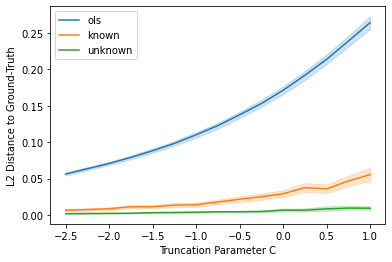

[Text(0.5, 0, 'Truncation Parameter C'),
 Text(0, 0.5, 'L1 Distance to Ground-Truth')]

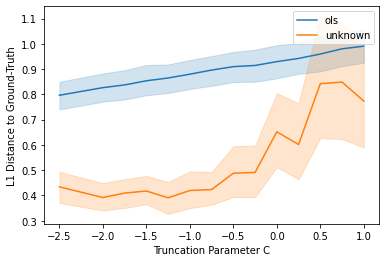

In [116]:
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols')
ax = sns.lineplot(data=logs, x='c', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='c', y='unknown_param_mse', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='c', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=logs, x='c', y='unknown_var_l1', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L1 Distance to Ground-Truth')

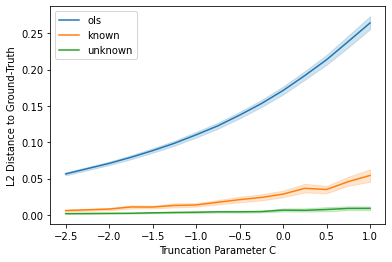

[Text(0.5, 0, 'Truncation Parameter C'),
 Text(0, 0.5, 'L1 Distance to Ground-Truth')]

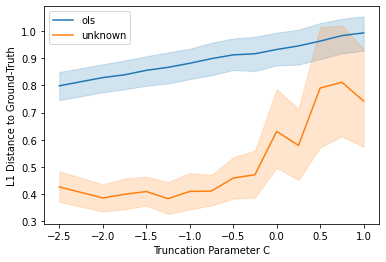

In [115]:
sns.lineplot(data=ols_logs, x='c', y='ols_param_mse', label='ols')
ax = sns.lineplot(data=known_logs, x='c', y='known_param_mse', label='known')
ax = sns.lineplot(data=unknown_logs, x='c', y='unknown_param_mse', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=ols_logs, x='c', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=unknown_logs, x='c', y='unknown_var_l1', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L1 Distance to Ground-Truth')

In [114]:
trunc_ols = LinearRegression().fit(x_trunc, y_trunc)
emp_noise_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
emp_noise_var

tensor([0.4925])

In [115]:
emp_noise_scale = ch.sqrt(emp_noise_var / 2)
emp_noise_scale

tensor([0.4962])

In [117]:
(emp_noise_var / 2).pow(.5)

tensor([0.4962])

In [120]:
new_noised = noised / ch.sqrt(emp_noise_var)
new_y_trunc = y_trunc / ch.sqrt(emp_noise_var)

In [121]:
ols = LinearRegression().fit(x_trunc_norm, new_y_trunc)

In [122]:
(new_y_trunc - ols.predict(x_trunc_norm)).var(0)

tensor([1.])

In [112]:
another_ols = LinearRegression()
another_ols.fit(X, noised / noise_scale)

LinearRegression()

In [113]:
(noised - another_ols.predict(X)).var(0)

tensor([1.0035])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [ ]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_mse']].sum(1).idxmax(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [35]:
gt.weight, gt.bias

(Parameter containing:
 tensor([[0.5118]], requires_grad=True),
 Parameter containing:
 tensor([[0.5949]], requires_grad=True))

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

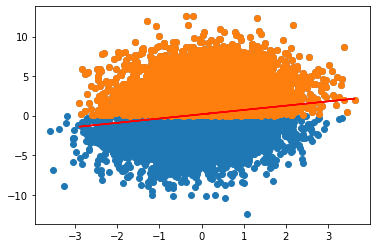

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])